<a href="https://colab.research.google.com/github/paytonmaurer/orbital-traffic-heatmap/blob/main/datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Women in Data Datathon 2025  
## Project: SpaceAware – Traffic Heatmap Analysis  

**Team Name:** Data Divas  
**Team Members:**  
- Payton Maurer  
- Debisree Ray  
- Varshitha Venkatesh  
- Aiperi Subanova  

**Notebook Purpose:**  
This notebook documents the process of accessing, querying, and retrieving datasets from the Unified Data Library (UDL). The outputs will be used to support our analysis and visualization of orbital traffic patterns and congestion risks.  

_Last updated: September 2025_  



---



## How to Run This Notebook
* **Task:** Provide quick-start instructions and guardrails  

* **What it does:** Explains execution order, secrets handling, and common pitfalls  

* **Notes:** Run cells **top → bottom**. If runtime resets, re-run **Section 1 (Setup)** and **Section 2 (Auth)**

* **Dependencies:** None

### Quick Start
1) Run **Section 1** (mount + install + imports + paths)  
2) In **2.1**, set your `TOKEN` (or enable `secrets.json`)  
3) Run **2.2** to set endpoints  
4) In **3.1**, adjust ELSET params → run **3.2–3.3**  
5) Use **Section 4–5** for cleaning, analysis, and visuals  
6) Summarize in **Section 6**

### Conventions
- **Root path:** `/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/UDL_ELSET_Project`  
- **Dates/times:** ISO 8601 (UTC)  
- **Outputs:** timestamped under `data/raw/YYYY-MM-DD_hhmmss/`

### Secrets & Security
- Do **not** commit real tokens. Prefer environment variables or a local `secrets.json` (kept in Drive, not shared).

### Troubleshooting
- **401/403:** Token missing/expired → set in **2.1**  
- **No results:** Widen `epoch` window in **3.1**; remove extra filters  
- **File not found:** Confirm Drive mount + paths in **1.4 Project Paths**



---



# Section 1 — Setup & Environment

**Purpose / Objective**  
Prepare the Colab runtime for the Traffic Heatmaps project: connect Google Drive, install dependencies, import libraries, set up project paths, sanity-check local bulk ZIPs, and choose the UDL environment for downstream API calls.

**Overview**  
- Mount Google Drive so data persists  
- Install core libraries for ingestion, processing, and plotting  
- Import modules used across the notebook  
- Create standardized project folders and verify paths  
- Optionally verify ELSET bulk ZIPs exist in Drive  
- Choose the UDL environment for Secure Messaging and REST calls

**Notes / Callouts**  
- Run cells **top-to-bottom**  
- If you restart the runtime, re-run Section 1 before continuing  
- Section **1.7** sets environment variables consumed by later sections; run 1.7 **before** any Secure Messaging authentication or requests

## 1.1 Mount Google Drive

* **Task:** Connect Colab to Google Drive  

* **What it does:** Mounts your Drive to `/content/drive` so files persist across sessions  

* **Notes:** Grant access when prompted; confirm path in the printed output  

* **Dependencies:** None

In [ ]:
# 1.1 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Quick sanity check
import os
assert os.path.exists("/content/drive/MyDrive"), "Drive not mounted correctly."
print("✅ Drive mounted at /content/drive")

Mounted at /content/drive
✅ Drive mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.2 Install Required Packages

* **Task:** Install Python dependencies  

* **What it does:** Installs libraries for HTTP requests, data handling, date parsing, and plotting  

* **Notes:** Safe to re-run after a runtime reset; Parquet engines are installed separately in 1.3

* **Dependencies:** 1.1 Mount Google Drive (recommended)

In [ ]:
# 1.2 Install core dependencies
%pip install --quiet pandas requests python-dateutil matplotlib seaborn
print("✅ Core dependencies installed")

✅ Core dependencies installed


### 1.2.1 Space-Track & Viz Add-Ons (optional)

- **Task**  Add focused packages for Space-Track access, orbit propagation, and in-notebook visualization.  

- **What It Does**  Installs `spacetrack`, `skyfield`, `sgp4`, `pydeck`, `plotly`, and `pyarrow` (for Parquet).  

- **Notes**  Run once per runtime. If you already installed some of these in §1.2, this is idempotent.  

- **Dependencies**  §1.1 (Drive mounted) and §1.2 (baseline packages).

In [ ]:
# 1.2.1 - Space-Track & Viz Add-Ons (optional)
!pip -q install spacetrack skyfield sgp4 pydeck plotly pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.0/367.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.7/235.7 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.4/511.4 kB 35.7 MB/s eta 0:00:00


## 1.3 Optional: Parquet Engines
* **Task:** Install Parquet engines  

* **What it does:** Adds fast Parquet read/write support via `pyarrow` and `fastparquet`  

* **Notes:** Run if you plan to save or read Parquet files; safe to re-install if already present  

* **Dependencies:** 1.2 Install Required Packages

In [ ]:
# 1.3 Optional Parquet engines
# %pip install pyarrow fastparquet --quiet
%pip install --quiet pyarrow fastparquet
print("✅ Parquet engines installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.9 MB/s eta 0:00:00
✅ Parquet engines installed


## 1.4 Import Libraries

* **Task:** Import core libraries  

* **What it does:** Loads modules for requests, parsing, data manipulation, plotting, and utilities  

* **Notes:** Paths and constants are set in 1.5; warnings are muted for readability  

* **Dependencies:** 1.2 / 1.3 Install Required Packages

In [ ]:
# 1.4 Imports
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from datetime import datetime, timezone, timedelta
from dateutil import parser as dateparser
from IPython.display import display
import json, zipfile, io, requests, os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

print("✅ Imports loaded")

✅ Imports loaded


## 1.5 Project Paths & Runtime Checks
**Purpose / Objective:**

Define canonical paths for (a) the notebook root and master references, and (b) the workspace root where this run writes data/offsets/figures. Verify presence of the Service Matrix CSV.

**Overview:**

* 1.5.1 sets PROJECT_ROOT to My Drive > WID_Datathon > Google_Colab_Notebook, ensures Master Files exists, and discovers udl_service_matrix.csv.

* 1.5.2 uses your existing workspace structure (renamed to WORKSPACE_ROOT) and exports UDL_BASE_DIR.

**Notes / Callouts:**
* Run after mounting Drive and installing/importing dependencies.

* Adjust only the two root variables if your layout changes.

### 1.5.1 Master Files & Service Matrix Discovery

* **Task:** Establish notebook-level paths and register candidate locations for udl_service_matrix.csv.

* **What it does:** Creates PROJECT_ROOT (notebook root) and MASTER_FILES_DIR; searches preferred/alternate/session paths and reports the first CSV found.

* **Notes:** Keeps PROJECT_ROOT reserved for the notebook root used by Section 2.x (do not reassign it below).

* **Dependencies:** 1.1 Mount Google Drive • 1.2 Install Required Packages • 1.4 Import Libraries

In [ ]:
# 1.5.1 - Master Files & Service Matrix Discovery

from pathlib import Path
import os

# Notebook-level roots (do NOT overwrite this name later)
MYDRIVE = Path("/content/drive/MyDrive")
PROJECT_ROOT = MYDRIVE / "WID_Datathon" / "Google_Colab_Notebook"
MASTER_FILES_DIR = PROJECT_ROOT / "Master_Files"

# Sanity checks
assert os.path.exists("/content/drive/MyDrive"), "Drive not mounted correctly. Run §1.1 first."
assert PROJECT_ROOT.exists(), f"Notebook root not found at: {PROJECT_ROOT}"
print(f"✅ Notebook root (PROJECT_ROOT): {PROJECT_ROOT}")

if not MASTER_FILES_DIR.exists():
    print(f"ℹ️ 'Master Files' directory not found; creating: {MASTER_FILES_DIR}")
    MASTER_FILES_DIR.mkdir(parents=True, exist_ok=True)
else:
    print(f"✅ Master Files dir: {MASTER_FILES_DIR}")

# Preferred & alternate CSV locations
PREFERRED_CSV = MASTER_FILES_DIR / "udl_service_matrix.csv"
ALTERNATE_CSV = PROJECT_ROOT / "udl_service_matrix.csv"

# Session/local candidates (if CSV generated in-notebook)
SESSION_CANDIDATES = [
    Path("./udl_service_matrix.csv"),
    Path("./data/udl_service_matrix.csv"),
    Path("/content/udl_service_matrix.csv"),
    Path("/mnt/data/udl_service_matrix.csv"),
]

# Candidate list for §2.9
CANDIDATES = [PREFERRED_CSV, ALTERNATE_CSV, *SESSION_CANDIDATES]

# De-duplicate while preserving order
_seen = set()
CANDIDATES = [p for p in CANDIDATES if not (str(p) in _seen or _seen.add(str(p)))]

# Report the first CSV we find
found = next((p for p in CANDIDATES if p.exists()), None)
if found:
    print(f"📄 Found Service Matrix CSV at: {found}")
else:
    print("⚠️ Service Matrix CSV not found yet.")
    print("   Please upload to one of these (checked in order):")
    print(f"   1) {PREFERRED_CSV}")
    print(f"   2) {ALTERNATE_CSV}")
    print("   Session fallbacks are also checked if you generated the CSV in-notebook.")


✅ Notebook root (PROJECT_ROOT): /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook
✅ Master Files dir: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files
⚠️ Service Matrix CSV not found yet.
   Please upload to one of these (checked in order):
   1) /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/udl_service_matrix.csv
   2) /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/udl_service_matrix.csv
   Session fallbacks are also checked if you generated the CSV in-notebook.


### 1.5.2 Project Paths & Runtime Checks
* **Task:** Configure your run’s workspace directories and environment variables.

* **What it does:** Sets WORKSPACE_ROOT (your previous PROJECT_ROOT), creates data/output folders, and exports UDL_BASE_DIR for later sections.

* **Notes:** If you switch workstreams (e.g., to UDL_ELSET_Project), update only WORKSPACE_ROOT.

* **Dependencies:** 1.5.1 Master Files & Service Matrix Discovery

In [ ]:
# 1.5.2 - Workspace Paths & Runtime Checks (preserves your existing structure)

from datetime import datetime, timezone
import os
from pathlib import Path

# 👉 Update this root if your workspace path differs
WORKSPACE_ROOT = Path(
    "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector"
)
# Alternative workspace (uncomment if switching):
# WORKSPACE_ROOT = Path("/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/UDL_ELSET_Project")

DATA_DIR      = WORKSPACE_ROOT / "data"
RAW_DIR       = DATA_DIR / "raw" / datetime.now(timezone.utc).strftime("%Y-%m-%d_%H%M%S")
PROCESSED_DIR = DATA_DIR / "processed"
FIGURES_DIR   = WORKSPACE_ROOT / "figures"
OFFSETS_DIR   = DATA_DIR / "offsets"
CONFIG_DIR    = WORKSPACE_ROOT / "configs"

for p in [WORKSPACE_ROOT, DATA_DIR, RAW_DIR, PROCESSED_DIR, FIGURES_DIR, OFFSETS_DIR, CONFIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Export for later sections (e.g., poller reads UDL_BASE_DIR/raw and /offsets)
os.environ["UDL_BASE_DIR"] = str(DATA_DIR)

print("WORKSPACE_ROOT :", WORKSPACE_ROOT)
print("DATA_DIR       :", DATA_DIR)
print("RAW_DIR        :", RAW_DIR)
print("PROCESSED_DIR  :", PROCESSED_DIR)
print("FIGURES_DIR    :", FIGURES_DIR)
print("OFFSETS_DIR    :", OFFSETS_DIR)
print("CONFIG_DIR     :", CONFIG_DIR)
print("UDL_BASE_DIR   :", os.getenv("UDL_BASE_DIR"))
print("✅ Workspace paths ready")

WORKSPACE_ROOT : /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector
DATA_DIR       : /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data
RAW_DIR        : /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922
PROCESSED_DIR  : /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed
FIGURES_DIR    : /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/figures
OFFSETS_DIR    : /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/offsets
CONFIG_DIR     : /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/configs
UDL_BASE_DIR   : /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data
✅ Workspace paths ready


### 1.5.3 Quick Preview (Service Material)

In [ ]:
# 1.5.3 Quick Preview (Service Matrix)
import pandas as pd
matrix_path = MASTER_FILES_DIR / "udl_service_matrix.csv"
if matrix_path.exists():
    print("✅ Loaded Service Matrix from:", matrix_path)
    print(pd.read_csv(matrix_path).head())
else:
    print("⚠️ Service Matrix not found at:", matrix_path)

✅ Loaded Service Matrix from: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/udl_service_matrix.csv
  Tier         Name     Type Access Endpoint_or_Topic  \
0    0        ELSET  Service   REST        /udl/elset   
1    0  STATEVECTOR  Service   REST  /udl/statevector   
2    0      ONORBIT  Service   REST      /udl/onorbit   
3    1  CONJUNCTION  Service   REST  /udl/conjunction   
4    1  LAUNCHEVENT  Service   REST  /udl/launchevent   

                                             Purpose  \
0  Fast orbital elements for altitude/inclination...   
1          Precise 3D placement / validation vs SGP4   
2  Lightweight metadata for filters (operator,cou...   
3     Risk overlay (TCA, miss distance, probability)   
4                      Inflow markers after launches   

                            JoinKeys  \
0                    idOnOrbit,satNo   
1                    idOnOrbit,satNo   
2                    idOnOrbit,satNo   
3  object1IdOnOrbit,object2IdOnOrbit

## 1.6 ZIPs: Sanity Check (Drive) — multi-dataset

- **Task**  Verify the Master Files folder exists and count `*.zip` for each dataset root (Elset, StateVector, SGI, Conjunction).  

- **What It does**  Resolves your Master Files base (supports both `Master_Files` and `Master Files`), detects known dataset subfolders, and prints recursive ZIP counts per dataset.  

- **Notes**  Pure sanity check (no extraction). If counts look good, proceed to **§3.1.2** and **§3.2.1/3.2.2**. If nothing is found, the cell will tell you what paths it tried and how to fix.  

- **Dependencies**  §1.1 Drive mounted; optional: §1.5.2 may already define `MASTER_FILES_DIR` / `PROJECT_ROOT`.

In [ ]:
# 1.6 — ZIPs: Sanity Check (Drive) — multi-dataset
from pathlib import Path

# Reuse earlier path variables if available; otherwise infer sensible defaults
DRIVE_ROOT = Path(globals().get("DRIVE_ROOT", "/content/drive/MyDrive"))

# Prefer an existing MASTER_FILES_DIR from §1.5.x
mf_from_globals = globals().get("MASTER_FILES_DIR", None)
mf_candidates = []
if isinstance(mf_from_globals, (str, Path)) and Path(mf_from_globals).exists():
    mf_candidates.append(Path(mf_from_globals))

# Try both naming styles
mf_candidates += [
    DRIVE_ROOT / "WID_Datathon" / "Google_Colab_Notebook" / "Master_Files",
    DRIVE_ROOT / "WID_Datathon" / "Google_Colab_Notebook" / "Master Files",
]

MASTER_FILES_DIR = next((p for p in mf_candidates if p.exists()), None)

# Known dataset subfolders (relative to Master Files)
KNOWN_REL = {
    "elset_udl_project": Path("UDL_ELSET_Project") / "UDL_ELSET_Bulk_Data_Request",
    "elset":             Path("Query_Elset"),
    "statevector":       Path("Query_StateVector"),
    "sgi":               Path("Query_SGI"),
    "cdm":               Path("Query_Conjunction"),
}

def _count_zips(root: Path) -> int:
    try:
        return sum(1 for _ in root.rglob("*.zip"))
    except Exception:
        return 0

print("Drive root:", DRIVE_ROOT)
if MASTER_FILES_DIR and MASTER_FILES_DIR.exists():
    print("Master Files base:", MASTER_FILES_DIR)
else:
    print("⚠️ Could not resolve Master Files base from:")
    for cand in mf_candidates:
        print("   -", cand)
    print("Tip: verify the folder name (space vs underscore) or set MASTER_FILES_DIR in §1.5.2.")
    # Exit early; nothing else to check
    raise SystemExit

FOUND = {}
for key, rel in KNOWN_REL.items():
    p = MASTER_FILES_DIR / rel
    if p.exists():
        FOUND[key] = p

if not FOUND:
    print("⚠️ No known dataset roots found under Master Files.")
    print("Expected one or more of:", ", ".join(str(v) for v in KNOWN_REL.values()))
else:
    print("\nFound dataset roots (recursive ZIP counts):")
    ZIP_COUNTS = {}
    for key, path in FOUND.items():
        n = _count_zips(path)
        ZIP_COUNTS[key] = n
        print(f" - {key:16s} → {path}  |  zip files: {n}")

    # Make these available for later sections if helpful
    globals()["MASTER_FILES_DIR"] = MASTER_FILES_DIR
    globals()["DATASET_ROOTS_FOUND"] = FOUND
    globals()["ZIP_COUNTS"] = ZIP_COUNTS

    # Quick guidance
    any_zips = any(n > 0 for n in ZIP_COUNTS.values())
    if any_zips:
        print("\n✅ ZIPs detected. Next: run §3.1.2 (ensure backfill ON), then §3.2.1 and §3.2.2 to extract.")
    else:
        print("\nℹ️ Found the folders, but 0 ZIPs inside. Check that your ZIPs are uploaded to the expected subfolders.")

Drive root: /content/drive/MyDrive
Master Files base: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files

Found dataset roots (recursive ZIP counts):
 - elset_udl_project → /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/UDL_ELSET_Project/UDL_ELSET_Bulk_Data_Request  |  zip files: 97
 - elset            → /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_Elset  |  zip files: 1
 - statevector      → /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector  |  zip files: 4
 - sgi              → /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_SGI  |  zip files: 1
 - cdm              → /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_Conjunction  |  zip files: 6

✅ ZIPs detected. Next: run §3.1.2 (ensure backfill ON), then §3.2.1 and §3.2.2 to extract.


## 1.7 Select UDL Environment
* **Task:** Choose which UDL environment to use  

* **What it does:** Sets environment variables for downstream Secure Messaging and REST calls  

* **Notes:** Run **one** cell (TEST or PROD) before Section 2; if switching mid-session, re-run this and Sections 2.2 → 2.3 and re-authenticate  

* **Dependencies:** 1.1–1.5 (recommended to be set first)

In [ ]:
# 1.7A TEST environment — recommended while building
%env UDL_HOST=https://test.unifieddatalibrary.com
%env UDL_SM_TOPIC=elset
%env UDL_SM_SLEEP=0.5

env: UDL_HOST=https://test.unifieddatalibrary.com
env: UDL_SM_TOPIC=elset
env: UDL_SM_SLEEP=0.5


In [ ]:
# 1.7A TEST environment — recommended while building
%env UDL_HOST=https://test.unifieddatalibrary.com
%env UDL_SM_TOPIC=elset
%env UDL_SM_SLEEP=0.5

env: UDL_HOST=https://test.unifieddatalibrary.com
env: UDL_SM_TOPIC=elset
env: UDL_SM_SLEEP=0.5


In [ ]:
# 1.7B PROD environment — use when validated
%env UDL_HOST=https://unifieddatalibrary.com
%env UDL_SM_TOPIC=elset
%env UDL_SM_SLEEP=0.5

env: UDL_HOST=https://unifieddatalibrary.com
env: UDL_SM_TOPIC=elset
env: UDL_SM_SLEEP=0.5




---



# Section 2 – Authentication & Configuration

**Purpose / Objective**  
Establish secure access to the Unified Data Library (UDL) and configure the Secure Messaging (SM) endpoints used throughout this notebook.

**Overview**  
- Safe secret handling for a shared Colab (per-user + team token options)  
- Host & topic configuration (TEST ↔ PROD)  
- Dual-mode authentication (Bearer token or Basic) with a smoke test

**Notes / Callouts**  
- Prefer **TEST** while iterating; switch to **PROD** only after validation.  
- Secrets are never written to the shared project folder.  
- Session creation in §2.3 understands: `UDL_TOKEN`, `UDL_BASIC_B64`, `UDL_USER` / `UDL_PASS`, `UDL_CREATED_URL`.

**Dependencies**  
- §1.1 Drive (only needed if using Drive secret files)  
- §1.3 Imports  

## 2.0 Per-User Secrets Manager

**Purpose / Objective**  
Let each teammate store their own UDL credentials safely and auto-load them on every run.

**What’s inside**  
- **2.0a** Secrets Loader (vault → env; optional Drive fallback)  
- **2.0b** Seed Your Secrets (one-time per user)  
- **2.0c** Secrets Status & Preview (sanity check)  
- **2.0d** Team Token Loader (shared JSON)  
- **2.0e** Seed / Rotate Team Token (maintainers only)

**Notes / Callouts**  
- Colab’s `userdata` vault is encrypted and **per Google account**.  
- Optional private file: `MyDrive/_secrets/udl.json` (not the shared project).  
- Team token file lives in a **private team folder** you control.

**Dependencies**  
- §1.1 Drive (for Drive fallback and team file)  

### 2.0.1 Secrets Loader
* **Task:** Auto-load your secrets into environment variables for this session  

* **What it does:** Pulls `UDL_TOKEN`, `UDL_BASIC_B64`, `UDL_USER`, `UDL_PASS` from your Colab user vault; if not found, tries your private `MyDrive/_secrets/udl.json`  

* **Notes:** Runs safely every session; never prints secret values  

* **Dependencies:** (Optional) §1.1 Drive for the fallback

In [ ]:
# 2.0.1 — Secrets loader (Colab user vault → env; optional Drive fallback)
import os, json
from pathlib import Path

try:
    from google.colab import userdata  # per-user, encrypted
except Exception:
    userdata = None

_KEYS = ["UDL_TOKEN","UDL_BASIC_B64","UDL_USER","UDL_PASS"]

def _load_from_userdata(keys):
    loaded = {}
    if userdata is None:
        return loaded
    for k in keys:
        try:
            v = userdata.get(k)
            if v and not os.getenv(k):
                os.environ[k] = v
                loaded[k] = "colab_user_vault"
        except Exception:
            pass
    return loaded

def _load_from_drive(keys):
    """Private per-user file, outside the shared project tree."""
    loaded = {}
    secret_path = Path("/content/drive/MyDrive/_secrets/udl.json")
    if not secret_path.exists():
        return loaded
    try:
        data = json.loads(secret_path.read_text())
        for k in keys:
            v = data.get(k)
            if v and not os.getenv(k):
                os.environ[k] = str(v)
                loaded[k] = str(secret_path)
    except Exception:
        pass
    return loaded

loaded_from = {}
loaded_from.update(_load_from_userdata(_KEYS))
if not any(os.getenv(k) for k in _KEYS):
    loaded_from.update(_load_from_drive(_KEYS))

print("🔐 Secrets loaded from:", loaded_from or "none (will prompt in §2.1 if needed)")

🔐 Secrets loaded from: none (will prompt in §2.1 if needed)


#### 2.0.1a Colab Secrets → Env Loader (UDL + Space-Track)

- **Task**  Load secrets you stored in Colab (`UDL_BASIC_B64`, `UDL_USER`, `UDL_PASS`, `SPACETRACK_USER`, `SPACETRACK_PASS`) into environment variables for this runtime.  

- **What It does**  Pulls values via `from google.colab import userdata; userdata.get('KEY')` and exports them to `os.environ`; prints masked status lines.  

- **Notes**  This is per-user and private in Colab. Each teammate adds their own secrets once in the Colab UI (no plaintext in the notebook). Idempotent.  

- **Dependencies**  2.0 Per-User Secrets Manager; your secrets must exist in Colab’s “Configure secrets” UI.

In [ ]:
# 2.0.1a - Colab Secrets → Env Loader (UDL + Space-Track)
import os

try:
    from google.colab import userdata  # type: ignore
except Exception:
    raise RuntimeError("Colab 'userdata' is only available in Google Colab. Open this notebook in Colab to use secrets.")

def _pull(k):
    try:
        v = userdata.get(k)
        return v if v is not None else os.getenv(k)
    except Exception:
        return os.getenv(k)

def _mask(s, keep=2):
    if not s: return "∅"
    s = str(s)
    return ("*" * max(len(s) - keep, 0)) + s[-keep:]

# Keys you told me you created in Colab secrets
KEYS = ["UDL_BASIC_B64", "UDL_USER", "UDL_PASS", "SPACETRACK_USER", "SPACETRACK_PASS"]

loaded = {}
for k in KEYS:
    v = _pull(k)
    if v:
        os.environ[k] = v
        loaded[k] = True
    else:
        loaded[k] = False

print("Secrets loaded → env:")
for k in KEYS:
    print(f" - {k}: {_mask(os.getenv(k) or '')}")

Secrets loaded → env:
 - UDL_BASIC_B64: **************************************U=
 - UDL_USER: ∅
 - UDL_PASS: ∅
 - SPACETRACK_USER: ∅
 - SPACETRACK_PASS: ∅


#### 2.0.1b Secrets Sanity Check (no network)

- **Task**  Verify that required secrets are present in this runtime (without making any API calls).  

- **What It does**  Asserts presence of `UDL_BASIC_B64` (or `UDL_USER` & `UDL_PASS`) and `SPACETRACK_USER` & `SPACETRACK_PASS`; prints friendly guidance if anything’s missing.  

- **Notes**  Keeps your values masked; intended to run right after 2.0.1a.  

- **Dependencies**  2.0.1a completed successfully.

In [ ]:
# 2.0.1b - Secrets Sanity Check (no network)
missing = []

# UDL: allow either BASIC_B64 or (USER+PASS)
has_udl = bool(os.getenv("UDL_BASIC_B64")) or (os.getenv("UDL_USER") and os.getenv("UDL_PASS"))
if not has_udl:
    missing += ["UDL_BASIC_B64  or  (UDL_USER + UDL_PASS)"]

# Space-Track: need both
for k in ["SPACETRACK_USER", "SPACETRACK_PASS"]:
    if not os.getenv(k):
        missing.append(k)

if missing:
    print("⚠️ Missing required secret(s):")
    for m in missing: print(" -", m)
    print("\nOpen: Runtime ▸ Configure secrets ▸ add the keys exactly as listed, then re-run 2.0.1a and 2.0.1b.")
else:
    print("✅ All required secrets are present in env (values masked above).")

⚠️ Missing required secret(s):
 - SPACETRACK_USER
 - SPACETRACK_PASS

Open: Runtime ▸ Configure secrets ▸ add the keys exactly as listed, then re-run 2.0.1a and 2.0.1b.


### 2.0.2 Seed Your Secrets (one-time per user)
* **Task:** Save your UDL credentials safely for automatic use later  

* **What it does:** Stores any provided keys in your Colab user vault (encrypted) and optionally in your private `MyDrive/_secrets/udl.json`  

* **Notes:** Run **once** per user (or when rotating secrets). Never run in a recorded screencast.  

* **Dependencies:** (Optional) §1.1 Drive if you want the Drive fallback

In [ ]:
# 2.0.2 — Seed secrets via environment variables (no google.colab.userdata)

import os, base64, getpass

def _set_env(name: str, value):
    if value is not None and str(value).strip() != "":
        os.environ[name] = str(value).strip()

print("Paste ONLY what you actually have (leave others blank)")
print("• For Basic: either 'Basic <base64>' or just the base64 (we’ll add 'Basic ' for you)")
print("• For Token: paste the raw token (no 'Bearer ')")

# 1) Optional direct secrets (hidden input to avoid echoing)
try:
    udl_basic = getpass.getpass("UDL_BASIC_B64 (optional, hidden): ").strip().strip('"\'')

    udl_token = getpass.getpass("UDL_TOKEN (optional, hidden): ").strip().strip('"\'')

except Exception:
    # Fallback to visible input if getpass is unavailable
    udl_basic = input("UDL_BASIC_B64 (optional): ").strip().strip('"\'')

    udl_token = input("UDL_TOKEN (optional): ").strip().strip('"\'')

# 2) If neither provided, fall back to interactive user/pass (encoded to Basic)
udl_user = None
udl_pass = None
if not udl_basic and not udl_token:
    udl_user = input("UDL_USER (optional; press Enter to skip): ").strip()
    if udl_user:
        udl_pass = getpass.getpass("UDL_PASS (will not echo): ")
        if udl_pass:
            b64 = base64.b64encode(f"{udl_user}:{udl_pass}".encode("utf-8")).decode("utf-8")
            udl_basic = f"Basic {b64}"

# 3) Normalize Basic prefix if user pasted only the base64
if udl_basic and not udl_basic.lower().startswith("basic "):
    udl_basic = "Basic " + udl_basic

# 3b) Heads-up if both were provided
if udl_token and udl_basic:
    print("ℹ️ Both UDL_TOKEN and UDL_BASIC_B64 provided — §2.3 will prefer Bearer token.")

# 4) Export to environment for the rest of the notebook
_set_env("UDL_BASIC_B64", udl_basic if udl_basic else None)
_set_env("UDL_TOKEN", udl_token if udl_token else None)

# (Optional) Keep user/pass as last-resort fallbacks; comment out to avoid storing in env in a shared runtime.
_set_env("UDL_USER", udl_user if udl_user else None)
_set_env("UDL_PASS", udl_pass if udl_pass else None)

# 5) Status (no secrets printed)
mode = ("Bearer token" if os.getenv("UDL_TOKEN")
        else "Basic pre-encoded" if os.getenv("UDL_BASIC_B64")
        else "Basic user/pass" if os.getenv("UDL_USER") and os.getenv("UDL_PASS")
        else "❌ none")
print("\n✅ Secrets seeded to environment.")
print("• Auth mode that §2.3 will prefer →", mode)
print("• UDL_TOKEN set        :", bool(os.getenv("UDL_TOKEN")))
print("• UDL_BASIC_B64 set    :", bool(os.getenv("UDL_BASIC_B64")))
print("• UDL_USER present     :", bool(os.getenv("UDL_USER")))
print("• UDL_PASS present     :", bool(os.getenv("UDL_PASS")))

Paste ONLY what you actually have (leave others blank)
• For Basic: either 'Basic <base64>' or just the base64 (we’ll add 'Basic ' for you)
• For Token: paste the raw token (no 'Bearer ')


### 2.0.3 Secrets Status & Preview
* **Task:** Confirm what auth mode will be used in §2.3  

* **What it does:** Checks environment vars, masks values, and predicts priority: `UDL_TOKEN` → `UDL_BASIC_B64` → `UDL_USER`/`UDL_PASS`  

* **Notes:** Never prints full secrets; shows only lengths and last 2–3 chars  

* **Dependencies:** 2.0a (loader) and/or 2.0b (seeding)

In [ ]:
# 2.0.3 — Show which auth will be used (without exposing secrets)
import os

def mask_tail(s, tail=2):
    if not s: return "—"
    s = str(s)
    n = len(s)
    return f"{'*'*(max(n-tail, 3))}{s[-tail:]}"

tok = os.getenv("UDL_TOKEN") or ""
b64 = os.getenv("UDL_BASIC_B64") or ""
usr = os.getenv("UDL_USER") or ""
pwd = os.getenv("UDL_PASS") or ""

# Normalize b64 if it includes "Basic "
if b64.lower().startswith("basic "):
    b64 = b64.split(None, 1)[-1]

if tok:
    mode = "Bearer token"
elif b64:
    mode = "Basic pre-encoded"
elif usr and pwd:
    mode = "Basic user/pass"
else:
    mode = "None (will prompt in §2.1)"

print("🔎 Secrets status")
print(f"  UDL_TOKEN     : len={len(tok):>3} • {mask_tail(tok)}")
print(f"  UDL_BASIC_B64 : len={len(b64):>3} • {mask_tail(b64)}")
print(f"  UDL_USER      : {'set' if usr else '—'}")
print(f"  UDL_PASS      : {'set' if pwd else '—'}")
print(f"\nAuth mode that §2.3 will prefer → {mode}")

🔎 Secrets status
  UDL_TOKEN     : len=  0 • —
  UDL_BASIC_B64 : len= 44 • ******************************************8=
  UDL_USER      : set
  UDL_PASS      : set

Auth mode that §2.3 will prefer → Basic pre-encoded


### 2.0.4 Team Token Loader (shared)
* **Task:** Load a single, shared UDL token for the whole team  

* **What it does:** Reads a JSON file in a private team Drive folder and exports keys to env vars  

* **Notes:** Keep the folder tightly permissioned; per-user secrets (2.0a/b) still take priority. Override path with `UDL_TEAM_SECRET_PATH`.  

* **Dependencies:** §1.1 Drive

In [ ]:
# 2.0.4 — Team secrets loader (env override + dual defaults)

from pathlib import Path
import json, os

candidates = []

# 1) explicit env override wins (set this if you like)
env_path = os.getenv("UDL_TEAM_SECRET_PATH", "").strip()
if env_path:
    candidates.append(Path(env_path).expanduser())

# 2) preferred location (under the notebook folder)
candidates.append(Path("/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/TeamVault/udl_team.json"))

# 3) legacy location (root TeamVault)
candidates.append(Path("/content/drive/MyDrive/WID_Datathon/TeamVault/udl_team.json"))

TEAM_SECRET_PATH = next((p for p in candidates if str(p) and p.exists()), candidates[0])

print("TEAM_SECRET_PATH:", TEAM_SECRET_PATH)
if not TEAM_SECRET_PATH.exists():
    print(f"ℹ️ No team secret at {TEAM_SECRET_PATH} (ok if using per-user secrets).")
else:
    cfg = json.loads(Path(TEAM_SECRET_PATH).read_text(encoding="utf-8"))

    # auth
    mode = (cfg.get("auth_mode") or "").lower()
    if mode == "bearer" and cfg.get("udl_token"):
        os.environ["UDL_TOKEN"] = cfg["udl_token"].strip()
        os.environ.pop("UDL_BASIC_B64", None)
    elif mode == "basic_b64" and cfg.get("udl_basic_b64"):
        val = cfg["udl_basic_b64"].strip()
        if not val.lower().startswith("basic "):
            val = "Basic " + val
        os.environ["UDL_BASIC_B64"] = val
        os.environ.pop("UDL_TOKEN", None)
    elif mode == "userpass" and cfg.get("udl_user") and cfg.get("udl_pass"):
        os.environ["UDL_USER"] = cfg["udl_user"].strip()
        os.environ["UDL_PASS"] = cfg["udl_pass"].strip()
        os.environ.pop("UDL_TOKEN", None)
        os.environ.pop("UDL_BASIC_B64", None)

    # host/topic/sleep
    if cfg.get("host"):  os.environ["UDL_HOST"] = str(cfg["host"]).strip()
    if cfg.get("topic"): os.environ["UDL_SM_TOPIC"] = str(cfg["topic"]).strip()
    if cfg.get("sleep") is not None: os.environ["UDL_SM_SLEEP"] = str(cfg["sleep"])

    print("✅ Exported:", {
        "UDL_TOKEN": bool(os.getenv("UDL_TOKEN")),
        "UDL_BASIC_B64": bool(os.getenv("UDL_BASIC_B64")),
        "UDL_USER": bool(os.getenv("UDL_USER")),
        "UDL_PASS": bool(os.getenv("UDL_PASS")),
        "UDL_HOST": os.getenv("UDL_HOST"),
        "UDL_SM_TOPIC": os.getenv("UDL_SM_TOPIC"),
        "UDL_SM_SLEEP": os.getenv("UDL_SM_SLEEP"),
    })

TEAM_SECRET_PATH: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/TeamVault/udl_team.json
✅ Exported: {'UDL_TOKEN': False, 'UDL_BASIC_B64': True, 'UDL_USER': True, 'UDL_PASS': True, 'UDL_HOST': 'https://test.unifieddatalibrary.com', 'UDL_SM_TOPIC': 'elset', 'UDL_SM_SLEEP': '0.5'}


### 2.0.5 Seed / Rotate Team Token (maintainers only)
* **Task:** Create or update the shared JSON secret file on Drive for the team  

* **What it does:** Prompts for token/Basic/user/pass and writes `udl_team.json` to the team vault folder  

* **Notes:** Run by a maintainer only. Rotate when policy requires or a member leaves. Keep the Drive folder private.  

* **Dependencies:** §1.1 Drive

In [ ]:
# 2.0.5 — Seed/rotate the shared team secret (maintainers only)
import os, json, getpass
from pathlib import Path

DEFAULT_TEAM_SECRET_DIR  = "/content/drive/MyDrive/WID_Datathon/TeamVault"
TEAM_SECRET_DIR  = Path(os.getenv("UDL_TEAM_SECRET_DIR", DEFAULT_TEAM_SECRET_DIR))
TEAM_SECRET_PATH = TEAM_SECRET_DIR / "udl_team.json"
TEAM_SECRET_DIR.mkdir(parents=True, exist_ok=True)

print("Enter only what you have (leave others blank).")
b64 = input("UDL_BASIC_B64 (optional): ").strip()
tok = input("UDL_TOKEN     (optional): ").strip()
usr = input("UDL_USER      (optional): ").strip()
pwd = getpass.getpass("UDL_PASS      (optional): ").strip()

# Normalize if user pasted "Basic <base64>"
if b64.lower().startswith("basic "):
    b64 = b64.split(None, 1)[-1]

payload = {k:v for k,v in {
    "UDL_TOKEN": tok,
    "UDL_BASIC_B64": b64,
    "UDL_USER": usr,
    "UDL_PASS": pwd,
}.items() if v}

if not payload:
    print("No fields provided; nothing to write.")
else:
    # Merge to avoid clobbering other fields
    current = {}
    if TEAM_SECRET_PATH.exists():
        try:
            current = json.loads(TEAM_SECRET_PATH.read_text())
        except Exception:
            current = {}
    current.update(payload)
    TEAM_SECRET_PATH.write_text(json.dumps(current, indent=2))
    print(f"✅ Team secret updated: {TEAM_SECRET_PATH}")

    # Optional convenience: export into this runtime immediately
    for k, v in payload.items():
        if not os.getenv(k):
            os.environ[k] = v
    print("🔁 Exported to env for this session.")

Enter only what you have (leave others blank).
UDL_BASIC_B64 (optional): cGF5dG9uLm1hdXJlcjoqQ2hAbmMzeXBAbmMzeSFPT08=
UDL_TOKEN     (optional): 
UDL_USER      (optional): payton.maurer
UDL_PASS      (optional): ··········
✅ Team secret updated: /content/drive/MyDrive/WID_Datathon/TeamVault/udl_team.json
🔁 Exported to env for this session.


### 2.0.6 Create/Update Team Secret (one-click)

* **Task:** Write a shared `udl_team.json` into your notebook folder on Drive  

* **What it does:** Creates the JSON used by §2.0d Team Token Loader with your Basic token, host, topic, and poll sleep  

* **Notes:**  
  - Run once by a maintainer; it won’t print your secret  
  - Path aligns with your chosen location under the notebook folder  
  - You can edit `host/topic/sleep` here (e.g., switch to PROD later)  

* **Dependencies:** §1.1 Mount Google Drive

In [ ]:
# 2.0.6 - Create/Update Team Secret (one-click)
# Create/update the team secret JSON under the notebook folder
from pathlib import Path
import json

TEAM_PATH = Path("/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/TeamVault/udl_team.json")
TEAM_PATH.parent.mkdir(parents=True, exist_ok=True)

cfg = {
  "auth_mode": "basic_b64",
  "udl_basic_b64": "Basic cGF5dG9uLm1hdXJlcjoqQ2hAbmMzeXBAbmMzeSFPT08=",
  "host": "https://test.unifieddatalibrary.com",
  "topic": "elset",
  "sleep": 0.5
}

TEAM_PATH.write_text(json.dumps(cfg, indent=2), encoding="utf-8")
print("✅ Wrote team secret file to:", TEAM_PATH)

✅ Wrote team secret file to: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/TeamVault/udl_team.json


### 2.0.7 Space-Track — Secret Keys (register)

- **Task**  Define canonical secret keys for Space-Track credentials and create a lightweight, file-based secrets store fallback (used only if your notebook’s existing secrets manager isn’t present).  

- **What It does**  Standardizes on `SPACETRACK_USER` and `SPACETRACK_PASS`; prepares a `user_secrets.json` file in a private `_secrets` folder when needed; never prints raw secrets.  

- **Notes**  This complements your existing §2.0 secrets manager—if you already have helpers, the code autodetects and defers to them. Do **not** commit secrets to version control.  

- **Dependencies**  §1.5 Project Paths & Runtime Checks (optional); §2.0.1 Secrets Loader (if present).

In [ ]:
# 2.0.7 - Space-Track — Secret Keys (register)
import os, json, getpass
from pathlib import Path

# Canonical keys
SPACETRACK_KEYS = ["SPACETRACK_USER", "SPACETRACK_PASS"]

# Try to integrate with an existing secrets manager if your notebook defines one
HAS_NATIVE_SECRETS = "SECRETS_SET" in globals() or "SECRETS_SAVE" in globals() or "SECRETS" in globals()

# Portable, file-based fallback (kept local to this runtime/Drive; safe to .gitignore)
SECRETS_HOME = Path(os.getenv("SECRETS_HOME", "/content/_secrets"))
SECRETS_FILE = SECRETS_HOME / "user_secrets.json"
SECRETS_HOME.mkdir(parents=True, exist_ok=True)

def _load_local_secrets():
    if SECRETS_FILE.exists():
        try:
            return json.loads(SECRETS_FILE.read_text())
        except Exception:
            return {}
    return {}

def _save_local_secrets(d: dict):
    SECRETS_FILE.write_text(json.dumps(d, indent=2))

def set_secret(k: str, v: str, persist: bool = True, also_env: bool = True):
    """Sets a secret into native manager if present; otherwise uses local file fallback."""
    if HAS_NATIVE_SECRETS and "SECRETS" in globals():
        SECRETS[k] = v  # type: ignore
        if "SECRETS_SAVE" in globals():
            SECRETS_SAVE()  # type: ignore
    else:
        data = _load_local_secrets()
        data[k] = v
        if persist:
            _save_local_secrets(data)
    if also_env:
        os.environ[k] = v

def get_secret(k: str):
    """Lookup precedence: env -> native manager -> local file."""
    if os.getenv(k):
        return os.getenv(k)
    if HAS_NATIVE_SECRETS and "SECRETS" in globals():
        return SECRETS.get(k)  # type: ignore
    return _load_local_secrets().get(k)

def mask(s: str, keep: int = 2):
    if not s: return "∅"
    return ("*" * max(len(s) - keep, 0)) + s[-keep:]

print("Registered Space-Track secret keys:", SPACETRACK_KEYS)
print("Native secrets manager detected:", HAS_NATIVE_SECRETS)
print("Local secrets file:", str(SECRETS_FILE))

Registered Space-Track secret keys: ['SPACETRACK_USER', 'SPACETRACK_PASS']
Native secrets manager detected: False
Local secrets file: /content/_secrets/user_secrets.json


### 2.0.8 Space-Track — Seed / Rotate (one-click)

- **Task**  Prompt the user for Space-Track username/password and store them securely via the secrets bridge from §2.0.7.  

- **What It does**  Writes to your secrets manager if available; otherwise persists to `_secrets/user_secrets.json` and exports to `os.environ` for this runtime.  

- **Notes**  **Do not share** credentials across the team; Space-Track’s user agreement prohibits sharing and requires separate accounts.  

- **Dependencies**  §2.0.7 (secret keys & bridge).

In [ ]:
# 2.0.8 - Space-Track — Seed / Rotate (one-click)
print("Enter your personal Space-Track credentials. These will be stored via the secrets bridge.")
u = input("Space-Track username (email): ").strip()
p = getpass.getpass("Space-Track password (hidden): ")

set_secret("SPACETRACK_USER", u, persist=True, also_env=True)
set_secret("SPACETRACK_PASS", p, persist=True, also_env=True)

print("Saved Space-Track secrets for this user.")
print("SPACETRACK_USER:", mask(get_secret("SPACETRACK_USER")))
print("SPACETRACK_PASS:", mask(get_secret("SPACETRACK_PASS")))

Enter your personal Space-Track credentials. These will be stored via the secrets bridge.
Space-Track username (email): payton.k.maurer@gmail.com
Space-Track password (hidden): ··········
Saved Space-Track secrets for this user.
SPACETRACK_USER: ***********************om
SPACETRACK_PASS: ****************OO


### 2.0.9 Space-Track — Load to Env & Status

- **Task**  Load Space-Track secrets into environment variables and verify presence without exposing raw values.  

- **What It does**  Hydrates `os.environ` from your secrets store and prints a masked status line.  

- **Notes**  Run this at the top of any session before §2.10 to ensure the client can authenticate.  

- **Dependencies**  §2.0.7 (bridge) and either §2.0.8 (seeded) or your existing team secrets loader.

In [ ]:
# 2.0.9 - Space-Track — Load to Env & Status
user = get_secret("SPACETRACK_USER")
pwd  = get_secret("SPACETRACK_PASS")
if user: os.environ["SPACETRACK_USER"] = user
if pwd:  os.environ["SPACETRACK_PASS"] = pwd

print("SPACETRACK_USER:", mask(os.getenv("SPACETRACK_USER") or ""))
print("SPACETRACK_PASS:", mask(os.getenv("SPACETRACK_PASS") or ""))

assert os.getenv("SPACETRACK_USER") and os.getenv("SPACETRACK_PASS"), \
       "Space-Track credentials are not set. Run §2.0.8 to seed them."

SPACETRACK_USER: ***********************om
SPACETRACK_PASS: ****************OO


#### 2.0.9a Auth Mode Toggle & Compliance Guardrails

- **Task**  Choose Space-Track access: **DIRECT** (per-user secrets via Colab) or **CACHE_ONLY** (org bucket; skip for now).  

- **What It does**  If `SPACETRACK_USER` and `SPACETRACK_PASS` are present (from 2.0.1a), sets DIRECT automatically; otherwise respects any pre-set env.  

- **Notes**  In DIRECT mode, each teammate seeds their own Colab Secrets—no shared creds in the notebook.  

- **Dependencies**  2.0.1a/2.0.1b completed (secrets loaded).

In [ ]:
# 2.0.9a - Auth Mode Toggle & Compliance Guardrails (DIRECT-first)
import os

# If user has Space-Track creds loaded via Colab secrets, default to DIRECT.
_has_spacetrack = bool(os.getenv("SPACETRACK_USER")) and bool(os.getenv("SPACETRACK_PASS"))
if _has_spacetrack and not os.getenv("SPACETRACK_AUTH_MODE"):
    os.environ["SPACETRACK_AUTH_MODE"] = "DIRECT"

SPACETRACK_AUTH_MODE = os.getenv("SPACETRACK_AUTH_MODE", "DIRECT" if _has_spacetrack else "CACHE_ONLY").upper()
ORG_CACHE_URL = os.getenv("SPACETRACK_ORG_CACHE_URL", "").strip()

print("SPACETRACK_AUTH_MODE =", SPACETRACK_AUTH_MODE)
if SPACETRACK_AUTH_MODE not in {"DIRECT", "CACHE_ONLY"}:
    raise ValueError("SPACETRACK_AUTH_MODE must be 'DIRECT' or 'CACHE_ONLY'")

if SPACETRACK_AUTH_MODE == "DIRECT":
    print("Mode: DIRECT (per-user Colab Secrets). No GCP bucket required.")
    assert _has_spacetrack, "Missing SPACETRACK_USER/PASS. Run 2.0.1a then 2.0.1b."
else:
    if not ORG_CACHE_URL:
        print("Mode: CACHE_ONLY, but SPACETRACK_ORG_CACHE_URL is empty. Configure later in 2.0.9b–f.")
    else:
        print("Mode: CACHE_ONLY. Org cache prefix:", ORG_CACHE_URL)

USE_SPACETRACK_DIRECT = (SPACETRACK_AUTH_MODE == "DIRECT")

SPACETRACK_AUTH_MODE = DIRECT
Mode: DIRECT (per-user Colab Secrets). No GCP bucket required.


## 2.1 Secure Messaging Authentication
* **Task:** Configure login credentials for UDL Secure Messaging  

* **What it does:** Loads `UDL_USER` / `UDL_PASS` (if you’re using Basic) for this session; **token users can skip**  

* **Notes:** Prefer the secrets manager above; otherwise you’ll be securely prompted  

* **Dependencies:** 2.0 (recommended) or manual entry here

In [ ]:
# 2.1 — Secure Messaging Authentication (Basic user/pass; token users can skip)
import os
from getpass import getpass

USERNAME = os.getenv("UDL_USER")
PASSWORD = os.getenv("UDL_PASS")

if not USERNAME:
    USERNAME = input("UDL Username: ").strip()

if not PASSWORD:
    PASSWORD = getpass("UDL Password: ")

# Keep creds available to later cells in this runtime
os.environ["UDL_USER"] = USERNAME
os.environ["UDL_PASS"] = PASSWORD

def _mask_user(u):
    if not u: return "—"
    return u[0] + "***" + u[-1] if len(u) > 2 else "***"

print("✅ Credentials loaded (masked):", _mask_user(USERNAME))


✅ Credentials loaded (masked): p***r


## 2.2 Secure Messaging Host & Topic (env-driven)
* **Task:** Set UDL base host and target topic for streaming  

* **What it does:** Configures the SM endpoints and selects the topic (default `elset`)  

* **Notes:** Start with **TEST**; switch to **PROD** when stable. You can set `UDL_HOST` with `%env`.  

* **Dependencies:** 2.1 (if using Basic); 2.0d if using team token

In [ ]:
# Force PROD for this run (place this cell immediately BEFORE §2.2, AFTER any team JSON loader)
%env UDL_HOST=https://unifieddatalibrary.com
%env UDL_ENV=prod

env: UDL_HOST=https://unifieddatalibrary.com
env: UDL_ENV=prod


In [ ]:
# 2.2 — Host / Topic configuration (env-driven)

import os

ENV_TAG = os.getenv("UDL_ENV", "test").lower()   # NEW: tag used later for filenames
HOST    = os.getenv("UDL_HOST", "https://unifieddatalibrary.com").rstrip("/")
TOPIC   = os.getenv("UDL_SM_TOPIC", "elset")
SLEEP_SEC = float(os.getenv("UDL_SM_SLEEP", "0.5"))

def sm_url(path: str) -> str:
    return f"{HOST}/sm/{path.lstrip('/')}"

print("✅ Secure Messaging configured")
print("ENV  :", ENV_TAG)
print("HOST :", HOST)
print("TOPIC:", TOPIC)
print("SLEEP:", SLEEP_SEC, "sec")

# Sanity nudges
if not HOST.startswith("https://"):
    print("⚠️ HOST does not start with https:// — please check UDL_HOST")
if any(x in HOST for x in (" ", "\t")):
    print("⚠️ HOST contains whitespace — please check UDL_HOST")
if ("test." in HOST and ENV_TAG == "prod") or ("test." not in HOST and ENV_TAG == "test"):
    print("⚠️ ENV_TAG and HOST look mismatched — consider aligning UDL_ENV with the chosen host")

✅ Secure Messaging configured
ENV  : prod
HOST : https://unifieddatalibrary.com
TOPIC: elset
SLEEP: 0.5 sec


### 2.2.1 Environment Tag (TEST vs PROD)

* **Task:** Set a single `UDL_ENV` flag and propagate it through filenames/paths  

* **What it does:** Uses `UDL_ENV ∈ {test, prod}` to suffix streamed files, offsets, bundles, and mirrors (e.g., `_test`, `_prod`)  

* **Notes:**  
  - Defaults to **test**; switch to **prod** when validated  
  - Keep `UDL_HOST` selection in §2.2; this cell only standardizes naming  

* **Dependencies:** §1.4 Paths, §2.2 Host & Topic

In [ ]:
# 2.2.1 — Environment tag (TEST/PROD) + optional host alignment

# Choose ONE line below, then run this cell.
# %env UDL_ENV=test
%env UDL_ENV=prod

import os

ENV = os.getenv("UDL_ENV", "test").strip().lower()
if ENV not in ("test", "prod"):
    raise SystemExit("UDL_ENV must be 'test' or 'prod'.")

# If UDL_HOST isn't set yet, pick a sensible default for this ENV.
DEFAULT_HOSTS = {
    "test": "https://test.unifieddatalibrary.com",
    "prod": "https://unifieddatalibrary.com",
}
host_before = os.getenv("UDL_HOST", "").strip()
if not host_before:
    os.environ["UDL_HOST"] = DEFAULT_HOSTS[ENV]
    host_after = os.environ["UDL_HOST"]
    auto = " (auto-set)"
else:
    host_after = host_before
    auto = ""

# Quick sanity checks
mismatch = (("test." in host_after) and ENV == "prod") or (("test." not in host_after) and ENV == "test")
bad_scheme = not host_after.startswith("https://")
has_space = any(c in host_after for c in (" ", "\t"))

print(f"✅ UDL_ENV set to: {ENV}")
print(f"UDL_HOST: {host_after}{auto}")

if mismatch:
    print("⚠️ ENV/HOST look mismatched. Consider aligning them:")
    print(f"   For ENV='{ENV}', a typical host is: {DEFAULT_HOSTS[ENV]}")
    # To force alignment, uncomment the next line:
    # os.environ['UDL_HOST'] = DEFAULT_HOSTS[ENV]

if bad_scheme:
    print("⚠️ UDL_HOST should start with 'https://'.")
if has_space:
    print("⚠️ UDL_HOST contains whitespace — please fix.")

# Expose a short tag for filenames later (§3.3)
ENV_TAG = ENV

env: UDL_ENV=prod
✅ UDL_ENV set to: prod
UDL_HOST: https://unifieddatalibrary.com


### 2.2.2 Host/Env Guardrail

* **Task:** Block or warn when `UDL_ENV` and `UDL_HOST` don’t match (TEST vs PROD)

* **What it does:** Infers env from the host and compares to `UDL_ENV`; stops the run (default) or only warns

* **Notes:**  
  - Default is **strict**: set `%env UDL_ENV_STRICT=0` to only warn  
  - You can extend allowed hosts via `UDL_TEST_HOSTS` and `UDL_PROD_HOSTS` (comma-separated)

* **Dependencies:** §2.2 Host & Topic, §2.2b Environment Tag, (optional) §2.0d Team Token Loader

In [ ]:
# 2.2.2 — Host/Env guardrail (prevents TEST/PROD mix-ups)

import os
from urllib.parse import urlparse

# Inputs (env-driven)
ENV        = os.getenv("UDL_ENV", "test").strip().lower()
HOST_RAW   = os.getenv("UDL_HOST", "https://unifieddatalibrary.com").strip()
STRICT     = os.getenv("UDL_ENV_STRICT", "1").strip().lower() not in ("0","false","no")

# Allow custom lists of known hosts (comma-separated)
test_list = [h.strip().lower() for h in os.getenv(
    "UDL_TEST_HOSTS",
    "https://test.unifieddatalibrary.com, test.unifieddatalibrary.com"
).split(",") if h.strip()]

prod_list = [h.strip().lower() for h in os.getenv(
    "UDL_PROD_HOSTS",
    "https://unifieddatalibrary.com, unifieddatalibrary.com"
).split(",") if h.strip()]

def normalize_host(h: str) -> str:
    """Return canonical 'scheme://netloc' (lowercased), strip spaces and trailing '/'."""
    h = h.strip()
    if "://" not in h:
        h = "https://" + h
    p = urlparse(h)
    canon = f"{p.scheme}://{p.netloc}".lower().rstrip("/")
    return canon

HOST = normalize_host(HOST_RAW)
TEST_HOSTS = {normalize_host(h) for h in test_list}
PROD_HOSTS = {normalize_host(h) for h in prod_list}

def infer_env_from_host(h: str) -> str:
    """Classify host by lists first, then by heuristic substrings."""
    if h in TEST_HOSTS:
        return "test"
    if h in PROD_HOSTS:
        return "prod"
    netloc = urlparse(h).netloc.lower()
    # Heuristics for non-standard test hosts
    testish = ("test.", ".test.", "dev.", ".dev.", "staging.", ".staging.", "sandbox.", ".sandbox.", "qa.", ".qa.")
    return "test" if any(tok in netloc for tok in testish) else "prod"

HOST_ENV = infer_env_from_host(HOST)
ok = ((ENV == "test" and HOST_ENV == "test") or (ENV == "prod" and HOST_ENV == "prod"))

print(f"UDL_ENV : {ENV}")
print(f"UDL_HOST: {HOST}  → inferred as: {HOST_ENV}")
print(f"STRICT  : {'on' if STRICT else 'off (warn only)'}")

# Basic hygiene warnings
if not HOST.startswith("https://"):
    print("⚠️  UDL_HOST should start with 'https://'.")
if " " in HOST_RAW or "\t" in HOST_RAW or HOST_RAW.endswith("/"):
    print("ℹ️  Normalized host from:", repr(HOST_RAW), "→", HOST)

if not ok:
    msg = (
        "❌ Host/Env mismatch detected.\n"
        f"  • UDL_ENV          : {ENV}\n"
        f"  • Inferred host env: {HOST_ENV} ({HOST})\n\n"
        "Fix one of the following and re-run §2.2 → §2.3:\n"
        "  • If you meant TEST:\n"
        "      %env UDL_ENV=test\n"
        "      %env UDL_HOST=https://test.unifieddatalibrary.com\n"
        "  • If you meant PROD:\n"
        "      %env UDL_ENV=prod\n"
        "      %env UDL_HOST=https://unifieddatalibrary.com\n"
        "Or set %env UDL_ENV_STRICT=0 to only warn."
    )
    if STRICT:
        raise SystemExit(msg)
    else:
        print("⚠️ WARNING (STRICT=off)\n" + msg)
else:
    print("✅ Host/Env alignment looks good.")

# Export a short tag for filenames used later (e.g., §3.3)
ENV_TAG = ENV

UDL_ENV : prod
UDL_HOST: https://unifieddatalibrary.com  → inferred as: prod
STRICT  : on
✅ Host/Env alignment looks good.


## 2.3 Session & Smoke Test (hardened)

* **Task:** Build an authenticated session and verify Secure Messaging access  

* **What it does:** Prefers Bearer token; else uses Basic (pre-encoded); else falls back to user/pass. Tries both header-based and `session.auth` Basic. Calls `sm/listTopics` and prints useful debug.  

* **Notes:** 401 usually means env vs creds mismatch (TEST vs PROD), a malformed Basic header, or missing permissions.  

* **Dependencies:** 2.0b/2.0c/2.0d (secrets), 2.2 (Host & Topic)

In [ ]:
# --- §2.3 Session & Smoke Test (no SystemExit on success) ---

import os, json, base64, getpass, requests

HOST    = os.getenv("UDL_HOST", "https://unifieddatalibrary.com").rstrip("/")
TOPIC   = os.getenv("UDL_SM_TOPIC", "elset")
ENV_TAG = os.getenv("UDL_ENV", "test").strip().lower()

def sm_url(path: str) -> str:
    return f"{HOST}/sm/{path.lstrip('/')}"

UDL_TOKEN     = (os.getenv("UDL_TOKEN") or "").strip()
UDL_BASIC_B64 = (os.getenv("UDL_BASIC_B64") or "").strip()
UDL_USER      = (os.getenv("UDL_USER") or "").strip()
UDL_PASS      = (os.getenv("UDL_PASS") or "").strip()

def _decode_basic(basic_header: str):
    if not basic_header:
        return None, None
    hdr = basic_header.strip()
    if hdr.lower().startswith("basic "):
        hdr = hdr[6:].strip()
    try:
        raw = base64.b64decode(hdr).decode("utf-8")
        if ":" in raw:
            return raw.split(":", 1)
    except Exception:
        pass
    return None, None

def _new_session(auth_header=None, auth_tuple=None):
    s = requests.Session()
    s.headers.update({"Accept": "application/json"})
    if auth_header:
        s.headers["Authorization"] = auth_header
    if auth_tuple:
        s.auth = auth_tuple
    return s

def _try_list_topics(session, label):
    try:
        r = session.get(sm_url("listTopics"), timeout=30)
        if r.ok:
            data = r.json()
            n = len(data) if isinstance(data, list) else "unknown"
            print(f"✅ {label}: {r.status_code} — topics fetched: {n}")
            return True, data
        else:
            preview = ""
            try:
                preview = json.dumps(r.json())[:200]
            except Exception:
                preview = (r.text or "")[:200]
            print(f"❌ {label}: {r.status_code} {r.reason}")
            wa = r.headers.get("WWW-Authenticate")
            if wa: print("WWW-Authenticate:", wa)
            if preview: print("Response preview:", preview)
            return False, None
    except requests.RequestException as e:
        print(f"❌ {label}: request error → {e}")
        return False, None

print("Host   :", HOST)
print("Env    :", ENV_TAG)
print("Topic  :", TOPIC)
print("Auth available:",
      "Bearer" if UDL_TOKEN else "(none)",
      "+ Basic-pre" if UDL_BASIC_B64 else "",
      "+ user/pass" if (UDL_USER and UDL_PASS) else "")

success = False

# 1) Bearer
if not success and UDL_TOKEN:
    s = _new_session(auth_header=f"Bearer {UDL_TOKEN}")
    ok, topics = _try_list_topics(s, "Bearer token")
    if ok:
        success = True
        auth_mode = "Bearer"
        session_ok = s

# 2) Basic header
if not success and UDL_BASIC_B64:
    auth_val = UDL_BASIC_B64 if UDL_BASIC_B64.lower().startswith("basic ") else f"Basic {UDL_BASIC_B64}"
    s = _new_session(auth_header=auth_val)
    ok, topics = _try_list_topics(s, "Basic (header)")
    if ok:
        success = True
        auth_mode = "Basic header"
        session_ok = s
    else:
        # 2b) Try session.auth with same creds
        u, p = _decode_basic(auth_val)
        if u and p and not success:
            s2 = _new_session(auth_tuple=(u, p))
            ok2, topics2 = _try_list_topics(s2, "Basic (session.auth)")
            if ok2:
                success = True
                auth_mode = "Basic session.auth"
                session_ok = s2

# 3) Prompt user/pass as last resort
if not success and not (UDL_USER and UDL_PASS) and not (UDL_BASIC_B64 or UDL_TOKEN):
    UDL_USER = input("UDL_USER: ").strip()
    UDL_PASS = getpass.getpass("UDL_PASS (hidden): ")

if not success and UDL_USER and UDL_PASS:
    s3 = _new_session(auth_tuple=(UDL_USER, UDL_PASS))
    ok3, topics3 = _try_list_topics(s3, "Basic (prompted session.auth)")
    if ok3:
        success = True
        auth_mode = "Basic session.auth (prompted)"
        session_ok = s3

# Finalize
if success:
    # verify target and do a light describe
    try:
        target_present = False
        if isinstance(locals().get("topics"), list):
            target_present = any(isinstance(t, dict) and t.get("topic") == TOPIC for t in topics)
        print(f"Target topic '{TOPIC}' present:", "yes" if target_present else "no")
        d = session_ok.get(sm_url(f"describeTopic/{TOPIC}"), timeout=15)
        if d.ok: print("describeTopic OK.")
    except Exception:
        pass

    globals()["session"] = session_ok
    globals()["sm_url"]  = sm_url
    globals()["HOST"]    = HOST
    globals()["TOPIC"]   = TOPIC
    globals()["ENV_TAG"] = ENV_TAG
    print(f"✅ Auth mode used: {auth_mode}. Session primed.")
else:
    print("\n🧭 Troubleshooting tips:")
    print("1) Verify env vs creds: TEST vs PROD users are often separate.")
    print(f"   - Current host: {HOST} (ENV={ENV_TAG})")
    print("   - If your Basic string was created in PROD, either switch host to PROD or re-create it in TEST.")
    print("2) Re-create the Basic header precisely from 'username:password' (no extra quotes/spaces).")
    print("3) If you have a Bearer token, set UDL_TOKEN (no 'Bearer ' prefix).")
    print("4) Confirm your account has Secure Messaging + topic access (e.g., 'elset') in this environment.")
    raise SystemExit("Authentication failed (401). Check token/creds and host.")

Host   : https://unifieddatalibrary.com
Env    : prod
Topic  : elset
Auth available: (none) + Basic-pre + user/pass
✅ Basic (header): 200 — topics fetched: 104
Target topic 'elset' present: yes
describeTopic OK.
✅ Auth mode used: Basic header. Session primed.


### 2.3.1 Auth Diagnostics (optional)

* **Task:** Inspect and validate your Basic header and environment alignment  

* **What it does:** Decodes `UDL_BASIC_B64` locally (without printing the password), checks for stray quotes/spaces, and tries both header and `session.auth`.  

* **Notes:** Use this if §2.3 still returns 401. Most 401s are TEST vs PROD mismatches.  

* **Dependencies:** 2.0b/2.0c/2.0d (secrets), 2.2 (Host & Topic)

In [ ]:
# 2.3.1 - Auth Diagnostics (optional; copy-paste) ---
import os, base64, requests

HOST  = os.getenv("UDL_HOST", "https://unifieddatalibrary.com").rstrip("/")
TOPIC = os.getenv("UDL_SM_TOPIC", "elset")
print("Host:", HOST, "| Topic:", TOPIC)

hdr = os.getenv("UDL_BASIC_B64", "").strip()
if not hdr:
    print("No UDL_BASIC_B64 set. If you have a token, set UDL_TOKEN instead, or run §2.0b to seed secrets.")
else:
    norm = hdr if hdr.lower().startswith("basic ") else f"Basic {hdr}"
    print("Basic header present. Length:", len(norm))
    # sanity decode without revealing full password
    try:
        raw = norm[6:].strip() if norm.lower().startswith("basic ") else norm
        user, pwd = base64.b64decode(raw).decode("utf-8").split(":", 1)
        print("Decoded user:", user)
        print("Password length:", len(pwd))
    except Exception as e:
        print("⚠️ Could not decode Basic header:", e)

    # Tiny live check with both strategies
    s = requests.Session(); s.headers["Accept"]="application/json"; s.headers["Authorization"]=norm
    r = s.get(f"{HOST}/sm/listTopics", timeout=30)
    print("Header method →", r.status_code, r.reason, "| WWW-Authenticate:", r.headers.get("WWW-Authenticate"))

    if r.status_code == 401 and ":" in base64.b64decode(raw).decode("utf-8"):
        u, p = base64.b64decode(raw).decode("utf-8").split(":", 1)
        s2 = requests.Session(); s2.headers["Accept"]="application/json"; s2.auth=(u,p)
        r2 = s2.get(f"{HOST}/sm/listTopics", timeout=30)
        print("session.auth →", r2.status_code, r2.reason, "| WWW-Authenticate:", r2.headers.get("WWW-Authenticate"))

print("\nIf both methods 401 with 'WWW-Authenticate: Basic', your user likely isn’t valid in this HOST.")
print("Try switching HOST (TEST ↔ PROD) or re-creating the Basic in the correct environment.")

Host: https://unifieddatalibrary.com | Topic: elset
Basic header present. Length: 50
Decoded user: payton.maurer
Password length: 18
Header method → 200 OK | WWW-Authenticate: None

If both methods 401 with 'WWW-Authenticate: Basic', your user likely isn’t valid in this HOST.
Try switching HOST (TEST ↔ PROD) or re-creating the Basic in the correct environment.


## 2.4 - UDL Services Quick-Reference (REST + SM)

* **Purpose / Objective:** Provide a concise, scannable map of the UDL services and topics we will use for orbital traffic heatmaps.

* **Overview:** This section lists the priority REST services and Secure Messaging topics (by tier), their purpose, join keys, and how they fit the heatmap pipeline.

* **Notes / Callouts:** This is documentation-only for quick reference (no code execution). Use it to decide which endpoints/topics to query and how to join them downstream.

### 2.4.1 UDL Services Table

* **Task:** Present a one-page service/topic map with purpose, join keys, and access method.

* **What it does:** Summarizes ELSET, STATEVECTOR, ONORBIT, and overlays (CONJUNCTION, LAUNCHEVENT, MANEUVER), plus context topics (SGI, environment) to guide downstream requests.

* **Notes:** Keep this handy when composing `columns=` and time filters; the actual URL builders are defined in later sections.

* **Dependencies:** None

| Tier | Service/Topic            | Access | Endpoint / Topic           | Purpose                                           | Join keys               | Notes                                      |
|-----:|--------------------------|--------|-----------------------------|---------------------------------------------------|-------------------------|--------------------------------------------|
| 0    | ELSET                    | REST   | `/udl/elset`                | Fast orbital elements → altitude/inclination bins | `idOnOrbit`, `satNo`    | Use lean `columns=`                        |
| 0    | STATEVECTOR              | REST   | `/udl/statevector`          | Precise 3D placement / validation                 | `idOnOrbit`, `satNo`    | x,y,z + v for 3D counts                   |
| 0    | ONORBIT                  | REST   | `/udl/onorbit`              | Filter spine: operator / country / constellation  | `idOnOrbit`, `satNo`    | Lightweight metadata                       |
| 1    | CONJUNCTION              | REST   | `/udl/conjunction`          | Risk overlay (TCA, miss distance, probability)    | ids in row              | Overlay on density                         |
| 1    | LAUNCHEVENT              | REST   | `/udl/launchevent`          | Inflow markers (post-launch)                      | —                       | Annotate density jumps                     |
| 1    | MANEUVER                 | REST   | `/udl/maneuver`             | Density shifts (avoidance/plane changes)          | `idOnOrbit`             | Window with heatmap time                   |
| 2    | SGI                      | REST   | `/udl/sgi`                  | Solar/geomagnetic indices (drag context)          | —                       | Time-series indices                        |
| 2    | spaceenvobservation      | SM     | `spaceenvobservation`       | Environment observations                          | —                       | Discover via `describeTopic`               |
| 2    | globalatmosphericmodel   | SM     | `globalatmosphericmodel`    | TEC/electron density model                        | —                       | Use offsets then messages                  |
| 2    | eop                      | SM     | `eop`                       | Earth orientation parameters                      | —                       | Optional (frame work)                      |
| opt  | h3geo                    | SM     | `h3geo`                     | UDL-provided hex bins                             | —                       | Optional; you can bin yourself             |
| opt  | notification             | REST   | `/udl/notification`         | Incremental change feed                           | —                       | Filter by `refTopic`                       |


## 2.5 - Endpoint Catalog (Strings Only; Used by Builders)

* **Purpose / Objective:** Centralize base paths for REST services and Secure Messaging endpoints so builders can reference them consistently.

* **Overview:** Defines dictionaries for REST endpoints and SM paths. No network calls—used by later builder functions.

* **Notes / Callouts:** Do not execute requests here; these are strings only. Update here if your environment exposes different paths or additional services.


### 2.5.1 Define Endpoint Paths

* **Task:** Declare `UDL_BASE`, `REST_ENDPOINTS`, and `SM_ENDPOINTS`.

* **What it does:** Provides a single source of truth for URL assembly in §2.7 builders.

* **Notes:** Do not execute requests here; these are strings only.

* **Dependencies:** None

In [ ]:
# 2.5 - Endpoint Catalog (Strings Only; Used by Builders)

UDL_BASE = "https://unifieddatalibrary.com"

REST_ENDPOINTS = {
    "elset": "/udl/elset",
    "statevector": "/udl/statevector",
    "onorbit": "/udl/onorbit",
    "conjunction": "/udl/conjunction",
    "launchevent": "/udl/launchevent",
    "maneuver": "/udl/maneuver",
    "sgi": "/udl/sgi",
    "notification": "/udl/notification",  # optional
}

SM_ENDPOINTS = {
    "describe": "/sm/describeTopic/{topic}",
    "latest": "/sm/getLatestOffset/{topic}",
    "messages": "/sm/getMessages/{topic}/{offset}",
}

## 2.6 - Column Presets (Single Source of Truth for `columns=`)

* **Purpose / Objective:** Maintain lean, join-friendly `columns=` strings for each service/topic.

* **Overview:** A global `COLUMNS` dictionary that downstream code reuses across requests to minimize payloads and keep joins reliable.

* **Notes / Callouts:** Edit once here; all request builders and examples pull from this dictionary.

### 2.6.1 Define Column Presets

* **Task:** Declare minimal-but-complete column subsets per service/topic.

* **What it does:** Ensures consistent joins (`idOnOrbit` / `satNo`), time, and geometry fields across requests.

* **Notes:** Extend if you need additional fields for analysis; keep defaults slim for performance.

* **Dependencies:** None

In [ ]:
# 2.6 - Column Presets (Single Source of Truth for columns=)

COLUMNS = {
    "elset": (
        "satNo,idOnOrbit,source,origin,epoch,ephemType,dataMode,meanMotion,period,"
        "inclination,eccentricity,semiMajorAxis,apogee,perigee,bStar,revNo,"
        "classificationMarking,raan,argOfPerigee,meanAnomaly"
    ),
    "statevector": "satNo,idOnOrbit,epoch,x,y,z,vx,vy,vz,source",
    "onorbit": "idOnOrbit,satNo,objectType,operator,country,constellation",
    "conjunction": "eventId,tca,missDistance,probability,object1IdOnOrbit,object2IdOnOrbit",
    "launchevent": "eventTime,vehicle,name,newSatNos",
    "maneuver": "idOnOrbit,startTime,endTime,deltaV,reason",
    "sgi": "time,indexValue,indexType",
    # Secure Messaging topics (for topics that support column selection)
    "spaceenvobservation": "time,parameter,value,units",
    "globalatmosphericmodel": "time,model,parameter,value,units",
    "eop": "time,ut1_utc,xPole,yPole,dX,dY",
    "h3geo": "time,hexId,value",
}

## 2.7 - Request Builders (Safe, Reusable, Non-Fetching)

* **Purpose / Objective:** Provide reusable functions to assemble REST URLs and document the Secure Messaging call flow.

* **Overview:** `build_rest_url()` constructs `GET` URLs with `columns=` and time filters; SM helpers define the `describe → latest → messages` flow.

* **Notes / Callouts:** These utilities **do not** execute network calls. They are safe to run any time.

### 2.7.1 Define Builders

* **Task:** Implement REST URL builder and SM helper templates.

* **What it does:** Standardizes URL assembly and SM call sequencing for repeatable, readable requests.

* **Notes:** For non-`epoch` resources (e.g., SGI uses `time`), pass the correct key via `extra_params`.

* **Dependencies:** 2.5 Endpoint Catalog, 2.6 Column Presets

In [ ]:
# 2.7 - Request Builders (Safe, Reusable, Non-Fetching)

from urllib.parse import urlencode, quote
from typing import Dict, Optional

def build_rest_url(
    service: str,
    start_iso: Optional[str] = None,
    end_iso: Optional[str] = None,
    extra_params: Optional[Dict[str, str]] = None,
) -> str:
    """
    Build a REST GET URL for a UDL service with lean columns and optional time filters.
    - Supports duplicate epoch keys (>=, <=) via urlencode(doseq=True).
    - For non-epoch time fields (e.g., 'time' for SGI), pass them in extra_params.
    """
    if service not in REST_ENDPOINTS:
        raise KeyError(f"Unknown REST service: {service}")
    base = UDL_BASE + REST_ENDPOINTS[service]

    params: Dict[str, object] = {}
    if COLUMNS.get(service):
        params["columns"] = COLUMNS[service]

    if extra_params:
        params.update(extra_params)

    if start_iso or end_iso:
        epoch_vals = []
        if start_iso:
            epoch_vals.append(f">={start_iso}")
        if end_iso:
            epoch_vals.append(f"<={end_iso}")
        existing = params.get("epoch")
        if isinstance(existing, list):
            epoch_vals = existing + epoch_vals
        elif isinstance(existing, str):
            epoch_vals = [existing] + epoch_vals
        if epoch_vals:
            params["epoch"] = epoch_vals

    query = urlencode(params, quote_via=quote, safe=',><=:_', doseq=True)
    return f"{base}?{query}"


# Secure Messaging: helper refs (strings for quick copy)
SM_TOPICS = [
    "spaceenvobservation",
    "globalatmosphericmodel",
    "h3geo",
    "eop",
    "track",
    "trackdetails",
]

SM_DOC = {
    "describe": UDL_BASE + SM_ENDPOINTS["describe"].format(topic="{topic}"),
    "latest":   UDL_BASE + SM_ENDPOINTS["latest"].format(topic="{topic}"),
    "messages": (
        UDL_BASE + SM_ENDPOINTS["messages"].format(topic="{topic}", offset="{offset}")
        + "?limit={limit}&{timeField}={gt_time}&columns={columns}"
    ),
}

## 2.8 - Copy-Ready Request Examples (URLs Only; No Requests)

* **Purpose / Objective:** Provide working example URLs you can print/inspect before adding fetch logic.

* **Overview:** ELSET + STATEVECTOR epoch windows, ONORBIT metadata, event overlays, SGI time filters, and SM ‘describe’ URLs.

* **Notes / Callouts:** These cells only print URLs—no HTTP calls.

### 2.8.1 Example URL Assembly

* **Task:** Build representative URLs for priority endpoints and topics.

* **What it does:** Demonstrates how to apply `columns=` and the correct time keys.

* **Notes:** Replace date ranges as needed for your analysis window.

* **Dependencies:** 2.5 Endpoint Catalog, 2.6 Column Presets, 2.7 Builders


In [ ]:
# 2.8 - Copy-Ready Request Examples (URLs Only; No Requests)

# 2.8a ELSET (bounded window)
EX_ELSET_URL = build_rest_url(
    "elset",
    start_iso="2025-08-11T00:00:00Z",
    end_iso="2025-09-08T00:00:00Z",
)
print("ELSET:", EX_ELSET_URL)

# 2.8b STATEVECTOR (bounded window)
EX_STATEVECTOR_URL = build_rest_url(
    "statevector",
    start_iso="2025-09-12T14:20:20Z",
    end_iso="2025-09-13T14:20:20Z",
)
print("STATEVECTOR:", EX_STATEVECTOR_URL)

# 2.8c ONORBIT (metadata spine)
EX_ONORBIT_URL = build_rest_url("onorbit")
print("ONORBIT:", EX_ONORBIT_URL)

# 2.8d Overlays (use appropriate time fields)
EX_CONJUNCTION_URL = build_rest_url("conjunction", extra_params={"tca": ">=2025-09-01T00:00:00Z"})
EX_LAUNCHEVENT_URL = build_rest_url("launchevent", extra_params={"eventTime": ">=2025-06-01T00:00:00Z"})
EX_MANEUVER_URL = build_rest_url("maneuver", extra_params={"startTime": ">=2025-09-01T00:00:00Z"})
print("CONJUNCTION:", EX_CONJUNCTION_URL)
print("LAUNCHEVENT:", EX_LAUNCHEVENT_URL)
print("MANEUVER:", EX_MANEUVER_URL)

# 2.8e SGI (uses 'time', not 'epoch')
EX_SGI_URL = build_rest_url("sgi", extra_params={"time": ">=2025-06-01T00:00:00Z"})
print("SGI:", EX_SGI_URL)

# 2.8f Secure Messaging: describe URLs (strings only)
SM_DESCRIBE_URLS = [SM_DOC["describe"].format(topic=t) for t in SM_TOPICS]
print("SM describe (first 3):", SM_DESCRIBE_URLS[:3])

ELSET: https://unifieddatalibrary.com/udl/elset?columns=satNo,idOnOrbit,source,origin,epoch,ephemType,dataMode,meanMotion,period,inclination,eccentricity,semiMajorAxis,apogee,perigee,bStar,revNo,classificationMarking,raan,argOfPerigee,meanAnomaly&epoch=>=2025-08-11T00:00:00Z&epoch=<=2025-09-08T00:00:00Z
STATEVECTOR: https://unifieddatalibrary.com/udl/statevector?columns=satNo,idOnOrbit,epoch,x,y,z,vx,vy,vz,source&epoch=>=2025-09-12T14:20:20Z&epoch=<=2025-09-13T14:20:20Z
ONORBIT: https://unifieddatalibrary.com/udl/onorbit?columns=idOnOrbit,satNo,objectType,operator,country,constellation
CONJUNCTION: https://unifieddatalibrary.com/udl/conjunction?columns=eventId,tca,missDistance,probability,object1IdOnOrbit,object2IdOnOrbit&tca=>=2025-09-01T00:00:00Z
LAUNCHEVENT: https://unifieddatalibrary.com/udl/launchevent?columns=eventTime,vehicle,name,newSatNos&eventTime=>=2025-06-01T00:00:00Z
MANEUVER: https://unifieddatalibrary.com/udl/maneuver?columns=idOnOrbit,startTime,endTime,deltaV,reason&sta

## 2.9 - Import & Merge “Service Matrix” (CSV → Notebook Presets)

* **Purpose / Objective:** Load a CSV mapping (Service/Topic → Endpoint/Columns) and merge into in-notebook presets.

* **Overview:** Searches common locations (preferred in `Master Files/`), reads `udl_service_matrix.csv`, updates `COLUMNS`, `REST_ENDPOINTS`, and augments `SM_TOPICS`.

* **Notes / Callouts:** If the CSV is absent or malformed, presets remain unchanged. Also previews the first rows for quick QA.

### 2.9.1 Locate & Preview Service Matrix

* **Task:** Locate `udl_service_matrix.csv` and show a preview.

* **What it does:** Reads the CSV from `PROJECT_ROOT / "Master Files"` (preferred) and prints `.head()`.

* **Notes:** Requires Drive to be mounted and `PROJECT_ROOT` to be defined earlier in Section 1.x.

* **Dependencies:** 1.1 Mount Google Drive; 1.2 Project Paths (with `PROJECT_ROOT`)

In [ ]:
# 2.9.1 - Locate & Preview Service Matrix

# Required snippet (per your request)
import pandas as pd
from pathlib import Path

# Assuming your Drive is mounted and PROJECT_ROOT points to Google_Colab_Notebook
matrix_path = PROJECT_ROOT / "Master Files" / "udl_service_matrix.csv"

if matrix_path.exists():
    service_matrix = pd.read_csv(matrix_path)
    print("✅ Loaded Service Matrix from:", matrix_path)
    print(service_matrix.head())
else:
    print("⚠️ Service Matrix not found at:", matrix_path)
    print("Please upload 'udl_service_matrix.csv' to 'Master Files' and re-run this cell.")

⚠️ Service Matrix not found at: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master Files/udl_service_matrix.csv
Please upload 'udl_service_matrix.csv' to 'Master Files' and re-run this cell.


### 2.9.2 Import & Merge Presets

* **Task:** Merge CSV-defined columns/endpoints/topics into the in-notebook presets.

* **What it does:** Updates `COLUMNS`, `REST_ENDPOINTS`, and `SM_TOPICS` where applicable; prints a summary.

* **Notes:** Non-destructive—keeps existing presets if file is missing or columns are incomplete.

* **Dependencies:** 2.5 Endpoint Catalog, 2.6 Column Presets

In [ ]:
# 2.9.2 - Import & Merge Presets

# Candidate locations (Drive + session)
CANDIDATES = [
    matrix_path,  # preferred location in Master Files
    PROJECT_ROOT / "udl_service_matrix.csv",   # alternate at project root
    Path("./udl_service_matrix.csv"),
    Path("./data/udl_service_matrix.csv"),
    Path("/content/udl_service_matrix.csv"),
    Path("/mnt/data/udl_service_matrix.csv"),
]

def _coerce_endpoint(ep: str) -> str:
    if not isinstance(ep, str):
        return ep
    ep = ep.strip()
    if ep and not ep.startswith("/"):
        ep = "/" + ep
    return ep

def _lower_key(name: str) -> str:
    return (name or "").strip().lower()

def import_service_matrix():
    found_path = next((p for p in CANDIDATES if p and p.exists()), None)
    if not found_path:
        print("⚠️ No Service Matrix CSV found — presets unchanged.")
        return {"updated_columns": 0, "updated_rest": 0, "added_topics": 0, "path": None}

    print(f"📄 Loading Service Matrix from: {found_path}")
    df = pd.read_csv(found_path)

    required = {"Tier", "Name", "Type", "Access", "Endpoint_or_Topic", "Purpose", "JoinKeys", "Columns"}
    missing = required.difference(df.columns)
    if missing:
        print(f"⚠️ CSV missing required columns: {sorted(missing)} — presets unchanged.")
        return {"updated_columns": 0, "updated_rest": 0, "added_topics": 0, "path": str(found_path)}

    globals().setdefault("COLUMNS", {})
    globals().setdefault("REST_ENDPOINTS", {})
    globals().setdefault("SM_TOPICS", [])

    updated_columns = 0
    updated_rest = 0
    added_topics = 0

    topic_set = set(SM_TOPICS)

    for _, row in df.iterrows():
        name = str(row["Name"]).strip()
        if not name:
            continue
        key = _lower_key(name)
        access = str(row["Access"]).strip().upper()
        typ = str(row["Type"]).strip().lower()
        endpoint_or_topic = row["Endpoint_or_Topic"]
        cols = row["Columns"] if isinstance(row["Columns"], str) else None

        # Update columns
        if cols:
            COLUMNS[key] = cols
            updated_columns += 1

        # REST endpoint paths
        if access == "REST" and typ == "service":
            ep = _coerce_endpoint(str(endpoint_or_topic))
            if key not in REST_ENDPOINTS or REST_ENDPOINTS.get(key) != ep:
                REST_ENDPOINTS[key] = ep
                updated_rest += 1

        # SM topics
        if access == "SM":
            topic_name = str(endpoint_or_topic).strip()
            if topic_name and topic_name not in topic_set:
                topic_set.add(topic_name)
                added_topics += 1

    globals()["SM_TOPICS"] = sorted(topic_set)

    print("✅ Service Matrix merged.")
    print(f"   • Columns updated: {updated_columns}")
    print(f"   • REST endpoints updated: {updated_rest}")
    print(f"   • SM topics added: {added_topics}")
    print(f"   • Total SM topics now: {len(SM_TOPICS)}")

    return {
        "updated_columns": updated_columns,
        "updated_rest": updated_rest,
        "added_topics": added_topics,
        "path": str(found_path),
    }

_ = import_service_matrix()

⚠️ No Service Matrix CSV found — presets unchanged.


## 2.10 - Space-Track Authentication (optional)

**Purpose / Objective**  
- Enable optional data pulls from Space-Track (TLE/GP, public CDMs) to power orbital traffic heatmaps and "today’s conjunctions."

**Overview**  
- Use per-user credentials (email/password) to create a Space-Track session.  
- Keep credentials out of source by loading from your existing secrets pattern or environment.  
- Provide a quick smoke test to validate access.

**Notes**  
- Honors Space-Track session behavior and rate considerations.  
- Only used for public/allowed endpoints; please respect Terms of Use.  

#### 2.10.1 Space-Track Credentials (Secrets Bridge)

- **Task**  Confirm Space-Track creds surfaced from Colab Secrets into env.  

- **What It does**  Reads masked values; asserts presence in DIRECT mode.  

- **Notes**  No network call here—just checks what 2.0.1a loaded.  

- **Dependencies**  2.0.1a/2.0.1b and 2.0.9a (DIRECT).

In [ ]:
# 2.10.1 - Space-Track Credentials (Secrets Bridge)
import os

def _mask(v: str, keep: int = 2) -> str:
    if not v: return "∅"
    return ("*" * max(len(v) - keep, 0)) + v[-keep:]

print("SPACETRACK_USER:", _mask(os.getenv("SPACETRACK_USER") or ""))
print("SPACETRACK_PASS:", _mask(os.getenv("SPACETRACK_PASS") or ""))

if os.getenv("SPACETRACK_AUTH_MODE", "DIRECT").upper() == "DIRECT":
    assert os.getenv("SPACETRACK_USER") and os.getenv("SPACETRACK_PASS"), \
        "Missing Space-Track creds; re-run 2.0.1a then 2.0.1b."

SPACETRACK_USER: ***********************om
SPACETRACK_PASS: ****************OO


#### 2.10.2 Create Space-Track Client Session

- **Task**  Create an authenticated `SpaceTrackClient` using env creds.  

- **What It does**  Instantiates the client; no queries yet.  
- **Notes**  Keeps identity/password out of outputs.  

- **Dependencies**  2.10.1 succeeded; `pip install spacetrack` already done in earlier setup.

In [ ]:
# 2.10.2 - Create Space-Track Client Session
from spacetrack import SpaceTrackClient
import os

st_user = os.getenv("SPACETRACK_USER")
st_pass = os.getenv("SPACETRACK_PASS")
assert st_user and st_pass, "Space-Track creds missing; run 2.10.1."

st = SpaceTrackClient(identity=st_user, password=st_pass)
print("Space-Track client created.")

Space-Track client created.


##### 2.10.2a Space-Track Client — Initialize (team secrets)

- **Task**  Create a global `st` client using `SPACETRACK_USER` / `SPACETRACK_PASS` stored in Colab secrets.  

- **What It does**  Installs `spacetrack` if needed and logs in; keeps `st` in globals for later cells.  

- **Notes**  This is optional. If secrets are missing, we keep `st=None` and you can stay on the CelesTrak path.  

- **Dependencies**  2.0.8 (secrets via `google.colab.userdata`).

In [ ]:
# 2.10.2a — Space-Track Client Initialize (secrets-aware, idempotent)
import sys, subprocess

# Ensure library is present
try:
    from spacetrack import SpaceTrackClient
    from spacetrack.base import AuthenticationError
except Exception:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "spacetrack"], check=True)
    from spacetrack import SpaceTrackClient
    from spacetrack.base import AuthenticationError

# Pull creds from Colab secrets first, then env as fallback
ST_USER = ST_PASS = None
try:
    from google.colab import userdata
    ST_USER = userdata.get("SPACETRACK_USER")
    ST_PASS = userdata.get("SPACETRACK_PASS")
except Exception:
    pass

import os
ST_USER = ST_USER or os.getenv("SPACETRACK_USER")
ST_PASS = ST_PASS or os.getenv("SPACETRACK_PASS")

# Initialize client (or leave st=None)
st = None
if ST_USER and ST_PASS:
    try:
        st = SpaceTrackClient(identity=ST_USER, password=ST_PASS)
        # light probe: if this fails, we'll handle below
        _ = st.tle_latest(limit=1, format="json")
        print("✅ Space-Track client initialized and reachable.")
    except AuthenticationError:
        print("❌ Space-Track authentication failed. Check SPACETRACK_USER / SPACETRACK_PASS in secrets.")
        st = None
    except Exception as e:
        print("⚠️ Space-Track init/probe error:", repr(e))
        st = None
else:
    print("ℹ️ No Space-Track creds found in Colab secrets or env; `st` remains None (CelesTrak-only path).")

✅ Space-Track client initialized and reachable.


##### 2.10.2b Space-Track Smoke Test (optional) — hardened

- **Task**  Verify `st` can fetch a tiny `tle_latest` sample.  

- **What It does**  Tries both API shapes and normalizes odd return types (string/Response/generator).  

- **Notes**  Only records `ST_CALL_STYLE` if we actually get a non-empty DataFrame.  

- **Dependencies**  2.10.2a.

In [ ]:
# 2.10.2b — Space-Track Smoke Test (optional, hardened)
import pandas as pd
import json

# Start fresh: clear any stale adapter flag
globals().pop("ST_CALL_STYLE", None)

if 'st' not in globals() or st is None:
    raise SystemExit("ℹ️ `st` not initialized. Run 2.10.2a or continue with the CelesTrak/SOCRATES path.")

def _as_rows(x):
    """Normalize various spacetrack client return types into a list[dict]."""
    try:
        # already a list/tuple of dicts?
        if isinstance(x, (list, tuple)):
            return list(x)
        # dict -> wrap
        if isinstance(x, dict):
            return [x]
        # requests.Response-like
        if hasattr(x, "json"):
            return x.json()
        # bytes/str JSON
        if isinstance(x, (bytes, str)):
            return json.loads(x)
    except Exception:
        pass
    return None

rows = None
style_used = None

# Path A: direct method call
try:
    raw = st.tle_latest(ordinal=1, limit=1, format="json")
    rows = _as_rows(raw)
    style_used = "method:tle_latest"
except TypeError as e:
    print("ℹ️ st.tle_latest(...) rejected a parameter on this client:", e)
except Exception as e:
    print("ℹ️ st.tle_latest(...) probe failed:", repr(e))

# Path B: controller query
if not rows:
    try:
        if hasattr(st, "basicspacedata") and hasattr(st.basicspacedata, "query"):
            raw = st.basicspacedata.query(class_="tle_latest", ordinal=1, limit=1, format="json")
            rows = _as_rows(raw)
            style_used = "controller:basicspacedata.query"
        else:
            print("ℹ️ basicspacedata.query not available on this client.")
    except Exception as e:
        print("ℹ️ basicspacedata.query probe failed:", repr(e))

if rows and len(rows) > 0 and isinstance(rows[0], dict):
    df = pd.DataFrame(rows)
    print(f"✅ Space-Track reachable via {style_used}. Rows: {len(df)}")
    display(df.head(1))
    globals()["ST_CALL_STYLE"] = style_used
    print("ST_CALL_STYLE:", style_used)
else:
    print("⚠️ Smoke test did not return a parseable row. You can still use the CelesTrak/SOCRATES path.")

✅ Space-Track reachable via method:tle_latest. Rows: 1


,ORDINAL,COMMENT,ORIGINATOR,NORAD_CAT_ID,OBJECT_NAME,OBJECT_TYPE,CLASSIFICATION_TYPE,INTLDES,EPOCH,EPOCH_MICROSECONDS,...,TLE_LINE0,TLE_LINE1,TLE_LINE2,OBJECT_ID,OBJECT_NUMBER,SEMIMAJOR_AXIS,PERIOD,APOGEE,PERIGEE,DECAYED
0,1,GENERATED VIA SPACETRACK.ORG API,18 SPCS,4,EXPLORER 1,PAYLOAD,U,58001A,1970-03-31 00:50:24,429408,...,0 EXPLORER 1,1 00004U 58001 A 70090.03500497 .07718844 +0...,2 00004 033.1468 334.6171 0024739 311.5310 048...,1958-001A,4,6577.283,88.477,215.420,182.877,1


ST_CALL_STYLE: method:tle_latest


##### 2.10.2c Space-Track Param Adapter (auto-route & auto-casing)

- **Task**  Provide wrapper functions that call Space-Track endpoints in a version-agnostic way.  

- **What It does**  Detects method vs controller style and flips param casing automatically (`lower` for methods like `st.tle_latest`, `UPPER` for `basicspacedata.query`). Converts lists/tuples to comma-separated strings for `__in` filters. Forces `format="json"` by default.  

- **Notes**  Works with/without the style flags set in §5.0.0a; will infer style at runtime if flags are missing.  

- **Dependencies**  2.10.2a (client init). Optional: §5.0.0a (sets `ST_TLE_STYLE` / `ST_PARAM_CASE`).

In [ ]:
# 2.10.2c — Space-Track Param Adapter (auto-route & auto-casing)

from typing import Any, Dict, Iterable

def _to_csv(v: Any) -> Any:
    if isinstance(v, (list, tuple, set)):
        return ",".join(str(x) for x in v)
    return v

def _norm_params(params: Dict[str, Any], case: str) -> Dict[str, Any]:
    conv = {}
    for k, v in params.items():
        k2 = k.lower().strip() if case == "lower" else k.upper().strip()
        conv[k2] = _to_csv(v)
    # always prefer json unless caller overrides
    if case == "lower":
        conv.setdefault("format", "json")
    else:
        conv.setdefault("FORMAT", "json")
    return conv

def _pick_style(client, endpoint: str):
    """Return ('method'|'controller', param_case) based on globals/attributes."""
    # Honor explicit flags if present
    style = globals().get("ST_TLE_STYLE")
    param_case = globals().get("ST_PARAM_CASE")
    if style and param_case:
        if style.startswith("method"):
            return "method", "lower"
        return "controller", "UPPER"

    # Infer per-endpoint
    if hasattr(client, endpoint):
        return "method", "lower"
    if hasattr(client, "basicspacedata") and hasattr(client.basicspacedata, "query"):
        return "controller", "UPPER"
    # default to method/lower (will error if truly unavailable)
    return "method", "lower"

def st_call(client, endpoint: str, **params):
    """
    Generic, version-agnostic Space-Track call.
      endpoint: 'tle_latest', 'cdm_public', 'gp', 'satcat', etc.
      params:   use either lower or UPPER; we'll normalize.
    """
    style, case = _pick_style(client, endpoint)

    # Normalize params to chosen case
    p = _norm_params(params, case)

    if style == "method":
        fn = getattr(client, endpoint, None)
        if fn is None:
            # fall back to controller if available
            style, case = "controller", "UPPER"
        else:
            return fn(**p)

    # Controller style
    if hasattr(client, "basicspacedata") and hasattr(client.basicspacedata, "query"):
        return client.basicspacedata.query(class_=endpoint, **p)

    raise RuntimeError(f"Space-Track: cannot route call for endpoint '{endpoint}' (no method or controller).")

# ---- Convenience wrappers (preferred in the rest of the notebook) ----
def st_tle_latest(client, **params):
    """Wrapper for tle_latest; accepts lower or UPPER param names."""
    return st_call(client, "tle_latest", **params)

def st_cdm_public(client, **params):
    """Wrapper for cdm_public (Conjunction Data Messages)."""
    return st_call(client, "cdm_public", **params)

def st_gp(client, **params):
    """Wrapper for gp (General Perturbations, i.e., TLE table)."""
    return st_call(client, "gp", **params)

def st_satcat(client, **params):
    """Wrapper for satcat (catalog records)."""
    return st_call(client, "satcat", **params)

##### 2.10.2d Adapter Smoke Test (tiny, JSON-forced)

- **Task**  Sanity-check the adapters (`st_tle_latest`, `st_cdm_public`) after initializing `st`.  

- **What It does**  Forces `FORMAT=json`, then normalizes the response (list/dict/string/CSV/NDJSON) into a DataFrame.  

- **Notes**  Re-run **§2.10.2c Space-Track Adapter** first so the helper functions exist. If CDM calls are rate-limited, comment them out.  

- **Dependencies**  §2.10.2a (client), §2.10.2c (adapters).

In [ ]:
# 2.10.2d — Adapter Smoke Test (tiny, JSON-forced)
import pandas as pd, json, io
from datetime import datetime, timedelta, timezone

assert 'st' in globals() and st is not None, "Space-Track client not initialized (see §2.10.2a)."

def _to_frame(rows) -> pd.DataFrame:
    """Best-effort conversion of adapter output (list/dict/str/bytes) to a DataFrame."""
    if rows is None:
        return pd.DataFrame()
    if isinstance(rows, pd.DataFrame):
        return rows
    if isinstance(rows, (list, tuple)):
        if not rows:
            return pd.DataFrame()
        if isinstance(rows[0], dict):
            return pd.DataFrame(rows)
        # list of scalars → single-column DF
        try:
            return pd.DataFrame(rows)
        except Exception:
            pass
    if isinstance(rows, dict):
        return pd.DataFrame([rows])
    if isinstance(rows, (str, bytes)):
        s = rows.decode() if isinstance(rows, bytes) else rows
        s = s.strip()
        # Try JSON
        if s[:1] in ('[', '{'):
            try:
                obj = json.loads(s)
                if isinstance(obj, list):
                    return pd.DataFrame(obj)
                return pd.DataFrame([obj])
            except Exception:
                pass
        # Try NDJSON
        if s.startswith('{') and '\n' in s:
            try:
                return pd.read_json(io.StringIO(s), lines=True)
            except Exception:
                pass
        # Try CSV
        try:
            return pd.read_csv(io.StringIO(s))
        except Exception:
            return pd.DataFrame()
    # Last resort
    try:
        return pd.DataFrame(rows)
    except Exception:
        return pd.DataFrame()

# ---- tle_latest: request a few rows in JSON ----
rows_tle = st_tle_latest(st, ORDINAL=1, LIMIT=3, FORMAT="json")  # adapter accepts any casing
df_tle = _to_frame(rows_tle)
print(f"tle_latest OK → received {len(df_tle)} rows  (raw type: {type(rows_tle).__name__})")
display(df_tle.head(3))

# ---- cdm_public: tiny ±6h window (optional) ----
now = datetime.now(timezone.utc)
start = (now - timedelta(hours=6)).strftime("%Y-%m-%dT%H:%M:%S")
end   = (now + timedelta(hours=6)).strftime("%Y-%m-%dT%H:%M:%S")

try:
    rows_cdm = st_cdm_public(st, TCA__gt=start, TCA__lt=end, LIMIT=3, FORMAT="json")
    df_cdm = _to_frame(rows_cdm)
    print(f"cdm_public OK → received {len(df_cdm)} rows  (raw type: {type(rows_cdm).__name__})")
    display(df_cdm.head(3))
except Exception as e:
    print("cdm_public probe skipped/failed:", repr(e))

tle_latest OK → received 3 rows  (raw type: str)


,ORDINAL,COMMENT,ORIGINATOR,NORAD_CAT_ID,OBJECT_NAME,OBJECT_TYPE,CLASSIFICATION_TYPE,INTLDES,EPOCH,EPOCH_MICROSECONDS,...,TLE_LINE0,TLE_LINE1,TLE_LINE2,OBJECT_ID,OBJECT_NUMBER,SEMIMAJOR_AXIS,PERIOD,APOGEE,PERIGEE,DECAYED
0,1,GENERATED VIA SPACETRACK.ORG API,18 SPCS,4,EXPLORER 1,PAYLOAD,U,58001A,1970-03-31 00:50:24,429408,...,0 EXPLORER 1,1 00004U 58001 A 70090.03500497 .07718844 +0...,2 00004 033.1468 334.6171 0024739 311.5310 048...,1958-001A,4,6577.283,88.477,215.420,182.877,1
1,1,GENERATED VIA SPACETRACK.ORG API,18 SPCS,5,VANGUARD 1,PAYLOAD,U,58002B,2025-09-12 20:55:41,838528,...,0 VANGUARD 1,1 00005U 58002B 25255.87201202 -.00000067 0...,2 00005 34.2520 90.2311 1842394 328.1366 21...,1958-002B,5,8613.947,132.606,3822.841,648.784,0
2,1,GENERATED VIA SPACETRACK.ORG API,18 SPCS,8,SPUTNIK 3,PAYLOAD,U,58004B,1960-04-04 03:52:47,964864,...,0 SPUTNIK 3,1 00008U 58004 B 60095.16166626 .02607090 +0...,2 00008 065.0599 163.5585 0088318 135.6760 224...,1958-004B,8,6575.178,88.434,255.113,138.972,1


cdm_public probe skipped/failed: TypeError("'cdm_public' got an unexpected argument 'tca__gt'")


#### 2.10.3 Smoke Test: TLE (version-safe)

- **Task**  Verify Space-Track session by fetching the latest TLE for ISS (NORAD 25544).  

- **What It does**  Uses the stable `tle_latest` endpoint (works across client versions).  

- **Notes**  If this fails, log into Space-Track.org once in a browser to accept the user agreement, then re-run.  

- **Dependencies**  2.10.2 session created (`st`), `pandas` installed.

In [ ]:
# 2.10.3 - Smoke Test: TLE (version-safe)
import pandas as pd
import spacetrack as _stlib

print("spacetrack client version:", getattr(_stlib, "__version__", "unknown"))

try:
    rows = st.tle_latest(NORAD_CAT_ID=25544, ordinal=1, format="json")
    df = pd.DataFrame(rows)
    keep = ["NORAD_CAT_ID", "OBJECT_NAME", "EPOCH", "TLE_LINE1", "TLE_LINE2"]
    display(df[keep] if set(keep).issubset(df.columns) else df.head(1))
    print("✅ Space-Track: tle_latest OK")
except Exception as e:
    print("❌ Space-Track: tle_latest failed:", repr(e))
    print(
        "Checklist:\n"
        " • Credentials loaded (2.0.1a/2.0.1b)\n"
        " • User agreement accepted on Space-Track.org (sign in once via browser)\n"
        " • Network reachable from this runtime\n"
    )

spacetrack client version: unknown
❌ Space-Track: tle_latest failed: TypeError("'tle_latest' got an unexpected argument 'NORAD_CAT_ID'")
Checklist:
 • Credentials loaded (2.0.1a/2.0.1b)
 • User agreement accepted on Space-Track.org (sign in once via browser)
 • Network reachable from this runtime



#### 2.10.4 GP Compatibility Probe (optional)

- **Task**  Detect which Space-Track GP calling style works in this runtime.  

- **What It does**  Tries `st.gp(norad_cat_id=…)` (lower), `st.gp(NORAD_CAT_ID=…)` (UPPER), then `basicspacedata.query(class_="gp", …)`.  

- **Notes**  Sets `ST_GP_STYLE` and `ST_PARAM_CASE` only if a real row is returned. If nothing works, keep using CelesTrak and `tle_latest`.  

- **Dependencies**  2.10.2a (client init); 2.10.2b (optional smoke test).

In [ ]:
# 2.10.4 — GP Compatibility Probe (lower/UPPER + controller)
import pandas as pd
import json

# Clear any stale flags
for k in ("ST_GP_STYLE", "ST_PARAM_CASE"):
    globals().pop(k, None)

def _as_rows(x):
    if isinstance(x, (list, tuple)): return list(x)
    if isinstance(x, dict): return [x]
    if hasattr(x, "json"): return x.json()
    if isinstance(x, (bytes, str)):
        try: return json.loads(x)
        except Exception: return None
    return None

def _preview(rows, label):
    df = pd.DataFrame(rows)
    keep = ["NORAD_CAT_ID","OBJECT_NAME","EPOCH","norad_cat_id","object_name","epoch"]
    cols = [c for c in keep if c in df.columns] or list(df.columns[:5])
    display(df[cols].head(1))
    print(f"✅ GP probe OK via {label}")

if 'st' not in globals() or st is None:
    print("ℹ️ `st` not initialized; skip GP probe and use CelesTrak for GP.")
else:
    rows = None

    # Path A: method with lower-snake-case
    try:
        raw = st.gp(norad_cat_id=25544, format="json", limit=1)
        rows = _as_rows(raw)
        if rows:
            _preview(rows, "method:gp (lower)")
            ST_GP_STYLE = "method:gp"
            ST_PARAM_CASE = "lower"
    except TypeError as e:
        print("st.gp(lower) rejected arg(s):", e)
    except Exception as e:
        print("st.gp(lower) failed:", repr(e))

    # Path B: method with UPPER params
    if not rows:
        try:
            raw = st.gp(NORAD_CAT_ID=25544, format="json", limit=1)
            rows = _as_rows(raw)
            if rows:
                _preview(rows, "method:gp (UPPER)")
                ST_GP_STYLE = "method:gp"
                ST_PARAM_CASE = "UPPER"
        except TypeError as e:
            print("st.gp(UPPER) rejected arg(s):", e)
        except Exception as e:
            print("st.gp(UPPER) failed:", repr(e))

    # Path C: controller style (if available)
    if not rows and hasattr(st, "basicspacedata") and hasattr(st.basicspacedata, "query"):
        try:
            raw = st.basicspacedata.query(class_="gp", NORAD_CAT_ID=25544, format="json", limit=1)
            rows = _as_rows(raw)
            if rows:
                _preview(rows, "controller:basicspacedata.query")
                ST_GP_STYLE = "controller:basicspacedata.query"
                ST_PARAM_CASE = "UPPER"  # controller uses Space-Track API names
        except Exception as e:
            print("basicspacedata.query failed:", repr(e))

    if not rows:
        print("⚠️ Neither GP shape works here. That’s fine—stick with CelesTrak and/or `tle_latest`.")

,NORAD_CAT_ID,OBJECT_NAME,EPOCH
0,25544,ISS (ZARYA),2025-09-14T03:48:08.789184


✅ GP probe OK via method:gp (lower)


#### 2.10.4a GP Helper (adapter-safe)

- **Task**  Provide a one-liner to fetch GP/TLE table rows using the adapter.  

- **What It does**  Wraps `st_gp(...)` and normalizes params; returns a DataFrame.  

- **Notes**  Use this anywhere you previously wrote `st.gp(...)` or `basicspacedata.query(class_="gp", …)`.

- **Dependencies**  2.10.2a, 2.10.2c.

In [ ]:
# 2.10.4a — GP Helper (adapter-safe)
import pandas as pd

def fetch_gp_by_norad(norad_ids, *, limit=100000):
    """
    Adapter-safe GP fetch by NORAD list (or single id).
    Example:
      df = fetch_gp_by_norad([25544, 43013])
    """
    if 'st' not in globals() or st is None:
        raise SystemExit("Space-Track client `st` not initialized.")
    try:
        rows = st_gp(st, NORAD_CAT_ID__in=norad_ids, limit=limit)
        return pd.DataFrame(rows or [])
    except Exception as e:
        raise SystemExit(f"GP fetch failed: {e!r}")

# (Optional) quick smoke:
# df_gp = fetch_gp_by_norad([25544], limit=1); display(df_gp.head(1))

#### 2.10.5 GP Fallback Configuration (use TLE endpoints)

- **Task**  Configure a robust fallback when `gp` is unavailable by using `tle` / `tle_latest` endpoints.  

- **What It does**  Defines helpers to fetch recent TLEs (by window or by ID list) and to build `objects_now` from TLEs.  

- **Notes**  This fully replaces any direct `gp` usage elsewhere in the notebook.  

- **Dependencies**  2.10.2 (`st` session), 2.10.3 (TLE smoke test OK), `skyfield`, `pandas`.

In [ ]:
# 2.10.5 - GP Fallback Configuration (use TLE endpoints)
import time
import datetime as dt
import pandas as pd
from typing import Iterable, Optional, List, Dict
from skyfield.api import EarthSatellite, load, wgs84

def fetch_recent_tles(days: int = 3, limit: int = 100000) -> List[Dict]:
    """
    Fetch recent TLEs using the Space-Track 'tle' endpoint (windowed by EPOCH).
    Returns a list of dicts with at least NORAD_CAT_ID, TLE_LINE1, TLE_LINE2, OBJECT_NAME, EPOCH.
    """
    now = dt.datetime.utcnow()
    start = (now - dt.timedelta(days=days)).strftime("%Y-%m-%dT%H:%M:%S")
    # Note: Some client versions use EPOCH or EPOCH__gt; 'tle' supports 'EPOCH >' via the API string.
    # The python client maps kwargs to filters; this form is widely compatible:
    rows = st.tle(EPOCH=start + "..", format="json", orderby="EPOCH desc", limit=limit)
    return rows

def fetch_latest_tles_for_ids(norad_ids: Iterable[int], batch: int = 100) -> List[Dict]:
    """
    Fetch latest TLE for a list of NORAD IDs using 'tle_latest' in polite batches.
    """
    ids = [int(x) for x in norad_ids]
    out: List[Dict] = []
    for i in range(0, len(ids), batch):
        chunk = ",".join(map(str, ids[i:i+batch]))
        out += st.tle_latest(ordinal=1, NORAD_CAT_ID__in=chunk, format="json")
        time.sleep(0.2)  # polite pause
    return out

def build_objects_now_from_tles(tle_rows: List[Dict]) -> pd.DataFrame:
    """
    Propagate each TLE to 'now' to compute geodetic subpoint (lat/lon/alt_km).
    Returns a DataFrame: satno, object_name, lat, lon, alt_km.
    """
    ts = load.timescale()
    t_now = ts.utc(dt.datetime.utcnow())
    recs = []
    for r in tle_rows:
        l1, l2 = r.get("TLE_LINE1"), r.get("TLE_LINE2")
        if not l1 or not l2:
            continue
        try:
            satno = int(r["NORAD_CAT_ID"])
            sat = EarthSatellite(l1, l2, str(satno), ts)
            sp = wgs84.subpoint(sat.at(t_now))
            recs.append({
                "satno": satno,
                "object_name": r.get("OBJECT_NAME"),
                "lat": sp.latitude.degrees,
                "lon": sp.longitude.degrees,
                "alt_km": sp.elevation.km,
            })
        except Exception:
            pass
    return pd.DataFrame(recs)

GP_CALL_STYLE = "FALLBACK_TLE"
print("GP_CALL_STYLE set to:", GP_CALL_STYLE, "→ notebook will use TLE/TLE_LATEST instead of 'gp'.")

GP_CALL_STYLE set to: FALLBACK_TLE → notebook will use TLE/TLE_LATEST instead of 'gp'.


### 2.10.6 Data Source Toggle: Prefer CelesTrak (no-auth)

- **Task**  Set the orbit data source to CelesTrak’s public JSON endpoints.  

- **What It does**  Defines URLs for GP (TLE) and SATCAT JSON; downstream sections will use these when Space-Track is unavailable.  

- **Notes**  CelesTrak’s GP groups (Active, Brightest, etc.) are published continuously with raw “GP” (TLE) data. SATCAT supports JSON/CSV queries.  

- **Dependencies**  2.10.2 Skyfield installed; Section 5 will import `requests`.

In [ ]:
# 2.10.6 - Data Source Toggle: CelesTrak (no-auth)
import os

# Prefer CelesTrak by default (no login required)
ORBIT_SOURCE = "CELESTRAK"  # {"CELESTRAK", "SPACETRACK"}

# GP (TLE) JSON. Common choices: GROUP=active, brightest, starlink, oneweb, stations, etc.
CELESTRAK_GP_URL = os.getenv(
    "CELESTRAK_GP_URL",
    "https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=json"
)

# SATCAT JSON: see https://celestrak.org/satcat/records.php?{QUERY}=VALUE&FORMAT=JSON
# Examples: GROUP=STATIONS, INTDES=2020-025, CATNR=25544, SPECIAL=gpz
CELESTRAK_SATCAT_BASE = "https://celestrak.org/satcat/records.php"

print("ORBIT_SOURCE:", ORBIT_SOURCE)
print("CELESTRAK_GP_URL:", CELESTRAK_GP_URL)
print("CELESTRAK_SATCAT_BASE:", CELESTRAK_SATCAT_BASE)

ORBIT_SOURCE: CELESTRAK
CELESTRAK_GP_URL: https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=json
CELESTRAK_SATCAT_BASE: https://celestrak.org/satcat/records.php




---



# Section 3 — Data Retrieval (Hybrid)

**Purpose / Objective**  
Ingest ELSET data either from historical ZIP exports or from the Secure Messaging stream, writing raw files and checkpointed offsets for reliable resume.

**Overview**  
- 3.1 Ingest Toggle (choose ZIP backfill and/or live stream)  
- 3.2 Extract ELSET ZIPs → RAW_DIR  
- 3.3 Verify Extracted Files  
- 3.4 Secure Messaging Config (env-aware run outputs)  
- 3.5 Verify Topic & Establish Start Offset  
- 3.6 Secure Messaging Poller (bounded) — Backfill or Streaming  
- 3.7 Verify Streamed Files

**Notes / Callouts**  
- Run **Section 1** and **Section 2** first (env, paths, auth, host/topic, env tag + guardrail)  
- Use ZIP backfill once for a baseline, then stream for freshness  
- Offsets are saved so you can resume where you left off

## 3.1 Ingest Toggle (optional)

* **Task:** Choose which ingest path(s) to run this session  

* **What it does:** Lets you run ZIP backfill, Secure Messaging stream, or both  

* **Notes:** For the datathon, run ZIP backfill once for baseline, then stream for freshness  

* **Dependencies:** 1.4 Project Paths & Runtime Checks, 1.6 ELSET ZIPs Check, Section 2 (Auth & Config)

In [ ]:
# 3.1 Ingest Toggle
USE_LOCAL_ZIPS = True            # Backfill baseline from bulk ZIPs (run once per dataset)
USE_SECURE_MESSAGING = True      # Stream near real-time ELSET with resume-from-offset

print("USE_LOCAL_ZIPS       =", USE_LOCAL_ZIPS)
print("USE_SECURE_MESSAGING =", USE_SECURE_MESSAGING)

USE_LOCAL_ZIPS       = True
USE_SECURE_MESSAGING = True


### 3.1.1 Recommended Run Plan — Stream-first

* **Task:** Configure this run to stream ELSET via Secure Messaging first, then optionally backfill  

* **What it does:** Sets ingest toggles (ZIPs off, streaming on), configures streaming mode and polite rates, and provides a helper to switch to backfill with your UI offset and epoch filter  

* **Notes:**  
  - Run **Section 2.2 (Host/Topic)** and **2.3 (Session)** before streaming  
  - When streaming works, call `prepare_backfill(START_OFFSET, EPOCH_PARAM)` to pull recent history  

* **Dependencies:** 1.4 Paths, 2.2 Host & Topic, 2.3 Session & Smoke Test

In [ ]:
# 3.1.1 — Recommended Run Plan (Stream-first)

import os
from datetime import datetime, timezone

# 1) Ingest toggles for this session
USE_LOCAL_ZIPS = False                 # Skip ZIP backfill for now
USE_SECURE_MESSAGING = True            # Stream near real-time via Secure Messaging

# 2) Streaming defaults (tail/resume latest)
os.environ["UDL_SM_MODE"] = "stream_resume"        # or "backfill_ui_offset" when you switch
os.environ.setdefault("UDL_SM_MAX_PAGES", "40")    # bump for longer sessions
os.environ.setdefault("UDL_SM_SLEEP", "0.5")       # seconds between requests (polite)

print("USE_LOCAL_ZIPS       =", USE_LOCAL_ZIPS)
print("USE_SECURE_MESSAGING =", USE_SECURE_MESSAGING)
print("UDL_SM_MODE          =", os.environ["UDL_SM_MODE"])
print("UDL_SM_MAX_PAGES     =", os.environ["UDL_SM_MAX_PAGES"])
print("UDL_SM_SLEEP         =", os.environ["UDL_SM_SLEEP"])

# 3) Quick preflight reminder for host/topic/session
missing = []
for name in ("HOST","TOPIC"):
    if name not in globals() or not globals().get(name):
        missing.append(name)
if "session" not in globals():
    missing.append("session")

if missing:
    print("\n⚠️ Before streaming, run Section 2.2 (Host/Topic) and 2.3 (Session). Missing:", ", ".join(missing))
else:
    print("\n✅ Ready to stream. Next run in order: 3.4 → 3.5 → 3.6 → 3.7")

# 4) Helper: switch to backfill later (UI-verified offset + epoch filter)
def prepare_backfill(start_offset: int, epoch_param: str, max_pages: int = 200):
    """
    Configure the notebook to run a targeted backfill next.

    Example:
        prepare_backfill(85251476, '>2025-08-11T00:00:00.000000Z', max_pages=300)
        # Then re-run §3.6 only.

    Args:
        start_offset: integer offset copied from the UDL UI for your topic
        epoch_param : e.g., '>2025-08-11T00:00:00.000000Z' or '2025-06-01T...Z → 2025-09-08T...Z' style if supported
        max_pages   : number of pages to pull in this backfill run
    """
    globals()["START_OFFSET"] = int(start_offset)
    globals()["EPOCH_PARAM"]  = str(epoch_param)
    os.environ["UDL_SM_MODE"] = "backfill_ui_offset"
    os.environ["UDL_SM_MAX_PAGES"] = str(int(max_pages))

    print("\n🔧 Backfill prepared:")
    print("  START_OFFSET      =", globals()['START_OFFSET'])
    print("  EPOCH_PARAM       =", globals()['EPOCH_PARAM'])
    print("  UDL_SM_MODE       =", os.environ['UDL_SM_MODE'])
    print("  UDL_SM_MAX_PAGES  =", os.environ['UDL_SM_MAX_PAGES'])
    print("➡️ Now run: §3.6 Secure Messaging Poller to perform the backfill (only §3.6).")

USE_LOCAL_ZIPS       = False
USE_SECURE_MESSAGING = True
UDL_SM_MODE          = stream_resume
UDL_SM_MAX_PAGES     = 40
UDL_SM_SLEEP         = 0.5

✅ Ready to stream. Next run in order: 3.4 → 3.5 → 3.6 → 3.7


### 3.1.2 Ensure ZIP Backfill Is ON (after reconnects) — UPDATED (multi-dataset)

- **Task**  Re-assert the ZIP backfill toggle for this session.  

- **What It does**  Sets `USE_LOCAL_ZIPS=True` (and `UDL_USE_LOCAL_ZIPS=1`) and previews ZIP counts across **all** dataset roots detected under `Master_Files` (Elset / StateVector / SGI / Conjunction).  

- **Notes**  Colab resets globals on reconnect. Run this **before** §3.2.1 and §3.2.2.  
  If you want **stream-only**, set `USE_LOCAL_ZIPS=False` in §3.1 instead (or just skip §3.1.2 + §3.2 entirely).  

- **Dependencies**  §1.1 Drive mounted. Uses the same `MASTER_FILES_DIR` resolution as §3.2.1 (falls back to sensible defaults if not set).

In [ ]:
# 3.1.2 — Ensure ZIP backfill is ON for this session (multi-dataset aware)
import os
from pathlib import Path

# Toggle ON for this runtime
USE_LOCAL_ZIPS = True
os.environ["UDL_USE_LOCAL_ZIPS"] = "1"  # optional hint for any downstream checks

print("✅ USE_LOCAL_ZIPS set to:", USE_LOCAL_ZIPS)

# ---- Resolve base paths (mirror §3.2.1 logic) ----
if 'MASTER_FILES_DIR' in globals() and isinstance(MASTER_FILES_DIR, (str, Path)):
    MASTER_FILES_DIR = Path(MASTER_FILES_DIR)
else:
    DRIVE_ROOT = Path(globals().get('DRIVE_ROOT', '/content/drive/MyDrive'))
    MASTER_FILES_DIR = DRIVE_ROOT / "WID_Datathon" / "Google_Colab_Notebook" / "Master_Files"

CANDIDATES = {
    "elset_udl_project": MASTER_FILES_DIR / "UDL_ELSET_Project" / "UDL_ELSET_Bulk_Data_Request",
    "elset":             MASTER_FILES_DIR / "Query_Elset",
    "statevector":       MASTER_FILES_DIR / "Query_StateVector",
    "sgi":               MASTER_FILES_DIR / "Query_SGI",
    "cdm":               MASTER_FILES_DIR / "Query_Conjunction",
}
FOUND = {k: p for k, p in CANDIDATES.items() if p.exists()}

print("\nMaster_Files:", MASTER_FILES_DIR)
if not FOUND:
    print("⚠️ No known dataset roots found. Check that Drive is mounted (Section 1.1) and paths are correct.")
else:
    print("Found dataset roots (previewing top-level ZIP counts; subfolders included):")

    # Count *.zip recursively in each found root
    for key, path in FOUND.items():
        try:
            count = sum(1 for _ in path.rglob("*.zip"))
        except Exception as e:
            count = "error"
        print(f" - {key:16s} → {path}  |  zip files: {count}")

# If §3.2.1 already defined SELECTED_KEYS, show what will be extract_

✅ USE_LOCAL_ZIPS set to: True

Master_Files: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files
Found dataset roots (previewing top-level ZIP counts; subfolders included):
 - elset_udl_project → /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/UDL_ELSET_Project/UDL_ELSET_Bulk_Data_Request  |  zip files: 97
 - elset            → /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_Elset  |  zip files: 1
 - statevector      → /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector  |  zip files: 4
 - sgi              → /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_SGI  |  zip files: 1
 - cdm              → /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_Conjunction  |  zip files: 6


## 3.2 Extract ZIPs → `RAW_DIR/bulk_<YYYYMMDD>` (multi-dataset)

- **Task**  Extract all dataset ZIP shards (Elset, StateVector, SGI, Conjunction/CDM) from Drive into a dated subfolder under `RAW_DIR`.  

- **What It does**  Recursively finds `*.zip` in your selected dataset roots (set in **3.2.1**) and extracts to `RAW_DIR/bulk_<date>/<dataset>/…`. Writes a `_manifest_extracted.csv` for §3.3.  

- **Notes**  Start with `SELECTED = ["elset","cdm"]` in **3.2.1** (good for heatmaps + hotspots). You can set `SELECTED = "ALL"` to include everything. Re-running is safe; set `OVERWRITE=True` in **3.2.2** to force re-extract.  

- **Dependencies**  §1.1 Drive mounted; **3.1.2 Ensure ZIP Backfill Is ON (updated)**; **3.2.1 Point to your ZIP folder(s)**.

### 3.2.1 Point to your ZIP folder(s) (multi-dataset aware) — UPDATED (robust paths)

- **Task**  Locate one or more dataset ZIP roots under your Master Files directory and prepare a dated bulk run folder.  

- **What It does**  Tries both `Master_Files` and `Master Files`, checks the known dataset subfolders, and if needed searches the project tree. Lets you select which to extract.  

- **Notes**  Default selection is `["elset","cdm"]` so you can power heatmaps + conjunction hotspots first. You can set `SELECTED = "ALL"` or add statevector/sgi later.  

- **Dependencies**  §1.1 Drive mounted; will reuse `MASTER_FILES_DIR` / `DRIVE_ROOT` if defined in §1.5.2.

In [ ]:
# 3.2.1 - Point to your ZIP folder(s) (multi-dataset aware) — UPDATED
from pathlib import Path
import os
import datetime as dt

# ---- Resolve base paths (reuse Section 1.5.2 if available; otherwise default) ----
DRIVE_ROOT = Path(globals().get('DRIVE_ROOT', '/content/drive/MyDrive'))
# Prefer an existing MASTER_FILES_DIR from earlier sections
mf_from_globals = globals().get('MASTER_FILES_DIR', None)
mf_candidates = []

if isinstance(mf_from_globals, (str, Path)) and Path(mf_from_globals).exists():
    mf_candidates.append(Path(mf_from_globals))

# Try common variants
mf_candidates += [
    DRIVE_ROOT / 'WID_Datathon' / 'Google_Colab_Notebook' / 'Master_Files',  # underscore
    DRIVE_ROOT / 'WID_Datathon' / 'Google_Colab_Notebook' / 'Master Files',  # space
]

# Pick the first that exists; if none, we will search later
MASTER_FILES_DIR = next((p for p in mf_candidates if p.exists()), None)

# Work dir for extracts
RAW_DIR = Path(globals().get('RAW_DIR', '/content/RAW_DIR'))
RAW_DIR.mkdir(parents=True, exist_ok=True)

# Known dataset folder names (relative to MASTER_FILES_DIR)
KNOWN_REL = {
    "elset_udl_project": Path("UDL_ELSET_Project") / "UDL_ELSET_Bulk_Data_Request",
    "elset":             Path("Query_Elset"),
    "statevector":       Path("Query_StateVector"),
    "sgi":               Path("Query_SGI"),
    "cdm":               Path("Query_Conjunction"),
}

FOUND = {}

def _report_found(where: Path, found_map: dict):
    print("Master_Files (base):", where)
    if not found_map:
        print("Found dataset roots: (none yet)")
    else:
        print("Found dataset roots:")
        for k, p in found_map.items():
            print(f" - {k:16s} -> {p}")

# Pass 1: try under MASTER_FILES_DIR (if we have it)
if MASTER_FILES_DIR and MASTER_FILES_DIR.exists():
    for key, rel in KNOWN_REL.items():
        p = MASTER_FILES_DIR / rel
        if p.exists():
            FOUND[key] = p
    _report_found(MASTER_FILES_DIR, FOUND)

# Pass 2: if still nothing, search under project tree for the known folders
if not FOUND:
    search_root = DRIVE_ROOT / 'WID_Datathon' / 'Google_Colab_Notebook'
    if search_root.exists():
        print("\nNo known roots under the first base. Searching project tree (this is quick)…")
        for key, rel in KNOWN_REL.items():
            # Find deepest component name and search for it
            needle = rel.parts[-1]
            hits = list(search_root.rglob(needle))
            # Prefer exact matches to the intended relative structure if possible
            chosen = None
            for h in hits:
                # If parent chain contains the earlier components, it's a stronger match
                if len(rel.parts) > 1 and rel.parts[-2] in str(h.parent):
                    chosen = h if h.is_dir() else h.parent
                    break
            if not chosen and hits:
                chosen = hits[0] if hits[0].is_dir() else hits[0].parent
            if chosen and chosen.exists():
                FOUND[key] = chosen
        # If we found at least one, set MASTER_FILES_DIR to the common ancestor for display
        if FOUND:
            # Heuristic: pick the parent of one of the found paths’ parents as base
            MASTER_FILES_DIR = next(iter(FOUND.values())).parent.parent
        _report_found(MASTER_FILES_DIR or search_root, FOUND)

# If still nothing, prompt for a manual path once
if not FOUND:
    print("\n⚠️ No dataset roots were found automatically.")
    manual = input("Paste the FULL path to your 'Master Files' folder (or press Enter to skip): ").strip()
    if manual:
        mpath = Path(manual)
        if mpath.exists():
            MASTER_FILES_DIR = mpath
            for key, rel in KNOWN_REL.items():
                p = MASTER_FILES_DIR / rel
                if p.exists():
                    FOUND[key] = p
            _report_found(MASTER_FILES_DIR, FOUND)
        else:
            print("Given path does not exist:", mpath)

# ---- Select which datasets to extract for THIS run ----
# Recommended to start with elset + cdm; expand later as §4 is ready.
SELECTED = ["elset", "cdm"]  # or "ALL" to include everything found

if FOUND:
    if SELECTED == "ALL":
        SELECTED_KEYS = list(FOUND.keys())
    else:
        SELECTED_KEYS = [k for k in SELECTED if k in FOUND]
else:
    SELECTED_KEYS = []

assert SELECTED_KEYS, (
    "No dataset roots selected/found. "
    "Make sure the folder names are one of: "
    f"{', '.join(str(v) for v in KNOWN_REL.values())} and live under your Master Files directory."
)

# ---- Create a dated bulk run folder ----
STAMP = dt.datetime.utcnow().strftime("%Y%m%d")
BULK_RUN_DIR = RAW_DIR / f"bulk_{STAMP}"
BULK_RUN_DIR.mkdir(parents=True, exist_ok=True)

print("\nRAW_DIR:", RAW_DIR)
print("BULK_RUN_DIR for this run:", BULK_RUN_DIR)
print("Selected datasets:", SELECTED_KEYS)

Master_Files (base): /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files
Found dataset roots:
 - elset_udl_project -> /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/UDL_ELSET_Project/UDL_ELSET_Bulk_Data_Request
 - elset            -> /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_Elset
 - statevector      -> /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector
 - sgi              -> /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_SGI
 - cdm              -> /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_Conjunction

RAW_DIR: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922
BULK_RUN_DIR for this run: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/bulk_20250914
Selected datasets: ['elset', 

### 3.2.2 Extract ZIPs → RAW_DIR/bulk_<YYYYMMDD>/<dataset>/…

- **Task**  Extract all `*.zip` files from the selected dataset roots into a dated bulk folder, keeping datasets partitioned (elset/statevector/sgi/cdm).  

- **What It does**  Recursively finds ZIPs and extracts each to `…/bulk_<date>/<dataset>/<zip_stem>/`. Skips already-extracted sets unless `OVERWRITE=True`. Optional size filter to skip huge ZIPs in small Colab runtimes.  

- **Notes**  Format-agnostic: it only unpacks. Schema-specific parsing happens later in Section 4. A manifest CSV is saved for §3.3 verification.  

- **Dependencies**  §3.2.1 completed.

In [ ]:
# 3.2.2 - Extract ZIPs → RAW_DIR/bulk_<YYYYMMDD>/<dataset>/
import zipfile, sys, subprocess
from pathlib import Path

# Ensure tqdm is available (quiet install if needed)
try:
    from tqdm.auto import tqdm
except Exception:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "tqdm"], check=True)
    from tqdm.auto import tqdm

OVERWRITE = False         # set True to force re-extraction
ZIP_SIZE_MAX_GB = None    # e.g., 2 to skip ZIPs > 2 GB (set None to disable)

# Map keys to dataset tags for output partitioning
DATASET_TAG = {
    "elset_udl_project": "elset",
    "elset": "elset",
    "statevector": "statevector",
    "sgi": "sgi",
    "cdm": "cdm",
}

extracted = []

for key in SELECTED_KEYS:
    src_root: Path = FOUND[key]
    dataset_tag = DATASET_TAG.get(key, key)

    zips = sorted(src_root.rglob("*.zip"))
    if ZIP_SIZE_MAX_GB is not None:
        limit_bytes = int(ZIP_SIZE_MAX_GB * (1024**3))
        zips = [z for z in zips if z.stat().st_size <= limit_bytes]

    if not zips:
        print(f"⚠️ No ZIPs found under: {src_root}")
        continue

    target_base = BULK_RUN_DIR / dataset_tag
    target_base.mkdir(parents=True, exist_ok=True)

    print(f"\n[{dataset_tag}] extracting {len(zips)} zip(s) from {src_root} → {target_base}")
    for z in tqdm(zips):
        dest_dir = target_base / z.stem
        if dest_dir.exists() and not OVERWRITE:
            extracted.append({"dataset": dataset_tag, "zip": str(z), "dest": str(dest_dir), "status": "skipped"})
            continue
        dest_dir.mkdir(parents=True, exist_ok=True)
        try:
            with zipfile.ZipFile(z, "r") as zf:
                zf.extractall(dest_dir)
            extracted.append({"dataset": dataset_tag, "zip": str(z), "dest": str(dest_dir), "status": "ok"})
        except Exception as e:
            extracted.append({"dataset": dataset_tag, "zip": str(z), "dest": str(dest_dir), "status": f"error:{e}"})

# Simple manifest for §3.3
import pandas as pd
extracted_manifest = pd.DataFrame(extracted)
print("\nExtracted summary:")
display(extracted_manifest.head(10))

manifest_path = BULK_RUN_DIR / "_manifest_extracted.csv"
extracted_manifest.to_csv(manifest_path, index=False)
print("Saved manifest:", manifest_path)
print("Next: run §3.3 Verify Extracted Files, pointing it at:", BULK_RUN_DIR)


[elset] extracting 1 zip(s) from /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_Elset → /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/bulk_20250914/elset


  0%|          | 0/1 [00:00<?, ?it/s]


[cdm] extracting 6 zip(s) from /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_Conjunction → /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/bulk_20250914/cdm


  0%|          | 0/6 [00:00<?, ?it/s]


Extracted summary:


,dataset,zip,dest,status
0,elset,/content/drive/MyDrive/WID_Datathon/Google_Col...,/content/drive/MyDrive/WID_Datathon/Google_Col...,ok
1,cdm,/content/drive/MyDrive/WID_Datathon/Google_Col...,/content/drive/MyDrive/WID_Datathon/Google_Col...,ok
2,cdm,/content/drive/MyDrive/WID_Datathon/Google_Col...,/content/drive/MyDrive/WID_Datathon/Google_Col...,ok
3,cdm,/content/drive/MyDrive/WID_Datathon/Google_Col...,/content/drive/MyDrive/WID_Datathon/Google_Col...,ok
4,cdm,/content/drive/MyDrive/WID_Datathon/Google_Col...,/content/drive/MyDrive/WID_Datathon/Google_Col...,ok
5,cdm,/content/drive/MyDrive/WID_Datathon/Google_Col...,/content/drive/MyDrive/WID_Datathon/Google_Col...,ok
6,cdm,/content/drive/MyDrive/WID_Datathon/Google_Col...,/content/drive/MyDrive/WID_Datathon/Google_Col...,ok


Saved manifest: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/bulk_20250914/_manifest_extracted.csv
Next: run §3.3 Verify Extracted Files, pointing it at: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/bulk_20250914


### 3.2.3 Harvest Legacy TLEs from CelesTrak Packages (optional)

- **Task**  Scan `Master_Files` for `passched*/passupdt*/trakstar*/sgp4-plb*` zips, extract any `.tle/.txt` TLE files, and normalize them.  

- **What It does**  Unzips to a tools folder, finds TLE line pairs, builds a `tle_rows_legacy` list and saves `legacy_tles.(parquet|jsonl)` for reuse.  

- **Notes**  These are *data harvest* steps only; we do **not** try to run the legacy Windows/Pascal programs in Colab.  

- **Dependencies**  §1.1 Drive mounted; §1.5 paths; Python `pandas`.

In [ ]:
# 3.2.3 - Harvest Legacy TLEs from CelesTrak Packages (optional)
import re, json, zipfile
from pathlib import Path
import pandas as pd

# Resolve Master_Files (reuse your §1.5 variables if present)
if 'MASTER_FILES_DIR' in globals():
    MASTER_FILES_DIR = Path(MASTER_FILES_DIR)
else:
    from pathlib import Path
    MASTER_FILES_DIR = Path("/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files")

DATA_DIR      = Path(globals().get('DATA_DIR', MASTER_FILES_DIR.parent / "data"))
PROCESSED_DIR = Path(globals().get('PROCESSED_DIR', DATA_DIR / "processed"))
TOOLS_DIR     = Path(globals().get('TOOLS_DIR', MASTER_FILES_DIR / "celestrak_legacy_tools"))

for p in (DATA_DIR, PROCESSED_DIR, TOOLS_DIR):
    p.mkdir(parents=True, exist_ok=True)

# Find likely legacy zips
candidates = []
for patt in ("passched*.zip", "passupdt*.zip", "trakstar*.zip", "sgp4-plb*.zip"):
    candidates += list(MASTER_FILES_DIR.glob(patt))

print("Legacy packages found:")
for c in candidates:
    print(" -", c.name)
if not candidates:
    print("ℹ️ None found under", MASTER_FILES_DIR)

# Extract zips into TOOLS_DIR/<zip-stem>/
for z in candidates:
    dest = TOOLS_DIR / z.stem
    dest.mkdir(parents=True, exist_ok=True)
    try:
        with zipfile.ZipFile(z, 'r') as zf:
            zf.extractall(dest)
        print("✅ Extracted ->", dest)
    except Exception as e:
        print("⚠️ Could not extract", z.name, ":", e)

# Walk extracted trees for possible TLE files
def looks_like_tle_lines(text):
    """Heuristic: find 1-line/2-line pairs starting with '1 ' and '2 ' of length ~69+ chars."""
    lines = [ln.rstrip("\r") for ln in text.splitlines() if ln.strip()]
    out = []
    i = 0
    while i < len(lines)-1:
        l1, l2 = lines[i], lines[i+1]
        if l1.startswith('1 ') and l2.startswith('2 ') and len(l1) >= 60 and len(l2) >= 60:
            out.append((l1, l2))
            i += 2
        else:
            i += 1
    return out

tle_records = []
for path in TOOLS_DIR.rglob("*"):
    if not path.is_file():
        continue
    # only peek at smallish text-like files
    if path.suffix.lower() not in {".tle", ".txt"}:
        continue
    try:
        txt = path.read_text(errors="ignore")
    except Exception:
        continue
    pairs = looks_like_tle_lines(txt)
    if not pairs:
        continue
    # Try to capture optional name lines (often appear just before line 1)
    lines = [ln.rstrip("\r") for ln in txt.splitlines()]
    for idx in range(len(lines)-1):
        if lines[idx].startswith('1 ') and lines[idx+1].startswith('2 '):
            # Look back one line for a possible name
            name = lines[idx-1].strip() if idx > 0 and not lines[idx-1].startswith(('1 ','2 ')) else None
    for l1, l2 in pairs:
        try:
            satno = int(l1[2:7])
        except Exception:
            satno = None
        tle_records.append({
            "NORAD_CAT_ID": satno,
            "OBJECT_NAME": name,
            "TLE_LINE1": l1,
            "TLE_LINE2": l2,
            "source_file": str(path),
        })

tle_rows_legacy = tle_records
print(f"Harvested {len(tle_rows_legacy)} TLE pairs from legacy packages.")

# Save for later re-use
if tle_rows_legacy:
    df_legacy = pd.DataFrame(tle_rows_legacy)
    out_parq = PROCESSED_DIR / "legacy_tles.parquet"
    out_json = PROCESSED_DIR / "legacy_tles.jsonl"
    try:
        df_legacy.to_parquet(out_parq, index=False)
        print("💾 Saved:", out_parq)
    except Exception as e:
        print("ℹ️ Parquet save failed:", e)
    with open(out_json, "w") as f:
        for rec in tle_rows_legacy:
            f.write(json.dumps(rec) + "\n")
    print("💾 Saved:", out_json)
else:
    print("ℹ️ No TLEs harvested from the legacy bundles.")

Legacy packages found:
 - passched15.zip
 - passupdt25b.zip
 - trakstar26a.zip
 - sgp4-plb26a.zip
✅ Extracted -> /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/celestrak_legacy_tools/passched15
✅ Extracted -> /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/celestrak_legacy_tools/passupdt25b
✅ Extracted -> /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/celestrak_legacy_tools/trakstar26a
✅ Extracted -> /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/celestrak_legacy_tools/sgp4-plb26a
Harvested 15 TLE pairs from legacy packages.
💾 Saved: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/legacy_tles.parquet
💾 Saved: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/legacy_tles.jsonl


#### 3.2.3a Preview Legacy TLE Harvest (optional)

- **Task**  Quick sanity check that we actually pulled TLE pairs from the zips.  

- **What It does**  Shows a small sample and counts by source file.  

- **Notes**  Safe to skip if you don’t plan to use the legacy fallback.  

- **Dependencies**  3.2.3 built `tle_rows_legacy`.

In [ ]:
# 3.2.3a - Preview Legacy TLE Harvest (optional)
import pandas as pd
from collections import Counter

if 'tle_rows_legacy' in globals() and tle_rows_legacy:
    df = pd.DataFrame(tle_rows_legacy)
    print("Total legacy TLEs:", len(df))
    print("By source file (top 5):")
    for path, cnt in Counter(df["source_file"]).most_common(5):
        print(f"  {cnt:5d}  {path}")
    display(df.head(5))
else:
    print("ℹ️ No `tle_rows_legacy` in memory. Run §3.2.3 first.")

Total legacy TLEs: 15
By source file (top 5):
      7  /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/celestrak_legacy_tools/passched15/NOAA.TLE
      3  /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/celestrak_legacy_tools/trakstar26a/noaa.tle
      3  /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/celestrak_legacy_tools/trakstar26a/TRAKSTAR.TXT
      1  /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/celestrak_legacy_tools/sgp4-plb26a/SDP4-VAL.TXT
      1  /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/celestrak_legacy_tools/sgp4-plb26a/SGP4-VAL.TXT


,NORAD_CAT_ID,OBJECT_NAME,TLE_LINE1,TLE_LINE2,source_file
0,15427,NOAA 15,1 15427U 84123A 99323.19815985 .00000402 0...,2 15427 98.8103 34.9309 0015534 8.3971 351...,/content/drive/MyDrive/WID_Datathon/Google_Col...
1,16969,NOAA 15,1 16969U 86073A 99323.00000000 .00000903 0...,2 16969 98.6199 306.7694 0012278 312.3090 126...,/content/drive/MyDrive/WID_Datathon/Google_Col...
2,19531,NOAA 15,1 19531U 88089A 99323.00000000 .00000480 0...,2 19531 99.0341 20.3395 0011789 328.3720 35...,/content/drive/MyDrive/WID_Datathon/Google_Col...
3,21263,NOAA 15,1 21263U 91032A 99323.00000000 .00000901 0...,2 21263 98.5402 319.9570 0011766 239.6718 224...,/content/drive/MyDrive/WID_Datathon/Google_Col...
4,22739,NOAA 15,1 22739U 93050A 99323.10737658 .00000522 0...,2 22739 99.1976 314.5459 0009693 325.7972 34...,/content/drive/MyDrive/WID_Datathon/Google_Col...


## 3.3 Verify Extracted Files

* **Task:** Confirm files appeared in `RAW_DIR`  

* **What it does:** Counts CSV/JSON/TXT/NDJSON; if none, prints top file extensions in `RAW_DIR` to aid troubleshooting  

* **Notes:** If still zero, confirm your ZIP contents or add the needed reader in §4.2  

* **Dependencies:** 3.2b Extract ZIPs (or 3.6 stream, for NDJSON)

In [ ]:
# 3.3 — Verify Extracted Files
from pathlib import Path
from collections import Counter
from glob import glob
import os

assert 'RAW_DIR' in globals(), "Run §1.4 first."

csv_files  = sorted(glob(str(Path(RAW_DIR) / "**/*.csv"),  recursive=True))
json_files = sorted(glob(str(Path(RAW_DIR) / "**/*.json"), recursive=True))
txt_files  = sorted(glob(str(Path(RAW_DIR) / "**/*.txt"),  recursive=True))
ndjson     = sorted(glob(str(Path(RAW_DIR) / "*.ndjson"),   recursive=False))

print("CSV files :", len(csv_files))
for p in csv_files[:8]: print(" -", p)
print("\nJSON files:", len(json_files))
for p in json_files[:8]: print(" -", p)
print("\nTXT files :", len(txt_files))
for p in txt_files[:8]: print(" -", p)
print("\nNDJSON (stream):", len(ndjson))
for p in ndjson[-5:]: print(" -", p)

total = len(csv_files) + len(json_files) + len(txt_files) + len(ndjson)
if total == 0:
    print("\n⚠️ Still no files. Showing common extensions in RAW_DIR:")
    all_files = [p for p in glob(str(Path(RAW_DIR) / "**/*"), recursive=True) if os.path.isfile(p)]
    exts = Counter(Path(p).suffix.lower() for p in all_files)
    print("Top extensions:", exts.most_common(10))
    print("Tip: if you see unexpected extensions (e.g., .parquet), we can extend §4.2 to load them.")
else:
    print("\n✅ Extracted/streamed files detected.")

CSV files : 1
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/bulk_20250914/_manifest_extracted.csv

JSON files: 7
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/bulk_20250914/cdm/conjunction_2025-09-12T22-53-11-606877563Z_0/conjunction_2025-09-12T22-53-11-606877563Z_0.json
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/bulk_20250914/cdm/conjunction_2025-09-12T22-53-11-606877563Z_1/conjunction_2025-09-12T22-53-11-606877563Z_1.json
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/bulk_20250914/cdm/conjunction_2025-09-12T22-53-11-606877563Z_2/conjunction_2025-09-12T22-53-11-606877563Z_2.json
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922

## 3.4 Secure Messaging Config (env-aware run outputs)

* **Task:** Prepare output paths for streaming with TEST/PROD suffixes  

* **What it does:** Builds `STREAM_PATH` and `OFFSETS_PATH` using `UDL_ENV` and `TOPIC`  

* **Notes:** Avoids collisions when you switch environments  

* **Dependencies:** §1.4 Paths, §2.2 Host & Topic, §2.2b Environment Tag

In [ ]:
# 3.4 — Env-aware output paths for streaming
import os
from pathlib import Path
from datetime import datetime, timezone

assert 'HOST' in globals() and 'TOPIC' in globals(), "Run §2.2 first."
ENV_TAG = os.getenv("UDL_ENV", "test").lower()

def sm_runstamp() -> str:
    return datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")

STREAM_PATH  = Path(RAW_DIR)       / f"sm_{TOPIC}_{ENV_TAG}_{sm_runstamp()}.ndjson"
OFFSETS_PATH = Path(PROCESSED_DIR) / f"sm_{TOPIC}_{ENV_TAG}_offset.json"

print("STREAM_PATH :", STREAM_PATH)
print("OFFSETS_PATH:", OFFSETS_PATH)

STREAM_PATH : /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/sm_elset_prod_20250914T140115Z.ndjson
OFFSETS_PATH: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/sm_elset_prod_offset.json


## 3.5 Verify Topic & Establish Start Offset

* **Task:** Confirm topic visibility and determine a starting offset  

* **What it does:** Calls `listTopics`, prints `describeTopic/<topic>`, and shows the saved resume offset if it exists  

* **Notes:**  
  - For **streaming**, keep using the saved offset (if present)  
  - For **backfill**, set a UI-verified `START_OFFSET` in §2.3 or right before §3.6  

* **Dependencies:** §2.3 (session), §3.4 (paths so `OFFSETS_PATH` exists)

In [ ]:
# 3.5 — Verify topic & establish start offset
import json
from pathlib import Path

assert 'session' in globals(), "No session. Run §2.3."
assert 'sm_url'  in globals(), "sm_url() missing. Run §2.2."
assert 'TOPIC'   in globals() and TOPIC, "TOPIC not set. Run §2.2."
assert 'OFFSETS_PATH' in globals(), "OFFSETS_PATH missing. Run §3.4."

# Confirm topic visibility
resp = session.get(sm_url("listTopics"), timeout=30)
resp.raise_for_status()
topics = resp.json()
topic_names = set()
for t in (topics if isinstance(topics, list) else []):
    if isinstance(t, dict) and "topic" in t:
        topic_names.add(t["topic"])
print("Topics (sample):", sorted(topic_names)[:12])
assert TOPIC in topic_names, f"Topic '{TOPIC}' not visible. Check permissions and host."

# Describe topic (optional)
try:
    desc = session.get(sm_url(f"describeTopic/{TOPIC}"), timeout=30).json()
    print("describeTopic:", desc)
except Exception as e:
    print("⚠️ describeTopic failed:", e)

# Show the saved resume offset, if any
if Path(OFFSETS_PATH).exists():
    try:
        saved = json.loads(Path(OFFSETS_PATH).read_text() or "{}")
        resume = int(saved.get("next_offset", -1))
        print("Saved resume offset found:", resume)
    except Exception:
        print("⚠️ Could not read saved offset JSON:", OFFSETS_PATH)

print("\nTips:")
print("• For streaming, keep the saved offset above (if present).")
print("• For backfill, set a UI-verified START_OFFSET in §2.3 or right before §3.6, e.g.:")
print('    START_OFFSET = 85251476')
print('    EPOCH_PARAM  = ">2025-08-11T00:00:00.000000Z"')
print('    %env UDL_SM_MODE=backfill_ui_offset')

Topics (sample): ['aircraft', 'aircraftsortie', 'aircraftstatus', 'aircraftstatusremark', 'airevent', 'airfield', 'airfieldslot', 'airfieldslotconsumption', 'airfieldstatus', 'airloadplan', 'airspacecontrolorder', 'airtaskingorder']
describeTopic: {'topic': 'elset', 'minPos': 83651696, 'maxPos': 87360595, 'udlOpenAPISchema': 'Elset_Full', 'description': 'An element set is a collection of Keplerian orbital elements describing an orbit of a particular satellite. The data is used along with an orbit propagator in order to predict the motion of a satellite. The element set, or elset for short, consists of identification data, the classical elements and drag parameters.'}
Saved resume offset found: 85251671

Tips:
• For streaming, keep the saved offset above (if present).
• For backfill, set a UI-verified START_OFFSET in §2.3 or right before §3.6, e.g.:
    START_OFFSET = 85251476
    EPOCH_PARAM  = ">2025-08-11T00:00:00.000000Z"
    %env UDL_SM_MODE=backfill_ui_offset


### 3.5.1 Configure Backfill (optional)

* **Task:** Set a UI-verified offset and epoch filter for a one-shot backfill  

* **What it does:** Calls `prepare_backfill(...)` to switch the poller into backfill mode with your parameters  

* **Notes:**  
  - Requires you already ran **§3.1b Recommended Run Plan — Stream-first** (that’s where `prepare_backfill` is defined)  
  - After running this cell, run **§3.6** only to execute the backfill  
  - To return to streaming later, see the “Revert to streaming” helper below  

* **Dependencies:** §2.2 Host & Topic, §2.3 Session, §3.1b (defines `prepare_backfill`)

In [ ]:
# 3.5.1 - Configure Backfill (optional)
# Configure a targeted backfill (run this, then run §3.6 only)
prepare_backfill(
    85251476,                              # START_OFFSET from UDL UI
    ">2025-08-11T00:00:00.000000Z",        # EPOCH_PARAM filter (start of window)
    max_pages=300                          # increase for deeper history in one run
)

# (Optional) Revert to streaming later:
# %env UDL_SM_MODE=stream_resume
# try:
#     del START_OFFSET; del EPOCH_PARAM
# except NameError:
#     pass


🔧 Backfill prepared:
  START_OFFSET      = 85251476
  EPOCH_PARAM       = >2025-08-11T00:00:00.000000Z
  UDL_SM_MODE       = backfill_ui_offset
  UDL_SM_MAX_PAGES  = 300
➡️ Now run: §3.6 Secure Messaging Poller to perform the backfill (only §3.6).


## 3.6 Secure Messaging Poller (bounded) — Backfill or Streaming

* **Task:** Ingest ELSET messages in small batches, append to NDJSON, and persist the resume offset  

* **What it does:** Calls `getMessages/<topic>/<offset>` in a bounded loop; writes batches to NDJSON and saves `nextOffset` for exact resume  

* **Notes:**  
  - **Backfill mode** uses an epoch filter and a UI-verified start offset  
  - **Streaming mode** tails new data without an epoch filter to avoid missing late arrivals  
  - Keep `SLEEP_SEC` ~0.5–1.0s to stay comfortably under rate limits  

* **Controls:**  
  - `MODE`: `"backfill_ui_offset"` or `"stream_resume"` (or set `%env UDL_SM_MODE=...`)  
  - `MAX_PAGES`: pages per run (default 20; adjust freely)  
  - Uses `SM_COLUMNS`, `EPOCH_PARAM`, `START_OFFSET`, `SLEEP_SEC` from prior sections

* **Dependencies:** §2.3 (session), §3.4 (env-aware paths), §2.2b/c (env tag & guardrail), §1.4 (paths)

In [ ]:
# 3.6 Secure Messaging Poller (bounded) — Backfill or Streaming
import os, json, time, datetime, pathlib
from typing import Dict, Any, List

# Required from earlier sections
assert 'session' in globals(), "No session found. Run §2.3 first."
assert 'sm_url' in globals(), "sm_url() missing. Run §2.2 first."
assert 'TOPIC'  in globals() and TOPIC, "TOPIC not set. Run §2.2."
assert 'HOST'   in globals() and HOST, "HOST not set. Run §2.2."
assert 'STREAM_PATH' in globals() and 'OFFSETS_PATH' in globals(), "Run §3.4 first."

# Projection and filters (from §2.3) with safe defaults
SM_COLUMNS   = globals().get("SM_COLUMNS", [
    "satNo","idOnOrbit","source","origin","epoch","ephemType","dataMode",
    "meanMotion","period","inclination","eccentricity","semiMajorAxis",
    "apogee","perigee","bStar","revNo","classificationMarking",
    "raan","argOfPerigee","meanAnomaly"
])
EPOCH_PARAM  = globals().get("EPOCH_PARAM", "")     # e.g., ">2025-08-11T00:00:00.000000Z"
START_OFFSET = globals().get("START_OFFSET", None)  # e.g., 85251476 or None
SLEEP_SEC    = float(os.getenv("UDL_SM_SLEEP", "0.5"))

# Mode controls (env override supported)
MODE       = os.getenv("UDL_SM_MODE", "stream_resume").strip().lower()
MAX_PAGES  = int(os.getenv("UDL_SM_MAX_PAGES", "20"))
if MODE not in ("backfill_ui_offset", "stream_resume"):
    MODE = "stream_resume"

print(f"Mode         : {MODE}")
print(f"Topic        : {TOPIC}")
print(f"Host         : {HOST}")
print(f"Stream path  : {STREAM_PATH}")
print(f"Offset path  : {OFFSETS_PATH}")
print(f"Columns      : {len(SM_COLUMNS)} fields")
print(f"Epoch param  : {EPOCH_PARAM!r}  (used only in backfill)")
print(f"Start offset : {START_OFFSET}")
print(f"Sleep (sec)  : {SLEEP_SEC}")
print(f"Max pages    : {MAX_PAGES}")

# Helpers
def save_offset(next_off: int):
    OFFSETS_PATH.parent.mkdir(parents=True, exist_ok=True)
    OFFSETS_PATH.write_text(json.dumps(
        {"next_offset": int(next_off), "updated": datetime.datetime.utcnow().isoformat() + "Z"},
        indent=2
    ), encoding="utf-8")

def append_ndjson(rows: List[Dict[str, Any]]):
    STREAM_PATH.parent.mkdir(parents=True, exist_ok=True)
    with open(STREAM_PATH, "a", encoding="utf-8") as f:
        for row in rows:
            f.write(json.dumps(row, ensure_ascii=False) + "\n")

def normalize_payload(payload):
    """
    Accept several server shapes:
      A) {"messages":[{...,"offset":N},...], "nextOffset": M}
      B) {"data":[...], "nextOffset": M}
      C) [{"...":...}, ...]  # bare list
    Return (messages_list, next_offset_or_None).
    """
    msgs, nxt = [], None
    if isinstance(payload, dict):
        if isinstance(payload.get("messages"), list):
            msgs = payload["messages"]; nxt = payload.get("nextOffset")
        elif isinstance(payload.get("data"), list):
            msgs = payload["data"]; nxt = payload.get("nextOffset")
    elif isinstance(payload, list):
        msgs = payload
    return msgs, (int(nxt) if nxt is not None else None)

# Determine starting offset
if MODE == "stream_resume" and Path(OFFSETS_PATH).exists():
    try:
        saved = json.loads(Path(OFFSETS_PATH).read_text() or "{}")
        current_offset = int(saved.get("next_offset", -1))
        print(f"Resuming from saved offset: {current_offset}")
    except Exception:
        current_offset = -1
        print("⚠️ Could not read saved offset; starting at -1 (latest).")
elif MODE == "backfill_ui_offset":
    if START_OFFSET is None:
        raise SystemExit("Backfill mode needs START_OFFSET (set in §2.3 or via UDL_SM_START_OFFSET).")
    current_offset = int(START_OFFSET)
    print(f"Backfill start offset (UI-verified): {current_offset}")
else:
    current_offset = -1
    print("No saved offset; starting at -1 (latest).")

# Build params (projection + optional epoch filter)
params = {}
if SM_COLUMNS:
    params["columns"] = ",".join(SM_COLUMNS)
if MODE == "backfill_ui_offset" and EPOCH_PARAM:
    params["epoch"] = EPOCH_PARAM

# Poll loop (bounded)
pages = 0
total_msgs = 0
next_offset = int(current_offset)

while pages < MAX_PAGES:
    url = sm_url(f"getMessages/{TOPIC}/{next_offset}")
    try:
        res = session.get(url, params=params, timeout=60)
        if res.status_code == 401:
            print("❌ 401 Unauthorized at offset", next_offset)
            print("   Check credentials/host and rerun §2.3.")
            break
        res.raise_for_status()
        payload = res.json()
    except Exception as e:
        print(f"❌ getMessages error at offset {next_offset}: {e}")
        break

    msgs, candidate_next = normalize_payload(payload)
    if not msgs:
        print("ℹ️ No messages returned; stopping.")
        break

    append_ndjson(msgs)
    total_msgs += len(msgs)

    # Advance offset
    if candidate_next is not None:
        next_offset = candidate_next
    else:
        last_off = None
        for m in reversed(msgs):
            if isinstance(m, dict) and "offset" in m:
                last_off = m["offset"]; break
        next_offset = int(last_off) + 1 if last_off is not None else next_offset + len(msgs)

    save_offset(next_offset)
    pages += 1
    time.sleep(SLEEP_SEC)

print(f"✅ Done. Pages={pages} • Messages={total_msgs} • Next offset saved={next_offset}")
print(f"NDJSON → {STREAM_PATH}")
print(f"Offset → {OFFSETS_PATH}")

Mode         : backfill_ui_offset
Topic        : elset
Host         : https://unifieddatalibrary.com
Stream path  : /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/sm_elset_prod_20250914T140115Z.ndjson
Offset path  : /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/sm_elset_prod_offset.json
Columns      : 20 fields
Epoch param  : '>2025-08-11T00:00:00.000000Z'  (used only in backfill)
Start offset : 85251476
Sleep (sec)  : 0.5
Max pages    : 300
Backfill start offset (UI-verified): 85251476
ℹ️ No messages returned; stopping.
✅ Done. Pages=65 • Messages=195 • Next offset saved=85251671
NDJSON → /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/sm_elset_prod_20250914T140115Z.ndjson
Offset → /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/sm_elset_

### 3.6.1 Backfill booster (last 30d from a UI offset)

* **Task:** Pull a larger historical slice from Secure Messaging using your UI-validated offset and an epoch filter.

* **What it does:** Pages getMessages/<topic>/<offset>; saves batches to NDJSON and writes a resume checkpoint.

* **Notes:** This cell is self-contained—no edits to §3.6 required. It uses your existing session, sm_url, TOPIC, RAW_DIR, PROCESSED_DIR.

* **Dependencies:** Run §1.4 (paths) and §2.3 (session) first. For best volume, set PROD in §2.2/2.2b.

In [ ]:
# 3.6.1 - Backfill booster (copy-paste & run) ---
import os, json, time
from datetime import datetime, timezone
from pathlib import Path

# --- REQUIRED: session, sm_url, TOPIC from §2.3; paths from §1.4
assert 'session' in globals() and callable(sm_url), "Run §2.3 first to create 'session' and 'sm_url'."
assert 'RAW_DIR' in globals() and 'PROCESSED_DIR' in globals(), "Run §1.4 to define RAW_DIR/PROCESSED_DIR."
ENV_TAG = os.getenv("UDL_ENV", "test").lower()

# --- Controls (edit if needed) ---
UI_START_OFFSET = 85251476   # ← your UI-start offset; change if you have a better one
TARGET_EPOCH    = ">2025-08-11T00:00:00.000000Z"  # 30-day example you used earlier
MAX_PAGES       = 500        # increase for bigger pulls
SLEEP_SEC       = 0.5        # be polite to the API

# Projection used throughout
SM_COLUMNS = [
    "satNo","idOnOrbit","source","origin",
    "epoch","ephemType","dataMode","meanMotion","period",
    "inclination","eccentricity","semiMajorAxis","apogee","perigee",
    "bStar","revNo","classificationMarking","raan","argOfPerigee","meanAnomaly"
]

stamp = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")
ndjson_path  = Path(RAW_DIR) / f"sm_{TOPIC}_backfill_{ENV_TAG}_{stamp}.ndjson"
offset_path  = Path(PROCESSED_DIR) / f"sm_{TOPIC}_{ENV_TAG}_offset.json"

# Start offset
current_offset = int(UI_START_OFFSET)

# Request params
params = {"columns": ",".join(SM_COLUMNS)}
if TARGET_EPOCH:
    params["epoch"] = TARGET_EPOCH

print(f"▶️ Backfill start: offset={current_offset} • epoch='{TARGET_EPOCH}'")
print("Writing NDJSON ->", ndjson_path)
print("Offset file    ->", offset_path)

pages = 0
total = 0
next_offset = current_offset

while pages < MAX_PAGES:
    url = sm_url(f"getMessages/{TOPIC}/{next_offset}")
    try:
        r = session.get(url, params=params, timeout=60)
        r.raise_for_status()
        payload = r.json()
    except Exception as e:
        print(f"❌ getMessages failed at offset {next_offset}: {e}")
        break

    # Normalize shapes
    msgs = []
    candidate_next = None
    if isinstance(payload, dict):
        msgs = payload.get("messages") or payload.get("data") or []
        candidate_next = payload.get("nextOffset")
    elif isinstance(payload, list):
        msgs = payload

    if not msgs:
        print("ℹ️ No messages returned — stopping.")
        break

    # Append NDJSON
    ndjson_path.parent.mkdir(parents=True, exist_ok=True)
    with ndjson_path.open("a", encoding="utf-8") as f:
        for m in msgs:
            f.write(json.dumps(m, ensure_ascii=False) + "\n")
    total += len(msgs)

    # Advance offset
    if candidate_next is not None:
        next_offset = int(candidate_next)
    else:
        last_off = next((m.get("offset") for m in reversed(msgs) if isinstance(m, dict) and "offset" in m), None)
        next_offset = int(last_off) + 1 if last_off is not None else next_offset + len(msgs)

    # Persist checkpoint
    offset_path.parent.mkdir(parents=True, exist_ok=True)
    offset_path.write_text(json.dumps({"next_offset": int(next_offset),
                                       "updated": datetime.utcnow().isoformat()+"Z"}, indent=2))

    pages += 1
    time.sleep(SLEEP_SEC)

print(f"✅ Backfill complete: pages={pages} • messages={total} • next_offset={next_offset}")
print("NDJSON:", ndjson_path)
print("Checkpoint:", offset_path)

▶️ Backfill start: offset=85251476 • epoch='>2025-08-11T00:00:00.000000Z'
Writing NDJSON -> /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/sm_elset_backfill_prod_20250914T140206Z.ndjson
Offset file    -> /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/sm_elset_prod_offset.json
ℹ️ No messages returned — stopping.
✅ Backfill complete: pages=65 • messages=195 • next_offset=85251671
NDJSON: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/sm_elset_backfill_prod_20250914T140206Z.ndjson
Checkpoint: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/sm_elset_prod_offset.json


## 3.7 Verify Streamed Files (optional)

* **Task:** Confirm an NDJSON file was written by the stream loop  

* **What it does:** Lists recent `.ndjson` files under `RAW_DIR`  

* **Notes:** You’ll convert/flatten in Section 4  

* **Dependencies:** 3.6 Secure Messaging Poller

In [ ]:
# 3.7 Verify Streamed Files (optional)
from glob import glob
from pathlib import Path

assert 'RAW_DIR' in globals(), "RAW_DIR not found. Please run Section 1.4/1.5."

ndjson_files = sorted(glob(str(Path(RAW_DIR) / "*.ndjson")))
print("NDJSON files:", len(ndjson_files))
for p in ndjson_files[-5:]:
    print(" -", p)

if not ndjson_files:
    print("ℹ️ No NDJSON files yet. Re-run 3.6 or check credentials/topic.")
else:
    print("✅ Streamed data detected.")

NDJSON files: 2
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/sm_elset_backfill_prod_20250914T140206Z.ndjson
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/sm_elset_prod_20250914T140115Z.ndjson
✅ Streamed data detected.


# Section 4 — Data Processing

**Purpose / Objective**  
Load raw ELSET artifacts from Section 3, normalize/standardize schemas, compute useful derived fields, perform quality checks, and persist cleaned datasets for heatmap analysis.

**Overview**  
- 4.1 Discover & catalog raw files under `RAW_DIR`  
- 4.2 Robustly load CSV / JSON / NDJSON into one DataFrame  
- 4.3 Clean and standardize ELSET schema (+ derived features like period and altitude)  
- 4.4 De-duplicate and run basic quality checks  
- 4.5 Save cleaned data (Parquet preferred; CSV fallback)  
- 4.6 Produce a compact “heatmap-ready” subset with altitude shells

**Notes / Callouts**  
- Run Sections **1** and **3** first (paths, ingestion).  
- This section is idempotent; safe to re-run when new raw data arrives.  
- Parquet is recommended for speed and size; install engines in **1.3 Optional: Parquet Engines**.

## 4.1 Discover & Catalog Raw Files

* **Task:** Enumerate raw ELSET artifacts produced in Section 3  

* **What it does:** Scans `RAW_DIR` for CSV / JSON / TXT / NDJSON and builds a lightweight catalog  

* **Notes:** TXT may contain TLE lines; we won’t parse TLE text here  

* **Dependencies:** 3.3 Verify Extracted Files and/or 3.7 Verify Streamed Files

In [ ]:
# 4.1 Discover & Catalog Raw Files
from glob import glob
import os
from pathlib import Path

assert 'RAW_DIR' in globals(), "RAW_DIR is not set. Run Section 1.5 first."
RAW_DIR = Path(RAW_DIR)  # ensure Path

patterns = {
    "csv":    str(RAW_DIR / "**/*.csv"),
    "json":   str(RAW_DIR / "**/*.json"),
    "txt":    str(RAW_DIR / "**/*.txt"),
    "ndjson": str(RAW_DIR / "*.ndjson"),
}

catalog = {}
total_files = 0
for kind, pat in patterns.items():
    files = [Path(p) for p in sorted(glob(pat, recursive=True))]
    items = []
    for f in files:
        try:
            size = f.stat().st_size
        except Exception:
            size = None
        items.append({"path": str(f), "size_bytes": size})
    catalog[kind] = items
    total_files += len(items)

print("RAW_DIR:", RAW_DIR)
for kind in ["csv", "json", "txt", "ndjson"]:
    print(f"{kind.upper():>6} files:", len(catalog[kind]))
    for rec in catalog[kind][:8]:
        print("  -", rec["path"], f"({rec['size_bytes']} bytes)")
    if len(catalog[kind]) > 8:
        print(f"  ... {len(catalog[kind]) - 8} more")

if total_files == 0:
    print("⚠️ No raw files found. Populate RAW_DIR via Section 3.")
else:
    print(f"✅ Catalog built with {total_files} files total.")

RAW_DIR: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922
   CSV files: 1
  - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/bulk_20250914/_manifest_extracted.csv (2278 bytes)
  JSON files: 7
  - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/bulk_20250914/cdm/conjunction_2025-09-12T22-53-11-606877563Z_0/conjunction_2025-09-12T22-53-11-606877563Z_0.json (13877109 bytes)
  - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/bulk_20250914/cdm/conjunction_2025-09-12T22-53-11-606877563Z_1/conjunction_2025-09-12T22-53-11-606877563Z_1.json (13862056 bytes)
  - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_135922/bulk_20250914/cdm/conjunction_2025-09-12T22-53-11-60

## 4.2 Load & Normalize (CSV/JSON/NDJSON)

* **Task:** Read ELSET data from CSV / JSON / NDJSON into a single DataFrame  

* **What it does:** Uses robust readers (CSV, JSON objects/arrays, JSONL/NDJSON) and flattens nested records  

* **Notes:** TXT/TLE is skipped here; we focus on structured data for analysis  

* **Dependencies:** 4.1 Discover & Catalog Raw Files

In [ ]:
# 4.2 Load & Normalize (CSV/JSON/NDJSON)
import json
import pandas as pd
from pathlib import Path

def _snake(s: str) -> str:
    return s.strip().replace(" ", "_").replace("-", "_").lower()

def _standardize_cols(cols):
    seen = set()
    out = []
    for c in cols:
        base = _snake(str(c))
        name = base
        i = 2
        while name in seen:
            name = f"{base}_{i}"
            i += 1
        seen.add(name)
        out.append(name)
    return out

def read_csv_safe(path: Path) -> pd.DataFrame:
    try:
        df = pd.read_csv(path, low_memory=False)
    except Exception:
        df = pd.read_csv(path, low_memory=False, engine="python", on_bad_lines="skip")
    df.columns = _standardize_cols(df.columns)
    return df

def _json_to_df(obj):
    """Turn a JSON object (dict or list) into a normalized DataFrame."""
    if isinstance(obj, list):
        return pd.json_normalize(obj)
    if isinstance(obj, dict):
        for key in ["results", "data", "items", "payload", "messages"]:
            if key in obj and isinstance(obj[key], (list, dict)):
                return pd.json_normalize(obj[key])
        return pd.json_normalize(obj)
    return pd.DataFrame()

def read_json_safe(path: Path) -> pd.DataFrame:
    try:
        with open(path, "r", encoding="utf-8") as f:
            obj = json.load(f)
        df = _json_to_df(obj)
    except Exception:
        # fallback: jsonlines
        rows = []
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    rows.append(json.loads(line))
                except Exception:
                    pass
        df = _json_to_df(rows)
    df.columns = _standardize_cols(df.columns)
    return df

def read_ndjson_safe(path: Path) -> pd.DataFrame:
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                rows.append(json.loads(line))
            except Exception:
                pass
    df = _json_to_df(rows)
    df.columns = _standardize_cols(df.columns)
    return df

frames = []

# Load CSVs
for rec in catalog.get("csv", []):
    p = Path(rec["path"])
    try:
        frames.append(read_csv_safe(p))
    except Exception as e:
        print("⚠️ CSV load error:", p, e)

# Load JSONs
for rec in catalog.get("json", []):
    p = Path(rec["path"])
    try:
        frames.append(read_json_safe(p))
    except Exception as e:
        print("⚠️ JSON load error:", p, e)

# Load NDJSONs
for rec in catalog.get("ndjson", []):
    p = Path(rec["path"])
    try:
        frames.append(read_ndjson_safe(p))
    except Exception as e:
        print("⚠️ NDJSON load error:", p, e)

if frames:
    df_raw = pd.concat(frames, ignore_index=True, sort=False)
    df_raw.columns = _standardize_cols(df_raw.columns)
    print("✅ Loaded records:", len(df_raw))
    print("Columns:", len(df_raw.columns))
else:
    df_raw = None
    print("⚠️ No structured CSV/JSON/NDJSON data loaded.")

✅ Loaded records: 339778
Columns: 32


## 4.3 Clean & Standardize Schemas (ELSET / StateVector / SGI / CDM)

- **Task**  Normalize columns and datatypes across multiple upstream formats (ELSET/TLE, StateVector, SGI, CDM), and compute lightweight derived fields for downstream use.  

- **What It does**  Auto-detects dataset kind (or honors a manual override), applies a per-kind standardizer, harmonizes naming (snake_case), coerces timestamps/numerics, and computes derived attributes (e.g., period, semimajor, altitudes for ELSET; speed for StateVector; Pc/miss_distance for CDM).  

- **Notes**  Expects a DataFrame `df_raw` from §4.2. You may pre-set `DATASET_KIND_OVERRIDE` to one of `{"elset","statevector","sgi","cdm"}` or pass a hint via `dataset_tag`/`CURRENT_DATASET`. The cell prints which path it chose and the standardized columns.  

- **Dependencies**  4.2 Load & Normalize (defines `df_raw`); no external services required.

In [ ]:
# Force Dataset Override
# DATASET_KIND_OVERRIDE = "cdm"  # or "elset", "statevector", "sgi"

In [ ]:
# 4.3 - Clean & Standardize Schemas (ELSET / StateVector / SGI / CDM)
import numpy as np
import pandas as pd

# ---- Guards ----
if 'df_raw' not in globals() or df_raw is None or len(df_raw) == 0:
    df_clean = None
    CLEAN_KIND = None
    print("⚠️ df_raw is empty. Load data in 4.2 first.")
else:
    # ---- Constants ----
    MU_EARTH = 398600.4418      # km^3/s^2
    EARTH_RADIUS_KM = 6378.135  # km
    SEC_PER_DAY = 86400.0
    MIN_PER_DAY = 1440.0

    # ---- Utilities ----
    def _snake(s: str) -> str:
        return s.strip().replace(" ", "_").replace("-", "_").lower()

    def _mask_cols(df: pd.DataFrame) -> list[str]:
        return [c for c in df.columns]

    def _rename_by_synonyms(df: pd.DataFrame, synonyms: dict) -> pd.DataFrame:
        """Case-insensitive rename from many synonyms to canonical names in `synonyms` keys."""
        lower_map = {c.lower(): c for c in df.columns}
        ren = {}
        for canon, alts in synonyms.items():
            for alt in alts:
                if alt in df.columns:
                    ren[alt] = canon
                    break
                al = alt.lower()
                if al in lower_map:
                    ren[lower_map[al]] = canon
                    break
        if ren:
            df = df.rename(columns=ren)
        # ensure snake_case across the board
        df.columns = [_snake(c) for c in df.columns]
        return df

    def _coerce_ts(df: pd.DataFrame, cols: list[str]) -> None:
        for c in cols:
            if c in df.columns:
                df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)

    def _coerce_num(df: pd.DataFrame, cols: list[str]) -> None:
        for c in cols:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors="coerce")

    # ---- ELSET/TLE standardizer ----
    def standardize_elset(df: pd.DataFrame) -> pd.DataFrame:
        syn = {
            "norad_cat_id": ["norad_cat_id","norad","norad_id","satno","satellite_id","satellite_number","id"],
            "object_name":  ["object_name","objectname","satellite_name","name","sat_name"],
            "intl_desig":   ["intl_desig","international_designator","intldes","intldesg","int_des"],
            "epoch":        ["epoch","elset_epoch","tle_epoch","epoch_dt","epoch_time","epoch_utc"],
            "inclination":  ["inclination","incl","incl_deg"],
            "raan":         ["raan","right_ascension_of_ascending_node","ra_of_asc_node","right_ascension"],
            "eccentricity": ["eccentricity","ecc","e"],
            "argument_of_perigee": ["argument_of_perigee","arg_perigee","arg_of_perigee","aop","aop_deg"],
            "mean_anomaly": ["mean_anomaly","m","mean_anom","mean_anom_deg"],
            "mean_motion":  ["mean_motion","n","meanmotion","mean_motion_rev_per_day","mean_motion_revday"],
            "period_min":   ["period","orbital_period","period_minutes","period_mins"],
            "semimajor_axis_km": ["semimajor_axis","semi_major_axis","a","semimajor_axis_km","semi_major_axis_km","sm_axis_km"],
            "apogee_km":    ["apogee","apoapsis","apogee_km","apo_km"],
            "perigee_km":   ["perigee","periapsis","perigee_km","peri_km"],
            "bstar":        ["bstar","bstar_drag","bstar_value"],
            "ndot":         ["first_derivative_mean_motion","ndot","n_dot","mean_motion_dot"],
            "nddot":        ["second_derivative_mean_motion","nddot","n_double_dot","mean_motion_ddot"],
            "rev_number":   ["revolution_number","rev_number_at_epoch","revnum","rev_no","revno"],
            "tle_line1":    ["tle_line1","line1","tle_l1"],
            "tle_line2":    ["tle_line2","line2","tle_l2"],
            "source":       ["source"],
            "origin":       ["origin"],
            "ephem_type":   ["ephemtype","ephem_type"],
            "data_mode":    ["datamode","data_mode"],
        }
        df = _rename_by_synonyms(df, syn)
        _coerce_ts(df, ["epoch"])
        _coerce_num(df, [
            "inclination","raan","eccentricity","argument_of_perigee","mean_anomaly","mean_motion",
            "bstar","ndot","nddot","rev_number","period_min","apogee_km","perigee_km","semimajor_axis_km",
            "norad_cat_id"
        ])

        # period_min from mean_motion where missing
        if "mean_motion" in df.columns:
            mm = pd.to_numeric(df["mean_motion"], errors="coerce")
            need = ~df.get("period_min", pd.Series(index=df.index, dtype=float)).notna()
            df.loc[need & mm.gt(0), "period_min"] = MIN_PER_DAY / mm

        # semimajor from mean_motion where missing
        if "mean_motion" in df.columns:
            need_a = ~df.get("semimajor_axis_km", pd.Series(index=df.index, dtype=float)).notna()
            n_rad_s = 2.0*np.pi*pd.to_numeric(df["mean_motion"], errors="coerce")/SEC_PER_DAY
            with np.errstate(invalid="ignore", divide="ignore"):
                a_est = np.power(MU_EARTH/np.square(n_rad_s), 1.0/3.0)
            df.loc[need_a & n_rad_s.gt(0), "semimajor_axis_km"] = a_est

        # altitude logic with auto-detect (apo/peri are radii vs altitudes)
        if {"apogee_km","perigee_km"}.issubset(df.columns):
            apo = pd.to_numeric(df["apogee_km"], errors="coerce")
            peri= pd.to_numeric(df["perigee_km"], errors="coerce")
            a   = pd.to_numeric(df.get("semimajor_axis_km", pd.Series(index=df.index, dtype=float)), errors="coerce")

            avg_ap = (apo + peri)/2.0
            err_alt = (avg_ap.add(EARTH_RADIUS_KM) - a).abs()
            err_rad = (avg_ap - a).abs()
            treat_as_alt = err_alt <= err_rad
            alt_apo = apo.where(treat_as_alt, apo - EARTH_RADIUS_KM)
            alt_per = peri.where(treat_as_alt, peri - EARTH_RADIUS_KM)
            df["altitude_apogee_km"]  = alt_apo
            df["altitude_perigee_km"] = alt_per
            df["altitude_mean_km"] = ((alt_apo + alt_per)/2.0).fillna(a - EARTH_RADIUS_KM)

            # Backfill eccentricity if missing
            r_apo = alt_apo + EARTH_RADIUS_KM
            r_per = alt_per + EARTH_RADIUS_KM
            with np.errstate(invalid="ignore", divide="ignore"):
                e_est = (r_apo - r_per) / (r_apo + r_per)
            if "eccentricity" in df.columns:
                need_e = ~df["eccentricity"].notna()
                df.loc[need_e & e_est.notna(), "eccentricity"] = e_est
            else:
                df["eccentricity"] = e_est

            # clamp tiny negatives
            for c in ["altitude_apogee_km","altitude_perigee_km","altitude_mean_km"]:
                if c in df.columns:
                    df[c] = df[c].where(df[c].isna() | (df[c] >= -0.01), df[c])

        # Preferred column order (non-strict)
        order = [c for c in [
            "norad_cat_id","object_name","intl_desig","epoch",
            "inclination","raan","eccentricity","argument_of_perigee","mean_anomaly","mean_motion",
            "period_min","apogee_km","perigee_km","semimajor_axis_km",
            "altitude_perigee_km","altitude_apogee_km","altitude_mean_km",
            "bstar","ndot","nddot","rev_number",
            "ephem_type","data_mode","source","origin","tle_line1","tle_line2"
        ] if c in df.columns]
        return df[order + [c for c in df.columns if c not in order]]

    # ---- StateVector standardizer ----
    def standardize_statevector(df: pd.DataFrame) -> pd.DataFrame:
        syn = {
            "norad_cat_id": ["norad_cat_id","satno","norad","id","satellite_id"],
            "object_name":  ["object_name","name","satellite_name"],
            "epoch":        ["epoch","time","timestamp","t","epoch_utc","dt"],
            # position (km)
            "x_km": ["x_km","x","position_x_km","pos_x_km","eci_x_km","x_eci_km"],
            "y_km": ["y_km","y","position_y_km","pos_y_km","eci_y_km","y_eci_km"],
            "z_km": ["z_km","z","position_z_km","pos_z_km","eci_z_km","z_eci_km"],
            # velocity (km/s)
            "vx_kms": ["vx_kms","vx","vel_x_kms","velocity_x_kms","eci_vx_kms","vx_eci_kms","x_dot_kms"],
            "vy_kms": ["vy_kms","vy","vel_y_kms","velocity_y_kms","eci_vy_kms","vy_eci_kms","y_dot_kms"],
            "vz_kms": ["vz_kms","vz","vel_z_kms","velocity_z_kms","eci_vz_kms","vz_eci_kms","z_dot_kms"],
            "frame": ["frame","coord_frame","reference_frame"],
            "source": ["source"], "origin":["origin"],
        }
        df = _rename_by_synonyms(df, syn)
        _coerce_ts(df, ["epoch"])
        # Numeric coercions
        _coerce_num(df, ["norad_cat_id","x_km","y_km","z_km","vx_kms","vy_kms","vz_kms"])

        # Unit heuristics: if |x_km| looks like meters, convert to km; if |vx_kms| looks like m/s, convert to km/s
        for axis in ["x","y","z"]:
            c = f"{axis}_km"
            if c in df.columns:
                med = df[c].abs().median(skipna=True)
                if pd.notna(med) and med > 100000:  # >100,000 km → probably meters
                    df[c] = df[c] / 1000.0
        for axis in ["vx","vy","vz"]:
            c = f"{axis}_kms"
            if c in df.columns:
                med = df[c].abs().median(skipna=True)
                if pd.notna(med) and med > 20:  # >20 km/s → probably m/s
                    df[c] = df[c] / 1000.0

        # Derived speed (km/s)
        if {"vx_kms","vy_kms","vz_kms"}.issubset(df.columns):
            df["speed_kms"] = np.sqrt(df["vx_kms"]**2 + df["vy_kms"]**2 + df["vz_kms"]**2)

        order = [c for c in [
            "norad_cat_id","object_name","epoch",
            "x_km","y_km","z_km","vx_kms","vy_kms","vz_kms","speed_kms","frame",
            "source","origin"
        ] if c in df.columns]
        return df[order + [c for c in df.columns if c not in order]]

    # ---- SGI standardizer (generic geo-index style: lat/lon/alt + time) ----
    def standardize_sgi(df: pd.DataFrame) -> pd.DataFrame:
        syn = {
            "norad_cat_id": ["norad_cat_id","satno","norad","id"],
            "object_name":  ["object_name","name"],
            "timestamp":    ["timestamp","time","epoch","datetime","dt","t_utc"],
            "lat":          ["lat","latitude","lat_deg","geodetic_lat_deg"],
            "lon":          ["lon","longitude","lon_deg","geodetic_lon_deg"],
            "alt_km":       ["alt_km","altitude_km","height_km","elevation_km","alt","height","elevation_m","altitude_m"],
            "source":       ["source"], "origin":["origin"],
        }
        df = _rename_by_synonyms(df, syn)
        # timestamps
        _coerce_ts(df, ["timestamp"])
        # numerics
        _coerce_num(df, ["norad_cat_id","lat","lon","alt_km"])

        # If altitude looks like meters, convert to km
        if "alt_km" in df.columns:
            med = df["alt_km"].abs().median(skipna=True)
            if pd.notna(med) and med > 100000:  # >100,000 km → likely meters
                df["alt_km"] = df["alt_km"] / 1000.0

        order = [c for c in [
            "norad_cat_id","object_name","timestamp","lat","lon","alt_km","source","origin"
        ] if c in df.columns]
        return df[order + [c for c in df.columns if c not in order]]

    # ---- CDM (Conjunction) standardizer ----
    def standardize_cdm(df: pd.DataFrame) -> pd.DataFrame:
        syn = {
            "cdm_id":          ["cdm_id","id","conjunction_id","report_id"],
            "tca":             ["tca","time_of_closest_approach","tca_time","tca_dt"],
            "sat_1_norad_cat_id": ["sat_1_norad_cat_id","primary_norad","primary_id","object1","o1_norad"],
            "sat_2_norad_cat_id": ["sat_2_norad_cat_id","secondary_norad","secondary_id","object2","o2_norad"],
            "miss_distance_km":["miss_distance_km","miss_distance_r_km","miss_distance","miss_distance_r","md_km"],
            "pc":              ["pc","collision_probability","prob_collision","probability","p_c"],
            # optional geometry at TCA if provided
            "lat":             ["lat","latitude","lat_deg","primary_lat_deg","geo_lat_deg"],
            "lon":             ["lon","longitude","lon_deg","primary_lon_deg","geo_lon_deg"],
            "alt_km":          ["alt_km","altitude_km","height_km","primary_alt_km"],
            "source":          ["source"], "origin":["origin"],
        }
        df = _rename_by_synonyms(df, syn)
        _coerce_ts(df, ["tca"])
        _coerce_num(df, [
            "sat_1_norad_cat_id","sat_2_norad_cat_id","miss_distance_km","pc","lat","lon","alt_km"
        ])

        # Normalize Pc scaling if present (assume raw probability 0..1; if people pass % or E-notation we keep as-is)
        if "pc" in df.columns:
            # If someone passed percent values (>1 and <=100), convert to 0..1
            p_med = df["pc"].median(skipna=True)
            if pd.notna(p_med) and 1 < p_med <= 100:
                df["pc"] = df["pc"] / 100.0

        order = [c for c in [
            "cdm_id","tca","sat_1_norad_cat_id","sat_2_norad_cat_id",
            "miss_distance_km","pc","lat","lon","alt_km","source","origin"
        ] if c in df.columns]
        return df[order + [c for c in df.columns if c not in order]]

    # ---- Kind detection & dispatch ----
    DATASET_KIND_OVERRIDE = globals().get("DATASET_KIND_OVERRIDE", None)
    kind_hint = (globals().get("dataset_tag") or globals().get("CURRENT_DATASET") or "").strip().lower()

    def infer_kind(df: pd.DataFrame, hint: str) -> str:
        if hint in {"elset","statevector","sgi","cdm"}:
            return hint
        cols = {c.lower() for c in df.columns}
        # CDM clues
        if {"tca"}.intersection(cols) or any("cdm" in c for c in cols) or {"sat_1_norad_cat_id","sat_2_norad_cat_id"} <= cols:
            return "cdm"
        # StateVector clues
        if {"x","y","z"}.issubset({c.strip("_km") for c in cols}) or {"vx","vy","vz"}.issubset({c.strip("_kms") for c in cols}):
            return "statevector"
        # ELSET clues
        if {"tle_line1","tle_line2"}.issubset(cols) or {"mean_motion","eccentricity","inclination"} & cols:
            return "elset"
        # SGI clues (lat/lon + time)
        if {"lat","latitude"} & cols and {"lon","longitude"} & cols:
            return "sgi"
        # Fallback
        return "elset"

    CLEAN_KIND = (DATASET_KIND_OVERRIDE or infer_kind(df_raw, kind_hint)).lower()
    if CLEAN_KIND not in {"elset","statevector","sgi","cdm"}:
        CLEAN_KIND = "elset"

    # Apply the appropriate standardizer
    if CLEAN_KIND == "elset":
        df_clean = standardize_elset(df_raw.copy())
    elif CLEAN_KIND == "statevector":
        df_clean = standardize_statevector(df_raw.copy())
    elif CLEAN_KIND == "sgi":
        df_clean = standardize_sgi(df_raw.copy())
    else:  # "cdm"
        df_clean = standardize_cdm(df_raw.copy())

    print(f"✅ 4.3 standardized dataset kind: {CLEAN_KIND}")
    print("Rows:", len(df_clean))
    print("Columns:", len(df_clean.columns))
    print("Sample columns:", df_clean.columns[:18].tolist())

✅ 4.3 standardized dataset kind: cdm
Rows: 339778
Columns: 32
Sample columns: ['cdm_id', 'tca', 'source', 'origin', 'dataset', 'zip', 'dest', 'status', 'idonorbit1', 'idonorbit2', 'collisionprob', 'type', 'datamode', 'createdat', 'classificationmarking', 'satno', 'idonorbit', 'idelset']


## 4.4 De-duplicate & Quality Checks

* **Task:** Remove duplicates and summarize coverage  

* **What it does:** De-dupes by (`norad_cat_id`, `epoch`) when available; prints epoch coverage and null stats  

* **Notes:** If keys are missing, falls back to whole-row duplicate drop  

* **Dependencies:** 4.3 Clean & Standardize ELSET Schema

In [ ]:
# 4.4 De-duplicate & Quality Checks
import pandas as pd

if df_clean is None or len(df_clean) == 0:
    df_qc = None
    print("⚠️ df_clean is empty. Run 4.3 first.")
else:
    before = len(df_clean)
    if {"norad_cat_id", "epoch"}.issubset(df_clean.columns):
        df_qc = df_clean.drop_duplicates(subset=["norad_cat_id", "epoch"])
    else:
        df_qc = df_clean.drop_duplicates()
    after = len(df_qc)

    # Coverage summary
    epoch_min = pd.to_datetime(df_qc["epoch"]).min() if "epoch" in df_qc.columns else None
    epoch_max = pd.to_datetime(df_qc["epoch"]).max() if "epoch" in df_qc.columns else None
    sat_count = df_qc["norad_cat_id"].nunique() if "norad_cat_id" in df_qc.columns else None

    print(f"✅ De-duplicated: {before} → {after} rows")
    print("Satellites (unique norad_cat_id):", sat_count)
    print("Epoch range:", epoch_min, "→", epoch_max)

    # Quick null check on key analysis fields
    key_cols = [c for c in [
        "inclination","raan","eccentricity","mean_motion","epoch","norad_cat_id","altitude_mean_km"
    ] if c in df_qc.columns]
    if key_cols:
        print("\nNulls in key columns:")
        print(df_qc[key_cols].isna().sum())

✅ De-duplicated: 339778 → 339391 rows
Satellites (unique norad_cat_id): None
Epoch range: 2025-06-01 00:00:02.000160+00:00 → 2025-09-10 02:36:28.340640+00:00

Nulls in key columns:
inclination     289388
raan            289388
eccentricity    289388
epoch           289388
dtype: int64


### 4.4.1 Dataset-Specific Quality Checks (router)

- **Task**  Run tailored de-duplication and sanity checks depending on the dataset kind (`elset`, `statevector`, `sgi`, `cdm`).  

- **What It does**  Uses `CLEAN_KIND` (set by §4.3) to route to the appropriate QC logic; returns `df_qc` for downstream steps.  

- **Notes**  Non-destructive: mostly fixes obvious issues (type/range), drops hard duplicates, and logs counts. Adjust thresholds if your sources differ.  

- **Dependencies**  §4.3 produced `df_clean` and `CLEAN_KIND`.

In [ ]:
# 4.4.1 - Dataset-Specific Quality Checks (router)
import numpy as np
import pandas as pd

assert 'df_clean' in globals() and df_clean is not None, "Run §4.3 first to create df_clean."
assert 'CLEAN_KIND' in globals() and CLEAN_KIND, "§4.3 should define CLEAN_KIND."

def qc_cdm(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    before = len(df)

    # De-duplication
    dedup_keys = [k for k in ["cdm_id","tca","sat_1_norad_cat_id","sat_2_norad_cat_id"] if k in df.columns]
    if dedup_keys:
        df = df.drop_duplicates(subset=dedup_keys, keep="last")

    # Pc normalization: if median looks like percent, scale to 0..1
    if "pc" in df.columns:
        p = pd.to_numeric(df["pc"], errors="coerce")
        if p.notna().any():
            med = p.median(skipna=True)
            if pd.notna(med) and 1 < med <= 100:
                p = p / 100.0
            # clip into [0,1] with gentle bounds
            df["pc"] = p.clip(lower=0.0, upper=1.0)

    # Miss distance must be non-negative
    for k in ("miss_distance_km","miss_distance","miss_distance_r_km","miss_distance_r"):
        if k in df.columns:
            df[k] = pd.to_numeric(df[k], errors="coerce").abs()

    # Sort by TCA if present
    if "tca" in df.columns:
        df = df.sort_values("tca", kind="stable")

    after = len(df)
    print(f"[CDM] rows: {before} → {after} (after de-dup/QC)")
    return df

def qc_elset(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    before = len(df)

    # Drop hard duplicates (prefer the most complete / latest row)
    keys = [k for k in ["norad_cat_id","epoch","tle_line1"] if k in df.columns]
    if keys:
        df = df.drop_duplicates(subset=keys, keep="last")

    # Physical sanity: mean_motion (rev/day), eccentricity, inclination, semimajor
    if "mean_motion" in df.columns:
        n = pd.to_numeric(df["mean_motion"], errors="coerce")
        df = df[(n > 0) & (n < 20) | n.isna()]  # generous upper bound
    if "eccentricity" in df.columns:
        e = pd.to_numeric(df["eccentricity"], errors="coerce")
        df = df[(e >= 0) & (e < 1) | e.isna()]
    if "inclination" in df.columns:
        inc = pd.to_numeric(df["inclination"], errors="coerce")
        df = df[(inc >= 0) & (inc <= 180) | inc.isna()]
    if "semimajor_axis_km" in df.columns:
        a = pd.to_numeric(df["semimajor_axis_km"], errors="coerce")
        df = df[(a.isna()) | (a > 6378.135 * 0.9)]  # avoid clearly sub-surface values

    # Altitudes must be ≥ ~0 (allow tiny negatives from noise)
    for c in ["altitude_perigee_km","altitude_apogee_km","altitude_mean_km"]:
        if c in df.columns:
            x = pd.to_numeric(df[c], errors="coerce")
            df[c] = x.where(x.isna() | (x >= -0.01), x)

    after = len(df)
    print(f"[ELSET] rows: {before} → {after} (after de-dup/QC)")
    return df

def qc_statevector(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    before = len(df)

    # De-dup by (norad_cat_id, epoch) if available
    keys = [k for k in ["norad_cat_id","epoch"] if k in df.columns]
    if keys:
        df = df.drop_duplicates(subset=keys, keep="last")

    # Ensure units are km / km/s (4.3 should have done this; here we just sanity check)
    for c in ["x_km","y_km","z_km","vx_kms","vy_kms","vz_kms"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Compute magnitudes and filter absurd values (very generous bounds)
    if {"x_km","y_km","z_km"}.issubset(df.columns):
        r = np.sqrt(df["x_km"]**2 + df["y_km"]**2 + df["z_km"]**2)
        # Keep between ~Earth radius and far MEO/HEO scales if not NaN
        ok = r.isna() | ((r > 6000) & (r < 2_000_000))
        df = df[ok]

    if {"vx_kms","vy_kms","vz_kms"}.issubset(df.columns):
        v = np.sqrt(df["vx_kms"]**2 + df["vy_kms"]**2 + df["vz_kms"]**2)
        okv = v.isna() | (v < 20)  # km/s
        df = df[okv]

    after = len(df)
    print(f"[StateVector] rows: {before} → {after} (after de-dup/QC)")
    return df

def qc_sgi(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    before = len(df)

    # De-dup by (norad_cat_id, timestamp) if available
    keys = [k for k in ["norad_cat_id","timestamp"] if k in df.columns]
    if keys:
        df = df.drop_duplicates(subset=keys, keep="last")

    # Clamp/normalize lat/lon; ensure alt_km is non-pathological
    if "lat" in df.columns:
        df["lat"] = pd.to_numeric(df["lat"], errors="coerce").clip(-90, 90)
    if "lon" in df.columns:
        # Map into [-180, 180]
        lon = pd.to_numeric(df["lon"], errors="coerce")
        lon = ((lon + 180) % 360) - 180
        df["lon"] = lon
    if "alt_km" in df.columns:
        alt = pd.to_numeric(df["alt_km"], errors="coerce")
        df["alt_km"] = alt.where(alt.isna() | (alt > -1), alt)  # drop obvious negatives

    after = len(df)
    print(f"[SGI] rows: {before} → {after} (after de-dup/QC)")
    return df

# ---- Route to the proper QC ----
if CLEAN_KIND == "cdm":
    df_qc = qc_cdm(df_clean)
elif CLEAN_KIND == "elset":
    df_qc = qc_elset(df_clean)
elif CLEAN_KIND == "statevector":
    df_qc = qc_statevector(df_clean)
else:  # "sgi"
    df_qc = qc_sgi(df_clean)

print("✅ §4.4.1 completed → df_qc available for §4.5+")

[CDM] rows: 339778 → 289382 (after de-dup/QC)
✅ §4.4.1 completed → df_qc available for §4.5+


## 4.5 Save Cleaned Dataset

* **Task:** Persist cleaned ELSET data for downstream analysis  

* **What it does:** Saves as Parquet when possible; falls back to CSV if Parquet engine is unavailable  

* **Notes:** Parquet recommended for speed; use **1.3 Optional: Parquet Engines** if needed  

* **Dependencies:** 4.4 De-duplicate & Quality Checks

In [ ]:
# 4.5 Save Cleaned Dataset
from pathlib import Path

if df_qc is None or len(df_qc) == 0:
    print("⚠️ Nothing to save. Complete 4.4 first.")
else:
    parquet_path = Path(PROCESSED_DIR) / "elset_clean.parquet"
    csv_path     = Path(PROCESSED_DIR) / "elset_clean.csv"

    saved = None
    try:
        df_qc.to_parquet(parquet_path, index=False)
        saved = ("parquet", parquet_path)
    except Exception as e:
        print("ℹ️ Parquet save failed (pyarrow/fastparquet missing?). Falling back to CSV.", e)
        df_qc.to_csv(csv_path, index=False)
        saved = ("csv", csv_path)

    print(f"✅ Saved cleaned dataset as {saved[0].upper()}: {saved[1]}")

✅ Saved cleaned dataset as PARQUET: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/elset_clean.parquet


## 4.6 (Optional) Heatmap-ready Subset

* **Task:** Create a compact table with fields commonly used for traffic maps  

* **What it does:** Selects essential fields and computes altitude shells (`altitude_bin_km`) for histogramming and heatmaps  

* **Notes:** Safe to skip if you prefer using the full dataset in Section 5  

* **Dependencies:** 4.5 Save Cleaned Dataset

In [ ]:
# 4.6 (Optional) Heatmap-ready Subset
import numpy as np
from pathlib import Path

if df_qc is None or len(df_qc) == 0:
    print("⚠️ df_qc is empty. Run 4.5 first.")
else:
    have_raan = "raan" in df_qc.columns
    base_cols = ["norad_cat_id","epoch","inclination","eccentricity","mean_motion","altitude_mean_km"]
    if have_raan:
        base_cols.insert(3, "raan")  # put RAAN after inclination

    cols = [c for c in base_cols if c in df_qc.columns]
    if len(cols) < 2:
        print("ℹ️ Not enough fields to make a heatmap subset. Skipping.")
    else:
        heatmap_df = df_qc[cols].copy()

        # Derive altitude shells (e.g., 25 km bins; adjust as needed)
        BIN_SIZE_KM = 25.0
        if "altitude_mean_km" in heatmap_df.columns:
            # numeric and non-negative
            alt = pd.to_numeric(heatmap_df["altitude_mean_km"], errors="coerce")
            alt = alt.where(alt >= 0)
            heatmap_df["altitude_bin_km"] = (np.floor(alt / BIN_SIZE_KM) * BIN_SIZE_KM).astype("float64")

        # Persist
        slim_parquet = Path(PROCESSED_DIR) / "elset_heatmap_ready.parquet"
        slim_csv     = Path(PROCESSED_DIR) / "elset_heatmap_ready.csv"

        saved = None
        try:
            heatmap_df.to_parquet(slim_parquet, index=False)
            saved = ("parquet", slim_parquet)
        except Exception:
            heatmap_df.to_csv(slim_csv, index=False)
            saved = ("csv", slim_csv)

        print(f"✅ Heatmap-ready table saved as {saved[0].upper()}: {saved[1]}")
        print("Rows:", len(heatmap_df), "| Columns:", heatmap_df.columns.tolist())

✅ Heatmap-ready table saved as PARQUET: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/elset_heatmap_ready.parquet
Rows: 289382 | Columns: ['epoch', 'inclination', 'raan', 'eccentricity']


## 4.7 Merge Multi-Run Dataset (optional)

* **Task:** Combine outputs from multiple runs (e.g., ZIP backfill + stream) into a single, de-duplicated dataset.  

* **What it does:** Scans `PROCESSED_DIR` for prior clean snapshots (e.g., `elset_clean*.parquet/.csv`) and merges them with the current in-memory `df_qc` (if present). De-dupes on (`norad_cat_id`, `epoch`) when available.  

* **Notes:**  
  * Writes **timestamped** merged files plus a **pointer** (overwrites) so Section 5 will automatically pick up the biggest dataset.  
  * Safe to re-run; later runs will just re-merge.  
  
* **Dependencies:** §4.4 (df_qc ready) or at least one prior `elset_clean*.parquet/.csv` in `PROCESSED_DIR`.


In [ ]:
# 4.7 — Merge Multi-Run Dataset (optional)
# Task: Merge the current clean frame with any prior clean snapshots on disk and refresh pointers.
# What it does: Discovers candidates (in-memory df_qc + on-disk snapshots), standardizes columns,
#               merges & de-duplicates on (norad_cat_id, epoch), writes updated pointers.
# Notes: Self-heals paths if runtime was reset; safe on empty/missing inputs.

import os
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime, timezone

# ---------------------------- Path self-heal (works after reconnects) ----------------------------
def ensure_paths():
    """Ensure PROJECT_ROOT/DATA_DIR/PROCESSED_DIR exist even after a runtime reset."""
    from datetime import datetime, timezone
    global PROJECT_ROOT, DATA_DIR, RAW_DIR, PROCESSED_DIR, FIGURES_DIR, OFFSETS_DIR, CONFIG_DIR

    if 'PROJECT_ROOT' not in globals():
        # EDIT this default if your repo lives somewhere else:
        PROJECT_ROOT = Path("/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector")

    DATA_DIR      = PROJECT_ROOT / "data"
    RAW_DIR       = DATA_DIR / "raw" / datetime.now(timezone.utc).strftime("%Y-%m-%d_%H%M%S")
    PROCESSED_DIR = DATA_DIR / "processed"
    FIGURES_DIR   = PROJECT_ROOT / "figures"
    OFFSETS_DIR   = DATA_DIR / "offsets"
    CONFIG_DIR    = PROJECT_ROOT / "configs"

    for p in [PROJECT_ROOT, DATA_DIR, RAW_DIR, PROCESSED_DIR, FIGURES_DIR, OFFSETS_DIR, CONFIG_DIR]:
        p.mkdir(parents=True, exist_ok=True)

ensure_paths()  # <-- guarantees PROCESSED_DIR exists

# ---------------------------- IO helpers ----------------------------
def _standardize_cols(cols):
    return [c.strip().lower().replace(" ", "_") for c in cols]

def _read_any(path: Path) -> pd.DataFrame | None:
    """Try to read parquet or csv and lightly parse epoch if present. Returns None on failure."""
    try:
        if path.suffix.lower() == ".parquet":
            return pd.read_parquet(path)
        if path.suffix.lower() == ".csv":
            # zero-row read to see if 'epoch' exists (faster & safer than reading file text)
            head = pd.read_csv(path, nrows=0)
            cols_std = set(_standardize_cols(head.columns))
            parse_cols = ["epoch"] if "epoch" in cols_std else None
            return pd.read_csv(path, parse_dates=parse_cols, low_memory=False)
    except Exception:
        return None
    return None

# ---------------------------- Column normalization ----------------------------
def _apply_synonym_map(df: pd.DataFrame) -> pd.DataFrame:
    """Use global apply_synonym_map() from §4.3 if present; else a minimal fallback."""
    # Prefer your notebook's richer mapper if available
    if 'apply_synonym_map' in globals():
        try:
            return apply_synonym_map(df)
        except Exception:
            pass

    # Minimal fallback (aligns common fields)
    synonyms = {
        "norad_cat_id":       ["norad_cat_id","norad","norad_id","satno","satellite_id","satellite_number"],
        "epoch":              ["epoch","tle_epoch","elset_epoch","epoch_dt","epoch_time"],
        "inclination":        ["inclination","incl"],
        "raan":               ["raan","right_ascension_of_ascending_node","right_ascension","ra_of_asc_node"],
        "eccentricity":       ["eccentricity","e"],
        "mean_motion":        ["mean_motion","n"],
        "apogee_km":          ["apogee_km","apogee","apoapsis"],
        "perigee_km":         ["perigee_km","perigee","periapsis"],
        "semimajor_axis_km":  ["semimajor_axis_km","semimajor_axis","a"],
        "bstar":              ["bstar","bstar_drag"],
    }
    df = df.copy()
    df.columns = _standardize_cols(df.columns)
    renames = {}
    for canon, alts in synonyms.items():
        for alt in alts:
            if alt in df.columns:
                renames[alt] = canon
                break
    if renames:
        df = df.rename(columns=renames)
    return df

def _coerce_types(df: pd.DataFrame) -> pd.DataFrame:
    """Coerce key fields to numeric/datetime for consistent merging."""
    df = df.copy()
    if "epoch" in df.columns:
        df["epoch"] = pd.to_datetime(df["epoch"], errors="coerce", utc=True)
    for col in ["norad_cat_id","inclination","raan","eccentricity","mean_motion",
                "apogee_km","perigee_km","semimajor_axis_km","bstar"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

# ---------------------------- Discover candidate sources ----------------------------
candidates: list[tuple[str, pd.DataFrame]] = []

# (1) Current in-memory clean (from §4.4) if available
if 'df_qc' in globals() and isinstance(df_qc, pd.DataFrame) and len(df_qc) > 0:
    candidates.append(("df_qc(memory)", df_qc.copy()))

# (2) Any prior clean snapshots on disk
patterns = [
    "elset_clean.parquet", "elset_clean.csv",
    "elset_clean_*.parquet", "elset_clean_*.csv",
    # If you snapshot heatmap files and want them merged, uncomment the next two:
    # "elset_heatmap_ready.parquet", "elset_heatmap_ready_*.parquet",
]

for pat in patterns:
    for p in sorted(PROCESSED_DIR.glob(pat)):
        df = _read_any(p)
        if df is not None and len(df) > 0:
            candidates.append((p.name, df))

if not candidates:
    raise SystemExit("❌ No inputs to merge. Run §4.4 to produce df_qc or ensure clean snapshots exist in PROCESSED_DIR.")

print("Merge inputs:")
for name, d in candidates:
    print(f" • {name:<32} rows={len(d):,}")

# ---------------------------- Normalize & merge ----------------------------
normed = []
for name, d in candidates:
    d = _apply_synonym_map(d)
    d = _coerce_types(d)
    normed.append(d)

merged = pd.concat(normed, ignore_index=True, sort=False)
before = len(merged)

# De-dupe on (norad_cat_id, epoch) when present; else generic de-dupe
if {"norad_cat_id","epoch"}.issubset(merged.columns):
    merged = merged.dropna(subset=["norad_cat_id","epoch"])
    merged = merged.drop_duplicates(subset=["norad_cat_id","epoch"])
else:
    merged = merged.drop_duplicates()

after = len(merged)
print(f"\n✅ Merged rows: {before:,} → {after:,}")

# ---------------------------- Save pointers (clean + heatmap-ready) ----------------------------
stamp = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")

clean_ts  = PROCESSED_DIR / f"elset_clean_merged_{stamp}.parquet"
clean_ptr = PROCESSED_DIR / "elset_clean.parquet"   # pointer used by §5 loader

saved_fmt = None
try:
    merged.to_parquet(clean_ts, index=False)
    merged.to_parquet(clean_ptr, index=False)  # refresh pointer
    saved_fmt = "parquet"
except Exception as e:
    clean_ts  = PROCESSED_DIR / f"elset_clean_merged_{stamp}.csv"
    clean_ptr = PROCESSED_DIR / "elset_clean.csv"
    merged.to_csv(clean_ts, index=False)
    merged.to_csv(clean_ptr, index=False)
    saved_fmt = "csv"
    print("ℹ️ Parquet failed; saved CSV instead.", e)

print(f"📝 Saved merged CLEAN ({saved_fmt.upper()}):")
print("   •", clean_ts)
print("   •", clean_ptr, "(pointer updated)")

# Build a slim, heatmap-ready view (only columns the plots need)
heat_cols = [c for c in [
    "norad_cat_id","epoch","inclination","raan","eccentricity","mean_motion",
    "apogee_km","perigee_km","semimajor_axis_km"
] if c in merged.columns]

heat_df = merged[heat_cols].copy()

heat_ts  = PROCESSED_DIR / f"elset_heatmap_ready_merged_{stamp}.parquet"
heat_ptr = PROCESSED_DIR / "elset_heatmap_ready.parquet"

try:
    heat_df.to_parquet(heat_ts, index=False)
    heat_df.to_parquet(heat_ptr, index=False)
    hf_fmt = "parquet"
except Exception:
    heat_ts  = PROCESSED_DIR / f"elset_heatmap_ready_merged_{stamp}.csv"
    heat_ptr = PROCESSED_DIR / "elset_heatmap_ready.csv"
    heat_df.to_csv(heat_ts, index=False)
    heat_df.to_csv(heat_ptr, index=False)
    hf_fmt = "csv"

print(f"🧭 Saved HEATMAP-READY ({hf_fmt.upper()}):")
print("   •", heat_ts)
print("   •", heat_ptr, "(pointer updated)")

# ---------------------------- Coverage summary & export to globals ----------------------------
epoch_min = pd.to_datetime(merged["epoch"]).min() if "epoch" in merged.columns else None
epoch_max = pd.to_datetime(merged["epoch"]).max() if "epoch" in merged.columns else None
sat_cnt   = merged["norad_cat_id"].nunique() if "norad_cat_id" in merged.columns else None

print("\nCoverage summary:")
print(" • Unique satellites :", f"{sat_cnt:,}" if sat_cnt is not None else "n/a")
print(" • Epoch range       :", epoch_min, "→", epoch_max)

# Make the merged frame available for downstream cells
globals()["df_qc"] = merged
print("\n✅ df_qc (merged) is now available in memory.")

Merge inputs:
 • df_qc(memory)                    rows=289,382
 • elset_clean.parquet              rows=1
 • elset_clean_merged_20250914T061333Z.parquet rows=1
 • elset_clean_merged_20250914T064203Z.parquet rows=1
 • elset_clean_merged_20250914T071649Z.parquet rows=1
 • elset_clean_merged_20250914T080114Z.parquet rows=1
 • elset_clean_merged_20250914T081139Z.parquet rows=1

✅ Merged rows: 289,388 → 1
📝 Saved merged CLEAN (PARQUET):
   • /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/elset_clean_merged_20250914T140348Z.parquet
   • /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/elset_clean.parquet (pointer updated)
🧭 Saved HEATMAP-READY (PARQUET):
   • /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/elset_heatmap_ready_merged_20250914T140348Z.parquet
   • /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/elset_heatmap_ready.parquet (pointer updated)

Coverage summary:
 • Unique satellites



---



# Section 5 — Analysis & Visualization

**Purpose / Objective**  
Create clear visuals that highlight where orbital traffic is densest and add optional context layers for interpretation.

**Overview**  
- 5.1 Generate heatmaps for Inclination × RAAN and Altitude × Inclination  
- 5.2 Optionally overlay conjunction/risk events on top of the traffic heatmap  
- 5.3 Add contextual layers (orbital regime bands, daily activity with optional solar Kp)

**Notes / Callouts**  
- Figures are saved to `FIGURES_DIR`  
- Altitude is taken from `altitude_mean_km` (preferred), or estimated if needed  
- If you re-run Section 4 and regenerate outputs, you can re-run Section 5 to refresh figures

In [ ]:
# === Heatmap diagnostics ===
import pandas as pd
import numpy as np

src = "df_qc" if "df_qc" in globals() and isinstance(df_qc, pd.DataFrame) else None
assert src, "df_qc not found. Please run §4.5 Save Cleaned Dataset and keep df_qc in memory."

d = df_qc.copy()
d.columns = [c.strip().lower().replace(" ", "_") for c in d.columns]

# Basic counts
n_total = len(d)
n_inc   = d["inclination"].notna().sum() if "inclination" in d.columns else 0
n_raan  = d["raan"].notna().sum() if "raan" in d.columns else 0

# Altitude derivation check
have_sma  = "semimajor_axis_km" in d.columns and d["semimajor_axis_km"].notna().any()
have_per  = "perigee_km" in d.columns and d["perigee_km"].notna().any()
have_apo  = "apogee_km" in d.columns and d["apogee_km"].notna().any()
have_mm   = "mean_motion" in d.columns and pd.to_numeric(d["mean_motion"], errors="coerce").notna().any()

print(f"Rows total: {n_total:,}")
print(f"inclination present: {n_inc:,}")
print(f"RAAN present       : {n_raan:,}")
print(f"Altitude sources -> semimajor_axis_km:{have_sma}  perigee_km:{have_per}  apogee_km:{have_apo}  mean_motion:{have_mm}")

both_inc_raan = d["inclination"].notna() & d["raan"].notna() if {"inclination","raan"}.issubset(d.columns) else pd.Series(False, index=d.index)
print(f"Rows with both inc & raan: {both_inc_raan.sum():,}")

# Show the first few rows that *do* have inc+raan
print("\nSample rows with inc & raan:")
cols_show = [c for c in ["norad_cat_id","object_name","epoch","inclination","raan","mean_motion","apogee_km","perigee_km","semimajor_axis_km"] if c in d.columns]
display(d.loc[both_inc_raan, cols_show].head(10))

# GEO-ish hint
if "mean_motion" in d.columns:
    mm = pd.to_numeric(d["mean_motion"], errors="coerce")
    near_geo = mm.between(0.95, 1.05, inclusive="both").sum()
    print(f"\nRows with mean_motion ≈ 1 rev/day (GEO-ish): {near_geo:,}")

Rows total: 1
inclination present: 1
RAAN present       : 1
Altitude sources -> semimajor_axis_km:False  perigee_km:True  apogee_km:True  mean_motion:False
Rows with both inc & raan: 1

Sample rows with inc & raan:


,norad_cat_id,epoch,inclination,raan,apogee_km,perigee_km
289381,40100.0,2025-09-10 01:30:34.661088+00:00,3.9859,79.6338,42492.579,42484.2


In [ ]:
# 5.0 — Sanity: what data do we actually have available for plotting?
import pandas as pd
from pathlib import Path

def _rows_of(path):
    try:
        if str(path).endswith(".parquet"):
            return len(pd.read_parquet(path))
        if str(path).endswith(".csv"):
            return len(pd.read_csv(path))
    except Exception:
        return 0
    return 0

candidates = []

# in-memory (if present)
if 'df_qc' in globals() and isinstance(df_qc, pd.DataFrame):
    candidates.append(("df_qc (memory)", len(df_qc)))

# on-disk
hpq = PROCESSED_DIR / "elset_heatmap_ready.parquet"
hcsv= PROCESSED_DIR / "elset_heatmap_ready.csv"
cpq = PROCESSED_DIR / "elset_clean.parquet"
ccsv= PROCESSED_DIR / "elset_clean.csv"

for p in [hpq, hcsv, cpq, ccsv]:
    candidates.append((str(p.name), _rows_of(p) if p.exists() else 0))

print("Available datasets (name → rows):")
for name, n in candidates:
    print(f" • {name:<34} → {n:,}")

print("\nTip:")
print("- If disk files have MANY more rows than 'df_qc', use the updated 5.1 loader below (it auto-picks the largest).")
print("- If everything is tiny, re-run §3.2a/§3.2b (ZIP extract) and §4.1–§4.5 (process & save).")

Available datasets (name → rows):
 • df_qc (memory)                     → 1
 • elset_heatmap_ready.parquet        → 1
 • elset_heatmap_ready.csv            → 0
 • elset_clean.parquet                → 1
 • elset_clean.csv                    → 0

Tip:
- If disk files have MANY more rows than 'df_qc', use the updated 5.1 loader below (it auto-picks the largest).
- If everything is tiny, re-run §3.2a/§3.2b (ZIP extract) and §4.1–§4.5 (process & save).


## 5.0 Space-Track (DIRECT) Data Prep

**Purpose / Objective**  
- Build the two dataframes used by visuals without a GCP cache:  
  `objects_now` (current satellite geodetic positions) and `hotspots_df` (CDM-based conjunction “heat” points).

**Overview**  
- Query `gp` (recent) and propagate to now with Skyfield.  
- Query `cdm_public` (±1 day TCA window), get latest TLEs, compute subpoints at TCA, derive simple weight.

**Notes**  
- Keep windows small to respect Space-Track rate limits.  
- Requires §2.10.2 `st = SpaceTrackClient(...)`.

#### 5.0.0a Ensure Space-Track Session (robust probe)

- **Task**  Create/verify an authenticated Space-Track client.

- **What It does**  Authenticates with `SPACETRACK_USER/PASS` and probes a **minimal** endpoint that doesn’t require tricky params. Records the working style in `ST_TLE_STYLE` and `ST_PARAM_CASE`.  

- **Notes**  Avoids `NORAD_CAT_ID` during the probe to prevent casing errors. If auth is missing/fails, downstream cells will use the CelesTrak fallback.  

- **Dependencies**  2.10.2a (team secrets loaded).

In [ ]:
# 5.0.0a — Ensure Space-Track Session (robust probe)
import os

try:
    from spacetrack import SpaceTrackClient
    from spacetrack.base import AuthenticationError
except Exception:
    SpaceTrackClient = None
    class AuthenticationError(Exception): ...
    print("ℹ️ spacetrack library not available; will use CelesTrak fallback in §5.0.1.")

# Clear any stale style flags
for _k in ("ST_TLE_STYLE", "ST_PARAM_CASE"):
    globals().pop(_k, None)

def _st_probe(client) -> bool:
    """Try a minimal call that doesn't need NORAD_CAT_ID to set style flags."""
    # A) Preferred: method form — tle_latest(ordinal=1, ...)
    try:
        rows = client.tle_latest(ordinal=1, format="json", limit=1)
        if rows:
            globals()["ST_TLE_STYLE"] = "method:tle_latest"
            globals()["ST_PARAM_CASE"] = "lower"  # method kwargs are lower-snake-case
            return True
    except Exception as e:
        print("probe: method tle_latest failed:", type(e).__name__, e)

    # B) Controller form — basicspacedata.query(class_="tle_latest", ORDINAL=1, ...)
    try:
        if hasattr(client, "basicspacedata") and hasattr(client.basicspacedata, "query"):
            rows = client.basicspacedata.query(class_="tle_latest", ORDINAL=1, format="json", limit=1)
            if rows:
                globals()["ST_TLE_STYLE"] = "controller:basicspacedata.query"
                globals()["ST_PARAM_CASE"] = "UPPER"  # controller uses API-style UPPER params
                return True
    except Exception as e:
        print("probe: controller basicspacedata.query failed:", repr(e))

    # C) Last-resort sanity probe — satcat(limit=1)
    try:
        rows = client.satcat(format="json", limit=1)
        if rows:
            globals()["ST_TLE_STYLE"] = "method:satcat"
            globals()["ST_PARAM_CASE"] = "lower"
            return True
    except Exception as e:
        print("probe: method satcat failed:", repr(e))

    return False

def ensure_st(reuse_global=True):
    """Return an authenticated Space-Track client or None (fallback to CelesTrak)."""
    global st
    if SpaceTrackClient is None:
        return None

    # Reuse if already present and healthy
    if reuse_global and 'st' in globals() and st is not None:
        try:
            if _st_probe(st):
                print(f"✅ Space-Track active (style={globals().get('ST_TLE_STYLE')}).")
                return st
        except AuthenticationError:
            pass  # will re-auth below

    user, pwd = os.getenv("SPACETRACK_USER"), os.getenv("SPACETRACK_PASS")
    if not user or not pwd:
        print("⚠️ SPACETRACK_USER/PASS not found; using CelesTrak fallback in §5.0.1.")
        return None

    try:
        st_new = SpaceTrackClient(identity=user, password=pwd)
        ok = _st_probe(st_new)
        st = st_new  # keep it even if probe didn’t find tle_latest; other endpoints may still work
        if ok:
            print(f"✅ Space-Track authenticated (style={globals().get('ST_TLE_STYLE')}).")
        else:
            print("⚠️ Auth OK but probe didn’t find a working TLE style; using CelesTrak where needed.")
        return st
    except AuthenticationError:
        print("❌ Space-Track authentication failed; using CelesTrak fallback in §5.0.1.")
        return None

st = ensure_st()

✅ Space-Track active (style=method:tle_latest).


#### 5.0.0b CelesTrak Defaults (self-heal)

- **Task**  Ensure `ORBIT_SOURCE` and `CELESTRAK_GP_URL` exist even if §2.10.6 wasn’t run.  

- **What It does**  Sets sane defaults (`CELESTRAK` + Active group JSON) and prints the effective URL.  

- **Notes**  You can change the group by editing `CELESTRAK_GP_URL` (e.g., `GROUP=brightest`, `GROUP=starlink`).  

- **Dependencies**  None; place immediately above §5.0.1.

In [ ]:
# 5.0.0b - CelesTrak Defaults (self-heal)
import os

if 'ORBIT_SOURCE' not in globals() or not ORBIT_SOURCE:
    ORBIT_SOURCE = 'CELESTRAK'

if 'CELESTRAK_GP_URL' not in globals() or not CELESTRAK_GP_URL:
    CELESTRAK_GP_URL = os.getenv(
        'CELESTRAK_GP_URL',
        'https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=json'
    )

print("ORBIT_SOURCE:", ORBIT_SOURCE)
print("CELESTRAK_GP_URL:", CELESTRAK_GP_URL)

ORBIT_SOURCE: CELESTRAK
CELESTRAK_GP_URL: https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=json


### 5.0.1 Build `objects_now` from CelesTrak GP (no-auth, TZ-safe)

- **Task**  Fetch current GP (TLE) JSON from CelesTrak, propagate each satellite to “now” with Skyfield, and compute subpoints (lat, lon, alt).  

- **What It does**  Uses `CELESTRAK_GP_URL` (falls back to *Active* group if unset), filters by recent EPOCH (`GP_DAYS`), and outputs `tle_rows` and `objects_now`.  

- **Notes**  All datetimes are UTC-aware (Skyfield requires this). You can change the group by editing `CELESTRAK_GP_URL` (e.g., `GROUP=brightest`, `GROUP=starlink`).

- **Dependencies**  None strict (will install `requests` if missing). Skyfield already installed in §2.10.2.

In [ ]:
# 5.0.1 - Build objects_now from CelesTrak GP (no-auth, TZ-safe)
import os, sys, subprocess, time
import datetime as dt
import pandas as pd

# Ensure requests is available (quiet install if needed)
try:
    import requests
except Exception:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "requests"], check=True)
    import requests

from skyfield.api import EarthSatellite, load, wgs84

# ------------ Config (self-heal if §2.10.6/§5.0.0b not run) ------------
GP_DAYS = 3  # lookback window for recent elements
if 'CELESTRAK_GP_URL' not in globals() or not CELESTRAK_GP_URL:
    CELESTRAK_GP_URL = os.getenv(
        "CELESTRAK_GP_URL",
        "https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=json"
    )
print("Using CELESTRAK_GP_URL:", CELESTRAK_GP_URL)

# ------------ Fetch + filter CelesTrak GP (JSON) ------------
def fetch_celestrak_gp_json(url: str, days: int = 3, limit: int = 20000):
    """Return a list of GP (TLE) dicts filtered to EPOCH >= now-`days` (UTC). Retries once on network errors."""
    cutoff = pd.Timestamp.now(tz="UTC") - pd.Timedelta(days=days)
    for attempt in (1, 2):
        try:
            r = requests.get(url, timeout=60)
            r.raise_for_status()
            rows = r.json()
            out = []
            for rec in rows:
                # CelesTrak JSON keys are UPPERCASE (e.g., EPOCH, TLE_LINE1/2, NORAD_CAT_ID, OBJECT_NAME, INCLINATION, RAAN, MEAN_MOTION)
                try:
                    ep = pd.to_datetime(rec.get("EPOCH"), errors="coerce", utc=True)
                    if pd.notna(ep) and ep >= cutoff:
                        out.append(rec)
                        if len(out) >= limit:
                            break
                except Exception:
                    pass
            if not out:
                # If the filter removed everything, fall back to first N records
                out = rows[: min(limit, len(rows))]
            return out
        except Exception as e:
            if attempt == 1:
                print(f"⚠️ Fetch failed ({type(e).__name__}: {e}); retrying once...")
                time.sleep(1.0)
                continue
            raise

# ------------ Propagate to "now" and compute subpoints ------------
def build_objects_now_from_tles(tle_rows):
    """Return a DataFrame with satno, object_name, lat, lon, alt_km at the current UTC instant."""
    ts = load.timescale()
    # ✅ Use Skyfield's own clock in UTC (avoids naive datetime issues)
    t_now = ts.now()
    out = []
    for r in tle_rows:
        l1, l2 = r.get("TLE_LINE1"), r.get("TLE_LINE2")
        if not l1 or not l2:
            continue
        try:
            satno = int(r["NORAD_CAT_ID"])
        except Exception:
            continue
        try:
            sat = EarthSatellite(l1, l2, str(satno), ts)
            sp = wgs84.subpoint(sat.at(t_now))
            out.append({
                "satno": satno,
                "object_name": r.get("OBJECT_NAME"),
                "lat": sp.latitude.degrees,
                "lon": sp.longitude.degrees,
                "alt_km": sp.elevation.km,
            })
        except Exception:
            # skip any single bad record
            pass
    return pd.DataFrame(out)

# ------------ Execute ------------
tle_rows = fetch_celestrak_gp_json(CELESTRAK_GP_URL, days=GP_DAYS, limit=20000)
if not tle_rows:
    raise SystemExit("❌ No TLE rows returned from CelesTrak. Try a different GROUP or increase GP_DAYS.")

objects_now = build_objects_now_from_tles(tle_rows)

print(f"objects_now: {len(objects_now)} rows  (source: CelesTrak GP, GP_DAYS={GP_DAYS})")
display(objects_now.head(3))

Using CELESTRAK_GP_URL: https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=json
objects_now: 0 rows  (source: CelesTrak GP, GP_DAYS=3)


""


#### 5.0.1a Enrich `objects_now` with SATCAT (robust JSON/CSV fallback)

- **Task**  Ensure `objects_now` exists and left-join SATCAT metadata by NORAD ID.  

- **What It does**  Builds/uses `objects_now`, then queries SATCAT (`records.php`) trying JSON first and falling back to CSV if needed.  

- **Notes**  SATCAT `records.php` supports JSON/CSV and defaults to JSON; GP/TLEs come from `gp.php` with `FORMAT=`.  

- **Dependencies**  §5.0.1 (preferred), `requests`, `pandas`, `skyfield`.  

In [ ]:
# 5.0.1a - Enrich objects_now with SATCAT (robust JSON→CSV fallback)
import os, sys, subprocess, urllib.parse, time, io, re
import pandas as pd

# Ensure requests present
try:
    import requests
except Exception:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "requests"], check=True)
    import requests

from skyfield.api import EarthSatellite, load, wgs84

# ---------------- Config & helpers ----------------
GP_DEFAULT = "https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=json"
SATCAT_BASE = "https://celestrak.org/satcat/records.php"  # supports JSON/CSV

gp_url = (globals().get("CELESTRAK_GP_URL") or os.getenv("CELESTRAK_GP_URL") or GP_DEFAULT).strip()
# If someone accidentally pointed CELESTRAK_GP_URL to satcat, fix it:
if "/satcat/records.php" in gp_url.lower():
    gp_url = GP_DEFAULT
print("GP source:", gp_url)
print("SATCAT base:", SATCAT_BASE)

def gp_url_to_tle_text_url(url: str) -> str:
    if "FORMAT=" in url.upper():
        return re.sub(r"FORMAT=\w+", "FORMAT=tle", url, flags=re.IGNORECASE)
    return (url + ("&" if "?" in url else "?") + "FORMAT=tle")

def fetch_gp_tle_text(url: str) -> str:
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    return r.text

def parse_tle_text(tle_text: str):
    lines = [ln.rstrip("\r") for ln in tle_text.splitlines() if ln.strip()]
    out, i = [], 0
    while i < len(lines) - 1:
        name = None
        if not lines[i].startswith('1 ') and not lines[i].startswith('2 '):
            name = lines[i].lstrip('0 ').strip()
            i += 1
            if i >= len(lines) - 1:
                break
        l1, l2 = lines[i], lines[i+1]
        if l1.startswith('1 ') and l2.startswith('2 '):
            try:
                satno = int(l1[2:7])
            except Exception:
                satno = None
            out.append({"NORAD_CAT_ID": satno, "OBJECT_NAME": name, "TLE_LINE1": l1, "TLE_LINE2": l2})
            i += 2
        else:
            i += 1
    return out

def build_objects_now_from_tles(tle_rows):
    ts = load.timescale()
    t_now = ts.now()  # UTC
    out = []
    for r in tle_rows or []:
        l1, l2 = r.get("TLE_LINE1"), r.get("TLE_LINE2")
        if not l1 or not l2:
            continue
        try:
            satno = int(r.get("NORAD_CAT_ID"))
        except Exception:
            satno = None
        try:
            sat = EarthSatellite(l1, l2, str(satno or r.get("OBJECT_NAME") or "SAT"), ts)
            sp = wgs84.subpoint(sat.at(t_now))
            out.append({
                "satno": satno,
                "object_name": r.get("OBJECT_NAME"),
                "lat": sp.latitude.degrees,
                "lon": sp.longitude.degrees,
                "alt_km": sp.elevation.km,
            })
        except Exception:
            pass
    return pd.DataFrame(out)

def fetch_satcat_table(params: dict) -> pd.DataFrame:
    """Try SATCAT JSON first; if decode fails or content-type != json, retry CSV."""
    q = params.copy()
    url_json = SATCAT_BASE + "?" + urllib.parse.urlencode(q | {"FORMAT": "JSON"}, doseq=True)
    url_csv  = SATCAT_BASE + "?" + urllib.parse.urlencode(q | {"FORMAT": "CSV"},  doseq=True)

    # Attempt JSON
    try:
        r = requests.get(url_json, timeout=90)
        r.raise_for_status()
        ctype = r.headers.get("content-type", "").lower()
        if "json" in ctype:
            return pd.DataFrame(r.json())
        # Some edge cases return HTML; fall through to CSV
        print(f"⚠️ SATCAT JSON returned content-type={ctype}; trying CSV…")
    except requests.exceptions.JSONDecodeError:
        print("⚠️ SATCAT JSON decode failed; trying CSV…")
    except Exception as e:
        print(f"⚠️ SATCAT JSON fetch error: {e}; trying CSV…")

    # Attempt CSV
    r2 = requests.get(url_csv, timeout=90)
    r2.raise_for_status()
    return pd.read_csv(io.StringIO(r2.text))

# ---------------- Ensure objects_now exists ----------------
if 'objects_now' not in globals() or objects_now is None or len(objects_now) == 0:
    print("ℹ️ `objects_now` missing/empty — building from GP TLE text.")
    tle_text = fetch_gp_tle_text(gp_url_to_tle_text_url(gp_url))
    parsed = parse_tle_text(tle_text)
    objects_now = build_objects_now_from_tles(parsed)
    print(f"Built objects_now from GP TLE text: {len(objects_now)} rows")

if 'objects_now' not in globals() or objects_now is None or len(objects_now) == 0:
    raise SystemExit("❌ `objects_now` is still empty; check network and rerun.")

# ---------------- Enrich with SATCAT ----------------
df_left = objects_now.copy()
if "satno" not in df_left.columns:
    raise SystemExit("❌ `objects_now` has no `satno` key to join on.")

print("Fetching SATCAT (GROUP=ALL)…")
satcat_df = fetch_satcat_table({"GROUP": "ALL"})
if satcat_df is None or satcat_df.empty:
    print("⚠️ SATCAT returned no rows; skipping enrichment.")
    objects_now = df_left
else:
    # Normalize join key
    key = None
    for k in ["NORAD_CAT_ID", "CATNR", "norad_cat_id"]:
        if k in satcat_df.columns:
            key = k; break
    if key is None:
        print("⚠️ SATCAT had no recognizable NORAD key; skipping enrichment.")
        objects_now = df_left
    else:
        satcat_df["satno"] = pd.to_numeric(satcat_df[key], errors="coerce").astype("Int64")
        satcat_keep = [c for c in [
            "satno","OBJECT_NAME","OBJECT_TYPE","OWNER","LAUNCH_DATE","DECAY_DATE","PERIOD","INCLINATION","APOGEE","PERIGEE"
        ] if c in satcat_df.columns]  # keep what exists
        satcat_small = satcat_df[satcat_keep].copy()
        enriched = df_left.merge(satcat_small, on="satno", how="left", validate="m:1")
        objects_now = enriched
        print(f"Enriched rows: {len(enriched)}")

display(objects_now.head(3))

GP source: https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=json
SATCAT base: https://celestrak.org/satcat/records.php
ℹ️ `objects_now` missing/empty — building from GP TLE text.
Built objects_now from GP TLE text: 12669 rows
Fetching SATCAT (GROUP=ALL)…
⚠️ SATCAT JSON returned content-type=text/plain; charset=utf-8; trying CSV…
⚠️ SATCAT returned no rows; skipping enrichment.


,satno,object_name,lat,lon,alt_km
0,900,CALSPHERE 1,-38.365981,6.645425,1011.463465
1,902,CALSPHERE 2,71.031032,-169.944659,1080.288466
2,1361,LCS 1,-32.201217,146.089743,2787.501653


In [ ]:
# 5.0.1a-probe (optional) — Inspect first record from GP JSON
import requests, json, textwrap
u = (globals().get("CELESTRAK_GP_URL") or "https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=json").strip()
r = requests.get(u, timeout=60); r.raise_for_status()
rows = r.json()
print("Rows:", len(rows))
if rows:
    print("Keys of first record:", sorted(rows[0].keys())[:20])
    print("Has TLE_LINE1/2? ->", ("TLE_LINE1" in rows[0], "TLE_LINE2" in rows[0]))
    # show sample TLE lines if present
    if "TLE_LINE1" in rows[0]:
        print(textwrap.shorten(rows[0]["TLE_LINE1"], width=90))
        print(textwrap.shorten(rows[0]["TLE_LINE2"], width=90))

Rows: 12669
Keys of first record: ['ARG_OF_PERICENTER', 'BSTAR', 'CLASSIFICATION_TYPE', 'ECCENTRICITY', 'ELEMENT_SET_NO', 'EPHEMERIS_TYPE', 'EPOCH', 'INCLINATION', 'MEAN_ANOMALY', 'MEAN_MOTION', 'MEAN_MOTION_DDOT', 'MEAN_MOTION_DOT', 'NORAD_CAT_ID', 'OBJECT_ID', 'OBJECT_NAME', 'RA_OF_ASC_NODE', 'REV_AT_EPOCH']
Has TLE_LINE1/2? -> (False, False)


#### 5.0.1b Build `objects_now` from Legacy TLEs (fallback)

- **Task**  If CelesTrak JSON or Space-Track isn’t available, build `objects_now` from `legacy_tle_rows`.  

- **What It does**  Uses Skyfield to propagate each TLE to “now” and emits the same schema as §5.0.1.  

- **Notes**  Only use this if §5.0.1 failed or if you want an offline demo.  

- **Dependencies**  3.2.3 produced `tle_rows_legacy`; or `legacy_tles.jsonl` exists in `PROCESSED_DIR`.

In [ ]:
# 5.0.1b - Build objects_now from Legacy TLEs (fallback)
import json
from pathlib import Path
import pandas as pd
from skyfield.api import EarthSatellite, load, wgs84

# Prefer in-memory harvest; otherwise read the saved jsonl
if 'tle_rows_legacy' in globals() and tle_rows_legacy:
    tl = tle_rows_legacy
else:
    PROCESSED_DIR = Path(globals().get('PROCESSED_DIR', "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed"))
    jsonl = PROCESSED_DIR / "legacy_tles.jsonl"
    if not jsonl.exists():
        raise SystemExit("❌ No legacy TLEs available. Run §3.2.3 first.")
    tl = [json.loads(line) for line in jsonl.read_text().splitlines() if line.strip()]

def _build_objects_now_from_tles(tle_rows):
    ts = load.timescale()
    t_now = ts.now()  # UTC
    out = []
    for r in tle_rows:
        l1, l2 = r.get("TLE_LINE1"), r.get("TLE_LINE2")
        if not l1 or not l2:
            continue
        try:
            satno = int(r.get("NORAD_CAT_ID")) if r.get("NORAD_CAT_ID") is not None else None
        except Exception:
            satno = None
        try:
            name = r.get("OBJECT_NAME")
            sat = EarthSatellite(l1, l2, str(satno or name or "SAT"), ts)
            sp = wgs84.subpoint(sat.at(t_now))
            out.append({
                "satno": satno,
                "object_name": name,
                "lat": sp.latitude.degrees,
                "lon": sp.longitude.degrees,
                "alt_km": sp.elevation.km,
            })
        except Exception:
            pass
    return pd.DataFrame(out)

objects_now = _build_objects_now_from_tles(tl)
print(f"objects_now (legacy): {len(objects_now)} rows")
display(objects_now.head(3))

objects_now (legacy): 15 rows


,satno,object_name,lat,lon,alt_km
0,15427,NOAA 15,42.978793,149.182429,830.512223
1,16969,NOAA 15,-9.921999,-69.009374,730.451478
2,19531,NOAA 15,27.928995,15.649116,806.134258


### 5.0.2 Build `hotspots_df` from CDMs (adapter-safe)

- **Task**  Query public CDMs in a ±1-day window and compute a heat point per primary object at TCA.  

- **What It does**  Uses `st_cdm_public(...)` to fetch events, then `st_tle_latest(...)` (batched) to get TLEs for primaries; propagates each primary to TCA and assigns a weight using Pc or 1/miss.  

- **Notes**  Requires §2.10.2a (Space-Track client) and §2.10.2c (adapter). If `st` is missing, the cell completes with an empty `hotspots_df` and a friendly message.  

- **Dependencies**  §2.10.2a, §2.10.2c, `skyfield`, `pandas`.

In [ ]:
# 5.0.2 — Build hotspots_df from CDMs (adapter-safe)
import time, math
import pandas as pd
import numpy as np
from skyfield.api import EarthSatellite, load, wgs84

# ---- Guard: require Space-Track session ----
if 'st' not in globals() or st is None:
    print("ℹ️ Space-Track client `st` not initialized. Skipping 5.0.2 (use 5.0.2b fallback).")
    hotspots_df = pd.DataFrame([])
else:
    # ---------------- Adapters (inlined) ----------------
    def _norm_keys(d: dict, upper=True):
        return { (k.upper() if upper else k.lower()): v for k, v in d.items() }

    def _to_rows(resp):
        # Normalize Space-Track responses to list[dict]
        if resp is None:
            return []
        if isinstance(resp, list):
            return resp
        try:
            return list(resp)  # some versions return generators
        except Exception:
            return []

    def st_cdm_public(st_client, **kwargs):
        # Try direct method with UPPER then lower; then basicspacedata.query
        kwU, kwL = _norm_keys(kwargs, True), _norm_keys(kwargs, False)
        # Ensure format=json if not provided
        kwU.setdefault("FORMAT", "json"); kwL.setdefault("format", "json")

        # 1) st.cdm_public(...)
        if hasattr(st_client, "cdm_public"):
            try:
                return _to_rows(st_client.cdm_public(**kwU))
            except TypeError:
                try:
                    return _to_rows(st_client.cdm_public(**kwL))
                except Exception:
                    pass

        # 2) st.basicspacedata.query(class_="cdm_public", ...)
        if hasattr(st_client, "basicspacedata") and hasattr(st_client.basicspacedata, "query"):
            try:
                return _to_rows(st_client.basicspacedata.query(class_="cdm_public", **kwU))
            except TypeError:
                return _to_rows(st_client.basicspacedata.query(class_="cdm_public", **kwL))

        return []

    def st_tle_latest(st_client, **kwargs):
        # Support NORAD_CAT_ID__in batches, ORDINAL, etc. Try direct then basicspacedata
        kwU, kwL = _norm_keys(kwargs, True), _norm_keys(kwargs, False)
        kwU.setdefault("FORMAT", "json"); kwL.setdefault("format", "json")

        if hasattr(st_client, "tle_latest"):
            try:
                return _to_rows(st_client.tle_latest(**kwU))
            except TypeError:
                try:
                    return _to_rows(st_client.tle_latest(**kwL))
                except Exception:
                    pass

        if hasattr(st_client, "basicspacedata") and hasattr(st_client.basicspacedata, "query"):
            try:
                return _to_rows(st_client.basicspacedata.query(class_="tle_latest", **kwU))
            except TypeError:
                return _to_rows(st_client.basicspacedata.query(class_="tle_latest", **kwL))

        return []

    # ---------------- Fetch CDMs (±1 day) ----------------
    now = pd.Timestamp.utcnow()
    start = (now - pd.Timedelta(days=1)).strftime("%Y-%m-%dT%H:%M:%S")
    end   = (now + pd.Timedelta(days=1)).strftime("%Y-%m-%dT%H:%M:%S")

    try:
        cdms = st_cdm_public(st, TCA__gt=start, TCA__lt=end, limit=100000)
    except Exception as e:
        print("⚠️ cdm_public failed:", repr(e))
        cdms = []

    if not cdms:
        print("ℹ️ No CDMs returned. hotspots_df will be empty (use 5.0.2b fallback).")
        hotspots_df = pd.DataFrame([])
    else:
        cdm_df = pd.DataFrame(cdms)

        # ---------------- Get latest TLEs for primaries ----------------
        prim_ids = sorted({int(x) for x in cdm_df.get("SAT_1_NORAD_CAT_ID", []) if str(x).isdigit()})
        tle_rows = []
        for i in range(0, len(prim_ids), 100):
            ids = ",".join(map(str, prim_ids[i:i+100]))
            try:
                tle_rows += st_tle_latest(st, ORDINAL=1, NORAD_CAT_ID__in=ids, limit=100000)
            except Exception as e:
                print("tle_latest batch failed:", repr(e))
            time.sleep(0.25)  # be polite

        tle_map = {
            int(r["NORAD_CAT_ID"]): (r.get("TLE_LINE1"), r.get("TLE_LINE2"))
            for r in tle_rows if r.get("TLE_LINE1") and r.get("TLE_LINE2")
        }

        # ---------------- Build hotspot rows ----------------
        ts = load.timescale()
        rows = []
        for _, c in cdm_df.iterrows():
            try:
                pid = int(c["SAT_1_NORAD_CAT_ID"])
                if pid not in tle_map:
                    continue
                l1, l2 = tle_map[pid]
                t_tca = pd.to_datetime(c["TCA"], utc=True).to_pydatetime()
                sp = wgs84.subpoint(EarthSatellite(l1, l2, str(pid), ts).at(ts.utc(t_tca)))

                # miss distance (km) / Pc best-effort
                miss = None
                for k in ("MISS_DISTANCE_KM","MISS_DISTANCE_R_KM","MISS_DISTANCE","MISS_DISTANCE_R"):
                    if k in c and pd.notna(c[k]):
                        try: miss = float(c[k]); break
                        except: pass

                pc = None
                for k in ("PC","COLLISION_PROBABILITY"):
                    if k in c and pd.notna(c[k]):
                        try: pc = float(c[k]); break
                        except: pass

                weight = (math.log10(pc) + 6.0) if (pc is not None and pc > 0) else ((1.0/miss) if (miss and miss>0) else 0.1)

                rows.append({
                    "satno": pid,
                    "tca": pd.to_datetime(c["TCA"], utc=True).isoformat(),
                    "lat": sp.latitude.degrees,
                    "lon": sp.longitude.degrees,
                    "miss_km": miss,
                    "pc": pc,
                    "weight": float(weight),
                })
            except Exception:
                pass

        hotspots_df = pd.DataFrame(rows)
        print(f"hotspots_df (CDM): {len(hotspots_df)} rows from {len(cdm_df)} CDMs; primaries with TLEs: {len(tle_map)}")

ℹ️ No CDMs returned. hotspots_df will be empty (use 5.0.2b fallback).


#### 5.0.2b Fallback hotspots from GP density (no CDMs)

- **Task**  When CDMs are unavailable/empty, create a heatmap from **current TLE density** only.  

- **What It does**  Bins `objects_now` lat/lon; emits `hotspots_df_fallback` with bin centers and weights (counts).  

- **Notes**  Not a risk map; it visualizes traffic concentration (shells, planes).  

- **Dependencies**  5.0.1 `objects_now` ready; `numpy`, `pandas`.

In [ ]:
# 5.0.2b - Fallback hotspots from GP density (no CDMs)
import numpy as np
import pandas as pd

assert 'objects_now' in globals() and len(objects_now) > 0, "Run 5.0.1 first."

LAT_BINS = 90     # 2° bins
LON_BINS = 180    # 2° bins

lat = np.clip(objects_now["lat"].to_numpy(dtype=float), -90, 90)
lon = ((objects_now["lon"].to_numpy(dtype=float) + 180) % 360) - 180  # wrap to [-180,180]

H, lat_edges, lon_edges = np.histogram2d(
    lat, lon, bins=[LAT_BINS, LON_BINS], range=[[-90, 90], [-180, 180]]
)

lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2.0
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2.0

ii, jj = np.nonzero(H)
rows_fb = [{
    "lat": float(lat_centers[i]),
    "lon": float(lon_centers[j]),
    "weight": float(H[i, j]),  # raw counts
} for i, j in zip(ii, jj)]

hotspots_df_fallback = pd.DataFrame(rows_fb)
HOTSPOTS_PROVENANCE_DENSITY = {
    "source": "CelesTrak GP density",
    "bins": (LAT_BINS, LON_BINS),
    "rows": int(len(hotspots_df_fallback)),
}
print("hotspots_df_fallback (density):", len(hotspots_df_fallback), "bins with traffic")

hotspots_df_fallback (density): 10 bins with traffic


#### 5.0.2c Select hotspots table (router & provenance)

- **Task**  Choose the best available heatmap input: prefer **CDM**; if empty/unavailable, use **GP density**.  

- **What It does**  Sets `hotspots_df_final` and `HOTSPOTS_PROVENANCE` for downstream visuals.  

- **Notes**  Your plotting cells should read `hotspots_df_final` + print/source banner from `HOTSPOTS_PROVENANCE`.  

- **Dependencies**  5.0.2 and 5.0.2b executed.

In [ ]:
# 5.0.2c - Select hotspots table (router & provenance)
import pandas as pd

hotspots_candidates = []
if 'hotspots_df' in globals() and isinstance(hotspots_df, pd.DataFrame) and len(hotspots_df) > 0:
    hotspots_candidates.append(("CDM", hotspots_df, HOTSPOTS_PROVENANCE_CDM))
if 'hotspots_df_fallback' in globals() and isinstance(hotspots_df_fallback, pd.DataFrame) and len(hotspots_df_fallback) > 0:
    hotspots_candidates.append(("DENSITY", hotspots_df_fallback, HOTSPOTS_PROVENANCE_DENSITY))

assert hotspots_candidates, "No hotspots available. Ensure 5.0.1 ran and at least one of 5.0.2 or 5.0.2b produced rows."

# Prefer CDM when available
hotspots_candidates.sort(key=lambda x: 0 if x[0]=="CDM" else 1)
chosen_label, hotspots_df_final, HOTSPOTS_PROVENANCE = hotspots_candidates[0]

print(f"✅ hotspots source selected: {chosen_label}")
print("Rows:", len(hotspots_df_final))
print("Provenance:", HOTSPOTS_PROVENANCE)
display(hotspots_df_final.head(5))

✅ hotspots source selected: DENSITY
Rows: 10
Provenance: {'source': 'CelesTrak GP density', 'bins': (90, 180), 'rows': 10}


,lat,lon,weight
0,-31.0,9.0,1.0
1,-23.0,-153.0,2.0
2,-9.0,-69.0,1.0
3,5.0,-157.0,2.0
4,11.0,-55.0,2.0


## 5.1 Generate Traffic Heatmaps (ELSET file or live TLE fallback)

- **Task**  Visualize orbital traffic density with 2D heatmaps:  
  1) Inclination × RAAN, and  
  2) Altitude × Inclination (All) + (LEO 0–2,000 km).

- **What It does**  
  - **Primary:** Streams `elset_heatmap_ready.(parquet|csv)` to build histograms safely (chunked).  
  - **Fallback:** If the file isn’t present, uses `tle_rows` from §5.0.1 (CelesTrak/Space-Track) to compute the same plots.

- **Notes**  
  - Altitude is derived in priority: `semimajor_axis_km → (apogee+perigee)/2 → mean_motion`.  
  - RAAN comes from `RAAN` or `RA_OF_ASC_NODE` (deg); angles are sanitized.  
  - Figures saved to `FIGURES_DIR`.

- **Dependencies**  
  - Primary: §4.6/§4.7 wrote `elset_heatmap_ready.(parquet|csv)` into `PROCESSED_DIR`.  
  - Fallback: §5.0.1 ran and left `tle_rows` in memory.

Building histograms from file:parquet


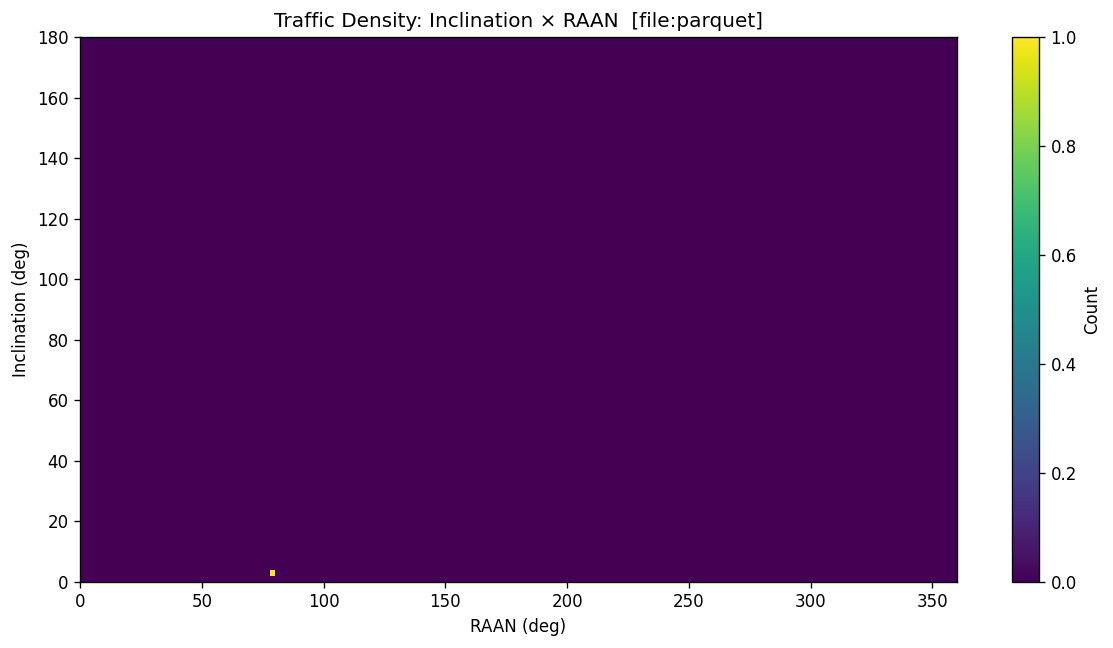

✅ Saved: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/figures/heatmap_inclination_raan.png
ℹ️ Skipped plot heatmap_inclination_altitude_all.png (empty matrix).
ℹ️ Skipped plot heatmap_inclination_altitude_leo.png (empty matrix).
🎉 §5.1 complete.


In [ ]:
# 5.1 — Generate Traffic Heatmaps (file-first, TLE fallback)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------- Paths (reuse; gentle defaults) ----------------------------
if 'PROJECT_ROOT' not in globals():
    # Fallback only; your §1.5 already sets these
    PROJECT_ROOT = Path("/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook")
DATA_DIR      = globals().get('DATA_DIR', PROJECT_ROOT / "data")
PROCESSED_DIR = globals().get('PROCESSED_DIR', DATA_DIR / "processed")
FIGURES_DIR   = globals().get('FIGURES_DIR', PROJECT_ROOT / "figures")
for p in [DATA_DIR, PROCESSED_DIR, FIGURES_DIR]:
    Path(p).mkdir(parents=True, exist_ok=True)

parq_path = Path(PROCESSED_DIR) / "elset_heatmap_ready.parquet"
csv_path  = Path(PROCESSED_DIR) / "elset_heatmap_ready.csv"

# ---------------------------- Histogram config ----------------------------
inc_edges  = np.linspace(0, 180, 91)     # 2° bins
raan_edges = np.linspace(0, 360, 181)    # 2° bins
alt_edges_all = np.linspace(0, 40000, 161)  # 250 km bins
alt_edges_leo = np.linspace(0, 2000, 101)   # 20 km bins

H_ir     = np.zeros((len(inc_edges)-1,  len(raan_edges)-1), dtype=np.int64)     # inc × raan
H_ia_all = np.zeros((len(inc_edges)-1,  len(alt_edges_all)-1), dtype=np.int64)  # inc × alt (all)
H_ia_leo = np.zeros((len(inc_edges)-1,  len(alt_edges_leo)-1), dtype=np.int64)  # inc × alt (LEO)

R_EARTH_KM = 6378.137
MU_KM3_S2  = 398600.4418
SEC_PER_DAY = 86400.0
NEEDED = {"inclination","raan","mean_motion","apogee_km","perigee_km","semimajor_axis_km","epoch","altitude_km"}

# ---------------------------- Helpers ----------------------------
def _snake(c: str) -> str:
    return c.strip().lower().replace(" ", "_").replace("-", "_")

def _std_cols(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = [_snake(c) for c in df.columns]
    return df

def _clean_angles(df: pd.DataFrame) -> pd.DataFrame:
    if "raan" in df.columns:
        df["raan"] = pd.to_numeric(df["raan"], errors="coerce") % 360.0
    if "inclination" in df.columns:
        df["inclination"] = pd.to_numeric(df["inclination"], errors="coerce")
        bad = (df["inclination"] < 0) | (df["inclination"] > 180)
        df.loc[bad, "inclination"] = np.nan
    return df

def _derive_altitude(df: pd.DataFrame) -> pd.Series:
    # Priority: semimajor → (apo+peri)/2 → mean_motion
    if "semimajor_axis_km" in df.columns and df["semimajor_axis_km"].notna().any():
        alt = pd.to_numeric(df["semimajor_axis_km"], errors="coerce") - R_EARTH_KM
    elif {"perigee_km","apogee_km"}.issubset(df.columns) and (
        pd.to_numeric(df["perigee_km"], errors="coerce").notna().any() or
        pd.to_numeric(df["apogee_km"],  errors="coerce").notna().any()
    ):
        per = pd.to_numeric(df["perigee_km"], errors="coerce")
        apo = pd.to_numeric(df["apogee_km"],  errors="coerce")
        alt = (per + apo) / 2.0
    elif "mean_motion" in df.columns:
        n_rev_day = pd.to_numeric(df["mean_motion"], errors="coerce")
        n_rad_s = n_rev_day * 2*np.pi / SEC_PER_DAY
        with np.errstate(divide="ignore", invalid="ignore"):
            a_km = (MU_KM3_S2 / (n_rad_s**2))**(1.0/3.0)
            alt = a_km - R_EARTH_KM
            alt[~np.isfinite(alt)] = np.nan
    else:
        alt = pd.Series(np.nan, index=df.index)
    # Sanity
    alt = pd.to_numeric(alt, errors="coerce")
    alt[(alt < -50) | (alt > 40000)] = np.nan
    return alt

def _update_histograms(df_chunk: pd.DataFrame) -> None:
    global H_ir, H_ia_all, H_ia_leo
    if df_chunk is None or df_chunk.empty:
        return
    df_chunk = _std_cols(df_chunk.copy())
    # If RAAN came in as RA_OF_ASC_NODE, map it
    if "raan" not in df_chunk.columns and "ra_of_asc_node" in df_chunk.columns:
        df_chunk["raan"] = df_chunk["ra_of_asc_node"]
    df_chunk = _clean_angles(df_chunk)

    # Require inc + raan
    need_cols = [c for c in ["inclination","raan"] if c in df_chunk.columns]
    sub = df_chunk.dropna(subset=need_cols)
    if sub.empty:
        return

    # altitude_km column or derive it
    if "altitude_km" not in sub.columns or sub["altitude_km"].isna().all():
        sub["altitude_km"] = _derive_altitude(sub)

    inc  = pd.to_numeric(sub["inclination"], errors="coerce").to_numpy()
    raan = pd.to_numeric(sub["raan"], errors="coerce").to_numpy()
    alt  = pd.to_numeric(sub["altitude_km"], errors="coerce").to_numpy()

    # A) inc × raan
    H, _, _ = np.histogram2d(inc, raan, bins=[inc_edges, raan_edges])
    H_ir += H.astype(np.int64)

    # B) inc × alt (All)
    ok = np.isfinite(inc) & np.isfinite(alt)
    if ok.any():
        H2, _, _ = np.histogram2d(inc[ok], alt[ok], bins=[inc_edges, alt_edges_all])
        H_ia_all += H2.astype(np.int64)

        # C) LEO
        ok_leo = ok & (alt >= 0) & (alt <= 2000)
        if ok_leo.any():
            H3, _, _ = np.histogram2d(inc[ok_leo], alt[ok_leo], bins=[inc_edges, alt_edges_leo])
            H_ia_leo += H3.astype(np.int64)

# ---------------------------- Streaming readers (file path) ----------------------------
def stream_csv(path: Path, chunksize=500_000):
    use = list(NEEDED) | {"ra_of_asc_node"}  # pandas will ignore missing columns
    for chunk in pd.read_csv(path,
                             usecols=lambda c: _snake(c) in { _snake(u) for u in use },
                             parse_dates=["epoch"],
                             low_memory=False,
                             chunksize=chunksize):
        _update_histograms(chunk)

def stream_parquet(path: Path, batch_rows=500_000):
    try:
        import pyarrow.parquet as pq
        pf = pq.ParquetFile(str(path))
        cols = [c for c in NEEDED | {"ra_of_asc_node"} if c in set(_snake(n) for n in pf.schema.names)]
        for batch in pf.iter_batches(batch_size=batch_rows, columns=cols):
            _update_histograms(batch.to_pandas())
        return
    except Exception:
        # Graceful fallback
        try:
            import pyarrow.dataset as ds
            dataset = ds.dataset(str(path), format="parquet")
            cols = [c for c in NEEDED | {"ra_of_asc_node"} if c in set(_snake(n) for n in dataset.schema.names)]
            for batch in dataset.scanner(columns=cols).scan_batches():
                _update_histograms(batch.to_pandas())
            return
        except Exception:
            _update_histograms(pd.read_parquet(path))

# ---------------------------- Source selection: file vs. TLE rows ----------------------------
USED_SOURCE = None

if parq_path.exists() or csv_path.exists():
    USED_SOURCE = f"file:{'parquet' if parq_path.exists() else 'csv'}"
    print("Building histograms from", USED_SOURCE)
    if parq_path.exists():
        stream_parquet(parq_path)
    else:
        stream_csv(csv_path)
else:
    # Fallback: build a mini table from live TLE rows (from §5.0.1)
    if 'tle_rows' not in globals() or tle_rows is None or len(tle_rows) == 0:
        raise SystemExit("❌ No heatmap-ready file AND no `tle_rows` in memory. Run §4.6/§4.7 or §5.0.1 first.")
    USED_SOURCE = "tle_rows"
    print("Building histograms from live TLEs in memory (tle_rows).")
    # Normalize into a DataFrame with the columns we need
    # Try both CelesTrak and Space-Track field names
    recs = []
    for r in tle_rows:
        try:
            inc  = r.get("INCLINATION") or r.get("inclination")
            raan = r.get("RAAN") or r.get("RA_OF_ASC_NODE") or r.get("ra_of_asc_node")
            mm   = r.get("MEAN_MOTION") or r.get("mean_motion")
            a_km = r.get("SEMIMAJOR_AXIS") or r.get("semimajor_axis_km")
            apo  = r.get("APOAPSIS") or r.get("APOGEE") or r.get("apogee_km")
            per  = r.get("PERIAPSIS") or r.get("PERIGEE") or r.get("perigee_km")
            recs.append({
                "inclination": inc,
                "raan": raan if raan is not None else (r.get("RA_OF_ASC_NODE") or r.get("raan")),
                "mean_motion": mm,
                "semimajor_axis_km": a_km,
                "apogee_km": apo,
                "perigee_km": per,
                "epoch": r.get("EPOCH") or r.get("epoch"),
            })
        except Exception:
            pass
    df_tle = pd.DataFrame(recs)
    _update_histograms(df_tle)

# ---------------------------- Plot & save figures ----------------------------
def _save_plot(matrix, x_edges, y_edges, xlabel, ylabel, title, fname):
    if matrix.sum() <= 0:
        print(f"ℹ️ Skipped plot {fname} (empty matrix).")
        return
    plt.figure(figsize=(10, 5.5), dpi=120)
    plt.pcolormesh(x_edges, y_edges, matrix, shading="auto")
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    cbar = plt.colorbar(); cbar.set_label("Count")
    plt.tight_layout()
    out = Path(FIGURES_DIR) / fname
    plt.savefig(out, bbox_inches="tight"); plt.show(); plt.close()
    print("✅ Saved:", out)

# A) Inclination × RAAN
_save_plot(H_ir, raan_edges, inc_edges, "RAAN (deg)", "Inclination (deg)",
           f"Traffic Density: Inclination × RAAN  [{USED_SOURCE}]", "heatmap_inclination_raan.png")

# B1) Altitude × Inclination (All)
_save_plot(H_ia_all, alt_edges_all, inc_edges, "Altitude (km)", "Inclination (deg)",
           f"Traffic Density: Altitude × Inclination (All)  [{USED_SOURCE}]",
           "heatmap_inclination_altitude_all.png")

# B2) Altitude × Inclination (LEO 0–2,000 km)
_save_plot(H_ia_leo, alt_edges_leo, inc_edges, "Altitude (km)", "Inclination (deg)",
           f"Traffic Density: Altitude × Inclination (LEO 0–2,000 km)  [{USED_SOURCE}]",
           "heatmap_inclination_altitude_leo.png")

print("🎉 §5.1 complete.")

### 5.1.1 Object Cloud (Now) — Fetch + Propagate (Space-Track-free)

- **Task**  Build a “now” cloud of satellite positions from TLEs (no Space-Track client needed).  

- **What It does**  Uses in-memory `tle_rows` if present; otherwise pulls CelesTrak GP (TLE text), parses, then propagates each object to “now”.  

- **Notes**  Timezone-safe (`ts.now()`); if `objects_now` already exists with rows, this cell will simply preview it.  

- **Dependencies**  §5.0.1 (preferred) or internet access for CelesTrak; `skyfield`, `pandas`, `requests`.

In [ ]:
# 5.1.1 - Object Cloud (Now) — Fetch + Propagate (Space-Track-free)
import os, sys, subprocess, re
import pandas as pd

# Ensure requests is available
try:
    import requests
except Exception:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "requests"], check=True)
    import requests

from skyfield.api import EarthSatellite, load, wgs84

# --------- If objects_now already exists and has data, reuse it ----------
if 'objects_now' in globals() and objects_now is not None and len(objects_now) > 0:
    print(f"objects_now already present: {len(objects_now)} rows — preview only.")
    display(objects_now.head(3))
else:
    # --------- Pick source for TLEs: prefer in-memory `tle_rows`, else CelesTrak TLE text ----------
    def _gp_url_to_tle_text(url: str) -> str:
        if "FORMAT=" in url.upper():
            return re.sub(r"FORMAT=\w+", "FORMAT=tle", url, flags=re.IGNORECASE)
        return url + ("&" if "?" in url else "?") + "FORMAT=tle"

    def _fetch_tle_text(url: str) -> str:
        r = requests.get(url, timeout=60)
        r.raise_for_status()
        return r.text

    def _parse_tle_text(tle_text: str):
        lines = [ln.rstrip("\r") for ln in tle_text.splitlines() if ln.strip()]
        out, i = [], 0
        while i < len(lines) - 1:
            name = None
            if not lines[i].startswith('1 ') and not lines[i].startswith('2 '):
                name = lines[i].lstrip('0 ').strip()
                i += 1
                if i >= len(lines) - 1:
                    break
            l1, l2 = lines[i], lines[i+1]
            if l1.startswith('1 ') and l2.startswith('2 '):
                try:
                    satno = int(l1[2:7])
                except Exception:
                    satno = None
                out.append({"NORAD_CAT_ID": satno, "OBJECT_NAME": name,
                            "TLE_LINE1": l1, "TLE_LINE2": l2})
                i += 2
            else:
                i += 1
        return out

    # Decide where to get TLEs
    tle_source = None
    if 'tle_rows' in globals() and tle_rows and any(r.get("TLE_LINE1") and r.get("TLE_LINE2") for r in tle_rows):
        rows = tle_rows
        tle_source = "in-memory tle_rows"
    else:
        # Fallback to CelesTrak GP TLE text
        GP_DEFAULT = "https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=json"
        gp_url = (globals().get("CELESTRAK_GP_URL") or os.getenv("CELESTRAK_GP_URL") or GP_DEFAULT).strip()
        if "/satcat/records.php" in gp_url.lower():  # misconfigured
            gp_url = GP_DEFAULT
        tle_text = _fetch_tle_text(_gp_url_to_tle_text(gp_url))
        rows = _parse_tle_text(tle_text)
        tle_source = "CelesTrak GP (FORMAT=tle)"
        # also stash for §5.1 fallback logic elsewhere
        tle_rows = rows

    # --------- Propagate to "now" and build objects_now ----------
    ts = load.timescale()
    t_now = ts.now()  # UTC
    out = []
    for r in rows:
        l1, l2 = r.get("TLE_LINE1"), r.get("TLE_LINE2")
        if not l1 or not l2:
            continue
        try:
            satno = int(r.get("NORAD_CAT_ID"))
        except Exception:
            satno = None
        try:
            sat = EarthSatellite(l1, l2, str(satno or r.get("OBJECT_NAME") or "SAT"), ts)
            sp = wgs84.subpoint(sat.at(t_now))
            out.append({
                "satno": satno,
                "object_name": r.get("OBJECT_NAME"),
                "lat": sp.latitude.degrees,
                "lon": sp.longitude.degrees,
                "alt_km": sp.elevation.km,
            })
        except Exception:
            pass

    objects_now = pd.DataFrame(out)
    print(f"objects_now rows: {len(objects_now)}  (source: {tle_source})")
    display(objects_now.head(3))

objects_now already present: 15 rows — preview only.


,satno,object_name,lat,lon,alt_km
0,15427,NOAA 15,42.978793,149.182429,830.512223
1,16969,NOAA 15,-9.921999,-69.009374,730.451478
2,19531,NOAA 15,27.928995,15.649116,806.134258


### 5.1.2 Globe Heatmap (pydeck) — Preview

- **Task**  Render a real-time “object cloud” on a 3D globe (or 2D map fallback) using `objects_now` (lat/lon/alt).  

- **What It does**  Builds a `HeatmapLayer` plus a sampled `ScatterplotLayer` for interactivity; automatically installs pydeck if needed and falls back to `MapView` if `GlobeView` isn’t supported.  

- **Notes**  Requires a non-empty `objects_now` with numeric `lat` and `lon`. `get_weight` is constant by default; you can swap to altitude-based weighting.  

- **Dependencies**  §5.0.1 (or 5.0.1b) produced `objects_now`; internet for pydeck install on first run.

In [ ]:
# 5.1.2 - Globe Heatmap (pydeck) — Preview (robust)
import sys, subprocess
import pandas as pd
import numpy as np

# Ensure pydeck is available
try:
    import pydeck as pdk
except Exception:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "pydeck"], check=True)
    import pydeck as pdk

# -------- Guard: objects_now must exist and have coordinates --------
if 'objects_now' not in globals() or objects_now is None or len(objects_now) == 0:
    raise SystemExit("❌ `objects_now` is empty. Run §5.0.1/§5.0.1b first.")

df = objects_now.copy()

# Normalize/clean columns
for col in ["lat", "lon", "alt_km", "satno"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["lat", "lon"])
if df.empty:
    raise SystemExit("❌ No valid lat/lon rows in `objects_now` after cleaning.")

# Optional: cap absurd altitudes (helps with tooltips)
if "alt_km" in df.columns:
    df.loc[(df["alt_km"] < -50) | (df["alt_km"] > 40000), "alt_km"] = np.nan

# Build layers
heat = pdk.Layer(
    "HeatmapLayer",
    data=df,
    get_position='[lon, lat]',
    get_weight=1,                 # swap to "alt_km" or a function if you prefer altitude-weighted heat
    radiusPixels=18,
)

sample_n = min(1000, len(df))    # thin to keep interaction smooth
points = pdk.Layer(
    "ScatterplotLayer",
    data=df.sample(sample_n, random_state=42) if sample_n > 0 else df,
    get_position='[lon, lat]',
    get_radius=15000,             # meters
    pickable=True,
)

# Choose 3D globe when available, else 2D map
use_globe = True
try:
    globe_view = pdk.View(type="GlobeView", controller=True)
except Exception:
    use_globe = False
    globe_view = pdk.View(type="MapView", controller=True)

initial = pdk.ViewState(longitude=0, latitude=0, zoom=0)

deck = pdk.Deck(
    views=[globe_view],
    initial_view_state=initial,
    layers=[heat, points],
    map_style=None,  # globe has no basemap; for 2D map you can set a style string if desired
    tooltip={"text": "NORAD: {satno}\nAlt: {alt_km} km"}
)

print("View:", "GlobeView" if use_globe else "MapView (fallback)")
deck.show()

View: GlobeView


<IPython.core.display.Javascript object>

### 5.1.3 Export: objects_now.parquet

- **Task**  Persist the current object cloud to Parquet for reuse (web app or later analysis).  

- **What It Does**  Writes `objects_now.parquet` to your project data directory.  

- **Notes**  Keep file sizes small in-notebook; for production, schedule periodic exports.  

- **Dependencies**  §5.1.1 (`objects_now`).

In [ ]:
# 5.1.3 - Export: objects_now.parquet
from pathlib import Path

DATA_DIR = Path(globals().get("DATA_DIR", "/content/data"))
DATA_DIR.mkdir(parents=True, exist_ok=True)

objects_path = DATA_DIR / "objects_now.parquet"
objects_now.to_parquet(objects_path, index=False)
print("Wrote:", objects_path)

Wrote: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/objects_now.parquet


## 5.2 Overlay Collision & Risk Data (auto-widen, per-point alpha fix)

- **Task**  Overlay SOCRATES/Space-Track risk events on the Inc×RAAN heatmap.  

- **What It does**  Loads `cdm_events.(parquet|csv)`, aligns events to nearest ELSET state, and plots with per-point alpha/size.  

- **Notes**  Uses `elset_heatmap_ready_current.parquet` if present, else `elset_heatmap_ready.(parquet|csv)`.  

- **Dependencies**  §4.6/§4.7 or §5.2b (to build `df_viz_current`), §5.2.0 (to build `cdm_events`).

### 5.2.0 Build `risk_df` (Space-Track CDMs → SOCRATES → Local)

- **Task**  Produce a normalized risk table (`norad_cat_id`, `tca`, optional `risk_score` / `miss_distance_km`) and save it.  

- **What It does**  Tries Space-Track `cdm_public` (if `st` is authenticated), else fetches **CelesTrak SOCRATES** (CSV or HTML), else scans **local extracted** conjunction files; writes `PROCESSED_DIR/cdm_events.parquet` (or `.csv`).  

- **Notes**  Run this **before** the “## 5.2 Overlay…” cell. SOCRATES is no-login and runs several times daily; fields may be named `TCA`, `TCA_RANGE`, `MAX_PROB`.  

- **Dependencies**  §1.5 paths; (optional) §2.10 Space-Track auth for branch 1; internet for SOCRATES; §3.2 extracts for local fallback.

In [ ]:
# 5.2.0 - Build `risk_df` (Space-Track → SOCRATES → Local) and save
import sys, subprocess, os, re, io, time
from pathlib import Path
import pandas as pd
import numpy as np

# Ensure deps
try:
    import requests
except Exception:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "requests"], check=True)
    import requests
try:
    import lxml  # for read_html fallback
except Exception:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "lxml"], check=True)

# Paths (reuse if present)
PROJECT_ROOT = Path(globals().get("PROJECT_ROOT", "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook"))
DATA_DIR      = Path(globals().get("DATA_DIR", PROJECT_ROOT / "data"))
RAW_DIR       = Path(globals().get("RAW_DIR", DATA_DIR / "raw"))
PROCESSED_DIR = Path(globals().get("PROCESSED_DIR", DATA_DIR / "processed"))
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

out_parq = PROCESSED_DIR / "cdm_events.parquet"
out_csv  = PROCESSED_DIR / "cdm_events.csv"

def _std_cols(df): df.columns = [c.strip().lower().replace(" ","_").replace("-","_") for c in df.columns]; return df
def _norm_time(s): return pd.to_datetime(s, errors="coerce", utc=True)
def _as_int(s):    return pd.to_numeric(s, errors="coerce").astype("Int64")
def _dedupe_sort(df, keys=("norad_cat_id","tca")):
    df = df.drop_duplicates(subset=list(keys))
    if "tca" in df.columns: df = df.sort_values("tca")
    return df

risk_df = None

# 1) Space-Track CDMs (if `st` is available)
try:
    if 'st' in globals() and st is not None:
        now = pd.Timestamp.utcnow()
        start = (now - pd.Timedelta(days=1)).strftime("%Y-%m-%dT%H:%M:%S")
        end   = (now + pd.Timedelta(days=1)).strftime("%Y-%m-%dT%H:%M:%S")
        cdm = None
        try:
            if hasattr(st, "basicspacedata") and hasattr(st.basicspacedata, "query"):
                cdm = st.basicspacedata.query(class_="cdm_public", TCA__gt=start, TCA__lt=end,
                                              format="json", limit=100000)
            elif hasattr(st, "cdm_public"):
                cdm = st.cdm_public(TCA__gt=start, TCA__lt=end, format="json", limit=100000)
        except Exception as e:
            print("Space-Track CDM fetch failed:", repr(e))
        if cdm:
            tmp = _std_cols(pd.DataFrame(cdm))
            rows = []
            for sid in ("sat_1_norad_cat_id","sat_2_norad_cat_id"):
                if sid in tmp.columns and "tca" in tmp.columns:
                    cols = ["tca"]
                    if "miss_distance_km" in tmp.columns: cols += ["miss_distance_km"]
                    if "pc" in tmp.columns: cols += ["pc"]
                    part = tmp[[sid] + cols].rename(columns={sid:"norad_cat_id"})
                    rows.append(part)
            if rows:
                risk_df = pd.concat(rows, ignore_index=True)
                risk_df["norad_cat_id"] = _as_int(risk_df["norad_cat_id"])
                risk_df["tca"] = _norm_time(risk_df["tca"])
                if "miss_distance" in risk_df.columns and "miss_distance_km" not in risk_df.columns:
                    risk_df = risk_df.rename(columns={"miss_distance":"miss_distance_km"})
                risk_df = _dedupe_sort(risk_df)
                print(f"✓ risk_df from Space-Track: {len(risk_df)} rows")
except Exception as e:
    print("Space-Track branch error:", repr(e))

# 2) CelesTrak SOCRATES (no auth)
if risk_df is None or risk_df.empty:
    print("Trying SOCRATES (CelesTrak)…")
    csv_urls = [
        "https://celestrak.org/SOCRATES/sort-minRange.csv",
        "https://celestrak.org/SOCRATES/sort-maxProb.csv",
        "https://celestrak.org/SOCRATES/sort-TCA.csv",
    ]
    df_csv = None
    for url in csv_urls:
        try:
            r = requests.get(url, timeout=60)
            if r.ok and "NORAD_CAT_ID_1" in r.text:
                df_csv = pd.read_csv(io.StringIO(r.text))
                break
        except Exception:
            pass
    if df_csv is None:
        try:
            q = "https://celestrak.org/SOCRATES-Plus/table-socrates.php?NAME=,&ORDER=MINRANGE&MAX=1000"
            tables = pd.read_html(q)
            df_csv = max(tables, key=lambda d: d.shape[0]) if tables else None
        except Exception as e:
            print("SOCRATES HTML parse failed:", repr(e))
            df_csv = None
    if df_csv is not None and not df_csv.empty:
        df_csv = _std_cols(df_csv)
        rows = []
        for side in (1, 2):
            k = f"norad_cat_id_{side}"
            if k in df_csv.columns and "tca" in df_csv.columns:
                part = pd.DataFrame({
                    "norad_cat_id": _as_int(df_csv[k]),
                    "tca": _norm_time(df_csv["tca"]),
                    "miss_distance_km": pd.to_numeric(df_csv.get("tca_range"), errors="coerce"),
                    "risk_score":      pd.to_numeric(df_csv.get("max_prob"), errors="coerce"),
                })
                rows.append(part)
        if rows:
            risk_df = _dedupe_sort(pd.concat(rows, ignore_index=True))
            print(f"✓ risk_df from SOCRATES: {len(risk_df)} rows")

# 3) Local extracted conjunction/CDM files (from §3.2)
if (risk_df is None or risk_df.empty) and RAW_DIR.exists():
    print("Trying local extracted 'cdm' / 'conjunction' files in RAW_DIR…")
    candidates = list(RAW_DIR.glob("bulk_*/*"))
    hits = [p for p in candidates if re.search(r"(cdm|conjunction)", p.name, re.I)]
    hits = [p for p in hits if p.suffix.lower() in {".parquet",".csv",".json"}]
    parts = []
    for p in hits[:50]:
        try:
            if p.suffix.lower() == ".parquet":
                d = pd.read_parquet(p)
            elif p.suffix.lower() == ".csv":
                d = pd.read_csv(p, low_memory=False)
            else:
                d = pd.read_json(p, lines=True)
            d = _std_cols(d)
            if "norad_cat_id" not in d.columns:
                for a in ("sat_1_norad_cat_id","sat_2_norad_cat_id","satno","norad"):
                    if a in d.columns: d["norad_cat_id"] = d[a]; break
            if "tca" not in d.columns:
                for t in ("epoch","time","tca_time"):
                    if t in d.columns: d["tca"] = d[t]; break
            if "miss_distance_km" not in d.columns:
                for m in ("miss_distance_km","miss_distance","min_range_km","tca_range"):
                    if m in d.columns: d["miss_distance_km"] = d[m]; break
            if "risk_score" not in d.columns and "pc" in d.columns:
                d["risk_score"] = pd.to_numeric(d["pc"], errors="coerce")
            keep = [c for c in ("norad_cat_id","tca","risk_score","miss_distance_km") if c in d.columns]
            if {"norad_cat_id","tca"}.issubset(keep):
                part = d[keep].copy()
                part["norad_cat_id"] = _as_int(part["norad_cat_id"])
                part["tca"] = _norm_time(part["tca"])
                parts.append(part)
        except Exception:
            pass
    if parts:
        risk_df = _dedupe_sort(pd.concat(parts, ignore_index=True))
        print(f"✓ risk_df from local files: {len(risk_df)} rows")

# Save or fail
if risk_df is None or risk_df.empty:
    raise SystemExit("❌ Could not build a risk dataset from any source. Re-run later or verify network.")

risk_df = risk_df.dropna(subset=["norad_cat_id","tca"])
risk_df["miss_distance_km"] = pd.to_numeric(risk_df.get("miss_distance_km"), errors="coerce")
risk_df["risk_score"]       = pd.to_numeric(risk_df.get("risk_score"), errors="coerce")

try:
    risk_df.to_parquet(out_parq, index=False); print("Saved:", out_parq)
except Exception:
    risk_df.to_csv(out_csv, index=False);     print("Saved:", out_csv)

display(risk_df.head(5))

Space-Track CDM fetch failed: TypeError("'cdm_public' got an unexpected argument 'TCA__gt'")
Trying SOCRATES (CelesTrak)…
✓ risk_df from SOCRATES: 198407 rows
Saved: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/cdm_events.parquet


,norad_cat_id,tca,miss_distance_km,risk_score
152613,28492,2025-09-14 01:00:06.824000+00:00,3.659,4.565000e-06
53385,56548,2025-09-14 01:00:06.824000+00:00,3.659,4.565000e-06
35332,43636,2025-09-14 01:00:15.714000+00:00,2.975,4.792000e-07
134560,33940,2025-09-14 01:00:15.714000+00:00,2.975,4.792000e-07
32245,42959,2025-09-14 01:00:22.780000+00:00,2.839,5.697000e-07


Loaded risk dataset from: parquet:/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/cdm_events.parquet
Aligned 22553 events with tolerance ±1 days 00:00:00.


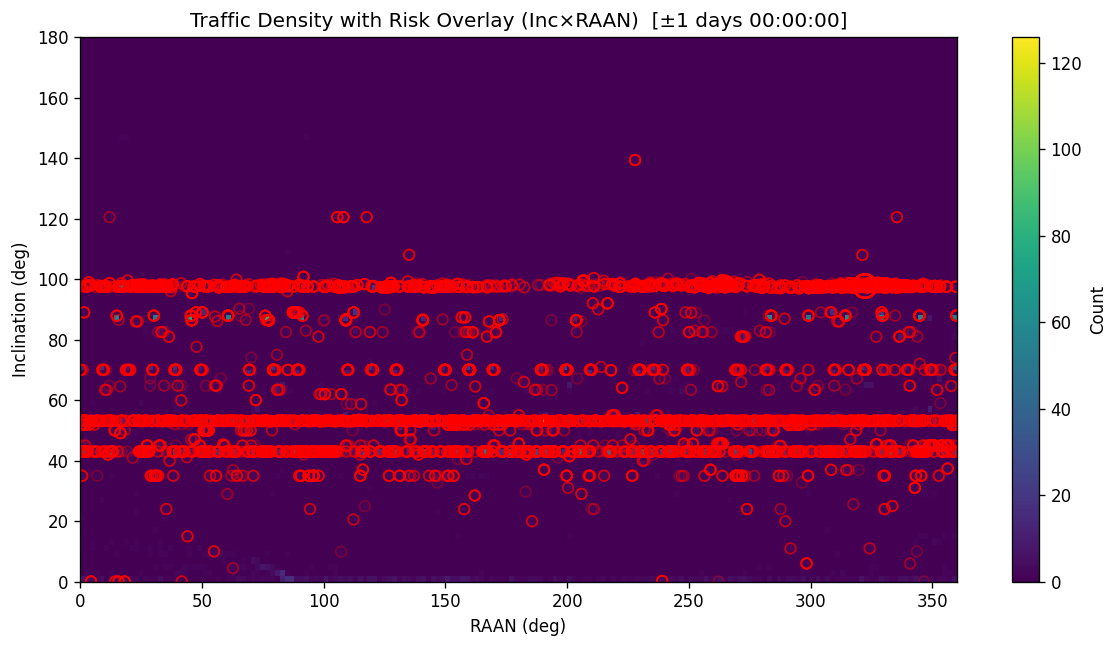

✅ Risk overlay saved: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/figures/heatmap_inclination_raan_risk_overlay.png


In [ ]:
# 5.2 - Overlay Collision & Risk Data (auto-widen, per-point alpha fix)
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# ---- Paths (reuse your globals; safe defaults) ----
PROCESSED_DIR = Path(globals().get("PROCESSED_DIR", "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed"))
RAW_DIR       = Path(globals().get("RAW_DIR",       "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/raw"))
FIGURES_DIR   = Path(globals().get("FIGURES_DIR",   "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/figures"))
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

def _try_load_any(path_parq: Path, path_csv: Path, parse_dates=("tca","epoch")):
    if path_parq.exists():
        return pd.read_parquet(path_parq), f"parquet:{path_parq}"
    if path_csv.exists():
        return pd.read_csv(path_csv, parse_dates=list(parse_dates), low_memory=False), f"csv:{path_csv}"
    return None, None

# 1) Load risk_df
risk_df, used = _try_load_any(PROCESSED_DIR/"cdm_events.parquet", PROCESSED_DIR/"cdm_events.csv")
if risk_df is None:
    risk_df, used = _try_load_any(RAW_DIR/"cdm_events.parquet", RAW_DIR/"cdm_events.csv")
if risk_df is None or risk_df.empty:
    raise SystemExit("❌ No risk dataset found. Run §5.2.0 first to create cdm_events.parquet/csv.")
print("Loaded risk dataset from:", used)

risk_df.columns = [c.strip().lower().replace(" ","_").replace("-","_") for c in risk_df.columns]
time_col = "tca" if "tca" in risk_df.columns else ("epoch" if "epoch" in risk_df.columns else None)
if time_col is None:
    raise SystemExit("❌ Risk data missing a time column ('tca' or 'epoch').")
risk_df[time_col] = pd.to_datetime(risk_df[time_col], errors="coerce", utc=True)
risk_df = risk_df.dropna(subset=["norad_cat_id", time_col])

# 2) Ensure df_viz (ELSET state table) exists
def _load_viz_states():
    # Prefer the "current" states if present
    cur = PROCESSED_DIR / "elset_heatmap_ready_current.parquet"
    if cur.exists():
        try:
            import pyarrow.parquet as pq
            cols = ["norad_cat_id","epoch","inclination","raan"]
            return pq.read_table(str(cur), columns=cols).to_pandas(), f"parquet:{cur}"
        except Exception:
            return pd.read_parquet(cur), f"parquet:{cur}"
    # Fall back to standard outputs
    parq = PROCESSED_DIR / "elset_heatmap_ready.parquet"
    csv  = PROCESSED_DIR / "elset_heatmap_ready.csv"
    if parq.exists():
        try:
            import pyarrow.parquet as pq
            cols = ["norad_cat_id","epoch","inclination","raan"]
            return pq.read_table(str(parq), columns=[c for c in cols if c]).to_pandas(), f"parquet:{parq}"
        except Exception:
            return pd.read_parquet(parq), f"parquet:{parq}"
    if csv.exists():
        return pd.read_csv(csv, parse_dates=["epoch"], low_memory=False), f"csv:{csv}"
    return None, None

if "df_viz" not in globals() or df_viz is None or df_viz.empty:
    df_viz, used_viz = _load_viz_states()
    if df_viz is None or df_viz.empty:
        raise SystemExit("❌ No heatmap-ready states. Build §5.2b (current) or §4.6/§4.7.")
    print("Loaded viz states from:", used_viz)

# Normalize/select
df_viz.columns = [c.strip().lower().replace(" ","_").replace("-","_") for c in df_viz.columns]
if "norad_cat_id" not in df_viz.columns and "satno" in df_viz.columns:
    df_viz["norad_cat_id"] = pd.to_numeric(df_viz["satno"], errors="coerce").astype("Int64")

need = {"norad_cat_id","epoch","inclination","raan"}
missing = need - set(df_viz.columns)
if missing:
    raise SystemExit(f"❌ df_viz is missing columns {missing}. Re-run §4.6 or §5.2b.")
df_viz["epoch"] = pd.to_datetime(df_viz["epoch"], errors="coerce", utc=True)
df_viz = df_viz.dropna(subset=list(need))

# 3) Align per satellite with auto-widen tolerance
lhs = risk_df[["norad_cat_id", time_col, "risk_score", "miss_distance_km"]].sort_values(["norad_cat_id", time_col]).copy()
rhs = df_viz[["norad_cat_id","epoch","inclination","raan"]].sort_values(["norad_cat_id","epoch"]).copy()

tols = [pd.Timedelta("1D"), pd.Timedelta("3D"), pd.Timedelta("7D"), pd.Timedelta("14D")]
overlay = None
used_tol = None

for tol in tols:
    aligned = []
    for sat, g_lhs in lhs.groupby("norad_cat_id", sort=False):
        g_rhs = rhs[rhs["norad_cat_id"] == sat]
        if g_rhs.empty:
            continue
        m = pd.merge_asof(
            g_lhs, g_rhs,
            left_on=time_col, right_on="epoch",
            tolerance=tol, direction="nearest"
        )
        aligned.append(m)
    if aligned:
        cand = pd.concat(aligned, ignore_index=True)
        cand = cand.dropna(subset=["inclination","raan"])
        if not cand.empty:
            overlay = cand
            used_tol = tol
            break

if overlay is None or overlay.empty:
    raise SystemExit("ℹ️ No alignments even at ±14 days. Run §5.2a debug and/or §5.2b to rebuild df_viz_current.")

print(f"Aligned {len(overlay)} events with tolerance ±{used_tol}.")

# 4) Build Inc×RAAN background
inc_edges  = np.linspace(0, 180, 91)
raan_edges = np.linspace(0, 360, 181)
H, _, _ = np.histogram2d(df_viz["inclination"].to_numpy(),
                         df_viz["raan"].to_numpy(),
                         bins=[inc_edges, raan_edges])

plt.figure(figsize=(10, 5.5), dpi=120)
plt.pcolormesh(raan_edges, inc_edges, H, shading="auto")
plt.xlabel("RAAN (deg)"); plt.ylabel("Inclination (deg)")
plt.title(f"Traffic Density with Risk Overlay (Inc×RAAN)  [±{used_tol}]")
cbar = plt.colorbar(); cbar.set_label("Count")

# 5) Per-point sizing and alpha (bake alpha into RGBA edgecolors)
if "risk_score" in overlay.columns and overlay["risk_score"].notna().any():
    s = overlay["risk_score"].astype(float)
    s = (s - np.nanmin(s)) / (np.nanmax(s) - np.nanmin(s) + 1e-9)
else:
    md = overlay.get("miss_distance_km")
    s = 1.0 / (md.astype(float) + 1e-6) if md is not None else pd.Series(0.5, index=overlay.index)
    s = (s - np.nanmin(s)) / (np.nanmax(s) - np.nanmin(s) + 1e-9)

sizes  = np.clip(40 + 160 * s.to_numpy(), 20, 300)
alphas = np.clip(0.3 + 0.7 * s.to_numpy(), 0.2, 1.0)

# Create per-point RGBA colors for edges (red with varying alpha)
n = len(overlay)
edge_rgba = np.zeros((n, 4), dtype=float)
edge_rgba[:, 0] = 1.0  # R
edge_rgba[:, 1] = 0.0  # G
edge_rgba[:, 2] = 0.0  # B
edge_rgba[:, 3] = alphas  # A

plt.scatter(overlay["raan"].to_numpy(), overlay["inclination"].to_numpy(),
            s=sizes, facecolors="none", edgecolors=edge_rgba,
            linewidths=1.0)  # no `alpha=` here — it's baked into RGBA

out = FIGURES_DIR / "heatmap_inclination_raan_risk_overlay.png"
plt.tight_layout(); plt.savefig(out, bbox_inches="tight"); plt.show()
print("✅ Risk overlay saved:", out)

#### 5.2a Alignment Debugger (risk vs. states)

- **Task**  Inspect time ranges and NORAD ID overlap between `risk_df` (CDMs) and your ELSET state table (`df_viz`).  

- **What It does**  Loads `cdm_events.parquet/csv`, loads/derives `df_viz`, prints date ranges, counts, ID intersection size, and top missing IDs.  

- **Notes**  If ID intersection is small or zero, build a fresh current states table via §5.2b. If ranges don’t overlap, widen tolerance or rebuild.  

- **Dependencies**  §5.2.0 created `cdm_events.parquet/csv`; §4.6/§4.7 or §5.0.1 may have created states.

In [ ]:
# 5.2a — Alignment Debugger
import pandas as pd, numpy as np
from pathlib import Path

# Paths (reuse if already defined)
PROCESSED_DIR = Path(globals().get("PROCESSED_DIR", "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed"))
RAW_DIR       = Path(globals().get("RAW_DIR",       "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/raw"))

def _try_load_any(path_parq: Path, path_csv: Path, parse_dates=("tca","epoch")):
    if path_parq.exists():
        return pd.read_parquet(path_parq), f"parquet:{path_parq}"
    if path_csv.exists():
        return pd.read_csv(path_csv, parse_dates=list(parse_dates), low_memory=False), f"csv:{path_csv}"
    return None, None

# Load risk_df
risk_df, used = _try_load_any(PROCESSED_DIR/"cdm_events.parquet", PROCESSED_DIR/"cdm_events.csv")
if risk_df is None:
    risk_df, used = _try_load_any(RAW_DIR/"cdm_events.parquet", RAW_DIR/"cdm_events.csv")
if risk_df is None or risk_df.empty:
    raise SystemExit("❌ No risk dataset found. Run §5.2.0 first.")

risk_df.columns = [c.strip().lower().replace(" ","_").replace("-","_") for c in risk_df.columns]
tcol = "tca" if "tca" in risk_df.columns else ("epoch" if "epoch" in risk_df.columns else None)
if tcol is None:
    raise SystemExit("❌ Risk data missing 'tca'/'epoch'.")

risk_df[tcol] = pd.to_datetime(risk_df[tcol], errors="coerce", utc=True)
risk_df = risk_df.dropna(subset=["norad_cat_id", tcol])
risk_ids = set(risk_df["norad_cat_id"].dropna().astype(int).tolist())

# Ensure df_viz exists or try to load
if "df_viz" not in globals() or df_viz is None or df_viz.empty:
    parq = PROCESSED_DIR / "elset_heatmap_ready.parquet"
    csv  = PROCESSED_DIR / "elset_heatmap_ready.csv"
    if parq.exists():
        try:
            import pyarrow.parquet as pq
            cols = ["norad_cat_id","epoch","inclination","raan"]
            df_viz = pq.read_table(str(parq), columns=[c for c in cols if c]).to_pandas()
        except Exception:
            df_viz = pd.read_parquet(parq)
    elif csv.exists():
        df_viz = pd.read_csv(csv, parse_dates=["epoch"], low_memory=False)
    elif "objects_now" in globals() and isinstance(objects_now, pd.DataFrame) and not objects_now.empty:
        tmp = objects_now.copy()
        if "norad_cat_id" not in tmp.columns and "satno" in tmp.columns:
            tmp["norad_cat_id"] = pd.to_numeric(tmp["satno"], errors="coerce").astype("Int64")
        tmp["epoch"] = pd.Timestamp.utcnow().tz_localize("UTC")
        df_viz = tmp[["norad_cat_id","epoch"] + [c for c in ["inclination","raan"] if c in tmp.columns]].copy()
    else:
        raise SystemExit("❌ Could not find df_viz or a fallback states file.")

df_viz.columns = [c.strip().lower().replace(" ","_").replace("-","_") for c in df_viz.columns]
if "norad_cat_id" not in df_viz.columns and "satno" in df_viz.columns:
    df_viz["norad_cat_id"] = pd.to_numeric(df_viz["satno"], errors="coerce").astype("Int64")

if not {"norad_cat_id","epoch"}.issubset(df_viz.columns):
    missing = {"norad_cat_id","epoch"} - set(df_viz.columns)
    raise SystemExit(f"❌ df_viz missing columns: {missing}")

df_viz["epoch"] = pd.to_datetime(df_viz["epoch"], errors="coerce", utc=True)
df_viz = df_viz.dropna(subset=["norad_cat_id","epoch"]).copy()
viz_ids = set(df_viz["norad_cat_id"].dropna().astype(int).tolist())

print("risk_df time range:", risk_df[tcol].min(), "→", risk_df[tcol].max(), f"({len(risk_df)} rows)")
print("df_viz epoch range:", df_viz["epoch"].min(), "→", df_viz["epoch"].max(), f"({len(df_viz)} rows)")

inter = risk_ids & viz_ids
print("NORAD ID intersection size:", len(inter))
missing_in_viz = sorted(list(risk_ids - viz_ids))[:20]
missing_in_risk = sorted(list(viz_ids - risk_ids))[:20]

print("Sample risk IDs not in df_viz:", missing_in_viz)
print("Sample df_viz IDs not in risk:", missing_in_risk)
print("👉 If intersection is tiny/zero, run §5.2b to build a current states table, then §5.2c to retry.")

risk_df time range: 2025-09-14 01:00:06.824000+00:00 → 2025-09-21 00:59:57.426000+00:00 (198407 rows)
df_viz epoch range: 2025-08-19 19:34:05.983392+00:00 → 2025-09-16 08:24:16.593984+00:00 (12669 rows)
NORAD ID intersection size: 11520
Sample risk IDs not in df_viz: [5, 11, 12, 20, 22, 29, 45, 46, 59, 107, 115, 118, 119, 122, 123, 125, 126, 128, 130, 131]
Sample df_viz IDs not in risk: [1361, 2866, 5204, 8820, 13086, 14129, 19548, 19751, 20026, 20253, 20776, 20929, 21639, 21805, 22195, 22314, 22787, 22988, 23439, 23467]
👉 If intersection is tiny/zero, run §5.2b to build a current states table, then §5.2c to retry.


#### 5.2b Build `df_viz_current` from CelesTrak (no auth)

- **Task**  Create a fresh “current states” table (`df_viz_current`) with `norad_cat_id`, `epoch`, `inclination`, `raan` from CelesTrak GP.  

- **What It does**  Tries JSON first; if needed, parses TLE text to extract INC/RAAN; stamps `epoch` with provided EPOCH or “now” as fallback; sets global `df_viz = df_viz_current`.  

- **Notes**  Saves an optional copy `elset_heatmap_ready_current.parquet` alongside your processed data for re-use.  

- **Dependencies**  Internet; no Space-Track login required.

In [ ]:
# 5.2b — Build df_viz_current from CelesTrak GP
import sys, subprocess, io, time, pandas as pd, numpy as np, requests
from pathlib import Path

PROCESSED_DIR = Path(globals().get("PROCESSED_DIR", "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed"))
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

CELESTRAK_GP_URL = globals().get("CELESTRAK_GP_URL",
    "https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=json"
)

def _fetch_gp_json(url: str, limit=50000):
    r = requests.get(url, timeout=60); r.raise_for_status()
    rows = r.json()
    return rows[: min(limit, len(rows))]

def _parse_tle_text(text: str, limit=50000) -> pd.DataFrame:
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]
    recs = []
    for i in range(0, len(lines)-2, 3):
        l1, l2 = lines[i+1], lines[i+2]
        if not (l1.startswith("1 ") and l2.startswith("2 ")):
            continue
        parts = l2.split()
        try:
            satno = int(l2[2:7])
            inc   = float(parts[2])   # deg
            raan  = float(parts[3])   # deg
            recs.append({"NORAD_CAT_ID": satno, "INCLINATION": inc, "RA_OF_ASC_NODE": raan})
        except Exception:
            pass
        if len(recs) >= limit: break
    return pd.DataFrame(recs)

# Try JSON; if it lacks INC/RAAN, fall back to TLE text
try:
    gp_rows = _fetch_gp_json(CELESTRAK_GP_URL, limit=50000)
    dfc = pd.DataFrame(gp_rows)
    if dfc.empty or (("INCLINATION" not in dfc.columns) and ("RA_OF_ASC_NODE" not in dfc.columns)):
        raise ValueError("GP JSON missing INC/RAAN; falling back to TLE text")
except Exception:
    url_txt = "https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle"
    r = requests.get(url_txt, timeout=60); r.raise_for_status()
    dfc = _parse_tle_text(r.text)

# Normalize → df_viz_current
dfc.columns = [c.strip().upper() for c in dfc.columns]
df_viz_current = pd.DataFrame({
    "norad_cat_id": pd.to_numeric(dfc.get("NORAD_CAT_ID"), errors="coerce").astype("Int64"),
    "epoch": pd.to_datetime(dfc.get("EPOCH"), errors="coerce", utc=True),
    "inclination": pd.to_numeric(dfc.get("INCLINATION"), errors="coerce"),
    "raan": pd.to_numeric(dfc.get("RA_OF_ASC_NODE"), errors="coerce"),
}).dropna(subset=["norad_cat_id","inclination","raan"]).copy()

# If epoch mostly NaT (common with TLE-text fallback), set to current UTC to enable nearest-merge
if df_viz_current["epoch"].isna().mean() > 0.9:
    df_viz_current["epoch"] = pd.Timestamp.utcnow().tz_localize("UTC")

df_viz_current = df_viz_current.sort_values(["norad_cat_id","epoch"]).reset_index(drop=True)

# Make it the active states table for overlay
df_viz = df_viz_current.copy()

# Optional: save for reuse
out_cur = PROCESSED_DIR / "elset_heatmap_ready_current.parquet"
try:
    df_viz_current.to_parquet(out_cur, index=False)
    print("Saved current states to:", out_cur)
except Exception as e:
    print("Parquet save skipped:", e)

print("df_viz_current rows:", len(df_viz_current))
display(df_viz_current.head(3))

Saved current states to: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/elset_heatmap_ready_current.parquet
df_viz_current rows: 12669


,norad_cat_id,epoch,inclination,raan
0,900,2025-09-14 05:37:35.017248+00:00,90.2135,65.3949
1,902,2025-09-14 06:10:13.003680+00:00,90.2265,69.2926
2,1361,2025-09-13 23:56:05.760960+00:00,32.1392,112.7926


#### 5.2c Retry Overlay using df_viz_current (fixed per-point alpha)

- **Task**  Re-plot the Inc×RAAN heatmap with risk overlay using per-point RGBA edge colors (no `alpha=` vector).  

- **What It does**  Aligns risk events to nearest states (auto-widen tolerances) and draws red outlines with per-point transparency.  

- **Notes**  If you have many points, we lightly cap the plot to keep it responsive. Increase `PLOT_CAP` if needed.  

- **Dependencies**  §5.2b created `df_viz_current`; §5.2.0 created `cdm_events.parquet/csv`.

Aligned 22553 events with tolerance ±1 days 00:00:00.


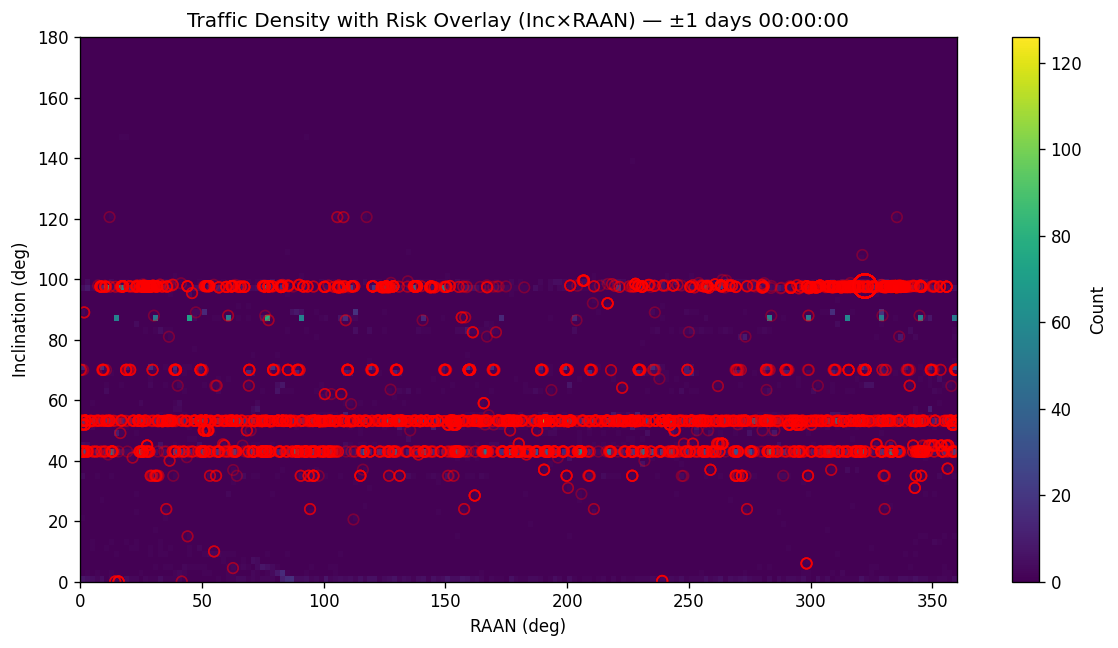

✅ Risk overlay saved: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/figures/heatmap_inclination_raan_risk_overlay.png


In [ ]:
# 5.2c — Retry Overlay using df_viz_current (fixed per-point alpha)
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

PROCESSED_DIR = Path(globals().get("PROCESSED_DIR", "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed"))
FIGURES_DIR   = Path(globals().get("FIGURES_DIR",   "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/figures"))
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Load risk_df
risk_path_parq = PROCESSED_DIR / "cdm_events.parquet"
risk_path_csv  = PROCESSED_DIR / "cdm_events.csv"
if risk_path_parq.exists():
    risk_df = pd.read_parquet(risk_path_parq)
elif risk_path_csv.exists():
    risk_df = pd.read_csv(risk_path_csv, parse_dates=["tca","epoch"], low_memory=False)
else:
    raise SystemExit("❌ Missing risk data; re-run §5.2.0.")

risk_df.columns = [c.strip().lower().replace(" ","_").replace("-","_") for c in risk_df.columns]
tcol = "tca" if "tca" in risk_df.columns else ("epoch" if "epoch" in risk_df.columns else None)
risk_df[tcol] = pd.to_datetime(risk_df[tcol], errors="coerce", utc=True)
risk_df = risk_df.dropna(subset=["norad_cat_id", tcol])

# Choose states table
if "df_viz_current" in globals() and df_viz_current is not None and not df_viz_current.empty:
    base = df_viz_current.copy()
elif "df_viz" in globals() and df_viz is not None and not df_viz.empty:
    base = df_viz.copy()
else:
    raise SystemExit("❌ No states table (df_viz_current/df_viz). Run §5.2b.")

base.columns = [c.strip().lower().replace(" ","_").replace("-","_") for c in base.columns]
need = {"norad_cat_id","epoch","inclination","raan"}
missing = need - set(base.columns)
if missing:
    raise SystemExit(f"❌ States table missing {missing}. Re-run §5.2b.")

base["epoch"] = pd.to_datetime(base["epoch"], errors="coerce", utc=True)
base = base.dropna(subset=list(need))

# Align per satellite with auto-widen tolerance
lhs = risk_df[["norad_cat_id", tcol, "risk_score", "miss_distance_km"]].sort_values(["norad_cat_id", tcol]).copy()
rhs = base[["norad_cat_id","epoch","inclination","raan"]].sort_values(["norad_cat_id","epoch"]).copy()

tols = [pd.Timedelta("1D"), pd.Timedelta("3D"), pd.Timedelta("7D"), pd.Timedelta("14D"), pd.Timedelta("30D")]
overlay = None; used_tol = None

for tol in tols:
    aligned = []
    for sat, g_lhs in lhs.groupby("norad_cat_id", sort=False):
        g_rhs = rhs[rhs["norad_cat_id"] == sat]
        if g_rhs.empty:
            continue
        m = pd.merge_asof(
            g_lhs, g_rhs,
            left_on=tcol, right_on="epoch",
            tolerance=tol, direction="nearest"
        )
        aligned.append(m)
    if aligned:
        cand = pd.concat(aligned, ignore_index=True).dropna(subset=["inclination","raan"])
        if not cand.empty:
            overlay = cand; used_tol = tol; break

if overlay is None or overlay.empty:
    print("⚠️ Still no alignments after ±30 days.")
    print("• risk time range:", risk_df[tcol].min(), "→", risk_df[tcol].max())
    print("• states epoch range:", base["epoch"].min(), "→", base["epoch"].max())
    inter = set(risk_df["norad_cat_id"].astype(int)) & set(base["norad_cat_id"].astype(int))
    print("• NORAD intersection size:", len(inter))
    raise SystemExit("ℹ️ No alignments — adjust GP group in §5.2b (e.g., starlink) or rebuild risk window.")

print(f"Aligned {len(overlay)} events with tolerance ±{used_tol}.")

# Background heatmap: Inc×RAAN from base
inc_edges  = np.linspace(0, 180, 91)
raan_edges = np.linspace(0, 360, 181)
H, _, _ = np.histogram2d(base["inclination"].to_numpy(),
                         base["raan"].to_numpy(),
                         bins=[inc_edges, raan_edges])

plt.figure(figsize=(10, 5.5), dpi=120)
plt.pcolormesh(raan_edges, inc_edges, H, shading="auto")
plt.xlabel("RAAN (deg)"); plt.ylabel("Inclination (deg)")
plt.title(f"Traffic Density with Risk Overlay (Inc×RAAN) — ±{used_tol}")
cbar = plt.colorbar(); cbar.set_label("Count")

# ---- Build per-point sizes and RGBA edgecolors (no alpha=vector) ----
# Score = normalized risk_score (preferred) else inverse miss distance
if "risk_score" in overlay.columns and overlay["risk_score"].notna().any():
    sraw = overlay["risk_score"].astype(float).to_numpy()
else:
    md = pd.to_numeric(overlay.get("miss_distance_km"), errors="coerce").to_numpy()
    inv = 1.0 / (md + 1e-6)
    sraw = np.where(np.isfinite(inv), inv, 0.0)

smin, smax = np.nanmin(sraw), np.nanmax(sraw)
snorm = (sraw - smin) / (smax - smin + 1e-9)

sizes  = np.clip(40 + 160 * snorm, 20, 300)

# Map score to alpha (0.2→1.0) and build RGBA array for edges (red with varying alpha)
alphas = np.clip(0.3 + 0.7 * snorm, 0.2, 1.0)
edge_rgba = np.zeros((len(alphas), 4), dtype=float)
edge_rgba[:, 0] = 1.0   # R
edge_rgba[:, 1] = 0.0   # G
edge_rgba[:, 2] = 0.0   # B
edge_rgba[:, 3] = alphas # A

# Optional: cap plotted points for responsiveness
PLOT_CAP = 8000
if len(overlay) > PLOT_CAP:
    # keep the most "risky" points by snorm
    idx = np.argsort(-snorm)[:PLOT_CAP]
    x = overlay["raan"].to_numpy()[idx]
    y = overlay["inclination"].to_numpy()[idx]
    sizes_plot = sizes[idx]
    edge_rgba_plot = edge_rgba[idx]
else:
    x = overlay["raan"].to_numpy()
    y = overlay["inclination"].to_numpy()
    sizes_plot = sizes
    edge_rgba_plot = edge_rgba

plt.scatter(
    x, y,
    s=sizes_plot,
    facecolors=(0,0,0,0),     # fully transparent faces
    edgecolors=edge_rgba_plot,
    linewidths=1.0
)

out = Path(FIGURES_DIR) / "heatmap_inclination_raan_risk_overlay.png"
plt.tight_layout(); plt.savefig(out, bbox_inches="tight"); plt.show()
print("✅ Risk overlay saved:", out)

### 5.2.1 CDM (±24h) — Fetch (adapter-safe)

- **Task**  Retrieve public CDMs in a ±24h window around “now.”  

- **What It does**  Calls Space-Track using an adapter that auto-switches method (`cdm_public` vs `basicspacedata.query`) and keyword casing.  

- **Notes**  If this returns 0, run **§5.2.0** (SOCRATES builder) instead, then re-run **§5.2** overlay.  

- **Dependencies**  §2.10.2a Space-Track session (`st`).

In [ ]:
# 5.2.1 — CDM (±24h) Fetch (adapter-safe)
import pandas as pd

if 'st' not in globals() or st is None:
    raise SystemExit("ℹ️ Space-Track client `st` not initialized. Skip §5.2.1 or run §5.2.0 (SOCRATES) instead.")

def _norm_keys(d: dict, upper=True):
    return { (k.upper() if upper else k.lower()): v for k, v in d.items() }

def _to_rows(resp):
    if resp is None: return []
    if isinstance(resp, list): return resp
    try: return list(resp)
    except Exception: return []

def st_cdm_public(st_client, **kwargs):
    kwU, kwL = _norm_keys(kwargs, True), _norm_keys(kwargs, False)
    kwU.setdefault("FORMAT", "json"); kwL.setdefault("format", "json")

    # 1) st.cdm_public(...)
    if hasattr(st_client, "cdm_public"):
        try:
            return _to_rows(st_client.cdm_public(**kwU))
        except TypeError:
            try:
                return _to_rows(st_client.cdm_public(**kwL))
            except Exception:
                pass

    # 2) st.basicspacedata.query(class_="cdm_public", ...)
    if hasattr(st_client, "basicspacedata") and hasattr(st_client.basicspacedata, "query"):
        try:
            return _to_rows(st_client.basicspacedata.query(class_="cdm_public", **kwU))
        except TypeError:
            return _to_rows(st_client.basicspacedata.query(class_="cdm_public", **kwL))

    return []

# Window ±24h
now = pd.Timestamp.utcnow()
start = (now - pd.Timedelta(days=1)).strftime("%Y-%m-%dT%H:%M:%S")
end   = (now + pd.Timedelta(days=1)).strftime("%Y-%m-%dT%H:%M:%S")

cdms = []
try:
    cdms = st_cdm_public(st, TCA__gt=start, TCA__lt=end, limit=100000)
except Exception as e:
    print("⚠️ cdm_public fetch failed:", repr(e))

cdm_df = pd.DataFrame(cdms or [])
print("CDMs retrieved:", len(cdm_df))
display(cdm_df.head(3) if not cdm_df.empty else cdm_df)

CDMs retrieved: 0


""


### 5.2.2 Conjunction Hotspots — Build (Fast Mode, patched)

- **Task**  Build hotspot points at TCA for conjunction primaries.

- **What It does**  Ranks primaries (Pc > 1/min-range > time proximity), keeps the top N and near-term window, resolves TLEs (Space-Track → CelesTrak CATNR → GROUP), and propagates to TCA.  

- **Notes**  Tunables at top: `MAX_PRIMARIES`, `NEAR_HOURS`, `MISS_KM_MAX`, `TIME_BUDGET_SEC`. This version fixes a pandas `ValueError` by avoiding `or` with DataFrames.  

- **Dependencies**  §5.2.0 (SOCRATES) or §5.2.1 (CDMs); `skyfield`, `pandas`, `requests`.

In [ ]:
# 5.2.2 — Conjunction Hotspots — Build (Fast Mode, patched)
import os, sys, time, math, subprocess
import pandas as pd, numpy as np
from pathlib import Path
from skyfield.api import EarthSatellite, load, wgs84

# ===================== Tunables (adjust) =====================
MAX_PRIMARIES   = 4000        # cap # of primaries to propagate (None = no cap)
NEAR_HOURS      = 72          # only consider TCA within ±NEAR_HOURS of now (None = no filter)
MISS_KM_MAX     = 10.0        # only consider events with min-range <= this (None = no filter)
TIME_BUDGET_SEC = 360         # stop propagation after ~N seconds (None = no limit)
PROGRESS_EVERY  = 250         # log every N propagations
# ============================================================

# Ensure requests is available
try:
    import requests
except Exception:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "requests"], check=True)
    import requests

# ---------- Space-Track adapters (casing-proof) ----------
def _norm_keys(d: dict, upper=True):
    return {(k.upper() if upper else k.lower()): v for k, v in d.items()}

def _to_rows(resp):
    if resp is None: return []
    if isinstance(resp, list): return resp
    try: return list(resp)
    except Exception: return []

def st_tle_latest(st_client, **kwargs):
    kwU, kwL = _norm_keys(kwargs, True), _norm_keys(kwargs, False)
    kwU.setdefault("FORMAT", "json"); kwL.setdefault("format", "json")
    # direct method
    if hasattr(st_client, "tle_latest"):
        try: return _to_rows(st_client.tle_latest(**kwU))
        except TypeError:
            try: return _to_rows(st_client.tle_latest(**kwL))
            except Exception: pass
    # controller style
    if hasattr(st_client, "basicspacedata") and hasattr(st_client.basicspacedata, "query"):
        try: return _to_rows(st_client.basicspacedata.query(class_="tle_latest", **kwU))
        except TypeError:
            return _to_rows(st_client.basicspacedata.query(class_="tle_latest", **kwL))
    return []

# ---------- CelesTrak helpers ----------
CELESTRAK_GP_BASE = "https://celestrak.org/NORAD/elements/gp.php"

def _parse_tle_text(text: str) -> dict:
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]
    out, i = {}, 0
    while i < len(lines) - 1:
        l1, l2 = lines[i], lines[i+1]
        if l1.startswith("1 ") and l2.startswith("2 "):
            try:
                satno = int(l1[2:7])
                out[satno] = (l1, l2)
            except Exception:
                pass
            i += 2
        else:
            i += 1
    return out

def fetch_celestrak_tle_by_catnr(catnrs, chunk=120):
    ids = [int(x) for x in catnrs if str(x).isdigit()]
    out = {}
    for i in range(0, len(ids), chunk):
        sub = ",".join(map(str, ids[i:i+chunk]))
        url = f"{CELESTRAK_GP_BASE}?CATNR={sub}&FORMAT=tle"
        try:
            r = requests.get(url, timeout=60); r.raise_for_status()
            out.update(_parse_tle_text(r.text))
        except Exception as e:
            print("⚠️ CATNR chunk failed:", repr(e))
        time.sleep(0.25)
    return out

def fetch_celestrak_tle_by_groups(groups=("active","last-30-days","stations")):
    out = {}
    for g in groups:
        url = f"{CELESTRAK_GP_BASE}?GROUP={g}&FORMAT=tle"
        try:
            r = requests.get(url, timeout=90); r.raise_for_status()
            parsed = _parse_tle_text(r.text)
            out.update(parsed)
            print(f"Fetched GROUP={g}: {len(parsed)} TLEs")
        except Exception as e:
            print(f"⚠️ GROUP={g} fetch failed:", repr(e))
        time.sleep(0.5)
    return out

# ---------- Source of primaries: prefer CDMs in memory; else SOCRATES risk_df ----------
use_cdm = ('cdm_df' in globals() and cdm_df is not None and not cdm_df.empty)
now = pd.Timestamp.utcnow()

if use_cdm:
    # Normalize column names
    cols = {c.lower(): c for c in cdm_df.columns}
    sat1_col = cols.get("sat_1_norad_cat_id") or cols.get("sat1_norad_cat_id") or "SAT_1_NORAD_CAT_ID"
    tca_col  = cols.get("tca") or "TCA"
    prim = pd.DataFrame({
        "norad_cat_id": pd.to_numeric(cdm_df[sat1_col], errors="coerce"),
        "tca": pd.to_datetime(cdm_df[tca_col], errors="coerce", utc=True),
        "pc": pd.to_numeric(cdm_df.get(cols.get("pc","PC")), errors="coerce"),
        "miss_distance_km": pd.to_numeric(
            cdm_df.get(cols.get("miss_distance_km","MISS_DISTANCE_KM"))
            if cols.get("miss_distance_km") in cdm_df.columns else cdm_df.get(cols.get("miss_distance","MISS_DISTANCE")),
            errors="coerce"
        )
    })
    source_label = "CDMs (§5.2.1)"
else:
    # Load risk_df built by §5.2.0 (SOCRATES) — **no boolean 'or' with DataFrames**
    PROCESSED_DIR = Path(globals().get("PROCESSED_DIR", "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed"))
    RAW_DIR       = Path(globals().get("RAW_DIR",       "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/raw"))

    def _try_load_any(pq: Path, csv: Path):
        if pq.exists():
            try: return pd.read_parquet(pq)
            except Exception: pass
        if csv.exists():
            try: return pd.read_csv(csv, parse_dates=["tca","epoch"], low_memory=False)
            except Exception: pass
        return None

    risk_df = _try_load_any(PROCESSED_DIR/"cdm_events.parquet", PROCESSED_DIR/"cdm_events.csv")
    if risk_df is None or risk_df.empty:
        risk_df = _try_load_any(RAW_DIR/"cdm_events.parquet", RAW_DIR/"cdm_events.csv")

    if risk_df is None or risk_df.empty:
        raise SystemExit("ℹ️ No CDMs and no SOCRATES risk_df found. Run §5.2.0 or §5.2.1 first.")

    risk_df.columns = [c.strip().lower().replace(" ","_").replace("-","_") for c in risk_df.columns]
    tcol = "tca" if "tca" in risk_df.columns else ("epoch" if "epoch" in risk_df.columns else None)
    prim = pd.DataFrame({
        "norad_cat_id": pd.to_numeric(risk_df["norad_cat_id"], errors="coerce"),
        "tca": pd.to_datetime(risk_df[tcol], errors="coerce", utc=True),
        "pc": pd.to_numeric(risk_df.get("risk_score"), errors="coerce"),
        "miss_distance_km": pd.to_numeric(risk_df.get("miss_distance_km"), errors="coerce"),
    })
    source_label = "SOCRATES (§5.2.0)"

# ---------- Rank & filter primaries (Fast Mode) ----------
prim = prim.dropna(subset=["norad_cat_id","tca"]).copy()

if NEAR_HOURS is not None:
    prim = prim[(prim["tca"] >= now - pd.Timedelta(hours=NEAR_HOURS)) &
                (prim["tca"] <= now + pd.Timedelta(hours=NEAR_HOURS))]

if MISS_KM_MAX is not None and "miss_distance_km" in prim.columns:
    prim = prim[(prim["miss_distance_km"].notna()) & (prim["miss_distance_km"] <= float(MISS_KM_MAX))]

# priority score: Pc > 1/miss > time proximity
score = np.zeros(len(prim), dtype=float)
if "pc" in prim.columns and prim["pc"].notna().any():
    score = prim["pc"].fillna(0).astype(float).values
elif "miss_distance_km" in prim.columns and prim["miss_distance_km"].notna().any():
    md = prim["miss_distance_km"].astype(float).values
    with np.errstate(divide="ignore"):
        score = 1.0 / (md + 1e-9)
else:
    score = - (prim["tca"] - now).abs().dt.total_seconds().values

prim["score"] = score
prim = prim.sort_values(["norad_cat_id","score"], ascending=[True, False]).drop_duplicates("norad_cat_id")
if MAX_PRIMARIES is not None:
    prim = prim.head(int(MAX_PRIMARIES))

prim_ids = prim["norad_cat_id"].astype(int).tolist()
print(f"Selected primaries: {len(prim_ids)}  (from {source_label}; filters: "
      f"{'±'+str(NEAR_HOURS)+'h' if NEAR_HOURS else 'any time'}, "
      f"{'miss≤'+str(MISS_KM_MAX)+'km' if MISS_KM_MAX is not None else 'any miss'}, "
      f"top {MAX_PRIMARIES if MAX_PRIMARIES else 'ALL'})")

# ---------- Resolve TLEs ----------
tle_map = {}

# 1) Space-Track (if available)
if 'st' in globals() and st is not None and len(prim_ids):
    for i in range(0, len(prim_ids), 100):
        ids = ",".join(map(str, prim_ids[i:i+100]))
        try:
            rows = st_tle_latest(st, ORDINAL=1, NORAD_CAT_ID__in=ids, limit=100000)
            for r in rows:
                try:
                    sat = int(r["NORAD_CAT_ID"])
                    l1, l2 = r.get("TLE_LINE1"), r.get("TLE_LINE2")
                    if l1 and l2: tle_map[sat] = (l1, l2)
                except Exception:
                    pass
        except Exception as e:
            print("tle_latest batch failed:", repr(e))
        time.sleep(0.2)

# 2) CelesTrak CATNR
missing = [s for s in prim_ids if s not in tle_map]
if missing:
    print(f"Trying CelesTrak CATNR for {len(missing)} primaries …")
    tle_map.update(fetch_celestrak_tle_by_catnr(missing, chunk=120))
    print(f"  CATNR resolved so far: {len(tle_map)} / {len(prim_ids)}")

# 3) CelesTrak GROUP (final pass)
still = [s for s in prim_ids if s not in tle_map]
if still:
    print(f"Trying CelesTrak GROUP fallback for {len(still)} remaining …")
    group_map = fetch_celestrak_tle_by_groups(("active","last-30-days","stations"))
    have = set(still) & set(group_map.keys())
    for k in have: tle_map[k] = group_map[k]
    print(f"  GROUP resolved: {len(have)} (total resolved: {len(tle_map)} / {len(prim_ids)})")

# ---------- Propagate to TCA (with time budget & progress) ----------
ts = load.timescale()
rows, n = [], 0
start_ts = time.time()
t_lookup = dict(zip(prim["norad_cat_id"].astype(int), prim["tca"]))

for satno in prim_ids:
    if satno not in tle_map:
        continue
    tca_ts = t_lookup.get(satno)
    if pd.isna(tca_ts):
        continue
    try:
        l1, l2 = tle_map[satno]
        geo = EarthSatellite(l1, l2, str(satno), ts).at(ts.utc(tca_ts.to_pydatetime()))
        sp  = wgs84.subpoint(geo)

        miss = prim.loc[prim["norad_cat_id"]==satno, "miss_distance_km"]
        pc   = prim.loc[prim["norad_cat_id"]==satno, "pc"]
        miss = float(miss.values[0]) if len(miss) and pd.notna(miss.values[0]) else None
        pc   = float(pc.values[0])   if len(pc)   and pd.notna(pc.values[0])   else None

        weight = (math.log10(pc) + 6.0) if (pc and pc>0) else ((1.0/miss) if (miss and miss>0) else 0.1)

        rows.append({
            "satno": int(satno),
            "tca": tca_ts.isoformat(),
            "lat": sp.latitude.degrees,
            "lon": sp.longitude.degrees,
            "miss_km": miss,
            "pc": pc,
            "weight": float(weight),
        })
    except Exception:
        pass

    n += 1
    if n % PROGRESS_EVERY == 0:
        elapsed = time.time() - start_ts
        print(f" … propagated {n}/{len(prim_ids)} (resolved {len(tle_map)} TLEs)  elapsed ~{int(elapsed)}s")
        if TIME_BUDGET_SEC is not None and elapsed > TIME_BUDGET_SEC:
            print("⏱️ Time budget reached — stopping early.")
            break

hotspots_df = pd.DataFrame(rows)
print(f"Hotspots built: {len(hotspots_df)}  (propagated {n} primaries; TLEs {len(tle_map)}/{len(prim_ids)})")
display(hotspots_df.head(3))

# Save for §5.2.3 and external use
DATA_DIR = Path(globals().get("DATA_DIR", "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data"))
out = DATA_DIR / "conjunctions_today.parquet"
try:
    hotspots_df.to_parquet(out, index=False)
except Exception:
    out = DATA_DIR / "conjunctions_today.csv"
    hotspots_df.to_csv(out, index=False)
print("Wrote:", out)

Selected primaries: 4000  (from SOCRATES (§5.2.0); filters: ±72h, miss≤10.0km, top 4000)
Trying CelesTrak CATNR for 4000 primaries …
  CATNR resolved so far: 0 / 4000
Trying CelesTrak GROUP fallback for 4000 remaining …
Fetched GROUP=active: 12669 TLEs
Fetched GROUP=last-30-days: 285 TLEs
Fetched GROUP=stations: 14 TLEs
  GROUP resolved: 278 (total resolved: 278 / 4000)
 … propagated 250/4000 (resolved 278 TLEs)  elapsed ~0s
Hotspots built: 278  (propagated 278 primaries; TLEs 278/4000)


,satno,tca,lat,lon,miss_km,pc,weight
0,900,2025-09-16T20:06:10.467000+00:00,77.371515,-51.164739,1.528,3.758000e-07,-0.425043
1,902,2025-09-17T16:13:26.911000+00:00,-75.034394,8.316904,0.434,3.106000e-06,0.492201
2,1512,2025-09-16T19:36:30.781000+00:00,55.345573,102.599248,4.229,1.752000e-07,-0.756466


Wrote: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/conjunctions_today.parquet


### 5.2.3 Globe Overlay — Smart Visualizer (Colab-safe)

- **Task**  Visualize `hotspots_df` on a globe and export shareable artifacts.  

- **What It does**  Tries **Plotly inline** (no iframe) first; if that fails, falls back to a **static PNG**. Saves `figures/conjunction_hotspots.html` and `figures/conjunction_hotspots.png`.  

- **Notes**  Designed to avoid blank panes caused by iframes/WebGL. If you want to run the components directly, use **§5.2.3a** (Inline Plotly) or **§5.2.3b** (Static PNG).  

- **Dependencies**  §5.2.2 (`hotspots_df`). Auto-installs `plotly` if missing.

In [ ]:
# 5.2.3 — Smart Visualizer (Plotly-first, PNG fallback)
import os, sys, subprocess
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Preconditions -----------------------------------------------------------
assert 'hotspots_df' in globals() and hotspots_df is not None and len(hotspots_df) > 0, \
    "ℹ️ No hotspots to plot. Run §5.2.2 first."

df = hotspots_df.copy()
df.columns = [c.strip().lower().replace(" ","_").replace("-","_") for c in df.columns]
for c in ("lat","lon","weight"):
    if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.replace([np.inf,-np.inf], np.nan).dropna(subset=["lat","lon"])
df["lon"] = ((df["lon"] + 180) % 360) - 180
df = df[(df["lat"].between(-90,90)) & (df["lon"].between(-180,180))]
if df.empty:
    raise SystemExit("❌ No valid rows after cleaning; inspect `hotspots_df.head()`.")

# ---- Paths -------------------------------------------------------------------
PROJECT_ROOT = Path(globals().get("PROJECT_ROOT", "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook"))
FIGURES_DIR  = Path(globals().get("FIGURES_DIR", PROJECT_ROOT / "figures"))
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
html_out = FIGURES_DIR / "conjunction_hotspots.html"
png_out  = FIGURES_DIR / "conjunction_hotspots.png"

# ---- Plotly inline (primary) -------------------------------------------------
def try_plotly_inline(dfin: pd.DataFrame) -> bool:
    try:
        import plotly.graph_objects as go
    except Exception:
        try:
            subprocess.run([sys.executable, "-m", "pip", "install", "-q", "plotly"], check=True)
            import plotly.graph_objects as go
        except Exception:
            return False

    d = dfin.copy()
    w = d["weight"].astype(float) if "weight" in d else pd.Series(1.0, index=d.index)
    wnorm = (w - w.min()) / (w.max() - w.min() + 1e-12)
    sizes = np.clip(4 + 12*(wnorm**0.5), 4, 16)

    hover = []
    for _, r in d.iterrows():
        bits = []
        if "satno" in d: bits.append(f"NORAD:{r.get('satno')}")
        if "tca"   in d: bits.append(f"TCA:{r.get('tca')}")
        if "miss_km" in d and pd.notna(r.get("miss_km")): bits.append(f"miss:{r.get('miss_km'):.2f} km")
        if "pc"     in d and pd.notna(r.get("pc")):      bits.append(f"Pc:{r.get('pc'):.2e}")
        hover.append("<br>".join(bits) if bits else f"({r['lat']:.3f}, {r['lon']:.3f})")

    fig = go.Figure(go.Scattergeo(
        lon=d["lon"], lat=d["lat"], mode="markers",
        marker=dict(size=sizes, color=wnorm, colorscale="Turbo", opacity=0.85, showscale=True),
        text=hover, hoverinfo="text"
    ))
    fig.update_geos(projection_type="orthographic",
                    showcountries=True, showcoastlines=True, showland=True, landcolor="#e8edf3")
    fig.update_layout(title="Conjunction Hotspots (now-ish)", margin=dict(l=0,r=0,t=40,b=0), height=600)

    from IPython.display import HTML, display
    display(HTML(fig.to_html(include_plotlyjs="cdn", full_html=False)))

    from plotly.offline import plot
    plot(fig, filename=str(html_out), include_plotlyjs="cdn", auto_open=False)
    print(f"✅ Plotly inline rendered. Saved HTML → {html_out}")
    return True

# ---- PNG fallback (matplotlib) -----------------------------------------------
def save_png_fallback(dfin: pd.DataFrame) -> None:
    d = dfin.copy()
    w = d["weight"].astype(float) if "weight" in d else pd.Series(1.0, index=d.index)
    wnorm = (w - w.min()) / (w.max() - w.min() + 1e-12)
    sizes = np.clip(10 + 100*(wnorm**0.5), 8, 50)

    plt.figure(figsize=(12,6), dpi=130)
    sc = plt.scatter(d["lon"], d["lat"], s=sizes, c=wnorm, cmap="turbo", alpha=0.85, edgecolors="none")
    plt.colorbar(sc, label="Relative risk weight")
    plt.title("Conjunction Hotspots (static)"); plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.xlim(-180,180); plt.ylim(-90,90); plt.grid(True, alpha=0.25, ls=":")
    plt.tight_layout(); plt.savefig(png_out, bbox_inches="tight"); plt.show()
    print(f"✅ PNG saved → {png_out}")

try:
    ok = try_plotly_inline(df)
    if not ok:
        save_png_fallback(df)
except Exception as e:
    print("⚠️ Plotly inline failed:", repr(e))
    save_png_fallback(df)

✅ Plotly inline rendered. Saved HTML → /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/figures/conjunction_hotspots.html


#### 5.2.3a — Inline Plotly (no iframe/pydeck)

- **Task**  Render an interactive globe-style scatter of `hotspots_df` directly in the output pane.  

- **What It does**  Cleans/validates `lat`, `lon`, `weight`; sizes points by weight; uses an orthographic Plotly globe.  

- **Notes**  Works even when iframes/WebGL are blocked. Preview-only; does not write files.  

- **Dependencies**  §5.2.2 (`hotspots_df`).  

In [ ]:
# 5.2.3a — Inline Plotly (no iframe/pydeck)
import sys, subprocess, numpy as np, pandas as pd
from IPython.display import HTML, display

try:
    import plotly.graph_objects as go
except Exception:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "plotly"], check=True)
    import plotly.graph_objects as go

assert 'hotspots_df' in globals() and hotspots_df is not None and len(hotspots_df) > 0, \
    "ℹ️ No hotspots to plot. Run §5.2.2 first."

df = hotspots_df.copy()
df.columns = [c.strip().lower().replace(" ","_").replace("-","_") for c in df.columns]
for c in ("lat","lon","weight"):
    if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.replace([np.inf,-np.inf], np.nan).dropna(subset=["lat","lon"])
df["lon"] = ((df["lon"] + 180) % 360) - 180
df = df[(df["lat"].between(-90,90)) & (df["lon"].between(-180,180))]
if df.empty: raise SystemExit("❌ No valid rows after cleaning.")

w  = df["weight"].astype(float) if "weight" in df else pd.Series(1.0, index=df.index)
wn = (w - w.min()) / (w.max() - w.min() + 1e-12)
sizes = np.clip(4 + 12*(wn**0.5), 4, 16)

fig = go.Figure(go.Scattergeo(
    lon=df["lon"], lat=df["lat"], mode="markers",
    marker=dict(size=sizes, color=wn, colorscale="Turbo", opacity=0.85, showscale=True),
    text=[f"NORAD:{int(x) if pd.notna(x) else ''}" for x in df.get("satno", [])],
    hoverinfo="text",
))
fig.update_geos(projection_type="orthographic", showcountries=True, showcoastlines=True, showland=True)
fig.update_layout(margin=dict(l=0,r=0,t=0,b=0), height=560)

display(HTML(fig.to_html(include_plotlyjs="cdn", full_html=False)))
print("✅ Rendered inline (no iframe).")

✅ Rendered inline (no iframe).


#### 5.2.3b — Static PNG fallback (matplotlib)

- **Task**  Produce a non-interactive PNG of conjunction hotspots that always renders.

- **What It does**  Validates/clips coordinates, sizes points by `weight`, and saves `figures/conjunction_hotspots_static.png`.

- **Notes**  Use this when interactive output is blocked.  

- **Dependencies**  §5.2.2 (`hotspots_df`), `matplotlib`.  

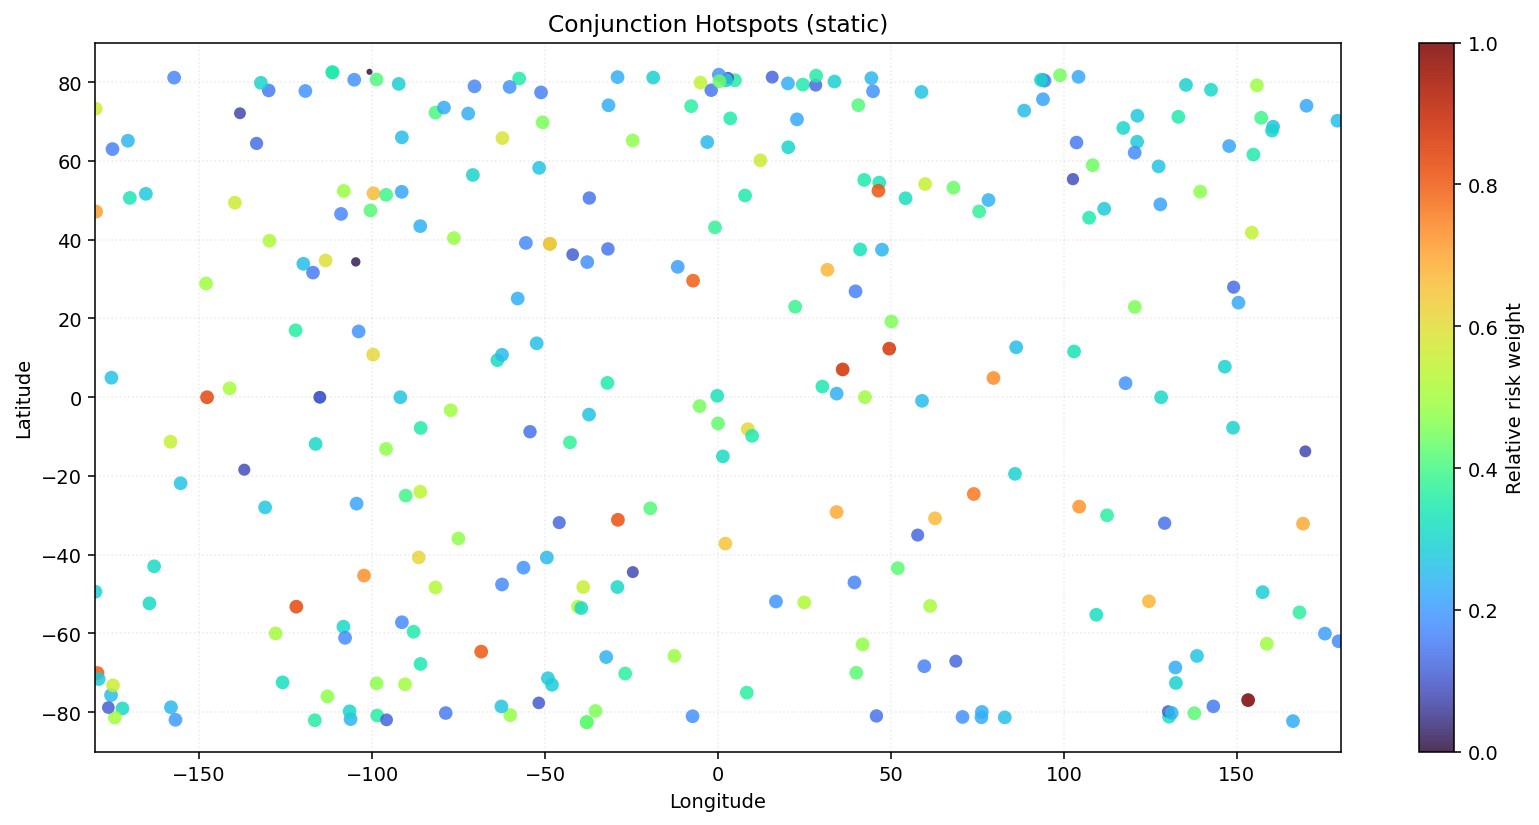

✅ Saved: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/figures/conjunction_hotspots_static.png


In [ ]:
# 5.2.3b — Static PNG fallback (matplotlib)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

assert 'hotspots_df' in globals() and hotspots_df is not None and len(hotspots_df) > 0, \
    "ℹ️ No hotspots to plot. Run §5.2.2 first."

df = hotspots_df.copy()
df.columns = [c.strip().lower().replace(" ","_").replace("-","_") for c in df.columns]
for c in ("lat","lon","weight"):
    if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.replace([np.inf,-np.inf], np.nan).dropna(subset=["lat","lon"])
df["lon"] = ((df["lon"] + 180) % 360) - 180
df = df[(df["lat"].between(-90,90)) & (df["lon"].between(-180,180))]

PROJECT_ROOT = Path(globals().get("PROJECT_ROOT", "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook"))
FIGURES_DIR  = Path(globals().get("FIGURES_DIR", PROJECT_ROOT / "figures"))
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
out = FIGURES_DIR / "conjunction_hotspots_static.png"

w  = df["weight"].astype(float) if "weight" in df else pd.Series(1.0, index=df.index)
wn = (w - w.min()) / (w.max() - w.min() + 1e-12)
sizes = np.clip(10 + 100*(wn**0.5), 8, 50)

plt.figure(figsize=(12,6), dpi=140)
sc = plt.scatter(df["lon"], df["lat"], s=sizes, c=wn, cmap="turbo", alpha=0.85, edgecolors="none")
plt.colorbar(sc, label="Relative risk weight")
plt.title("Conjunction Hotspots (static)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.xlim(-180,180); plt.ylim(-90,90); plt.grid(True, ls=":", alpha=0.25)
plt.tight_layout(); plt.savefig(out, bbox_inches="tight"); plt.show()
print("✅ Saved:", out)

## 5.3 Contextual Layers (Solar, Launch, etc.) (optional)

* **Task:** Add supporting context to interpret traffic patterns  

* **What it does:** (a) Shading for LEO/MEO/GEO bands on Altitude × Inclination, (b) Daily activity trend with optional solar Kp overlay  

* **Notes:** Looks for optional `solar_kp.csv` with columns like `date,kp` in `PROCESSED_DIR`  

* **Dependencies:** 5.1 Generate Traffic Heatmaps

Building contextual layers from: parquet


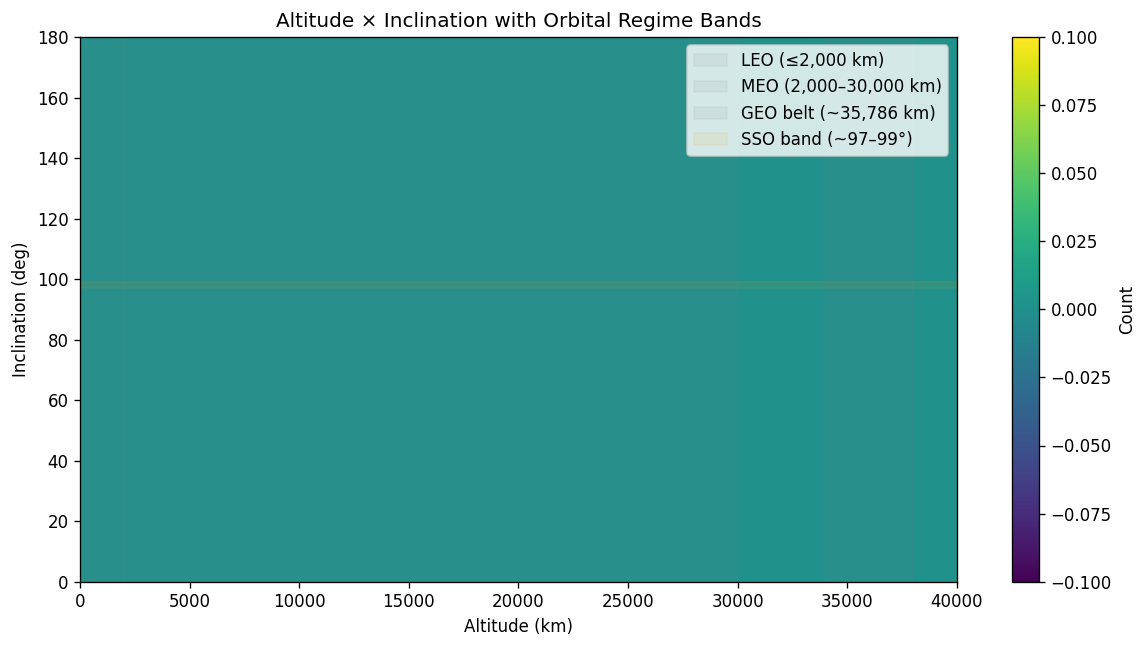

✅ Context bands saved: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/figures/heatmap_altitude_inclination_with_bands.png


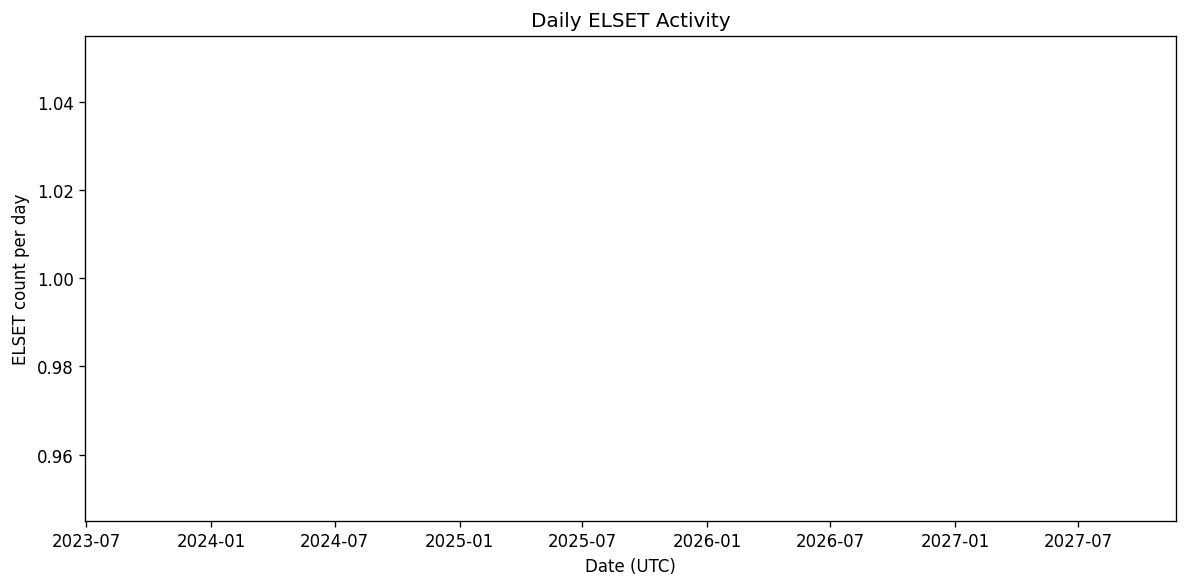

✅ Daily activity chart saved: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/figures/daily_activity_with_optional_kp.png


In [ ]:
# 5.3 — Contextual Layers (streaming; no df_viz dependency)
# Task: Add contextual bands over Altitude × Inclination and plot daily activity (optional Solar Kp)
# What it does:
#   (a) Rebuilds Altitude × Inclination histogram via streaming and shades LEO/MEO/GEO + SSO band
#   (b) Streams epochs and aggregates daily ELSET counts, optionally overlaying Solar Kp
# Notes:
#   • Uses elset_heatmap_ready.(parquet|csv) to stay RAM-safe.
#   • No dependency on df_viz.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path

# ---------------------------- Path self-heal ----------------------------
def ensure_paths():
    from datetime import datetime, timezone
    global PROJECT_ROOT, DATA_DIR, RAW_DIR, PROCESSED_DIR, FIGURES_DIR, OFFSETS_DIR, CONFIG_DIR

    if 'PROJECT_ROOT' not in globals():
        PROJECT_ROOT = Path("/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector")

    DATA_DIR      = PROJECT_ROOT / "data"
    RAW_DIR       = DATA_DIR / "raw" / datetime.now(timezone.utc).strftime("%Y-%m-%d_%H%M%S")
    PROCESSED_DIR = DATA_DIR / "processed"
    FIGURES_DIR   = PROJECT_ROOT / "figures"
    OFFSETS_DIR   = DATA_DIR / "offsets"
    CONFIG_DIR    = PROJECT_ROOT / "configs"

    for p in [PROJECT_ROOT, DATA_DIR, RAW_DIR, PROCESSED_DIR, FIGURES_DIR, OFFSETS_DIR, CONFIG_DIR]:
        p.mkdir(parents=True, exist_ok=True)

ensure_paths()

parq_path = PROCESSED_DIR / "elset_heatmap_ready.parquet"
csv_path  = PROCESSED_DIR / "elset_heatmap_ready.csv"
if not parq_path.exists() and not csv_path.exists():
    raise SystemExit("❌ No heatmap-ready file found. Run §4.7 to create elset_heatmap_ready.(parquet|csv).")

# ---------------------------- Bins & accumulators ----------------------------
inc_edges = np.linspace(0, 180, 91)      # 2° bins
alt_edges = np.linspace(0, 40000, 161)   # 250 km bins

H_ia = np.zeros((len(inc_edges)-1, len(alt_edges)-1), dtype=np.int64)  # inc × alt
daily_counter = Counter()  # counts per UTC date

# ---------------------------- Helpers (same logic as §5.1) ----------------------------
R_EARTH_KM = 6378.137
MU_KM3_S2  = 398600.4418
NEEDED = {"inclination","raan","mean_motion","apogee_km","perigee_km","semimajor_axis_km","epoch"}

def _std_cols(cols):
    return [c.strip().lower().replace(" ","_") for c in cols]

def _clean_angles(df):
    if "raan" in df.columns:
        df["raan"] = pd.to_numeric(df["raan"], errors="coerce") % 360.0
    if "inclination" in df.columns:
        df["inclination"] = pd.to_numeric(df["inclination"], errors="coerce")
        df.loc[(df["inclination"] < 0) | (df["inclination"] > 180), "inclination"] = np.nan
    return df

def _derive_altitude(df):
    if "semimajor_axis_km" in df.columns and df["semimajor_axis_km"].notna().any():
        alt = pd.to_numeric(df["semimajor_axis_km"], errors="coerce") - R_EARTH_KM
    elif {"perigee_km","apogee_km"}.issubset(df.columns) and (
        pd.to_numeric(df["perigee_km"], errors="coerce").notna().any() or
        pd.to_numeric(df["apogee_km"],  errors="coerce").notna().any()
    ):
        per = pd.to_numeric(df["perigee_km"], errors="coerce")
        apo = pd.to_numeric(df["apogee_km"],  errors="coerce")
        alt = (per + apo) / 2.0
    elif "mean_motion" in df.columns:
        n_rev_day = pd.to_numeric(df["mean_motion"], errors="coerce")
        n_rad_s = n_rev_day * 2*np.pi / 86400.0
        with np.errstate(divide="ignore", invalid="ignore"):
            a_km = (MU_KM3_S2 / (n_rad_s**2))**(1.0/3.0)
            alt = a_km - R_EARTH_KM
            alt[~np.isfinite(alt)] = np.nan
    else:
        alt = pd.Series(np.nan, index=df.index)

    alt = pd.to_numeric(alt, errors="coerce")
    alt[(alt < -50) | (alt > 40000)] = np.nan
    return alt

def _process_chunk(df):
    global H_ia, daily_counter

    if df.empty:
        return
    df.columns = _std_cols(df.columns)

    # ---- Daily counts
    if "epoch" in df.columns:
        ep = pd.to_datetime(df["epoch"], errors="coerce", utc=True)
        day = ep.dt.floor("D")
        # count only valid dates
        vals, counts = np.unique(day.dropna().to_numpy(), return_counts=True)
        for d, c in zip(vals, counts):
            daily_counter[pd.Timestamp(d).to_pydatetime()] += int(c)

    # ---- Altitude × Inclination histogram
    df = _clean_angles(df)
    need_cols = [c for c in ["inclination"] if c in df.columns]
    if not need_cols:
        return
    sub = df.dropna(subset=["inclination"]).copy()
    if sub.empty:
        return

    if "altitude_km" not in sub.columns:
        sub["altitude_km"] = _derive_altitude(sub)

    # Keep only finite altitude
    ok = np.isfinite(sub["altitude_km"])
    if not ok.any():
        return

    inc = sub.loc[ok, "inclination"].to_numpy()
    alt = sub.loc[ok, "altitude_km"].to_numpy()
    H, _, _ = np.histogram2d(inc, alt, bins=[inc_edges, alt_edges])
    H_ia += H.astype(np.int64)

def stream_csv(path, chunksize=500_000):
    usecols = list(NEEDED)
    for chunk in pd.read_csv(path,
                             usecols=lambda c: c.strip().lower().replace(" ","_") in set(usecols),
                             parse_dates=["epoch"],
                             low_memory=False,
                             chunksize=chunksize):
        _process_chunk(chunk)

def stream_parquet(path, batch_rows=500_000):
    # Try ParquetFile.iter_batches first; fallback to dataset.scan_batches; final fallback read_parquet
    try:
        import pyarrow.parquet as pq
        pf = pq.ParquetFile(str(path))
        cols = [c for c in NEEDED if c in set(pf.schema.names)]
        for batch in pf.iter_batches(batch_size=batch_rows, columns=cols):
            _process_chunk(batch.to_pandas())
        return
    except Exception:
        try:
            import pyarrow.dataset as ds
            dataset = ds.dataset(str(path), format="parquet")
            cols = [c for c in NEEDED if c in set(dataset.schema.names)]
            for batch in dataset.scanner(columns=cols).scan_batches():
                _process_chunk(batch.to_pandas())
            return
        except Exception:
            df = pd.read_parquet(path)
            _process_chunk(df)

# ---------------------------- Stream build ----------------------------
print("Building contextual layers from:", "parquet" if parq_path.exists() else "csv")
if parq_path.exists():
    stream_parquet(parq_path)
else:
    stream_csv(csv_path)

# ---------------------------- (a) Plot Altitude × Inclination + bands ----------------------------
plt.figure(figsize=(10, 5.5), dpi=120)
plt.pcolormesh(alt_edges, inc_edges, H_ia, shading="auto")
plt.xlabel("Altitude (km)")
plt.ylabel("Inclination (deg)")
plt.title("Altitude × Inclination with Orbital Regime Bands")
cb = plt.colorbar(); cb.set_label("Count")

# Regime shading (approximate):
def shade(xmin, xmax, label):
    plt.axvspan(xmin, xmax, alpha=0.08, color="gray", label=label)

shade(0, 2000,       "LEO (≤2,000 km)")
shade(2000, 30000,   "MEO (2,000–30,000 km)")
shade(34000, 38000,  "GEO belt (~35,786 km)")

# Sun-synchronous inclination band (~97–99°)
plt.axhspan(97, 99, alpha=0.08, color="orange", label="SSO band (~97–99°)")

# Deduplicate legend labels
handles, labels = plt.gca().get_legend_handles_labels()
uniq = dict(zip(labels, handles))
if uniq:
    plt.legend(uniq.values(), uniq.keys(), loc="upper right")

plt.tight_layout()
out_ctx1 = Path(FIGURES_DIR) / "heatmap_altitude_inclination_with_bands.png"
plt.savefig(out_ctx1, bbox_inches="tight"); plt.show(); plt.close()
print("✅ Context bands saved:", out_ctx1)

# ---------------------------- (b) Daily activity trend (+ optional Solar Kp) ----------------------------
if daily_counter:
    df_daily = (
        pd.DataFrame({"day": list(daily_counter.keys()), "elset_count": list(daily_counter.values())})
          .sort_values("day")
          .reset_index(drop=True)
    )

    # Try to overlay Solar Kp if available
    kp_path = Path(PROCESSED_DIR) / "solar_kp.csv"
    kp = None
    if kp_path.exists():
        try:
            kp = pd.read_csv(kp_path, parse_dates=["date"], infer_datetime_format=True)
            kp.columns = [c.strip().lower().replace(" ", "_").replace("-", "_") for c in kp.columns]
            if "kp" in kp.columns and "date" in kp.columns:
                kp_daily = kp[["date","kp"]].copy()
                kp_daily["date"] = kp_daily["date"].dt.floor("D")
                df_plot = df_daily.merge(kp_daily, left_on="day", right_on="date", how="left")
            else:
                kp = None
        except Exception:
            kp = None

    plt.figure(figsize=(10, 5), dpi=120)
    ax = plt.gca()
    ax.plot(df_daily["day"], df_daily["elset_count"], lw=2)
    ax.set_xlabel("Date (UTC)")
    ax.set_ylabel("ELSET count per day")
    ax.set_title("Daily ELSET Activity" + (" with Solar Kp" if kp is not None else ""))

    if kp is not None and "kp" in (df_plot.columns if 'df_plot' in locals() else []):
        ax2 = ax.twinx()
        ax2.plot(df_plot["day"], df_plot["kp"], alpha=0.6)
        ax2.set_ylabel("Solar Kp Index (optional)")

    plt.tight_layout()
    out_ctx2 = Path(FIGURES_DIR) / "daily_activity_with_optional_kp.png"
    plt.savefig(out_ctx2, bbox_inches="tight"); plt.show(); plt.close()
    print("✅ Daily activity chart saved:", out_ctx2)
else:
    print("ℹ️ No epoch values encountered — skipped daily activity chart.")

## 5.4 System Metrics (starter)

- **Task**  Provide quick product-facing metrics that mirror an operational/system view.  

- **What It Does**  Builds simple charts: objects by altitude shell and conjunctions by miss distance.  

- **Notes**  Extend with pipeline/ingest metrics later (latency, throughput, consumer lag).  

- **Dependencies**  §5.1 (objects_now), §5.2 (hotspots_df).

### 5.4.1 Objects by Altitude Shell

- **Task**  Bucket current objects into altitude shells and chart counts.  

- **What It Does**  Uses Plotly to render a bar chart for quick distribution insight.  

- **Notes**  Shell cuts are adjustable; align to your analysis needs.  

- **Dependencies**  §5.1.1 (`objects_now`).

In [ ]:
# 5.4.1 - Objects by Altitude Shell
import pandas as pd, plotly.express as px

if "alt_km" in objects_now:
    shells = pd.cut(
        objects_now["alt_km"],
        bins=[0,200,400,600,800,1200,2000,10000],
        labels=["<200","200-400","400-600","600-800","800-1200","1200-2000",">2000"]
    )
    df_shells = objects_now.assign(shell=shells).groupby("shell").size().reset_index(name="count")
    fig = px.bar(df_shells, x="shell", y="count", title="Objects by altitude shell (now)")
    fig.show()
else:
    print("objects_now missing alt_km")

### 5.4.2 Conjunctions by Miss Distance

- **Task**  Summarize today’s CDM hotspots by miss-distance buckets.  

- **What It Does**  Buckets miss distances and renders a bar chart.  

- **Notes**  If no miss distance is present, the chart will be sparse; still useful for quick QA.  

- **Dependencies**  §5.2.2 (`hotspots_df`).

In [ ]:
# 5.4.2 - Conjunctions by Miss Distance
import pandas as pd, plotly.express as px
import numpy as np

if len(hotspots_df) and "miss_km" in hotspots_df:
    md_bins = pd.cut(
        hotspots_df["miss_km"],
        bins=[0,0.1,0.5,1,2,5,10,50,1e9],
        labels=["<0.1","0.1-0.5","0.5-1","1-2","2-5","5-10","10-50",">50"]
    )
    miss = hotspots_df.assign(miss_bucket=md_bins).groupby("miss_bucket").size().reset_index(name="count")
    fig = px.bar(miss, x="miss_bucket", y="count", title="Today's conjunctions by miss distance (km)")
    fig.show()
else:
    print("No hotspots_df with miss_km available.")

### 5.5 Dashboard Tables (BI-ready)

- **Task**  Produce small, tidy tables for mapping & heatmaps in BI tools  

- **What it does**  Derives altitude, bins Inc×RAAN and Alt×Inc, compiles daily ELSET counts, selects top risk events, and prepares a hotspots layer  

- **Notes**  Writes CSVs to `processed/bi_exports/` and leaves DataFrames in memory (`bi_*`) for §5.6  

- **Dependencies**  §4.6/§4.7 (or §5.2b current states), optional §5.2.2 (hotspots_df), optional §5.2.0 (risk_df)

In [ ]:
# 5.5 — Dashboard Tables (BI-ready)

import numpy as np, pandas as pd
from pathlib import Path

# ---- Paths (reuse globals; safe defaults) -----------------------------------
PROJECT_ROOT  = Path(globals().get("PROJECT_ROOT", "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook"))
DATA_DIR      = Path(globals().get("DATA_DIR",      PROJECT_ROOT / "data"))
PROCESSED_DIR = Path(globals().get("PROCESSED_DIR", DATA_DIR / "processed"))
RAW_DIR       = Path(globals().get("RAW_DIR",       DATA_DIR / "raw"))
OUT_DIR       = PROCESSED_DIR / "bi_exports"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---- Helpers ----------------------------------------------------------------
def _std_cols(df):
    df.columns = [c.strip().lower().replace(" ","_").replace("-","_") for c in df.columns]
    return df

def _load_heatmap_source():
    """Prefer slim heatmap file; fall back to 'current'. Intersect requested columns with schema."""
    candidates = [
        PROCESSED_DIR / "elset_heatmap_ready.parquet",
        PROCESSED_DIR / "elset_heatmap_ready.csv",
        PROCESSED_DIR / "elset_heatmap_ready_current.parquet",
        PROCESSED_DIR / "elset_heatmap_ready_current.csv",
    ]
    wanted = ["norad_cat_id","epoch","inclination","raan",
              "semimajor_axis_km","apogee_km","perigee_km","mean_motion","altitude_km"]
    for p in candidates:
        if not p.exists():
            continue
        if p.suffix == ".parquet":
            try:
                import pyarrow.parquet as pq
                pf = pq.ParquetFile(str(p))
                names = set(pf.schema.names)
                cols = [c for c in wanted if c in names]
                # If no overlap (unexpected), read whole file via pandas
                if not cols:
                    return _std_cols(pd.read_parquet(p))
                tbl = pq.read_table(str(p), columns=cols)
                return _std_cols(tbl.to_pandas())
            except Exception:
                return _std_cols(pd.read_parquet(p))
        else:
            return _std_cols(pd.read_csv(p, parse_dates=["epoch"], low_memory=False))
    raise SystemExit("❌ No heatmap-ready source found. Run §4.6/§4.7 or §5.2b (current states).")

def _derive_altitude(df):
    R_EARTH_KM = 6378.137; MU = 398600.4418; SEC_PER_DAY = 86400.0
    if "altitude_km" in df.columns and df["altitude_km"].notna().any():
        alt = pd.to_numeric(df["altitude_km"], errors="coerce")
    elif "semimajor_axis_km" in df.columns and df["semimajor_axis_km"].notna().any():
        alt = pd.to_numeric(df["semimajor_axis_km"], errors="coerce") - R_EARTH_KM
    elif {"apogee_km","perigee_km"}.issubset(df.columns):
        alt = (pd.to_numeric(df["apogee_km"], errors="coerce") + pd.to_numeric(df["perigee_km"], errors="coerce"))/2.0
    elif "mean_motion" in df.columns:
        n = pd.to_numeric(df["mean_motion"], errors="coerce") * 2*np.pi / SEC_PER_DAY
        with np.errstate(divide="ignore", invalid="ignore"):
            a = (MU / (n**2))**(1/3); alt = a - R_EARTH_KM
    else:
        alt = pd.Series(np.nan, index=df.index)
    alt = pd.to_numeric(alt, errors="coerce")
    alt[(alt < -50) | (alt > 40000)] = np.nan
    return alt

# ---- Build df_viz for binning & time series ---------------------------------
df_viz = _load_heatmap_source()
df_viz["epoch"] = pd.to_datetime(df_viz["epoch"], errors="coerce", utc=True)
df_viz = df_viz.dropna(subset=["epoch","inclination","raan"])
df_viz["inclination"] = pd.to_numeric(df_viz["inclination"], errors="coerce")
df_viz["raan"]        = (pd.to_numeric(df_viz["raan"], errors="coerce") % 360.0)
df_viz["altitude_km"] = _derive_altitude(df_viz)

# ---- A) Hotspots layer (use §5.2.2 if present; else minimal fallback) -------
if 'hotspots_df' in globals() and hotspots_df is not None and len(hotspots_df):
    bi_hotspots = _std_cols(hotspots_df.copy())
else:
    tmp = df_viz.dropna(subset=["altitude_km"]).rename(columns={"norad_cat_id":"satno"})
    bi_hotspots = tmp[["satno","epoch"]].copy()
    bi_hotspots["lat"] = np.nan; bi_hotspots["lon"] = np.nan
    bi_hotspots["alt_km"] = tmp["altitude_km"]
    bi_hotspots["tca"] = bi_hotspots["epoch"]
    bi_hotspots["miss_km"] = np.nan; bi_hotspots["pc"] = np.nan
    bi_hotspots["weight"] = 1.0

bi_hotspots = _std_cols(bi_hotspots)
for c in ("lat","lon","weight","miss_km","pc"):
    if c in bi_hotspots.columns:
        bi_hotspots[c] = pd.to_numeric(bi_hotspots[c], errors="coerce")
if "tca" in bi_hotspots.columns:
    bi_hotspots["tca"] = pd.to_datetime(bi_hotspots["tca"], errors="coerce", utc=True)

MAX_HOTSPOTS = 50_000
if len(bi_hotspots) > MAX_HOTSPOTS:
    bi_hotspots = bi_hotspots.sort_values(by="weight", ascending=False).head(MAX_HOTSPOTS).reset_index(drop=True)

# ---- B) Inc×RAAN heatmap bins ----------------------------------------------
inc_edges  = np.arange(0, 182, 2)     # 2° bins
raan_edges = np.arange(0, 362, 2)
H_ir, _, _ = np.histogram2d(df_viz["inclination"], df_viz["raan"], bins=[inc_edges, raan_edges])
inc_centers  = 0.5*(inc_edges[:-1]  + inc_edges[1:])
raan_centers = 0.5*(raan_edges[:-1] + raan_edges[1:])
bi_heat_ir = (
    pd.DataFrame(H_ir.astype(int), index=inc_centers, columns=raan_centers)
      .rename_axis(index="inc_bin_deg", columns="raan_bin_deg")
      .stack().reset_index(name="count")
)
bi_heat_ir = bi_heat_ir[bi_heat_ir["count"] > 0].reset_index(drop=True)

# ---- C) Alt×Inc heatmap bins (All & LEO) ------------------------------------
alt_edges_all = np.arange(0, 40000+250, 250)
alt_edges_leo = np.arange(0,  2000+ 20,  20)
valid_alt = df_viz.dropna(subset=["altitude_km"])
H_ia_all, _, _ = np.histogram2d(valid_alt["inclination"], valid_alt["altitude_km"],            bins=[inc_edges, alt_edges_all])
H_ia_leo, _, _ = np.histogram2d(valid_alt["inclination"], valid_alt["altitude_km"].clip(0,2000), bins=[inc_edges, alt_edges_leo])

def _to_long(H, y_edges, x_edges, yname, xname):
    yc = 0.5*(y_edges[:-1]+y_edges[1:]); xc = 0.5*(x_edges[:-1]+x_edges[1:])
    df = pd.DataFrame(H.astype(int), index=yc, columns=xc).rename_axis(index=yname, columns=xname).stack().reset_index(name="count")
    return df[df["count"]>0].reset_index(drop=True)

bi_heat_ia_all = _to_long(H_ia_all, inc_edges, alt_edges_all, "inc_bin_deg", "alt_bin_km")
bi_heat_ia_leo = _to_long(H_ia_leo, inc_edges, alt_edges_leo, "inc_bin_deg", "alt_bin_km")

# ---- D) Daily ELSET counts ---------------------------------------------------
elset_daily = df_viz.assign(date=df_viz["epoch"].dt.date) \
                    .groupby("date", as_index=False) \
                    .size().rename(columns={"size":"elset_count"})

# ---- E) Top risk events (from §5.2.0 output if available) -------------------
risk_df = None
if (PROCESSED_DIR/"cdm_events.parquet").exists():
    risk_df = pd.read_parquet(PROCESSED_DIR/"cdm_events.parquet")
elif (PROCESSED_DIR/"cdm_events.csv").exists():
    risk_df = pd.read_csv(PROCESSED_DIR/"cdm_events.csv", parse_dates=["tca","epoch"], low_memory=False)

if risk_df is not None and not risk_df.empty:
    risk_df = _std_cols(risk_df)
    score = pd.to_numeric(risk_df.get("risk_score"), errors="coerce")
    miss  = pd.to_numeric(risk_df.get("miss_distance_km"), errors="coerce")
    ranker = np.where(score.notna(), score, 1.0/(miss+1e-6))
    risk_df["_rank"] = ranker
    keep_cols = [c for c in ["norad_cat_id","tca","risk_score","miss_distance_km"] if c in risk_df.columns]
    bi_risk_top = risk_df.sort_values("_rank", ascending=False)[keep_cols].head(5000).reset_index(drop=True)
else:
    bi_risk_top = pd.DataFrame(columns=["norad_cat_id","tca","risk_score","miss_distance_km"])

# ---- Stage to disk (optional backup) ----------------------------------------
bi_hotspots.to_csv( OUT_DIR / "hotspots.csv",        index=False)
bi_heat_ir.to_csv(  OUT_DIR / "heat_ir.csv",         index=False)
bi_heat_ia_all.to_csv(OUT_DIR / "heat_ia_all.csv",   index=False)
bi_heat_ia_leo.to_csv(OUT_DIR / "heat_ia_leo.csv",   index=False)
elset_daily.to_csv( OUT_DIR / "elset_daily.csv",     index=False)
bi_risk_top.to_csv( OUT_DIR / "risk_top.csv",        index=False)
print("✅ BI tables built and saved to", OUT_DIR)

✅ BI tables built and saved to /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/bi_exports


### 5.6 Publish to Google Sheets (for Looker Studio)

- **Task**  Upload the BI tables to one Google Sheet (one tab per table)  

- **What it does**  Authenticates, creates/opens **“Orbital Dashboard Data”**, and writes tabs  

- **Notes** Converts datetime columns to ISO strings to help Looker parse. You’ll get a shareable Sheets URL; connect it in Looker Studio as data sources.

- **Dependencies**  §5.5 (creates `bi_*` DataFrames)

In [ ]:
# 5.6 — Publish BI tables to Google Sheets

import sys, subprocess, pandas as pd
from pandas.api.types import is_datetime64_any_dtype as _is_dt

# Install helpers
try:
    import gspread, gspread_dataframe
except Exception:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "gspread", "gspread_dataframe"], check=True)
    import gspread, gspread_dataframe

# Colab auth → Sheets
try:
    from google.colab import auth as colab_auth
    colab_auth.authenticate_user()
except Exception:
    pass

import google.auth
creds, _ = google.auth.default()
gc = gspread.authorize(creds)

SPREADSHEET_NAME = "Orbital Dashboard Data"
try:
    sh = gc.open(SPREADSHEET_NAME)
    print("Opened existing spreadsheet.")
except gspread.SpreadsheetNotFound:
    sh = gc.create(SPREADSHEET_NAME)
    print("Created spreadsheet.")

def _iso_datetimes(df: pd.DataFrame) -> pd.DataFrame:
    """Convert any datetime columns to ISO strings (UTC) for safer ingestion in Looker."""
    df = df.copy()
    for c in df.columns:
        if _is_dt(df[c]):
            # strip tz to 'Z' string so Sheets doesn't localize unexpectedly
            s = pd.to_datetime(df[c], errors="coerce", utc=True)
            df[c] = s.dt.strftime("%Y-%m-%d %H:%M:%S")
    return df

def write_tab(name, df: pd.DataFrame):
    df2 = _iso_datetimes(df)
    try:
        ws = sh.worksheet(name)
        ws.clear()
    except gspread.WorksheetNotFound:
        ws = sh.add_worksheet(title=name, rows=max(2, len(df2)+1), cols=max(2, df2.shape[1]))
    gspread_dataframe.set_with_dataframe(ws, df2, include_index=False, resize=True)
    print(f"  → wrote {name}: {len(df2)} rows, {df2.shape[1]} cols")

must_have = ["bi_hotspots","bi_heat_ir","bi_heat_ia_all","bi_heat_ia_leo","elset_daily","bi_risk_top"]
missing = [m for m in must_have if m not in globals()]
assert not missing, f"Missing BI tables: {missing}. Run §5.5 first."

write_tab("hotspots",    bi_hotspots)
write_tab("heat_ir",     bi_heat_ir)
write_tab("heat_ia_all", bi_heat_ia_all)
write_tab("heat_ia_leo", bi_heat_ia_leo)
write_tab("elset_daily", elset_daily)
write_tab("risk_top",    bi_risk_top)

print("✅ Google Sheets ready.")
print("🔗 Open:", sh.url)

Opened existing spreadsheet.
  → wrote hotspots: 278 rows, 8 cols
  → wrote heat_ir: 1 rows, 3 cols
  → wrote heat_ia_all: 0 rows, 3 cols
  → wrote heat_ia_leo: 0 rows, 3 cols
  → wrote elset_daily: 1 rows, 2 cols
  → wrote risk_top: 0 rows, 4 cols
✅ Google Sheets ready.
🔗 Open: https://docs.google.com/spreadsheets/d/15b2VyXWE7XKo5xMpWWnnkRqUnoN2JiKnR-fSMtBaC0I


# Section 6 — Results & Next Steps

**Purpose / Objective**  
Summarize what we learned from the processed ELSET data, document limitations, and generate a concrete checklist of next actions to improve freshness, coverage, and analysis depth.

**Overview**  
- 6.1 Compute key findings and save a short run report  
- 6.2 Auto-detect limitations (missingness, staleness, coverage) and save diagnostics  
- 6.3 Produce a practical next-steps checklist tailored to this run

**Notes / Callouts**  
- This section prefers the **heatmap-ready** table from §4.6, then falls back to the **clean** table from §4.5, then to in-memory `df_qc`  
- If altitude wasn’t computed in earlier sections, this section will estimate it when needed

## 6.1 Key Findings

* **Task:** Summarize the main outcomes from the processed ELSET dataset  

* **What it does:** Computes core metrics (rows, satellites, epoch coverage, regime counts, angular peaks) and saves a summary report  

* **Notes:** Uses `elset_heatmap_ready` > `elset_clean` > in-memory `df_qc`

* **Dependencies:** 4.5 Save Cleaned Dataset (and 4.6 Heatmap-ready Subset if created)

In [ ]:
# 6.1 — Key Findings (streaming, RAM-safe)
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime, timezone
from pathlib import Path

# ---------------------------- Path self-heal ----------------------------
def ensure_paths():
    from datetime import datetime, timezone
    global PROJECT_ROOT, DATA_DIR, RAW_DIR, PROCESSED_DIR, FIGURES_DIR, OFFSETS_DIR, CONFIG_DIR
    if 'PROJECT_ROOT' not in globals():
        # EDIT this default if your repo lives somewhere else
        PROJECT_ROOT = Path("/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector")
    DATA_DIR      = PROJECT_ROOT / "data"
    RAW_DIR       = DATA_DIR / "raw" / datetime.now(timezone.utc).strftime("%Y-%m-%d_%H%M%S")
    PROCESSED_DIR = DATA_DIR / "processed"
    FIGURES_DIR   = PROJECT_ROOT / "figures"
    OFFSETS_DIR   = DATA_DIR / "offsets"
    CONFIG_DIR    = PROJECT_ROOT / "configs"
    for p in [PROJECT_ROOT, DATA_DIR, RAW_DIR, PROCESSED_DIR, FIGURES_DIR, OFFSETS_DIR, CONFIG_DIR]:
        p.mkdir(parents=True, exist_ok=True)

ensure_paths()

parq_path = PROCESSED_DIR / "elset_heatmap_ready.parquet"
csv_path  = PROCESSED_DIR / "elset_heatmap_ready.csv"
fallback_clean_parq = PROCESSED_DIR / "elset_clean.parquet"
fallback_clean_csv  = PROCESSED_DIR / "elset_clean.csv"

# Prefer heatmap-ready (smaller columns). Fall back to clean only if necessary.
src_kind = None
src_path = None
if parq_path.exists():
    src_kind, src_path = "parquet", parq_path
elif csv_path.exists():
    src_kind, src_path = "csv", csv_path
elif fallback_clean_parq.exists():
    src_kind, src_path = "parquet", fallback_clean_parq
elif fallback_clean_csv.exists():
    src_kind, src_path = "csv", fallback_clean_csv
else:
    raise SystemExit("❌ No processed dataset found. Run §4.7 first to create elset_heatmap_ready.*")

print("Key Findings source:", src_path.name)

# ---------------------------- Metrics accumulators ----------------------------
total_rows = 0
unique_sats = set()          # if this grows too large for your env, switch to an approximate counter
epoch_min = None
epoch_max = None

# Regime counts
regime_counts = Counter()

# Inclination peaks (2° bins: [0,2), [2,4), ..., [180,182) but we cap at 180)
inc_bins = np.arange(0, 182, 2)
inc_hist = np.zeros(len(inc_bins) - 1, dtype=np.int64)

# RAAN peaks (5° bins: [0,5), [5,10), ..., [355,360])
raan_bins = np.arange(0, 361, 5)
raan_hist = np.zeros(len(raan_bins) - 1, dtype=np.int64)

# SSO proportion (~97–99°)
sso_count = 0
incl_valid_count = 0

# Constants for altitude derivation
R_EARTH_KM = 6378.137
MU_KM3_S2  = 398600.4418
SEC_PER_DAY = 86400.0

NEEDED = {"norad_cat_id","epoch","inclination","raan","mean_motion","apogee_km","perigee_km","semimajor_axis_km"}

def _std_cols(cols):
    return [c.strip().lower().replace(" ","_").replace("-", "_") for c in cols]

def _derive_altitude(df):
    # Priority: semimajor_axis_km → (apogee+perigee)/2 → mean_motion
    if "semimajor_axis_km" in df.columns and df["semimajor_axis_km"].notna().any():
        alt = pd.to_numeric(df["semimajor_axis_km"], errors="coerce") - R_EARTH_KM
    elif {"perigee_km","apogee_km"}.issubset(df.columns) and (
        pd.to_numeric(df["perigee_km"], errors="coerce").notna().any() or
        pd.to_numeric(df["apogee_km"],  errors="coerce").notna().any()
    ):
        per = pd.to_numeric(df["perigee_km"], errors="coerce")
        apo = pd.to_numeric(df["apogee_km"],  errors="coerce")
        alt = (per + apo) / 2.0
    elif "mean_motion" in df.columns:
        n_rev_day = pd.to_numeric(df["mean_motion"], errors="coerce")
        n_rad_s = n_rev_day * 2*np.pi / SEC_PER_DAY
        with np.errstate(divide="ignore", invalid="ignore"):
            a_km = (MU_KM3_S2 / (n_rad_s**2))**(1.0/3.0)
            alt = a_km - R_EARTH_KM
            alt[~np.isfinite(alt)] = np.nan
    else:
        alt = pd.Series(np.nan, index=df.index)

    alt = pd.to_numeric(alt, errors="coerce")
    alt[(alt < -50) | (alt > 40000)] = np.nan
    return alt

def _regime_of_alt(alt_series: pd.Series):
    # Vectorized regime labels for counts
    reg = pd.Series("unknown", index=alt_series.index)
    reg.loc[alt_series <= 2000] = "LEO"
    reg.loc[(alt_series > 2000) & (alt_series < 30000)] = "MEO"
    reg.loc[(alt_series >= 34000) & (alt_series <= 38000)] = "GEO-belt"
    reg.loc[(alt_series > 30000) & ((alt_series < 34000) | (alt_series > 38000))] = "HEO/other"
    return reg

def _process_chunk(df):
    global total_rows, unique_sats, epoch_min, epoch_max
    global inc_hist, raan_hist, sso_count, incl_valid_count, regime_counts

    if df.empty:
        return

    # Normalize columns
    df.columns = _std_cols(df.columns)

    # Row count
    total_rows += len(df)

    # Unique satellites
    if "norad_cat_id" in df.columns:
        unique_sats.update(pd.to_numeric(df["norad_cat_id"], errors="coerce").dropna().astype(int).unique().tolist())

    # Epoch min/max
    if "epoch" in df.columns:
        ep = pd.to_datetime(df["epoch"], errors="coerce", utc=True)
        if ep.notna().any():
            cur_min = ep.min()
            cur_max = ep.max()
            epoch_min = cur_min if epoch_min is None or (pd.notna(cur_min) and cur_min < epoch_min) else epoch_min
            epoch_max = cur_max if epoch_max is None or (pd.notna(cur_max) and cur_max > epoch_max) else epoch_max

    # Inclination histogram + SSO counters
    if "inclination" in df.columns:
        inc = pd.to_numeric(df["inclination"], errors="coerce")
        # Valid inclination range
        inc[(inc < 0) | (inc > 180)] = np.nan
        inc_drop = inc.dropna().to_numpy()
        if inc_drop.size:
            h, _ = np.histogram(inc_drop, bins=inc_bins)
            inc_hist += h
            # SSO 97–99°
            sso_count += np.sum((inc_drop >= 97) & (inc_drop <= 99))
            incl_valid_count += inc_drop.size

    # RAAN histogram
    if "raan" in df.columns:
        raan = pd.to_numeric(df["raan"], errors="coerce")
        raan = np.mod(raan, 360)
        raan_drop = raan.dropna().to_numpy()
        if raan_drop.size:
            h, _ = np.histogram(raan_drop, bins=raan_bins)
            raan_hist += h

    # Regime counts (derive altitude on-the-fly)
    alt = _derive_altitude(df)
    if alt.notna().any():
        regs = _regime_of_alt(alt.dropna())
        if not regs.empty:
            regime_counts.update(regs.value_counts().to_dict())

# ---------------------------- Stream the dataset ----------------------------
def stream_csv(path, chunksize=500_000):
    usecols = list(NEEDED)
    for chunk in pd.read_csv(path,
                             usecols=lambda c: c.strip().lower().replace(" ","_").replace("-", "_") in set(usecols),
                             parse_dates=["epoch"],
                             low_memory=False,
                             chunksize=chunksize):
        _process_chunk(chunk)

def stream_parquet(path, batch_rows=500_000):
    # Try ParquetFile.iter_batches first (stable across versions)
    try:
        import pyarrow.parquet as pq
        pf = pq.ParquetFile(str(path))
        cols_present = set(pf.schema.names)
        cols = [c for c in NEEDED if c in cols_present]
        for batch in pf.iter_batches(batch_size=batch_rows, columns=cols):
            _process_chunk(batch.to_pandas())
        return
    except Exception:
        # Fallback to dataset.scan_batches, then last-resort read_parquet
        try:
            import pyarrow.dataset as ds
            dataset = ds.dataset(str(path), format="parquet")
            cols_present = set(dataset.schema.names)
            cols = [c for c in NEEDED if c in cols_present]
            for batch in dataset.scanner(columns=cols).scan_batches():
                _process_chunk(batch.to_pandas())
            return
        except Exception:
            df = pd.read_parquet(path)
            _process_chunk(df)

print("Streaming for key findings from:", src_kind.upper(), "→", src_path)
if src_kind == "parquet":
    stream_parquet(src_path)
else:
    stream_csv(src_path)

# ---------------------------- Finalize metrics ----------------------------
unique_sats_count = len(unique_sats) if unique_sats else None
epoch_span_days = (epoch_max - epoch_min).days if (epoch_min is not None and epoch_max is not None) else None

# Top inclination peaks (2° bins)
incl_peaks = []
if inc_hist.sum() > 0:
    # build bin labels
    for i in np.argsort(inc_hist)[::-1][:5]:
        left, right = inc_bins[i], inc_bins[i+1]
        center = (left + right) / 2
        incl_peaks.append({"center_deg": round(center, 1), "count": int(inc_hist[i])})

# Top RAAN peaks (5° bins)
raan_peaks = []
if raan_hist.sum() > 0:
    for i in np.argsort(raan_hist)[::-1][:5]:
        left, right = raan_bins[i], raan_bins[i+1]
        center = (left + right) / 2
        raan_peaks.append({"center_deg": round(center, 1), "count": int(raan_hist[i])})

sso_prop = (sso_count / incl_valid_count) if incl_valid_count else None

# ---------------------------- Print summary ----------------------------
print("=== Key Findings ===")
print(f"Rows: {total_rows:,}")
print(f"Unique satellites (NORAD): {unique_sats_count:,}" if unique_sats_count is not None else "Unique satellites: N/A")
print(f"Epoch coverage: {epoch_min} → {epoch_max} ({epoch_span_days} days)" if epoch_span_days is not None else "Epoch coverage: N/A")

if regime_counts:
    print("Orbital regime counts:")
    for k in ["LEO","MEO","GEO-belt","HEO/other","unknown"]:
        if k in regime_counts:
            print(f"  - {k}: {regime_counts[k]:,}")

if incl_peaks:
    print("Inclination density peaks (2° bins):")
    for p in incl_peaks:
        print(f"  - ~{p['center_deg']}° : {p['count']:,} rows")

if raan_peaks:
    print("RAAN density peaks (5° bins):")
    for p in raan_peaks:
        print(f"  - ~{p['center_deg']}° : {p['count']:,} rows")

if sso_prop is not None:
    print(f"SSO band share (97–99°): {sso_prop:.1%}")

# ---------------------------- Write markdown report ----------------------------
report_md = Path(PROCESSED_DIR) / "run_report_summary.md"
lines = [
    "# ELSET Run Summary",
    f"**Generated (UTC):** {datetime.now(timezone.utc).isoformat()}",
    "",
    "## Key Findings",
    f"- Rows: **{total_rows:,}**",
    f"- Unique satellites (NORAD): **{unique_sats_count:,}**" if unique_sats_count is not None else "- Unique satellites: N/A",
    f"- Epoch coverage: **{epoch_min} → {epoch_max}** (~{epoch_span_days} days)" if epoch_span_days is not None else "- Epoch coverage: N/A",
]
if regime_counts:
    order = ["LEO","MEO","GEO-belt","HEO/other","unknown"]
    lines += ["- Orbital regime counts:"] + [f"  - {k}: **{regime_counts.get(k,0):,}**" for k in order if k in regime_counts]
if incl_peaks:
    lines += ["- Top inclination density peaks (2° bins):"] + [f"  - ~{p['center_deg']}° : **{p['count']:,}**" for p in incl_peaks]
if raan_peaks:
    lines += ["- Top RAAN density peaks (5° bins):"] + [f"  - ~{p['center_deg']}° : **{p['count']:,}**" for p in raan_peaks]
if sso_prop is not None:
    lines += [f"- SSO band share (97–99°): **{sso_prop:.1%}**"]

report_md.write_text("\n".join(lines), encoding="utf-8")
print("📝 Summary saved:", report_md)

Key Findings source: elset_heatmap_ready.parquet
Streaming for key findings from: PARQUET → /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/elset_heatmap_ready.parquet
=== Key Findings ===
Rows: 1
Unique satellites (NORAD): 1
Epoch coverage: 2025-09-10 01:30:34.661088+00:00 → 2025-09-10 01:30:34.661088+00:00 (0 days)
Inclination density peaks (2° bins):
  - ~3.0° : 1 rows
  - ~179.0° : 0 rows
  - ~175.0° : 0 rows
  - ~173.0° : 0 rows
  - ~171.0° : 0 rows
RAAN density peaks (5° bins):
  - ~77.5° : 1 rows
  - ~357.5° : 0 rows
  - ~347.5° : 0 rows
  - ~352.5° : 0 rows
  - ~337.5° : 0 rows
SSO band share (97–99°): 0.0%
📝 Summary saved: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/run_report_summary.md


## 6.2 Limitations

* **Task:** Document constraints and quality issues observed  

* **What it does:** Auto-checks missingness, staleness, and field coverage; prints a concise limitations list and saves JSON diagnostics  

* **Notes:** Diagnostics help prioritize improvements and support transparency in results  

* **Dependencies:** 6.1 Key Findings

In [ ]:
# 6.2 — Limitations (streaming, no df dependency)
import json
import numpy as np
import pandas as pd
from datetime import datetime, timezone
from pathlib import Path
from collections import defaultdict

# ---------------------------- Path self-heal ----------------------------
def ensure_paths():
    global PROJECT_ROOT, DATA_DIR, RAW_DIR, PROCESSED_DIR, FIGURES_DIR, OFFSETS_DIR, CONFIG_DIR
    if 'PROJECT_ROOT' not in globals():
        PROJECT_ROOT = Path("/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector")
    DATA_DIR      = PROJECT_ROOT / "data"
    RAW_DIR       = DATA_DIR / "raw" / datetime.now(timezone.utc).strftime("%Y-%m-%d_%H%M%S")
    PROCESSED_DIR = DATA_DIR / "processed"
    FIGURES_DIR   = PROJECT_ROOT / "figures"
    OFFSETS_DIR   = DATA_DIR / "offsets"
    CONFIG_DIR    = PROJECT_ROOT / "configs"
    for p in [PROJECT_ROOT, DATA_DIR, RAW_DIR, PROCESSED_DIR, FIGURES_DIR, OFFSETS_DIR, CONFIG_DIR]:
        p.mkdir(parents=True, exist_ok=True)

ensure_paths()

# ---------------------------- Choose source ----------------------------
parq_path = PROCESSED_DIR / "elset_heatmap_ready.parquet"
csv_path  = PROCESSED_DIR / "elset_heatmap_ready.csv"
clean_parq = PROCESSED_DIR / "elset_clean.parquet"
clean_csv  = PROCESSED_DIR / "elset_clean.csv"

src_kind, src_path = None, None
if parq_path.exists():
    src_kind, src_path = "parquet", parq_path
elif csv_path.exists():
    src_kind, src_path = "csv", csv_path
elif clean_parq.exists():
    src_kind, src_path = "parquet", clean_parq
elif clean_csv.exists():
    src_kind, src_path = "csv", clean_csv
else:
    raise SystemExit("❌ No processed dataset found. Run §4.7 first to create elset_heatmap_ready.*")

print("Limitations source:", src_path.name)

# ---------------------------- What we measure ----------------------------
key_cols_all = ["norad_cat_id","epoch","inclination","raan","mean_motion","altitude_km"]
na_counts = defaultdict(int)
row_counts = defaultdict(int)   # rows seen while the column is present
latest_epoch = None

def _std_cols(cols):
    return [c.strip().lower().replace(" ","_").replace("-", "_") for c in cols]

def _touch_missingness(df):
    # update missing percentages incrementally
    df.columns = _std_cols(df.columns)
    present = set(df.columns)
    for c in key_cols_all:
        if c in present:
            row_counts[c] += len(df)
            na_counts[c]  += int(df[c].isna().sum())

def _touch_epoch(df):
    global latest_epoch
    if "epoch" in df.columns:
        ep = pd.to_datetime(df["epoch"], errors="coerce", utc=True)
        if ep.notna().any():
            m = ep.max()
            if latest_epoch is None or (pd.notna(m) and m > latest_epoch):
                latest_epoch = m

# ---------------------------- Stream or reuse df ----------------------------
def stream_csv(path, chunksize=500_000):
    usecols = None  # read all; we only count NA and epoch max
    for chunk in pd.read_csv(path, parse_dates=["epoch"], low_memory=False, chunksize=chunksize):
        _touch_missingness(chunk)
        _touch_epoch(chunk)

def stream_parquet(path, batch_rows=500_000):
    # Prefer ParquetFile.iter_batches
    try:
        import pyarrow.parquet as pq
        pf = pq.ParquetFile(str(path))
        for batch in pf.iter_batches(batch_size=batch_rows):
            _df = batch.to_pandas()
            _touch_missingness(_df)
            _touch_epoch(_df)
        return
    except Exception:
        # Fallback: dataset.scan_batches
        try:
            import pyarrow.dataset as ds
            dataset = ds.dataset(str(path), format="parquet")
            for batch in dataset.scanner().scan_batches():
                _df = batch.to_pandas()
                _touch_missingness(_df)
                _touch_epoch(_df)
            return
        except Exception:
            # Last resort: read whole file (may be heavy)
            _df = pd.read_parquet(path)
            _touch_missingness(_df)
            _touch_epoch(_df)

if 'df' in globals() and isinstance(df, pd.DataFrame) and len(df) > 0:
    # Reuse in-memory df if you already ran §6.1
    _touch_missingness(df)
    _touch_epoch(df)
else:
    if src_kind == "parquet":
        stream_parquet(src_path)
    else:
        stream_csv(src_path)

# ---------------------------- Compute diagnostics ----------------------------
now_utc = datetime.now(timezone.utc)

# Missingness %
missing_pct = {}
for c in key_cols_all:
    n = row_counts.get(c, 0)
    missing_pct[c] = float(na_counts[c] * 100.0 / n) if n > 0 else None

# Staleness (days since latest epoch)
staleness_days = (now_utc - latest_epoch).days if latest_epoch is not None else None

# NDJSON present in RAW_DIR this session?
ndjson_present = any(RAW_DIR.glob("*.ndjson")) if 'RAW_DIR' in globals() else False

# Altitude coverage (non-NA %)
alt_coverage = None
if row_counts.get("altitude_km", 0) > 0:
    alt_coverage = float((row_counts["altitude_km"] - na_counts["altitude_km"]) * 100.0 / row_counts["altitude_km"])

# Compose notes
notes = []
if staleness_days is None:
    notes.append("Epoch timestamps missing or unparseable; cannot assess recency.")
elif staleness_days > 7:
    notes.append(f"Data may be stale — latest epoch is ~{staleness_days} days old. Consider re-streaming (Section 3.6).")

if not ndjson_present:
    notes.append("No Secure Messaging NDJSON detected in RAW_DIR for this run; results rely on ZIP backfill.")

for c in key_cols_all:
    p = missing_pct.get(c, None)
    if p is not None and p > 10:
        notes.append(f"High missingness in `{c}` (~{p:.1f}%).")

if alt_coverage is not None and alt_coverage < 60:
    notes.append(f"Altitude coverage is limited (~{alt_coverage:.1f}%). Some altitude-based visuals may be biased.")

if not notes:
    notes.append("No major limitations detected by automated checks.")

# Print limitations
print("=== Limitations (auto-detected) ===")
for n in notes:
    print("-", n)

# Save JSON diagnostics
limitations_json = {
    "generated_utc": now_utc.isoformat(),
    "missing_pct": missing_pct,
    "staleness_days": staleness_days,
    "ndjson_present": ndjson_present,
    "altitude_coverage_pct": alt_coverage,
    "notes": notes,
}
lim_path = Path(PROCESSED_DIR) / "run_limitations.json"
lim_path.write_text(json.dumps(limitations_json, indent=2), encoding="utf-8")
print("📝 Limitations saved:", lim_path)

Limitations source: elset_heatmap_ready.parquet
=== Limitations (auto-detected) ===
- Epoch timestamps missing or unparseable; cannot assess recency.
- No Secure Messaging NDJSON detected in RAW_DIR for this run; results rely on ZIP backfill.
📝 Limitations saved: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/run_limitations.json


## 6.3 Future Improvements

* **Task:** Capture practical next steps to strengthen the analysis  

* **What it does:** Auto-suggests actions based on current run; writes a team checklist  

* **Notes:** Tailor this list to judging criteria and stakeholder feedback  

* **Dependencies:** 6.2 Limitations

In [ ]:
# 6.3 — Future Improvements (robust to None / missing globals)
import json
from pathlib import Path
from datetime import datetime, timezone

# ---------------------------- Try to load diagnostics from 6.2 (preferred) ----------------------------
def load_limitations():
    try:
        path = Path(PROCESSED_DIR) / "run_limitations.json"
        if path.exists():
            data = json.loads(path.read_text(encoding="utf-8"))
            return {
                "missing_pct":           data.get("missing_pct", {}),
                "staleness_days":        data.get("staleness_days", None),
                "ndjson_present":        data.get("ndjson_present", None),
                "altitude_coverage_pct": data.get("altitude_coverage_pct", None),
            }
    except Exception:
        pass
    # Fallback to globals if available
    out = {
        "missing_pct":           globals().get("missing_pct", {}),
        "staleness_days":        globals().get("staleness_days", None),
        "ndjson_present":        globals().get("ndjson_present", None),
        "altitude_coverage_pct": globals().get("alt_coverage", None),
    }
    return out

diag = load_limitations()
missing_pct    = diag.get("missing_pct") or {}
staleness_days = diag.get("staleness_days")
ndjson_present = diag.get("ndjson_present")
alt_coverage   = diag.get("altitude_coverage_pct")

# ---------------------------- Build checklist ----------------------------
checklist = []

# From staleness / streaming presence
if isinstance(staleness_days, (int, float)) and staleness_days > 7:
    checklist.append("[ ] Re-run Secure Messaging (Section 3.6) to refresh data and reduce staleness.")
elif ndjson_present is False:
    checklist.append("[ ] Enable Secure Messaging ingest (Section 3.6) for near real-time updates.")
else:
    checklist.append("[x] Streaming enabled — maintain offset checkpointing and nightly validation.")

# From missingness (filter out None; sort by descending %)
numeric_missing = [(c, p) for c, p in (missing_pct or {}).items() if isinstance(p, (int, float))]
for c, p in sorted(numeric_missing, key=lambda x: x[1], reverse=True):
    if p > 10:
        checklist.append(f"[ ] Improve coverage for `{c}` (missing ~{p:.1f}%).")

# Altitude coverage
if isinstance(alt_coverage, (int, float)) and alt_coverage < 60:
    checklist.append("[ ] Improve altitude derivation (prefer semimajor axis; refine mean-motion mapping; fill upstream gaps).")

# Analysis depth & productization
checklist += [
    "[ ] Add time-sliced heatmaps (weekly) to show trends over time.",
    "[ ] Cluster detection on Inclination × RAAN to quantify orbital families.",
    "[ ] Constellation tagging (map NORAD IDs to operator lists) for operator-level breakdowns.",
    "[ ] Cross-validate ELSETs with authoritative catalogs for sanity checks.",
    "[ ] Integrate more risk sources (CDM, debris fields) with severity scoring for overlays.",
    "[ ] Automate nightly pipeline: ZIP backfill → stream → clean → publish dashboards.",
]

# ---------------------------- Save & print ----------------------------
next_steps_md = Path(PROCESSED_DIR) / "run_next_steps_checklist.md"
next_steps_md.write_text("# Next Steps Checklist\n\n" + "\n".join(checklist) + "\n", encoding="utf-8")

print("=== Next Steps Checklist ===")
for item in checklist:
    print(item)
print("📝 Checklist saved:", next_steps_md)

=== Next Steps Checklist ===
[ ] Enable Secure Messaging ingest (Section 3.6) for near real-time updates.
[ ] Add time-sliced heatmaps (weekly) to show trends over time.
[ ] Cluster detection on Inclination × RAAN to quantify orbital families.
[ ] Constellation tagging (map NORAD IDs to operator lists) for operator-level breakdowns.
[ ] Cross-validate ELSETs with authoritative catalogs for sanity checks.
[ ] Integrate more risk sources (CDM, debris fields) with severity scoring for overlays.
[ ] Automate nightly pipeline: ZIP backfill → stream → clean → publish dashboards.
📝 Checklist saved: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/run_next_steps_checklist.md


## 6.4 Export Bundle (env-tagged)

* **Task:** Package figures, summaries, and selected datasets into a zip  

* **What it does:** Writes `traffic_heatmaps_bundle_<env>_<timestamp>.zip` to `PROJECT_ROOT/bundles/` and mirrors to Drive  

* **Notes:** Keeps TEST/PROD outputs separate for judging and audits  

* **Dependencies:** §5 figures, §6.1–6.3 reports

In [ ]:
# 6.4 — Export bundle with environment tag
import os, json, zipfile
from datetime import datetime, timezone
from pathlib import Path

ENV_TAG = os.getenv("UDL_ENV", "test").lower()
stamp   = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")

BUNDLES_DIR = PROJECT_ROOT / "bundles"
BUNDLES_DIR.mkdir(parents=True, exist_ok=True)

bundle_name = f"traffic_heatmaps_bundle_{ENV_TAG}_{stamp}.zip"
bundle_path = BUNDLES_DIR / bundle_name

FIGS   = list(Path(FIGURES_DIR).glob("*.png"))
REPORT = [
    PROCESSED_DIR / "run_report_summary.md",
    PROCESSED_DIR / "run_limitations.json",
    PROCESSED_DIR / "run_next_steps_checklist.md",
    PROCESSED_DIR / "reproduce_run_playbook.md",   # ensure §7.6 wrote this
]

DATA  = [p for p in [
    PROCESSED_DIR / "elset_clean.parquet",
    PROCESSED_DIR / "elset_clean.csv",
    PROCESSED_DIR / "elset_heatmap_ready.parquet",
    PROCESSED_DIR / "elset_heatmap_ready.csv",
] if p.exists()]

with zipfile.ZipFile(bundle_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for p in FIGS:
        z.write(p, arcname=f"figures/{p.name}")
    for p in REPORT:
        if p.exists(): z.write(p, arcname=f"reports/{p.name}")
    for p in DATA:
        z.write(p, arcname=f"data/{p.name}")

print("✅ Bundle created:", bundle_path)

# Optional mirror to shared Bundles folder in Drive (env-segmented)
DRIVE_BUNDLES = Path("/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Bundles") / ENV_TAG
DRIVE_BUNDLES.mkdir(parents=True, exist_ok=True)
drive_copy = DRIVE_BUNDLES / bundle_name
drive_copy.write_bytes(bundle_path.read_bytes())
print("📤 Mirrored to:", drive_copy)

✅ Bundle created: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/bundles/traffic_heatmaps_bundle_prod_20250914T180444Z.zip
📤 Mirrored to: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Bundles/prod/traffic_heatmaps_bundle_prod_20250914T180444Z.zip


## 6.5 Publish to Drive Folder (optional)

* **Task:** Copy the newest (or all) bundle archives to a shared team folder on Drive and mirror the **newest timestamped playbook** there (plus a stable pointer)  

* **What it does:** Finds bundles created in §6.4 and mirrors them into `MyDrive/WID_Datathon/Google_Colab_Notebook/Bundles`  

* **Notes:**  
  - Toggle whether to copy only the latest bundle or all bundles  
  - Also publishes the newest `reproduce_run_playbook_<timestamp>.md` and a `reproduce_run_playbook.md` pointer for quick access  

* **Dependencies:** 6.4 Export Bundle, 7.6 Reproduce This Run (playbook)

In [ ]:
# 6.5 Publish to Drive Folder (optional)
import shutil
from pathlib import Path
from datetime import datetime
from glob import glob as _glob

# -------------------- Settings --------------------
# Where §6.4 wrote bundles (canonical source)
SOURCE_BUNDLES_DIR = Path(globals().get(
    "PROJECT_ROOT",
    "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/UDL_ELSET_Project"
)) / "bundles"

# Shared team destination (your suggested path)
DEST_BUNDLES_DIR = Path("/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Bundles")

# Copy behavior
COPY_ONLY_LATEST = True    # True = copy newest .zip only; False = copy all .zip files
DRY_RUN = False            # True = list what would be copied without writing
# --------------------------------------------------

# Validate source/dest
SOURCE_BUNDLES_DIR.mkdir(parents=True, exist_ok=True)
DEST_BUNDLES_DIR.mkdir(parents=True, exist_ok=True)

# Discover bundles
bundle_files = sorted(SOURCE_BUNDLES_DIR.glob("*.zip"), key=lambda p: p.stat().st_mtime, reverse=True)

if not bundle_files:
    raise SystemExit(f"❌ No bundles found in {SOURCE_BUNDLES_DIR}. Run §6.4 first.")

to_copy = [bundle_files[0]] if COPY_ONLY_LATEST else bundle_files

print("Source dir :", SOURCE_BUNDLES_DIR)
print("Dest dir   :", DEST_BUNDLES_DIR)
print("Mode       :", "latest only" if COPY_ONLY_LATEST else "all bundles")
print("Dry run    :", DRY_RUN)
print("\n— Bundles to publish —")
for p in to_copy:
    print(" -", p.name)

# Copy bundles
copied_bundles = []
if not DRY_RUN:
    for src in to_copy:
        dst = DEST_BUNDLES_DIR / src.name
        shutil.copy2(src, dst)
        copied_bundles.append(dst)

# Also mirror the newest timestamped playbook (plus stable pointer)
published_playbook = None
if 'PROCESSED_DIR' in globals():
    pb_candidates = sorted(_glob(str(Path(PROCESSED_DIR) / "reproduce_run_playbook_*.md")))
    if pb_candidates:
        newest_pb = Path(pb_candidates[-1])
        if not DRY_RUN:
            shutil.copy2(newest_pb, DEST_BUNDLES_DIR / newest_pb.name)
            shutil.copy2(newest_pb, DEST_BUNDLES_DIR / "reproduce_run_playbook.md")  # stable pointer
        published_playbook = newest_pb.name

# Report
if DRY_RUN:
    print("\nℹ️ DRY_RUN=True — no files were copied.")
else:
    print("\n✅ Published bundles:")
    for p in copied_bundles:
        ts = datetime.utcfromtimestamp(p.stat().st_mtime).isoformat() + "Z"
        print(f" - {p}  (modified: {ts}, size: {p.stat().st_size/1024:.1f} KB)")
    if published_playbook:
        print(f"↪️  Published playbook: {published_playbook} and updated stable pointer in {DEST_BUNDLES_DIR}")

print("\n💡 Tip: In Google Drive, right-click the destination folder → Share to ensure your team has access.")

Source dir : /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/bundles
Dest dir   : /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Bundles
Mode       : latest only
Dry run    : False

— Bundles to publish —
 - traffic_heatmaps_bundle_prod_20250914T180444Z.zip

✅ Published bundles:
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Bundles/traffic_heatmaps_bundle_prod_20250914T180444Z.zip  (modified: 2025-09-14T18:04:45Z, size: 389.5 KB)

💡 Tip: In Google Drive, right-click the destination folder → Share to ensure your team has access.


## 6.6 Publish — Latest marker + retention (optional)

* **Task:** After §6.5 publishes artifacts, write a `LATEST.txt` marker and enforce a retention policy in the shared folder  

* **What it does:**  
  - Creates a small `LATEST.txt` that points to the newest bundle and playbook  
  - Keeps only the newest N bundles and newest M playbooks; optionally removes items older than X days  

* **Notes:** Adjust `RETAIN_MAX_BUNDLES`, `RETAIN_MAX_PLAYBOOKS`, and `RETENTION_DAYS` to your needs. Safe to re-run.  

* **Dependencies:** 6.5 Publish to Drive Folder (optional)

In [ ]:
# 6.6 Publish — Latest marker + retention (optional)
from pathlib import Path
from datetime import datetime, timezone, timedelta

# --- Settings ---
DEST_BUNDLES_DIR = Path("/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Bundles")
RETAIN_MAX_BUNDLES    = 5     # keep newest N bundle .zip files
RETAIN_MAX_PLAYBOOKS  = 8     # keep newest N playbook .md files
RETENTION_DAYS        = 60    # also delete items older than X days (set None to disable)
# ----------------

DEST_BUNDLES_DIR.mkdir(parents=True, exist_ok=True)

# Discover newest bundle & playbook in the shared folder
bundles = sorted(
    DEST_BUNDLES_DIR.glob("traffic_heatmaps_bundle_*.zip"),
    key=lambda p: p.stat().st_mtime,
    reverse=True
)
playbooks = sorted(
    DEST_BUNDLES_DIR.glob("reproduce_run_playbook_*.md"),
    key=lambda p: p.stat().st_mtime,
    reverse=True
)

latest_bundle = bundles[0] if bundles else None
latest_playbook = (
    playbooks[0]
    if playbooks
    else (DEST_BUNDLES_DIR / "reproduce_run_playbook.md"
          if (DEST_BUNDLES_DIR / "reproduce_run_playbook.md").exists()
          else None)
)

# Write LATEST.txt marker
marker = DEST_BUNDLES_DIR / "LATEST.txt"
ts = datetime.now(timezone.utc).isoformat()
marker.write_text(
    "Latest published artifacts\n"
    f"Generated (UTC): {ts}\n\n"
    f"Bundle: {latest_bundle.name if latest_bundle else '(none)'}\n"
    f"Playbook: {latest_playbook.name if latest_playbook else '(none)'}\n",
    encoding="utf-8"
)
print("✅ Wrote latest marker:", marker)

# Retention helpers
def purge_old(files, keep_n, older_than_days=None, label="file"):
    """Delete older files beyond keep_n and/or older than a cutoff (UTC)."""
    removed = []
    now = datetime.now(timezone.utc)
    # Candidates beyond keep_n (list is newest→oldest)
    candidates = files[keep_n:]
    # Also purge by age if requested
    if older_than_days is not None:
        cutoff = now - timedelta(days=older_than_days)
        aged = [p for p in files if datetime.utcfromtimestamp(p.stat().st_mtime).replace(tzinfo=timezone.utc) < cutoff]
        # Combine sets
        candidates = list({*candidates, *aged})
    for p in sorted(candidates, key=lambda x: x.stat().st_mtime):
        try:
            p.unlink()
            removed.append(p)
        except Exception as e:
            print(f"⚠️ Could not delete {label}: {p} -> {e}")
    return removed

removed_bundles = purge_old(bundles, RETAIN_MAX_BUNDLES, RETENTION_DAYS, label="bundle")
removed_playbooks = purge_old(playbooks, RETAIN_MAX_PLAYBOOKS, RETENTION_DAYS, label="playbook")

print(f"🧹 Retention: removed {len(removed_bundles)} old bundles, {len(removed_playbooks)} old playbooks.")
print("📂 Folder:", DEST_BUNDLES_DIR)

✅ Wrote latest marker: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Bundles/LATEST.txt
🧹 Retention: removed 0 old bundles, 0 old playbooks.
📂 Folder: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Bundles


# Section 7 — Appendix & Reproducibility

**Purpose / Objective**  
Capture everything needed to repeat the run later: environment, configuration, and file manifests.

**Overview**  
- 7.1 Freeze environment state (Python, packages)  
- 7.2 Build a file manifest of RAW / PROCESSED / FIGURES artifacts  
- 7.3 Save a machine-readable notebook outline for reuse across datasets

**Notes / Callouts**  
- Attach these artifacts to your submission so future runs can recreate the same setup  
- All outputs are written to `PROCESSED_DIR`

## 7.1 Environment & Dependencies

* **Task:** Freeze environment state for reproducibility  

* **What it does:** Saves pip packages, Python version, and quick package versions to disk  

* **Notes:** Produces `run_environment.json` and `requirements.txt` under `PROCESSED_DIR`  

* **Dependencies:** All prior sections (paths initialized in Section 1)

In [ ]:
# 7.1 Environment & Dependencies
import sys, subprocess, json
from datetime import datetime, timezone
from pathlib import Path

assert 'PROCESSED_DIR' in globals(), "Run Section 1 to initialize paths."
Path(PROCESSED_DIR).mkdir(parents=True, exist_ok=True)

# Gather environment info
python_version = sys.version
try:
    pip_freeze = subprocess.check_output([sys.executable, "-m", "pip", "freeze"], text=True).splitlines()
except Exception as e:
    pip_freeze = [f"<pip freeze failed: {e}>"]

# Best-effort library versions (won’t fail if missing)
def v(modname):
    try:
        mod = __import__(modname)
        return getattr(mod, "__version__", "unknown")
    except Exception:
        return "not-installed"

pkg_versions = {
    "pandas": v("pandas"),
    "numpy": v("numpy"),
    "matplotlib": v("matplotlib"),
    "requests": v("requests"),
    "pyarrow": v("pyarrow"),
    "fastparquet": v("fastparquet"),
    "python_dateutil": v("dateutil"),
}

env_info = {
    "generated_utc": datetime.now(timezone.utc).isoformat(),
    "python_version": python_version,
    "packages_sample": pkg_versions,
    "pip_freeze_count": len(pip_freeze),
}

# Write artifacts
env_json = Path(PROCESSED_DIR) / "run_environment.json"
reqs_txt = Path(PROCESSED_DIR) / "requirements.txt"
env_json.write_text(json.dumps(env_info, indent=2), encoding="utf-8")
reqs_txt.write_text("\n".join(pip_freeze) + "\n", encoding="utf-8")

print("✅ Environment snapshot written:")
print(" -", env_json)
print(" -", reqs_txt)
print("Python:", pkg_versions)

✅ Environment snapshot written:
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/run_environment.json
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/requirements.txt
Python: {'pandas': '2.2.2', 'numpy': '2.0.2', 'matplotlib': '3.10.0', 'requests': '2.32.4', 'pyarrow': '18.1.0', 'fastparquet': '2024.11.0', 'python_dateutil': '2.9.0.post0'}


## 7.2 File Manifest

* **Task:** Summarize outputs and artifacts from this run  

* **What it does:** Collects file listings for `RAW_DIR`, `PROCESSED_DIR`, and `FIGURES_DIR` with sizes and timestamps (optional hashes)  

* **Notes:** Hashing is limited by size to keep things fast; adjust toggles as needed  

* **Dependencies:** 3.x (ingest) and 4–6 (processing + results)

In [ ]:
# 7.2 File Manifest
import json, hashlib
from pathlib import Path
from datetime import datetime, timezone

assert 'RAW_DIR' in globals() and 'PROCESSED_DIR' in globals() and 'FIGURES_DIR' in globals(), \
    "Paths not set. Run Section 1."

INCLUDE_HASHES = True      # set False to skip hashes
MAX_HASH_MB    = 100       # only hash files ≤ this many MB (None for no cap)

def sha256_of_file(path: Path) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()

def list_files(base: Path, max_depth=6):
    records = []
    base = Path(base)
    for p in base.rglob("*"):
        if not p.is_file():
            continue
        rel = str(p.relative_to(base))
        size = None
        mtime_iso = None
        try:
            st = p.stat()
            size = st.st_size
            mtime_iso = datetime.utcfromtimestamp(st.st_mtime).isoformat() + "Z"
        except Exception:
            pass
        rec = {"path": str(p), "relpath": rel, "size_bytes": size, "modified_utc": mtime_iso}
        # Optional hash with cap
        if INCLUDE_HASHES and size is not None:
            if (MAX_HASH_MB is None) or (size <= MAX_HASH_MB * 1024 * 1024):
                try:
                    rec["sha256"] = sha256_of_file(p)
                except Exception:
                    rec["sha256"] = None
        records.append(rec)
    return records

manifest = {
    "generated_utc": datetime.now(timezone.utc).isoformat(),
    "raw_dir": str(RAW_DIR),
    "processed_dir": str(PROCESSED_DIR),
    "figures_dir": str(FIGURES_DIR),
    "raw_files": list_files(Path(RAW_DIR)),
    "processed_files": list_files(Path(PROCESSED_DIR)),
    "figures_files": list_files(Path(FIGURES_DIR)),
}

mf_path = Path(PROCESSED_DIR) / "run_file_manifest.json"
mf_path.write_text(json.dumps(manifest, indent=2), encoding="utf-8")

print("✅ File manifest saved:", mf_path)
print("Counts → RAW:", len(manifest["raw_files"]), "| PROCESSED:", len(manifest["processed_files"]), "| FIGURES:", len(manifest["figures_files"]))

✅ File manifest saved: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/run_file_manifest.json
Counts → RAW: 0 | PROCESSED: 21 | FIGURES: 7


## 7.3 Notebook Outline

* **Task:** Save the outline of sections/subsections for reproducibility  

* **What it does:** Hard-codes your structured template so it can be reused for new datasets (StateVector, Ephemeris, SGI, etc.)  

* **Notes:** Update here if you add/remove subsections in the future  

* **Dependencies:** None

In [ ]:
# 7.3 Notebook Outline
import json
from pathlib import Path

outline = {
    "Section 1 — Setup & Environment": [
        "1.1 Mount Google Drive",
        "1.2 Install Required Packages",
        "1.3 Optional: Parquet Engines",
        "1.4 Import Libraries",
        "1.5 Project Paths & Runtime Checks",
        "1.6 ELSET ZIPs: Sanity Check (Drive)",
    ],
    "Section 2 — Authentication & Configuration": [
        "2.1 Secure Messaging Authentication",
        "2.2 Secure Messaging Host & Topic (env-driven)",
        "2.3 Session & Smoke Test",
    ],
    "Section 3 — Data Retrieval (Hybrid)": [
        "3.1 Ingest Toggle (optional)",
        "3.2 Extract ELSET ZIPs → RAW_DIR",
        "3.3 Verify Extracted Files",
        "3.4 Secure Messaging Config (run outputs)",
        "3.5 Verify Topic & Establish Start Offset",
        "3.6 Secure Messaging Poller (bounded) — Backfill or Streaming",
        "3.7 Verify Streamed Files (optional)",
    ],
    "Section 4 — Data Processing": [
        "4.1 Discover & Catalog Raw Files",
        "4.2 Load & Normalize (CSV/JSON/NDJSON)",
        "4.3 Clean & Standardize ELSET Schema (+ derived features)",
        "4.4 De-duplicate & Quality Checks",
        "4.5 Save Cleaned Dataset",
        "4.6 (Optional) Heatmap-ready Subset",
    ],
    "Section 5 — Analysis & Visualization": [
        "5.1 Generate Traffic Heatmaps",
        "5.2 Overlay Collision & Risk Data (optional)",
        "5.3 Contextual Layers (optional)",
    ],
    "Section 6 — Results & Next Steps": [
        "6.1 Key Findings",
        "6.2 Limitations",
        "6.3 Future Improvements",
        "6.4 Export Bundle (optional)",
        "6.5 Publish to Drive Folder (optional)",
    ],
    "Section 7 — Appendix & Reproducibility": [
        "7.1 Environment & Dependencies",
        "7.2 File Manifest",
        "7.3 Notebook Outline",
    ],
}

# Write JSON & Markdown versions
outline_json = Path(PROCESSED_DIR) / "notebook_outline.json"
outline_md   = Path(PROCESSED_DIR) / "notebook_outline.md"

outline_json.write_text(json.dumps(outline, indent=2), encoding="utf-8")

md_lines = ["# Notebook Outline", ""]
for sec, subs in outline.items():
    md_lines.append(f"## {sec}")
    for s in subs:
        md_lines.append(f"- {s}")
    md_lines.append("")
outline_md.write_text("\n".join(md_lines), encoding="utf-8")

print("✅ Notebook outline saved:")
print(" -", outline_json)
print(" -", outline_md)

✅ Notebook outline saved:
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/notebook_outline.json
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/notebook_outline.md


## 7.4 Config Snapshot (optional)

* **Task:** Persist a snapshot of the key runtime configuration  

* **What it does:** Captures host, topic, projection columns, epoch filter, offsets, ingest toggles, and key paths to a JSON plus a readable Markdown  

* **Notes:** Credentials are **not** stored; values are pulled from globals or environment with safe fallbacks  

* **Dependencies:** Sections 1–3 (paths/auth/config), 6.4 (bundle path) if available

In [ ]:
# 7.4 Config Snapshot (optional)
import os, json, glob
from pathlib import Path
from datetime import datetime, timezone

assert 'PROCESSED_DIR' in globals(), "Run Section 1 to initialize paths."

def g(name, default=None):
    """Safely get a global variable; fall back to env var or a default."""
    if name in globals():
        return globals()[name]
    # environment fallback (UPPERCASE)
    return os.getenv(name, default)

def read_offset_file(path: Path):
    try:
        if path.exists():
            return json.loads(path.read_text())
    except Exception:
        pass
    return None

# Discover an offset checkpoint if not explicitly set
offset_candidate = None
for p in Path(g("PROCESSED_DIR", ".")).glob("sm_*_offset.json"):
    offset_candidate = p
    break

config = {
    "generated_utc": datetime.now(timezone.utc).isoformat(),
    "udl": {
        "host": g("HOST", os.getenv("UDL_HOST", "")),
        "topic": g("TOPIC", os.getenv("UDL_SM_TOPIC", "elset")),
        "created_url": os.getenv("UDL_CREATED_URL", ""),
    },
    "secure_messaging": {
        "columns": g("SM_COLUMNS", []),
        "epoch_param": g("EPOCH_PARAM", None),
        "start_offset": g("START_OFFSET", None),
        "sleep_sec": float(os.getenv("UDL_SM_SLEEP", g("SLEEP_SEC", 0.5))) if g("SLEEP_SEC", None) is not None else None,
        "offset_checkpoint_path": str(offset_candidate) if offset_candidate else None,
        "offset_checkpoint_payload": read_offset_file(offset_candidate) if offset_candidate else None,
    },
    "ingest_toggles": {
        "use_local_zips": bool(g("USE_LOCAL_ZIPS", False)),
        "use_secure_messaging": bool(g("USE_SECURE_MESSAGING", False)),
    },
    "paths": {
        "project_root": str(Path(g("PROJECT_ROOT", "/content")).resolve()),
        "raw_dir": str(Path(g("RAW_DIR", "/content/raw")).resolve()) if g("RAW_DIR", None) else None,
        "processed_dir": str(Path(g("PROCESSED_DIR", "/content/processed")).resolve()),
        "figures_dir": str(Path(g("FIGURES_DIR", "/content/figures")).resolve()) if g("FIGURES_DIR", None) else None,
        "bundles_dir": str((Path(g("PROJECT_ROOT", "/content")) / "bundles").resolve()),
    },
}

# Write JSON + Markdown
cfg_json = Path(PROCESSED_DIR) / "run_config.json"
cfg_md   = Path(PROCESSED_DIR) / "run_config.md"

cfg_json.write_text(json.dumps(config, indent=2), encoding="utf-8")

md_lines = [
    "# Run Config Snapshot",
    f"**Generated (UTC):** {config['generated_utc']}",
    "",
    "## UDL",
    f"- Host: `{config['udl']['host']}`",
    f"- Topic: `{config['udl']['topic']}`",
    f"- Created URL present: {'yes' if config['udl']['created_url'] else 'no'}",
    "",
    "## Secure Messaging",
    f"- Columns: `{', '.join(config['secure_messaging']['columns']) if config['secure_messaging']['columns'] else '(all or none set)'}`",
    f"- Epoch param: `{config['secure_messaging']['epoch_param']}`",
    f"- Start offset: `{config['secure_messaging']['start_offset']}`",
    f"- Sleep (sec): `{config['secure_messaging']['sleep_sec']}`",
    f"- Offset checkpoint: `{config['secure_messaging']['offset_checkpoint_path']}`",
    "",
    "## Ingest Toggles",
    f"- USE_LOCAL_ZIPS: `{config['ingest_toggles']['use_local_zips']}`",
    f"- USE_SECURE_MESSAGING: `{config['ingest_toggles']['use_secure_messaging']}`",
    "",
    "## Paths",
    f"- PROJECT_ROOT: `{config['paths']['project_root']}`",
    f"- RAW_DIR: `{config['paths']['raw_dir']}`",
    f"- PROCESSED_DIR: `{config['paths']['processed_dir']}`",
    f"- FIGURES_DIR: `{config['paths']['figures_dir']}`",
    f"- BUNDLES_DIR: `{config['paths']['bundles_dir']}`",
]
cfg_md.write_text("\n".join(md_lines), encoding="utf-8")

print("✅ Config snapshot written:")
print(" -", cfg_json)
print(" -", cfg_md)

✅ Config snapshot written:
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/run_config.json
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/run_config.md


## 7.5 Integrity Index (optional)

* **Task:** Create a compact integrity index of key artifacts  

* **What it does:** Scans select files across RAW / PROCESSED / FIGURES / BUNDLES and records size, mtime, and hashes  

* **Notes:** Tunable scope and hash caps keep it fast; outputs JSON + CSV for quick audits  

* **Dependencies:** Sections 3–6 (so artifacts exist), 7.2 (complements the full manifest)

In [ ]:
# 7.5 Integrity Index (optional)
import csv, json, hashlib
from pathlib import Path
from datetime import datetime, timezone

assert 'PROJECT_ROOT' in globals() and 'PROCESSED_DIR' in globals(), "Run Section 1 first."

# -------------------- Settings --------------------
INCLUDE_HASHES = True      # compute sha256 for files within size cap
MAX_HASH_MB    = 300       # skip hashing files larger than this
LIMIT_PER_GROUP = 200      # safety cap per group (set None for unlimited)

GROUPS = {
    "raw": {
        "base": Path(globals().get("RAW_DIR", Path(PROJECT_ROOT) / "data" / "raw")),
        "patterns": ["*.ndjson", "**/*.csv", "**/*.json"],
    },
    "processed": {
        "base": Path(PROCESSED_DIR),
        "patterns": [
            "elset_clean.parquet", "elset_clean.csv",
            "elset_heatmap_ready.parquet", "elset_heatmap_ready.csv",
            "run_report_summary.md", "run_limitations.json",
            "run_next_steps_checklist.md", "notebook_outline.*",
            "run_config.*", "run_file_manifest.json", "requirements.txt", "run_environment.json",
        ],
    },
    "figures": {
        "base": Path(globals().get("FIGURES_DIR", Path(PROJECT_ROOT) / "figures")),
        "patterns": ["*.png"],
    },
    "bundles": {
        "base": Path(PROJECT_ROOT) / "bundles",
        "patterns": ["*.zip", "manifest*.json", "README_bundle_*.md"],
    },
}
# --------------------------------------------------

def sha256_of_file(path: Path) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()

def collect_group(name: str, base: Path, patterns):
    items = []
    base.mkdir(parents=True, exist_ok=True)
    seen = set()
    for pat in patterns:
        for p in base.glob(pat):
            if not p.is_file():
                continue
            if p in seen:
                continue
            seen.add(p)
            try:
                st = p.stat()
                rec = {
                    "group": name,
                    "path": str(p),
                    "relpath": str(p.relative_to(base)),
                    "size_bytes": st.st_size,
                    "modified_utc": datetime.utcfromtimestamp(st.st_mtime).isoformat() + "Z",
                    "sha256": None,
                }
                if INCLUDE_HASHES and (MAX_HASH_MB is None or st.st_size <= MAX_HASH_MB * 1024 * 1024):
                    try:
                        rec["sha256"] = sha256_of_file(p)
                    except Exception:
                        rec["sha256"] = None
                items.append(rec)
                if LIMIT_PER_GROUP and len(items) >= LIMIT_PER_GROUP:
                    break
            except Exception:
                pass
        if LIMIT_PER_GROUP and len(items) >= LIMIT_PER_GROUP:
            break
    return items

rows = []
for gname, spec in GROUPS.items():
    rows.extend(collect_group(gname, spec["base"], spec["patterns"]))

# Write JSON + CSV
idx_json = Path(PROCESSED_DIR) / "integrity_index.json"
idx_csv  = Path(PROCESSED_DIR) / "integrity_index.csv"

idx_json.write_text(json.dumps({"generated_utc": datetime.now(timezone.utc).isoformat(),
                                "items": rows}, indent=2), encoding="utf-8")

with open(idx_csv, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["group","path","relpath","size_bytes","modified_utc","sha256"])
    w.writeheader()
    for r in rows:
        w.writerow(r)

print("✅ Integrity index written:")
print(" -", idx_json)
print(" -", idx_csv)
print(f"Items: {len(rows)}")

✅ Integrity index written:
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/integrity_index.json
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/data/processed/integrity_index.csv
Items: 18


## 7.6 - Playbook Appendix: Service Cards

* **Purpose / Objective:** Co-locate concise service/topic documentation with the run so others can understand what each endpoint does and which columns we request.

* **Overview:** One card per service/topic outlining purpose, join keys, columns preset, and common filters. Automatically pulls from your presets when available, with fallbacks so this cell is safe to re-run anytime.

* **Notes / Callouts:** Keep in sync with §2.6 Column Presets and §2.5 Endpoint Catalog. If you add/remove fields or endpoints, just re-run §7.6.1 to refresh.

### 7.6.1 Service Cards (Static Overview)

* **Task:** * **Notes:** Static reference. For an always-current view, use §7.6.1a to auto-render from presets.

* **What it does:** Summarizes ELSET, STATEVECTOR, ONORBIT, overlays, and environment topics in a consistent, readable format.

* **Notes:** Gracefully handles missing globals (e.g., REST_ENDPOINTS, COLUMNS, SM_TOPICS) and can optionally read the CSV “service matrix” if present.

* **Dependencies:** None (self-healing). Optional: §1.2.2 (Project Paths & CSV Discovery), §2.5 (Endpoint Catalog), §2.6 (Column Presets)

#### Reference: UDL Service/Topic Overview

**ELSET**
- **Why:** Fast orbital elements for altitude/inclination bins  

- **Join keys:** `idOnOrbit`, `satNo`  

- **Columns:** `COLUMNS["elset"]`

- **Filters:** `epoch >=`, `epoch <=`

**STATEVECTOR**
- **Why:** Precise 3D placement / validation vs SGP4  

- **Join keys:** `idOnOrbit`, `satNo`  

- **Columns:** `COLUMNS["statevector"]`  
- **Filters:** `epoch >=`, `epoch <=`

**ONORBIT**
- **Why:** Filter spine (operator, country, constellation)  
- **Join keys:** `idOnOrbit`, `satNo`  

- **Columns:** `COLUMNS["onorbit"]`

**CONJUNCTION / LAUNCHEVENT / MANEUVER**
- **Why:** Risk / inflow / maneuver overlays to explain density dynamics  

- **Columns:** `COLUMNS["conjunction"]`, `COLUMNS["launchevent"]`, `COLUMNS["maneuver"]`

**SGI**
- **Why:** Drag context (solar/geomagnetic indices)  

- **Columns:** `COLUMNS["sgi"]`

**Secure Messaging Topics**
- **Topics:** `spaceenvobservation`, `globalatmosphericmodel`, `eop`, `h3geo`  

- **Flow:** `describeTopic → getLatestOffset → getMessages` (advance via `KAFKA_NEXT_OFFSET`)  

#### 7.6.1a Service Cards — Auto-Render from Presets (Optional)

* **Task:** Document each service/topic inline for quick reference, auto-filled from presets when possible.

* **What it does:** Summarizes ELSET, STATEVECTOR, ONORBIT, overlays, and selected SM topics in a consistent, readable format.

* **Notes:** Gracefully handles missing globals (e.g., REST_ENDPOINTS, COLUMNS, SM_TOPICS) and can optionally read the CSV “service matrix” if present.

* **Dependencies:** None (self-healing). Optional: §1.2.2 (Project Paths & CSV Discovery), §2.5 (Endpoint Catalog), §2.6 (Column Presets)

In [ ]:
# 7.6.1a - Service Cards — Wire-up (robust, self-healing)

from pathlib import Path
from IPython.display import Markdown, display

# ---------- Initialize or reuse ----------
# Reuse if previously loaded; otherwise start with None
service_matrix = globals().get("service_matrix", None)

# PROJECT_ROOT (notebook root) fallback if not defined earlier
try:
    PROJECT_ROOT
except NameError:
    PROJECT_ROOT = Path("/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook")

# Try to load the Service Matrix CSV if not already loaded
if service_matrix is None:
    try:
        import pandas as pd  # should exist per §1.2 Installs
        _matrix_path = PROJECT_ROOT / "Master Files" / "udl_service_matrix.csv"
        if _matrix_path.exists():
            service_matrix = pd.read_csv(_matrix_path)
            globals()["service_matrix"] = service_matrix  # expose for downstream cells
    except Exception:
        service_matrix = None

def _lower_cols(df):
    return {c.lower(): c for c in df.columns}

def _maybe_matrix_map(df, name_field_candidates=("name","service"), endp_field_candidates=("endpoint_or_topic","endpoint")):
    """
    Build {service_name_lower: endpoint} from CSV when columns exist.
    Filters to REST/Service rows if 'access' and 'type' are present.
    """
    if df is None:
        return {}
    cols_lc = _lower_cols(df)
    # pick columns by best match
    name_col = next((cols_lc[c] for c in name_field_candidates if c in cols_lc), None)
    endp_col = next((cols_lc[c] for c in endp_field_candidates if c in cols_lc), None)
    if not name_col or not endp_col:
        return {}

    tmp = df
    if "access" in cols_lc and "type" in cols_lc:
        tmp = tmp[(tmp[cols_lc["access"]].astype(str).str.upper() == "REST") &
                  (tmp[cols_lc["type"]].astype(str).str.lower() == "service")]

    out = {}
    for _, row in tmp.iterrows():
        name = str(row[name_col]).strip().lower()
        ep   = str(row[endp_col]).strip()
        if not name or not ep:
            continue
        if not ep.startswith("/"):
            ep = "/" + ep
        out.setdefault(name, ep)
    return out

def _from_matrix_topics(df):
    """
    Return list of SM topics from CSV when columns exist.
    Prefers rows where Access == 'SM' when available.
    """
    if df is None:
        return []
    cols_lc = _lower_cols(df)
    topic_col = cols_lc.get("endpoint_or_topic") or cols_lc.get("topic")
    if not topic_col:
        return []
    tmp = df
    if "access" in cols_lc:
        tmp = tmp[tmp[cols_lc["access"]].astype(str).str.upper() == "SM"]

    topics_raw = [str(x).strip() for x in tmp[topic_col] if str(x).strip()]
    # de-dupe preserving order
    seen, topics = set(), []
    for t in topics_raw:
        if t not in seen:
            seen.add(t)
            topics.append(t)
    return topics

# ---------- REST_ENDPOINTS ----------
if "REST_ENDPOINTS" in globals() and isinstance(REST_ENDPOINTS, dict):
    # normalize keys to lower without changing your existing content
    REST_ENDPOINTS = {str(k).lower(): v for k, v in REST_ENDPOINTS.items()}
else:
    REST_ENDPOINTS = _maybe_matrix_map(service_matrix) or {}
    # sensible defaults (don’t overwrite if CSV provided some)
    REST_ENDPOINTS.setdefault("elset",       "/udl/elset")
    REST_ENDPOINTS.setdefault("statevector", "/udl/statevector")
    REST_ENDPOINTS.setdefault("onorbit",     "/udl/onorbit")
    REST_ENDPOINTS.setdefault("conjunction", "/udl/conjunction")
    REST_ENDPOINTS.setdefault("launchevent", "/udl/launchevent")
    REST_ENDPOINTS.setdefault("maneuver",    "/udl/maneuver")
    REST_ENDPOINTS.setdefault("sgi",         "/udl/sgi")

# ---------- COLUMNS ----------
if "COLUMNS" not in globals() or not isinstance(COLUMNS, dict):
    COLUMNS = {}

# Only set defaults if missing (so we don’t clobber §2.6)
COLUMNS.setdefault("elset",
    "satNo,idOnOrbit,source,origin,epoch,ephemType,dataMode,meanMotion,period,"
    "inclination,eccentricity,semiMajorAxis,apogee,perigee,bStar,revNo,"
    "classificationMarking,raan,argOfPerigee,meanAnomaly"
)
COLUMNS.setdefault("statevector", "satNo,idOnOrbit,epoch,x,y,z,vx,vy,vz,source")
COLUMNS.setdefault("onorbit",     "idOnOrbit,satNo,objectType,operator,country,constellation")
COLUMNS.setdefault("conjunction", "eventId,tca,missDistance,probability,object1IdOnOrbit,object2IdOnOrbit")
COLUMNS.setdefault("launchevent", "eventTime,vehicle,name,newSatNos")
COLUMNS.setdefault("maneuver",    "idOnOrbit,startTime,endTime,deltaV,reason")
# Keep SGI consistent with §2.6 defaults (time/indexValue/indexType)
COLUMNS.setdefault("sgi",         "time,indexValue,indexType")

# ---------- SM_TOPICS ----------
if "SM_TOPICS" in globals() and isinstance(SM_TOPICS, (list, tuple, set)):
    SM_TOPICS = list(SM_TOPICS)
else:
    SM_TOPICS = _from_matrix_topics(service_matrix) or ["spaceenvobservation", "globalatmosphericmodel", "eop", "h3geo"]

print("✅ §7.6.1a ready — presets wired safely (REST_ENDPOINTS, COLUMNS, SM_TOPICS).")

✅ §7.6.1a ready — presets wired safely (REST_ENDPOINTS, COLUMNS, SM_TOPICS).


#### 7.6.1b Service Cards — Auto-Render from Presets

* **Task:** Auto-generate human-readable service/topic cards from current presets (and fall back to the Service Matrix CSV if needed).  

* **What it does:** Safely constructs `REST_ENDPOINTS`, `COLUMNS`, and `SM_TOPICS` if missing, then prints cards for ELSET/STATEVECTOR/ONORBIT/overlays and common SM topics.  

* **Notes:** This cell is self-healing. If prior sections (2.5/2.6/2.7) weren’t run, it falls back to sensible defaults or `Master Files/udl_service_matrix.csv` when present.  

* **Dependencies:** None (optional: 1.5.1 Paths, 2.5 Endpoints, 2.6 Column Presets)

In [ ]:
# 7.6.1b - Service Cards — Auto-Render from Presets (self-contained)

from pathlib import Path
from IPython.display import Markdown, display

# ---------- Fallbacks / optional CSV ----------
try:
    PROJECT_ROOT
except NameError:
    PROJECT_ROOT = Path("/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook")

def _load_service_matrix(project_root: Path):
    try:
        import pandas as pd
        p = project_root / "Master Files" / "udl_service_matrix.csv"
        if p.exists():
            return pd.read_csv(p)
    except Exception:
        pass
    return None

service_matrix = globals().get("service_matrix", None)
if service_matrix is None:
    service_matrix = _load_service_matrix(PROJECT_ROOT)
    if service_matrix is not None:
        globals()["service_matrix"] = service_matrix  # expose for later cells

def _lower_cols(df):
    return {c.lower(): c for c in df.columns}

def _derive_rest_from_matrix(df):
    """Return {service_lower: endpoint} from CSV when columns exist."""
    if df is None:
        return {}
    cols = _lower_cols(df)
    name_col = cols.get("name") or cols.get("service")
    endp_col = cols.get("endpoint_or_topic") or cols.get("endpoint")
    if not name_col or not endp_col:
        return {}
    tmp = df
    if "access" in cols and "type" in cols:
        tmp = tmp[(tmp[cols["access"]].astype(str).str.upper() == "REST") &
                  (tmp[cols["type"]].astype(str).str.lower() == "service")]
    out = {}
    for _, row in tmp.iterrows():
        k = str(row[name_col]).strip().lower()
        v = str(row[endp_col]).strip()
        if not k or not v:
            continue
        if not v.startswith("/"):
            v = "/" + v
        out.setdefault(k, v)
    return out

def _derive_topics_from_matrix(df):
    """Return a de-duplicated list of SM topics from CSV when columns exist."""
    if df is None:
        return []
    cols = _lower_cols(df)
    topic_col = cols.get("endpoint_or_topic") or cols.get("topic")
    if not topic_col:
        return []
    tmp = df
    if "access" in cols:
        tmp = tmp[tmp[cols["access"]].astype(str).str.upper() == "SM"]
    seen, topics = set(), []
    for x in tmp[topic_col]:
        t = str(x).strip()
        if t and t not in seen:
            seen.add(t)
            topics.append(t)
    return topics

# ---------- Ensure presets exist (reuse if present; otherwise hydrate) ----------
if "REST_ENDPOINTS" in globals() and isinstance(REST_ENDPOINTS, dict):
    REST_ENDPOINTS = {str(k).lower(): v for k, v in REST_ENDPOINTS.items()}
else:
    REST_ENDPOINTS = _derive_rest_from_matrix(service_matrix) or {}
    REST_ENDPOINTS.setdefault("elset",       "/udl/elset")
    REST_ENDPOINTS.setdefault("statevector", "/udl/statevector")
    REST_ENDPOINTS.setdefault("onorbit",     "/udl/onorbit")
    REST_ENDPOINTS.setdefault("conjunction", "/udl/conjunction")
    REST_ENDPOINTS.setdefault("launchevent", "/udl/launchevent")
    REST_ENDPOINTS.setdefault("maneuver",    "/udl/maneuver")
    REST_ENDPOINTS.setdefault("sgi",         "/udl/sgi")

if "COLUMNS" not in globals() or not isinstance(COLUMNS, dict):
    COLUMNS = {}
# Only set defaults if missing (don’t overwrite §2.6)
COLUMNS.setdefault("elset",
    "satNo,idOnOrbit,source,origin,epoch,ephemType,dataMode,meanMotion,period,"
    "inclination,eccentricity,semiMajorAxis,apogee,perigee,bStar,revNo,"
    "classificationMarking,raan,argOfPerigee,meanAnomaly"
)
COLUMNS.setdefault("statevector", "satNo,idOnOrbit,epoch,x,y,z,vx,vy,vz,source")
COLUMNS.setdefault("onorbit",     "idOnOrbit,satNo,objectType,operator,country,constellation")
COLUMNS.setdefault("conjunction", "eventId,tca,missDistance,probability,object1IdOnOrbit,object2IdOnOrbit")
COLUMNS.setdefault("launchevent", "eventTime,vehicle,name,newSatNos")
COLUMNS.setdefault("maneuver",    "idOnOrbit,startTime,endTime,deltaV,reason")
# Keep SGI consistent with §2.6 defaults
COLUMNS.setdefault("sgi",         "time,indexValue,indexType")

if "SM_TOPICS" in globals() and isinstance(SM_TOPICS, (list, tuple, set)):
    SM_TOPICS = list(SM_TOPICS)
else:
    SM_TOPICS = _derive_topics_from_matrix(service_matrix) or ["spaceenvobservation","globalatmosphericmodel","eop","h3geo"]

# ---------- Local helpers (the ones that errored before) ----------
def _cols_ref(key: str):
    val = COLUMNS.get(key)
    return val if isinstance(val, str) else f'COLUMNS["{key}"]'

def _endpoint_for(key: str):
    return REST_ENDPOINTS.get(key.lower(), f"/udl/{key.lower()}")

def _md_card(title, why=None, joins=None, cols=None, filters=None, endpoint=None, topic=None):
    lines = [f"#### {title}"]
    if why:      lines.append(f"- **Why:** {why}")
    if joins:    lines.append(f"- **Join keys:** {joins}")
    if cols:     lines.append(f"- **Columns:** `{cols}`")
    if filters:  lines.append(f"- **Filters:** {filters}")
    if endpoint: lines.append(f"- **Endpoint:** `{endpoint}`")
    if topic:    lines.append(f"- **Topic:** `{topic}`")
    return "\n".join(lines)

# ---------- Build cards ----------
cards = []

# REST services
cards.append(_md_card(
    "ELSET",
    "Fast orbital elements for altitude/inclination bins",
    "`idOnOrbit`, `satNo`",
    _cols_ref("elset"),
    "`epoch >=`, `epoch <=`",
    endpoint=_endpoint_for("elset"),
))
cards.append(_md_card(
    "STATEVECTOR",
    "Precise 3D placement / validation vs SGP4",
    "`idOnOrbit`, `satNo`",
    _cols_ref("statevector"),
    "`epoch >=`, `epoch <=`",
    endpoint=_endpoint_for("statevector"),
))
cards.append(_md_card(
    "ONORBIT",
    "Filter spine (operator, country, constellation)",
    "`idOnOrbit`, `satNo`",
    _cols_ref("onorbit"),
    endpoint=_endpoint_for("onorbit"),
))
cards.append(_md_card(
    "CONJUNCTION",
    "Risk overlay (TCA, miss distance, probability)",
    cols=_cols_ref("conjunction"),
    endpoint=_endpoint_for("conjunction"),
))
cards.append(_md_card(
    "LAUNCHEVENT",
    "Inflow markers (post-launch)",
    cols=_cols_ref("launchevent"),
    endpoint=_endpoint_for("launchevent"),
))
cards.append(_md_card(
    "MANEUVER",
    "Density shifts (avoidance/plane changes)",
    cols=_cols_ref("maneuver"),
    endpoint=_endpoint_for("maneuver"),
))
cards.append(_md_card(
    "SGI",
    "Drag context (solar/geomagnetic indices)",
    cols=_cols_ref("sgi"),
    endpoint=_endpoint_for("sgi"),
))

# SM topics
for t in SM_TOPICS:
    cards.append(_md_card(
        f"Topic: {t}",
        "Secure Messaging topic",
        cols=COLUMNS.get(t, "<columns vary by schema>"),
        topic=t
    ))

display(Markdown("\n\n".join(cards)))

#### ELSET
- **Why:** Fast orbital elements for altitude/inclination bins
- **Join keys:** `idOnOrbit`, `satNo`
- **Columns:** `satNo,idOnOrbit,source,origin,epoch,ephemType,dataMode,meanMotion,period,inclination,eccentricity,semiMajorAxis,apogee,perigee,bStar,revNo,classificationMarking,raan,argOfPerigee,meanAnomaly`
- **Filters:** `epoch >=`, `epoch <=`
- **Endpoint:** `/udl/elset`

#### STATEVECTOR
- **Why:** Precise 3D placement / validation vs SGP4
- **Join keys:** `idOnOrbit`, `satNo`
- **Columns:** `satNo,idOnOrbit,epoch,x,y,z,vx,vy,vz,source`
- **Filters:** `epoch >=`, `epoch <=`
- **Endpoint:** `/udl/statevector`

#### ONORBIT
- **Why:** Filter spine (operator, country, constellation)
- **Join keys:** `idOnOrbit`, `satNo`
- **Columns:** `idOnOrbit,satNo,objectType,operator,country,constellation`
- **Endpoint:** `/udl/onorbit`

#### CONJUNCTION
- **Why:** Risk overlay (TCA, miss distance, probability)
- **Columns:** `eventId,tca,missDistance,probability,object1IdOnOrbit,object2IdOnOrbit`
- **Endpoint:** `/udl/conjunction`

#### LAUNCHEVENT
- **Why:** Inflow markers (post-launch)
- **Columns:** `eventTime,vehicle,name,newSatNos`
- **Endpoint:** `/udl/launchevent`

#### MANEUVER
- **Why:** Density shifts (avoidance/plane changes)
- **Columns:** `idOnOrbit,startTime,endTime,deltaV,reason`
- **Endpoint:** `/udl/maneuver`

#### SGI
- **Why:** Drag context (solar/geomagnetic indices)
- **Columns:** `time,indexValue,indexType`
- **Endpoint:** `/udl/sgi`

#### Topic: spaceenvobservation
- **Why:** Secure Messaging topic
- **Columns:** `time,parameter,value,units`
- **Topic:** `spaceenvobservation`

#### Topic: globalatmosphericmodel
- **Why:** Secure Messaging topic
- **Columns:** `time,model,parameter,value,units`
- **Topic:** `globalatmosphericmodel`

#### Topic: h3geo
- **Why:** Secure Messaging topic
- **Columns:** `time,hexId,value`
- **Topic:** `h3geo`

#### Topic: eop
- **Why:** Secure Messaging topic
- **Columns:** `time,ut1_utc,xPole,yPole,dX,dY`
- **Topic:** `eop`

#### Topic: track
- **Why:** Secure Messaging topic
- **Columns:** `<columns vary by schema>`
- **Topic:** `track`

#### Topic: trackdetails
- **Why:** Secure Messaging topic
- **Columns:** `<columns vary by schema>`
- **Topic:** `trackdetails`

### 7.6.2 Reproduce This Run (Playbook) — Timestamped & Latest Pointer

* **Task:** Generate a self-contained Markdown playbook with environment toggles, paths, sections, and output pointers.

* **What it does:** Writes reproduce_run_playbook_<UTCSTAMP>.md and reproduce_run_playbook.md (latest pointer) under your processed folder.

* **Notes:** Uses your already-defined paths (WORKSPACE_ROOT / DATA_DIR / PROCESSED_DIR / FIGURES_DIR). No globals are stomped; will create missing folders if necessary.

* **Dependencies:** 1.5 Workspace Paths & Runtime Checks • (optional) 3.x ingest/stream sections

In [ ]:
# 7.6.2 - Reproduce This Run (Playbook) — timestamped + latest pointer

from pathlib import Path
from datetime import datetime, timezone
from glob import glob
import os

# ---- Ensure workspace paths exist (without redefining PROJECT_ROOT) ----
def ensure_workspace_paths():
    global WORKSPACE_ROOT, DATA_DIR, RAW_DIR, PROCESSED_DIR, FIGURES_DIR, OFFSETS_DIR, CONFIG_DIR
    # If not set earlier, fall back to a reasonable default
    if 'WORKSPACE_ROOT' not in globals():
        WORKSPACE_ROOT = Path("/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/UDL_ELSET_Project")
    DATA_DIR      = WORKSPACE_ROOT / "data"
    RAW_DIR       = DATA_DIR / "raw" / datetime.now(timezone.utc).strftime("%Y-%m-%d_%H%M%S")
    PROCESSED_DIR = DATA_DIR / "processed"
    FIGURES_DIR   = WORKSPACE_ROOT / "figures"
    OFFSETS_DIR   = DATA_DIR / "offsets"
    CONFIG_DIR    = WORKSPACE_ROOT / "configs"
    for p in [WORKSPACE_ROOT, DATA_DIR, RAW_DIR, PROCESSED_DIR, FIGURES_DIR, OFFSETS_DIR, CONFIG_DIR]:
        p.mkdir(parents=True, exist_ok=True)

ensure_workspace_paths()

# ---- Helper to read from globals or env with defaults ----
def g(name, default=""):
    return globals().get(name, os.getenv(name, default))

HOST         = g("HOST", os.getenv("UDL_HOST", "https://test.unifieddatalibrary.com"))
TOPIC        = g("TOPIC", os.getenv("UDL_SM_TOPIC", "elset"))
SLEEP_SEC    = str(g("SLEEP_SEC", os.getenv("UDL_SM_SLEEP", "0.5")))
EPOCH_PARAM  = g("EPOCH_PARAM", ">2025-08-11T00:00:00Z")
START_OFFSET = g("START_OFFSET", "(determine via §3.x describeTopic + UI)")

WORKSPACE_ROOT_S  = str(WORKSPACE_ROOT)
RAW_DIR_S         = str(RAW_DIR)
PROCESSED_DIR_S   = str(PROCESSED_DIR)
FIGURES_DIR_S     = str(FIGURES_DIR)

# Try to surface an offset checkpoint if one exists
offset_hint = ""
try:
    candidates = sorted(glob(str(Path(PROCESSED_DIR_S) / "sm_*_offset.json")))
    if candidates:
        offset_hint = f"- Offset checkpoint: `{candidates[-1]}`"
except Exception:
    pass

now   = datetime.now(timezone.utc).isoformat()
stamp = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")

# ---- Build the markdown safely, line by line ----
lines = []
lines.append("# Reproduce This Run — Playbook")
lines.append("")
lines.append(f"**Generated (UTC):** {now}")
if offset_hint:
    lines.append("")
    lines.append(offset_hint)
lines.append("")
lines.append("---")
lines.append("")
lines.append("## 0) Quick environment magics (set once per runtime)")
lines.append("")
lines.append("Choose **TEST** or **PROD** (uncomment one):")
lines.append("")
lines.append("```python")
lines.append("# TEST")
lines.append("%env UDL_HOST=https://test.unifieddatalibrary.com")
lines.append("# PROD")
lines.append("# %env UDL_HOST=https://unifieddatalibrary.com")
lines.append("")
lines.append(f"%env UDL_SM_TOPIC={TOPIC}")
lines.append(f"%env UDL_SM_SLEEP={SLEEP_SEC}")
lines.append("")
lines.append("# (Optional) Non-interactive creds — prefer leaving unset for security")
lines.append("# %env UDL_USER=your_username")
lines.append("# %env UDL_PASS=your_password")
lines.append("")
lines.append("# (Optional) Seed from a Created URL (leave blank if not using)")
lines.append(f"# %env UDL_CREATED_URL=https://unifieddatalibrary.com/sm/getMessages/elset/<offset>?columns=...&epoch={EPOCH_PARAM}")
lines.append("```")
lines.append("")
lines.append("---")
lines.append("")
lines.append("## 1) Setup (Sections 1.x)")
lines.append("")
lines.append("1. **Mount Google Drive**")
lines.append("2. **Install Required Packages**")
lines.append("3. **(Optional) Parquet Engines**")
lines.append("4. **Import Libraries**")
lines.append("5. **Project Paths & Runtime Checks**")
lines.append("")
lines.append("**Current pointers**")
lines.append(f"- WORKSPACE_ROOT: `{WORKSPACE_ROOT_S}`")
lines.append(f"- RAW_DIR: `{RAW_DIR_S}`")
lines.append(f"- PROCESSED_DIR: `{PROCESSED_DIR_S}`")
lines.append(f"- FIGURES_DIR: `{FIGURES_DIR_S}`")
lines.append("")
lines.append("---")
lines.append("")
lines.append("## 2) Data ingest (3.x)")
lines.append("")
lines.append("- **Describe topics** (SM) to get offsets")
lines.append("- **Stream Secure Messaging** (if using live ingest)")
lines.append(f"  - Topic: `{TOPIC}`")
lines.append(f"  - Host: `{HOST}`")
lines.append(f"  - Sleep: `{SLEEP_SEC}` sec")
lines.append(f"  - Epoch filter (if used): `{EPOCH_PARAM}`")
lines.append(f"  - Start offset: `{START_OFFSET}`")
lines.append("")
lines.append("---")
lines.append("")
lines.append("## 3) Cleaning & snapshots (4.x)")
lines.append("")
lines.append("- Build QC’d dataset; write cleaned outputs")
lines.append("- Merge multi-run dataset → writes:")
lines.append("  - `elset_clean.(parquet|csv)` (latest pointer)")
lines.append("  - `elset_heatmap_ready.(parquet|csv)` (latest pointer)")
lines.append("")
lines.append("---")
lines.append("")
lines.append("## 4) Visualizations (5.x)")
lines.append("")
lines.append("- Generate traffic heatmaps (prefer **heatmap-ready** pointer)")
lines.append("- Optional: context layers (e.g., SGI)")
lines.append("")
lines.append(f"Outputs saved under `{FIGURES_DIR_S}`.")
lines.append("")
lines.append("---")
lines.append("")
lines.append("## 5) Reporting (6.x)")
lines.append("")
lines.append("- Key findings")
lines.append("- Limitations (write `run_limitations.json`)")
lines.append("- Future improvements (read `run_limitations.json`)")
lines.append("")
lines.append("---")
lines.append("")
lines.append("## 6) Artifacts")
lines.append("")
lines.append("**Processed pointers**")
lines.append(f"- `{PROCESSED_DIR_S}/elset_clean.parquet` *(or `.csv`)*")
lines.append(f"- `{PROCESSED_DIR_S}/elset_heatmap_ready.parquet` *(or `.csv`)*")
lines.append("")
lines.append("**Figures**")
lines.append(f"- `{FIGURES_DIR_S}/heatmap_inclination_raan.png`")
lines.append(f"- `{FIGURES_DIR_S}/heatmap_inclination_altitude_all.png`")
lines.append(f"- `{FIGURES_DIR_S}/heatmap_inclination_altitude_leo.png`")
lines.append(f"- `{FIGURES_DIR_S}/heatmap_altitude_inclination_with_bands.png`")
lines.append(f"- `{FIGURES_DIR_S}/daily_activity_with_optional_kp.png`")
lines.append("")

playbook = "\n".join(lines)

# Write timestamped file + latest pointer
out_ts  = Path(PROCESSED_DIR) / f"reproduce_run_playbook_{stamp}.md"
out_ptr = Path(PROCESSED_DIR) / "reproduce_run_playbook.md"

out_ts.write_text(playbook, encoding="utf-8")
out_ptr.write_text(playbook, encoding="utf-8")

print("✅ Playbook saved:")
print("   •", out_ts)
print("   •", out_ptr, "(latest pointer)")

✅ Playbook saved:
   • /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/reproduce_run_playbook_20250914T180530Z.md
   • /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/reproduce_run_playbook.md (latest pointer)


### 7.6.3 Service Cards — Minimal Links (Optional, Remove Placeholder Citations)

* **Task:** Replace placeholder citation tokens with clean, internal references.

* **What it does:** Ensures the appendix renders cleanly (no :contentReference[...] artifacts).

* **Notes:** This is just a markdown clean-up; you already have §2.4–2.9 for details.

* **Dependencies:** None

**Docs Pointers (internal):**  
- See **§2.4–§2.8** for quick reference, endpoints, presets, and request builders.  

- See **§2.9** for importing the Service Matrix CSV.  

- See **§1.5** for path setup and matrix discovery.

## 7.7 Preview Run Playbook (optional)

* **Task:** Render the generated playbook markdown inline  

* **What it does:** Loads the **newest timestamped** playbook if present, else falls back to `reproduce_run_playbook.md`, and displays it inline  

* **Notes:** Run §7.6 first; this cell is handy for quick visual verification  

* **Dependencies:** 7.6 Reproduce This Run (playbook)

In [ ]:
# 7.7 Preview Run Playbook (optional)
from pathlib import Path
from IPython.display import Markdown, display
from glob import glob

assert 'PROCESSED_DIR' in globals(), "Run Section 1 to initialize paths."

base = Path(PROCESSED_DIR)
# Prefer newest timestamped file; fallback to the non-timestamped name
candidates = sorted(glob(str(base / "reproduce_run_playbook_*.md")))
playbook_path = Path(candidates[-1]) if candidates else (base / "reproduce_run_playbook.md")

assert playbook_path.exists(), "Run §7.6 first to generate the playbook."
display(Markdown(playbook_path.read_text(encoding="utf-8")))
print("✅ Previewed:", playbook_path)

# Reproduce This Run — Playbook

**Generated (UTC):** 2025-09-14T18:05:30.571983+00:00

- Offset checkpoint: `/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/sm_elset_prod_offset.json`

---

## 0) Quick environment magics (set once per runtime)

Choose **TEST** or **PROD** (uncomment one):

```python
# TEST
%env UDL_HOST=https://test.unifieddatalibrary.com
# PROD
# %env UDL_HOST=https://unifieddatalibrary.com

%env UDL_SM_TOPIC=elset
%env UDL_SM_SLEEP=0.5

# (Optional) Non-interactive creds — prefer leaving unset for security
# %env UDL_USER=your_username
# %env UDL_PASS=your_password

# (Optional) Seed from a Created URL (leave blank if not using)
# %env UDL_CREATED_URL=https://unifieddatalibrary.com/sm/getMessages/elset/<offset>?columns=...&epoch=>2025-08-11T00:00:00.000000Z
```

---

## 1) Setup (Sections 1.x)

1. **Mount Google Drive**
2. **Install Required Packages**
3. **(Optional) Parquet Engines**
4. **Import Libraries**
5. **Project Paths & Runtime Checks**

**Current pointers**
- WORKSPACE_ROOT: `/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector`
- RAW_DIR: `/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/raw/2025-09-14_180530`
- PROCESSED_DIR: `/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed`
- FIGURES_DIR: `/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/figures`

---

## 2) Data ingest (3.x)

- **Describe topics** (SM) to get offsets
- **Stream Secure Messaging** (if using live ingest)
  - Topic: `elset`
  - Host: `https://unifieddatalibrary.com`
  - Sleep: `0.5` sec
  - Epoch filter (if used): `>2025-08-11T00:00:00.000000Z`
  - Start offset: `85251476`

---

## 3) Cleaning & snapshots (4.x)

- Build QC’d dataset; write cleaned outputs
- Merge multi-run dataset → writes:
  - `elset_clean.(parquet|csv)` (latest pointer)
  - `elset_heatmap_ready.(parquet|csv)` (latest pointer)

---

## 4) Visualizations (5.x)

- Generate traffic heatmaps (prefer **heatmap-ready** pointer)
- Optional: context layers (e.g., SGI)

Outputs saved under `/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/figures`.

---

## 5) Reporting (6.x)

- Key findings
- Limitations (write `run_limitations.json`)
- Future improvements (read `run_limitations.json`)

---

## 6) Artifacts

**Processed pointers**
- `/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/elset_clean.parquet` *(or `.csv`)*
- `/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/elset_heatmap_ready.parquet` *(or `.csv`)*

**Figures**
- `/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/figures/heatmap_inclination_raan.png`
- `/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/figures/heatmap_inclination_altitude_all.png`
- `/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/figures/heatmap_inclination_altitude_leo.png`
- `/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/figures/heatmap_altitude_inclination_with_bands.png`
- `/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/figures/daily_activity_with_optional_kp.png`


✅ Previewed: /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/reproduce_run_playbook_20250914T180530Z.md


# Section 8 – References & Acknowledgements

**Purpose / Objective**  
Provide transparency, credit, and context for data sources, documentation, libraries, and contributors used in this project.

**Overview**  
This section lists the datasets and APIs we relied on, key documentation, third-party libraries, and team acknowledgements. An optional helper writes a Markdown summary and machine-readable files to the project’s `PROCESSED_DIR` for inclusion in bundles and submissions.

**Notes / Callouts**  
- Keep this up to date when adding new data sources or libraries.  
- The optional generator in §8.2 captures library versions and run context (HOST/TOPIC) automatically.  
- These artifacts are included by §6.4 Export Bundle (reports folder) if present.

## 8.1 References & Acknowledgements

* **Task:** Record sources and contributors  
* **What it does:** Lists data providers, docs, core libraries, and team members for attribution and context  
* **Notes:** Update for each dataset or service onboarded; use §8.2 to generate files for bundling  
* **Dependencies:** None

### Data Sources
- Unified Data Library (UDL) — Secure Messaging API, *elset* topic  
- Women in Data — Datathon 2025 toolkit and guidance

### Documentation
- UDL service specs and bulk data request guides (local project docs)  
- Colab and Google Drive runtime docs (environment and storage)

### Core Libraries
- Python 3.x  
- pandas, numpy, matplotlib, seaborn  
- requests (HTTP client for Secure Messaging)  

### Team — *Data Divas*
- Payton Maurer  
- Debisree Ray  
- Varshitha Venkatesh  
- Aiperi Subanova

### Special Thanks
- Women in Data (WiD) community and mentors

### License & Usage Notes
- Data usage is subject to the provider’s terms.  
- Generated analyses and figures are for Datathon research and visualization purposes.

## 8.2 Generate & Save References (optional)

* **Task:** Create Markdown + machine-readable files for references and contributors  

* **What it does:** Writes `references_acknowledgments.md`, `contributors.json`, and a minimal `citation.cff` into `PROCESSED_DIR` with host/topic and library versions  

* **Notes:** Safe to re-run; versions are detected from the current runtime. §6.4 will include these in the bundle if present  

* **Dependencies:** 1.4 Project Paths & Runtime Checks (for `PROCESSED_DIR`)

In [ ]:
# 8.2 Generate & Save References (optional)
from pathlib import Path
from datetime import datetime, timezone
import platform, json, os

assert 'PROCESSED_DIR' in globals(), "Run Section 1 to initialize paths."
PROCESSED_DIR = Path(PROCESSED_DIR)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# ---- Gather runtime context ----
def g(name, default=""):
    return globals().get(name, os.getenv(name, default))

HOST  = g("HOST", os.getenv("UDL_HOST", "(unset)"))
TOPIC = g("TOPIC", os.getenv("UDL_SM_TOPIC", "elset"))

# Library versions (best-effort)
def ver(modname):
    try:
        mod = __import__(modname)
        return getattr(mod, "__version__", "unknown")
    except Exception:
        return "unavailable"

versions = {
    "python": platform.python_version(),
    "pandas": ver("pandas"),
    "numpy": ver("numpy"),
    "matplotlib": ver("matplotlib"),
    "seaborn": ver("seaborn"),
    "requests": ver("requests"),
}

# ---- Contributors & sources (edit as needed) ----
team = [
    {"name": "Payton Maurer", "role": "Data Scientist"},
    {"name": "Debisree Ray", "role": "Data Scientist"},
    {"name": "Varshitha Venkatesh", "role": "Data Scientist"},
    {"name": "Aiperi Subanova", "role": "Data Scientist"},
]

data_sources = [
    {"name": "Unified Data Library (UDL)", "notes": "Secure Messaging API; elset topic"},
    {"name": "Women in Data", "notes": "Datathon 2025 toolkit"},
]

docs = [
    {"name": "UDL service specifications", "notes": "Local PDFs/JSON specs in project"},
    {"name": "Google Colab & Drive docs", "notes": "Environment & storage integration"},
]

now = datetime.now(timezone.utc).isoformat()

# ---- Write references_acknowledgments.md ----
ref_md = PROCESSED_DIR / "references_acknowledgments.md"
ref_md.write_text(
f"""# References & Acknowledgements

**Generated (UTC):** {now}

## Context
- UDL Host: `{HOST}`
- Topic: `{TOPIC}`

## Data Sources
""" +
"\n".join([f"- {s['name']} — {s.get('notes','')}".rstrip() for s in data_sources]) +
"""

## Documentation
""" +
"\n".join([f"- {d['name']} — {d.get('notes','')}".rstrip() for d in docs]) +
f"""

## Core Libraries
- Python {versions['python']}
- pandas {versions['pandas']}, numpy {versions['numpy']}
- matplotlib {versions['matplotlib']}, seaborn {versions['seaborn']}
- requests {versions['requests']}

## Team — Data Divas
""" +
"\n".join([f"- {m['name']} ({m.get('role','')})".rstrip() for m in team]) +
"""

## Special Thanks
- Women in Data (WiD) community and mentors

## License & Usage Notes
- Data usage is subject to provider terms.
- Outputs are provided for Datathon research & visualization purposes.
""",
encoding="utf-8"
)

# ---- Write contributors.json (machine-readable) ----
contributors_json = PROCESSED_DIR / "contributors.json"
contributors_payload = {
    "generated_utc": now,
    "team": team,
    "data_sources": data_sources,
    "docs": docs,
    "udl": {"host": HOST, "topic": TOPIC},
    "libraries": versions,
}
contributors_json.write_text(json.dumps(contributors_payload, indent=2), encoding="utf-8")

# ---- Write minimal citation.cff (optional best-practice) ----
citation_cff = PROCESSED_DIR / "citation.cff"
citation_cff.write_text(
f"""cff-version: 1.2.0
title: "Orbital Traffic Heatmaps – WiD Datathon 2025"
message: "If you use this project, please cite this entry."
authors:
  - name: "Data Divas Team"
date-released: "{now[:10]}"
keywords:
  - orbital traffic
  - ELSET
  - visualization
repository-code: "shared via Google Drive (Datathon)"
preferred-citation:
  type: generic
  title: "Orbital Traffic Heatmaps – ELSET-based analysis"
""",
encoding="utf-8"
)

print("✅ Saved:")
print(" -", ref_md)
print(" -", contributors_json)
print(" -", citation_cff)

✅ Saved:
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/references_acknowledgments.md
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/contributors.json
 - /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files/Query_StateVector/data/processed/citation.cff


# Section 9 – Reusable Dataset Template

**Purpose / Objective**  
Quickly adapt this notebook to a different UDL dataset (e.g., StateVector, SGI, Ephemeris) with consistent config, output naming, and projections.

**Overview**  
Set a single dataset toggle that updates the Secure Messaging topic, default output prefixes, and a “Created URL” so §2.3 can auto-configure columns and epoch filters without manual edits.

**Notes / Callouts**  
- This section writes environment variables (`UDL_SM_TOPIC`, `UDL_CREATED_URL`) that §2.3 already understands.  
- After switching datasets here, re-run **Section 2** (Auth & Config) and **Section 3** (Data Retrieval), then proceed through Sections 4–6.  
- Column lists here are sensible defaults; adjust if your UDL service uses slightly different field names.

## 9.1 Dataset Toggle

* **Task:** Choose the target dataset and apply a profile  

* **What it does:** Sets `TOPIC`, a dataset prefix, default projection columns, and seeds `UDL_CREATED_URL` (with columns + a rolling epoch filter) so §2.3 picks them up automatically  

* **Notes:** Defaults aim for coverage + heatmap utility; refine columns if your service schema differs  

* **Dependencies:** Sections 1–7 (paths loaded); §2.3 honors `UDL_CREATED_URL`

In [ ]:
# 9.1 Dataset Toggle — apply a reusable profile and seed env for §2.3
from pathlib import Path
from datetime import datetime, timezone, timedelta
import os
from IPython import get_ipython

assert 'PROJECT_ROOT' in globals() and 'RAW_DIR' in globals() and 'PROCESSED_DIR' in globals(), \
    "Run Section 1 to initialize PROJECT_ROOT/RAW_DIR/PROCESSED_DIR."

# ---- Profiles: topic + default SM columns (edit if your UDL schema differs) ----
DATASET_PROFILES = {
    "ELSET": {
        "topic": "elset",
        "columns": [
            "satNo","idOnOrbit","source","origin","epoch","ephemType","dataMode",
            "meanMotion","period","inclination","eccentricity","semiMajorAxis",
            "apogee","perigee","bStar","revNo","classificationMarking",
            "raan","argOfPerigee","meanAnomaly"
        ],
        "notes": "Keplerian + drag for traffic heatmaps."
    },
    "STATEVECTOR": {
        "topic": "statevector",
        "columns": [
            # Typical state-vector fields (adjust to your service schema if needed)
            "satNo","idOnOrbit","source","origin","epoch",
            "rx","ry","rz","vx","vy","vz",              # position [km], velocity [km/s]
            "classificationMarking"
        ],
        "notes": "Cartesian position/velocity in ECI/J2000; useful for precise kinematics."
    },
    "SGI": {
        "topic": "sgi",
        "columns": [
            # Common space-weather indices (adjust as needed)
            "epoch","kp","ap","f10p7","dst","source","origin","classificationMarking"
        ],
        "notes": "Solar/geomagnetic indices for context layers."
    },
    "EPHEMERIS": {
        "topic": "ephemeris",
        "columns": [
            # Ephemeris point representation (adjust names to service)
            "esId","epoch","rx","ry","rz","vx","vy","vz","source","origin","classificationMarking"
        ],
        "notes": "Point-wise propagated states; associate with an EphemerisSet via esId."
    },
}

# ---- Choose your dataset here ----
DATASET = os.getenv("UDL_DATASET", "ELSET").upper()  # options: ELSET, STATEVECTOR, SGI, EPHEMERIS
assert DATASET in DATASET_PROFILES, f"Unsupported dataset: {DATASET}"

profile = DATASET_PROFILES[DATASET]
TOPIC = profile["topic"]
dataset_prefix = profile["topic"]  # used for filenames

# Rolling epoch filter for backfill/first pass (last 30 days by default)
days_back = int(os.getenv("UDL_DAYS_BACK", "30"))
epoch_start = (datetime.now(timezone.utc) - timedelta(days=days_back)).strftime("%Y-%m-%dT00:00:00.000000Z")
EPOCH_PARAM = f">{epoch_start}"

# Build a Created URL stub so §2.3 auto-parses columns & epoch
HOST_EFFECTIVE = os.getenv("UDL_HOST", "https://test.unifieddatalibrary.com").rstrip("/")
columns_param = ",".join(profile["columns"])
CREATED_URL = f"{HOST_EFFECTIVE}/sm/getMessages/{TOPIC}/-1?columns={columns_param}&epoch={EPOCH_PARAM}"

# Export to the runtime env (so §2.3 will pick them up)
os.environ["UDL_SM_TOPIC"] = TOPIC
os.environ["UDL_CREATED_URL"] = CREATED_URL
# also set via magics for visibility in the Colab UI
ip = get_ipython()
ip.run_line_magic("env", f"UDL_SM_TOPIC={TOPIC}")
ip.run_line_magic("env", f"UDL_CREATED_URL={CREATED_URL}")

# Update standard paths for stream/offset naming with the new prefix
STREAM_PATH  = RAW_DIR / f"sm_{dataset_prefix}_{datetime.now(timezone.utc).strftime('%Y%m%dT%H%M%SZ')}.ndjson"
OFFSETS_PATH = PROCESSED_DIR / f"sm_{dataset_prefix}_offset.json"

# Persist a small dataset profile to disk for reproducibility
profile_out = {
    "dataset": DATASET,
    "topic": TOPIC,
    "columns": profile["columns"],
    "notes": profile["notes"],
    "epoch_param": EPOCH_PARAM,
    "created_url": CREATED_URL,
    "host_effective": HOST_EFFECTIVE,
    "generated_utc": datetime.now(timezone.utc).isoformat()
}
(PROCESSED_DIR / f"dataset_profile_{DATASET.lower()}.json").write_text(
    json.dumps(profile_out, indent=2), encoding="utf-8"
)

print(f"✅ Dataset configured: {DATASET} (topic={TOPIC})")
print("Notes :", profile['notes'])
print("Cols  :", columns_param)
print("Epoch :", EPOCH_PARAM)
print("URL   :", CREATED_URL)
print("STREAM_PATH :", STREAM_PATH)
print("OFFSETS_PATH:", OFFSETS_PATH)

env: UDL_SM_TOPIC=elset
env: UDL_CREATED_URL=https://unifieddatalibrary.com/sm/getMessages/elset/-1?columns=satNo,idOnOrbit,source,origin,epoch,ephemType,dataMode,meanMotion,period,inclination,eccentricity,semiMajorAxis,apogee,perigee,bStar,revNo,classificationMarking,raan,argOfPerigee,meanAnomaly&epoch=>2025-08-15T00:00:00.000000Z
✅ Dataset configured: ELSET (topic=elset)
Notes : Keplerian + drag for traffic heatmaps.
Cols  : satNo,idOnOrbit,source,origin,epoch,ephemType,dataMode,meanMotion,period,inclination,eccentricity,semiMajorAxis,apogee,perigee,bStar,revNo,classificationMarking,raan,argOfPerigee,meanAnomaly
Epoch : >2025-08-15T00:00:00.000000Z
URL   : https://unifieddatalibrary.com/sm/getMessages/elset/-1?columns=satNo,idOnOrbit,source,origin,epoch,ephemType,dataMode,meanMotion,period,inclination,eccentricity,semiMajorAxis,apogee,perigee,bStar,revNo,classificationMarking,raan,argOfPerigee,meanAnomaly&epoch=>2025-08-15T00:00:00.000000Z
STREAM_PATH : /content/drive/MyDrive/WID_Dat

## 9.2 Reuse Instructions

* **Task:** Explain how to rerun this notebook for another dataset  

* **What it does:** Documents the exact sequence to execute after toggling datasets  

* **Notes:** Keep this concise for judges and teammates  

* **Dependencies:** 9.1 Dataset Toggle (applied)

In [ ]:
# 9.2 Reuse Instructions — echo steps tailored to the active DATASET
from textwrap import dedent

assert 'DATASET' in globals() and 'TOPIC' in globals(), "Run 9.1 first."

steps = f"""
1) In §9.1, set DATASET="{DATASET}" and run the cell (it seeds UDL_SM_TOPIC and UDL_CREATED_URL).
2) Re-run Section 2 (Authentication & Configuration):
   - 2.1 Secure Messaging Authentication
   - 2.2 Secure Messaging Host & Topic (env-driven)
   - 2.3 Session & Smoke Test (it will parse the Created URL and apply columns + epoch)
3) Re-run Section 3 (Data Retrieval) for the new topic "{TOPIC}":
   - 3.1 Ingest Toggle (set modes)
   - 3.2–3.7 ZIP/Streaming/poller using the new STREAM_PATH/offsets
4) Re-run Section 4 (Processing) → Section 5 (Visualization) → Section 6 (Results/Bundle).
5) Section 7 (Appendix) will capture environment and manifests for this dataset.
6) Section 8 (References) remains valid; update sources if you added a new provider.
"""
print(dedent(steps))


1) In §9.1, set DATASET="ELSET" and run the cell (it seeds UDL_SM_TOPIC and UDL_CREATED_URL).
2) Re-run Section 2 (Authentication & Configuration):
   - 2.1 Secure Messaging Authentication
   - 2.2 Secure Messaging Host & Topic (env-driven)
   - 2.3 Session & Smoke Test (it will parse the Created URL and apply columns + epoch)
3) Re-run Section 3 (Data Retrieval) for the new topic "elset":
   - 3.1 Ingest Toggle (set modes)
   - 3.2–3.7 ZIP/Streaming/poller using the new STREAM_PATH/offsets
4) Re-run Section 4 (Processing) → Section 5 (Visualization) → Section 6 (Results/Bundle).
5) Section 7 (Appendix) will capture environment and manifests for this dataset.
6) Section 8 (References) remains valid; update sources if you added a new provider.



# Reference

## Legacy scratch (do not run)
Historical snippets kept for reference. These are **not** part of the production pipeline.

> Why they’re here:
> - They use older patterns (e.g., `verify=False`, JSON-only parsing).
> - They don’t align with our standardized ELSET config or CSV-first workflow.
> - We keep them strictly for historical reference and debugging notes.

---

### Legacy Cell 2 — BASE_URL + TOKEN (reference only)

```python
# Replace these
BASE_URL = "https://unifieddatalibrary.com/udl/elset/count?epoch=%3E2025-09-06T00:00:00.000000Z"
TOKEN = "YOUR_ACCESS_TOKEN"
```

Notes:
- Uses an endpoint/params that don’t match our current bulk export settings.
- If you need live requests, use the new **REST spot-check** cell in the main pipeline.

---

### Legacy Cell 3 — pip installs (reference only)

```python
!pip install pandas base64 requests
```

Notes:
- Unnecessary in Colab (pandas/requests preinstalled; `base64` is Python stdlib).
- Use the modern optional deps cell instead:
  ```
  # %pip install pyarrow fastparquet matplotlib requests --quiet
  ```

---

### Legacy Cell 4 — Raw request with `verify=False` (reference only)

```python
import requests, base64

# --- Your setup ---
# If you have TOKEN, use it
TOKEN = "YOUR_ACCESS_TOKEN"
basicAuth = "Bearer " + TOKEN

url = "https://unifieddatalibrary.com/udl/elset?epoch=%3E2018-11-01T00:00:00.000000Z&satNo=25544"

# Make request
response = requests.get(url, headers={'Authorization': basicAuth}, verify=False)

print("Status Code:", response.status_code)
print("Content-Type:", response.headers.get("Content-Type", "N/A"))
print("First 500 characters of response:\n")
print(response.text[:500])   # print a snippet of the response body
```

Notes:
- Avoid `verify=False` (TLS verification off). You’ll get warnings and it’s not recommended.
- This prints raw text; it doesn’t robustly parse CSV vs JSON.

---

### Legacy Cell 5 — JSON-only parsing demo (reference only)

```python
# Simple script to demonstrate pulling data from the Unified Data Library (UDL)
# and converting it into NumPy ndarray. This also demonstrates a useful
# method for removing unwanted columns (fields) from the returned data.

import requests, base64, pandas as pd

# Pick one of the two following lines to set up your UDL login credentials.
# (Do NOT commit plaintext username/password.)
# basicAuth = "Basic " + base64.b64encode(("username:password").encode('utf-8')).decode("ascii")
# OR (preferred)
basicAuth = "Bearer " + TOKEN

# Copy the URL from the UDL Dynamic Query Tool into the line below.
# This sample query will return all element sets for ISS (sat 25544) generated 2018-11-01 or later.
url = "https://unifieddatalibrary.com/udl/elset?epoch=%3E2018-11-01T00:00:00.000000Z&satNo=25544"

# Make the actual REST call (note: verify=False was previously used; omitted here in reference)
result = requests.get(url, headers={'Authorization':basicAuth})

# Assumes JSON; will fail with JSONDecodeError if the response is CSV or HTML.
if result.status_code != 200:
    print(f"Error: API request failed with status code {result.status_code}")
    print(f"Response: {result.text}")
else:
    # JSON decodes easily in Python (if JSON is actually returned).
    # obs = result.json()  # ← This line causes JSONDecodeError if server returns CSV/HTML
    # print some keys if needed...

    # Example dataframe+numpy conversion (works only if JSON above succeeded):
    # elsetsDataFrame = pd.DataFrame(obs)
    # keepColumns = ['epoch','meanMotion','eccentricity','inclination','meanAnomaly']
    # elsetsArray = elsetsDataFrame[keepColumns].values
    # print(elsetsArray)
```

Notes:
- This code assumes JSON; many ELSET endpoints return **CSV**, so `result.json()` raises **JSONDecodeError**.
- Prefer the new CSV-first **REST spot-check** in the main pipeline.

---

### Legacy Cell 6 — Error output (reference only)

```
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'unifieddatalibrary.com'. ...
JSONDecodeError: Expecting value: line 1 column 1 (char 0)
```

Notes:
- Caused by calling `.json()` on a CSV/HTML/error response.
- Avoided by our new REST spot-check (CSV-first) and by not using `verify=False`.

In [ ]:
import os

master_files_path = "/content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files"

if os.path.exists(master_files_path):
    print(f"Contents of {master_files_path}:")
    for item in os.listdir(master_files_path):
        print(item)
else:
    print(f"Directory not found: {master_files_path}")

Contents of /content/drive/MyDrive/WID_Datathon/Google_Colab_Notebook/Master_Files:
Query_StateVector
